In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import torch

In [4]:
for i in range(torch.cuda.device_count()):
   print(f"{i}:", torch.cuda.get_device_properties(i).name)

0: Tesla P100-PCIE-16GB
1: Tesla P100-PCIE-16GB


In [5]:
torch.cuda.set_device("cuda:0")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device.startswith("cuda"):
    print(torch.cuda.get_device_name(device))

Tesla P100-PCIE-16GB


In [7]:
from pathlib import Path
from tqdm.auto import tqdm
from objprint import objstr
from datetime import datetime

In [8]:
from src import utils
from src.utils import Logger, same_seeds, load_config
from src.loader import get_dataloader
from src.SlimUNETR.SlimUNETR import SlimUNETR

from accelerate import Accelerator

In [9]:
config, data_flag, is_HepaticVessel = load_config()
config.trainer.batch_size = 3
data_flag

'tbad_dataset'

In [23]:
same_seeds(config.trainer.seed)
logging_dir = Path(os.getcwd()) / "logs" / str(datetime.now()).replace(":","_")
accelerator = Accelerator(
    cpu=False, log_with=["tensorboard"], project_dir=str(logging_dir)
)
Logger(logging_dir if accelerator.is_local_main_process else None)
accelerator.init_trackers('main')



accelerator.print("Load Model...")
model = SlimUNETR(**config.slim_unetr)
model.to(device)
image_size = config.trainer.image_size

accelerator.print("Load Dataloader...")
train_loader, val_loader, unlab_loader = get_dataloader(config, data_flag, needs_unlab=True)

In [11]:
base_exp_path_save = Path('D:\\Study\\Аспирантура\\experiments\\Slim-unetr\\tbad_dataset_unlab_stages_with_tflab\\seed25\\epoch800\\use_tfTrue\\ims_128_rot_prob0.8_lrelu_split_new_class_GDFL_g2.0_fr08_fw080915_unlab_ratio0.5_unlab_weight0.3_start_unlab_epoch200')


In [12]:
model, starting_epoch, step, val_step = utils.resume_train_state(
    model, base_exp_path_save, train_loader, accelerator, epoch=-1
)
print("Resuming training from epoch {}".format(starting_epoch))

base_path: D:\Study\Аспирантура\experiments\Slim-unetr\tbad_dataset_unlab_stages_with_tflab\seed25\epoch800\use_tfTrue\ims_128_rot_prob0.8_lrelu_split_new_class_GDFL_g2.0_fr08_fw080915_unlab_ratio0.5_unlab_weight0.3_start_unlab_epoch200
try to load D:\Study\Аспирантура\experiments\Slim-unetr\tbad_dataset_unlab_stages_with_tflab\seed25\epoch800\use_tfTrue\ims_128_rot_prob0.8_lrelu_split_new_class_GDFL_g2.0_fr08_fw080915_unlab_ratio0.5_unlab_weight0.3_start_unlab_epoch200\epoch_750 train stage
Successfully loaded the training model！
Load state training success ！Start from 751 epoch
Resuming training from epoch 751


In [13]:
starting_epoch

751

In [14]:
for i, image_batch in enumerate(tqdm(val_loader)):
    break

  0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
image = image_batch["image"]
label = image_batch["label"]
pred = model(image.to(device)).to('cpu').sigmoid()

In [16]:
image.shape

torch.Size([3, 1, 128, 128, 128])

In [17]:
label.shape

torch.Size([3, 3, 128, 128, 128])

In [18]:
import numpy as np
from matplotlib import pyplot as plt

from lab_unlab_trainer import Transforms

In [19]:
def plot_batch(image_batch, label_batch, ind = 1, slice_num = 2):
    fig, ax = plt.subplots(slice_num, 4, figsize=(40, 20))
    for i in list(range(slice_num)):
        for j in range(4):
            ax[i, j].imshow(
                image_batch[ind][0, :, :, j + i*8] + label_batch[ind][0, :, :, j + i*8] / 2, 
                cmap="gray"
            )
            ax[i, j].axis('off')
        

In [20]:
transform = Transforms(flip_prob=1, rot_prob=1, rot_range_z=0.4*np.pi)

In [21]:
image_tf = transform(image)
label_tf = transform(label, randomize=False)

In [22]:
image_tf_inv = transform.inverse(image_tf)
label_tf_inv = transform.inverse(label_tf)

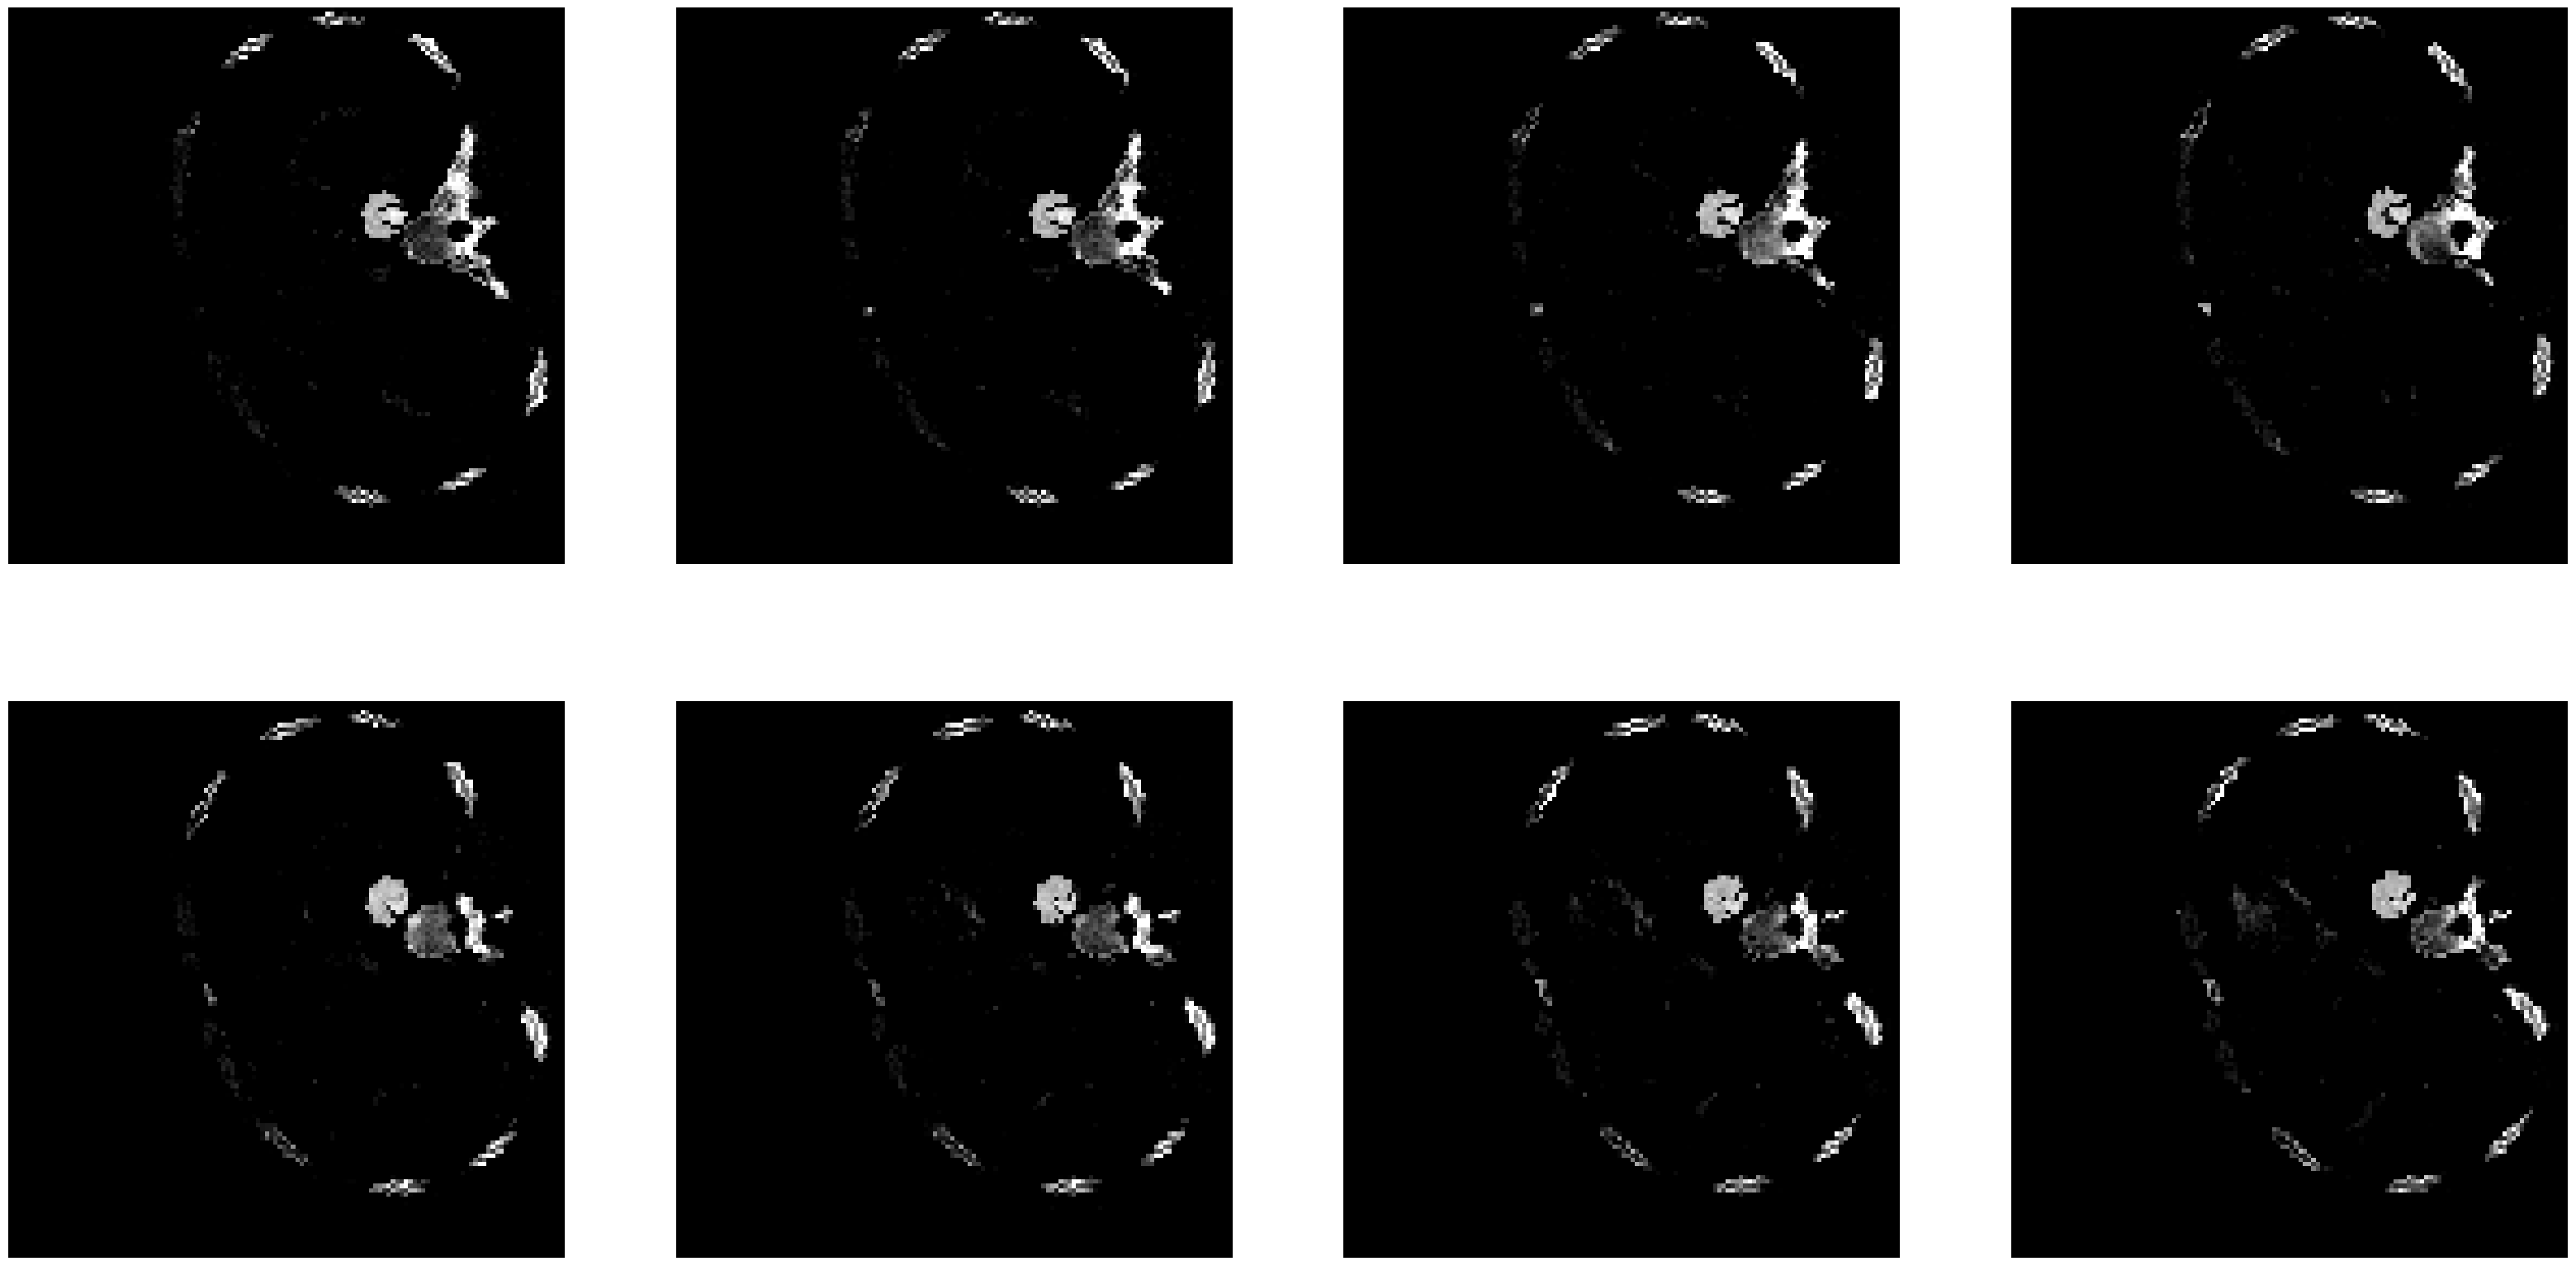

In [24]:
plot_batch(image_tf, label_tf)

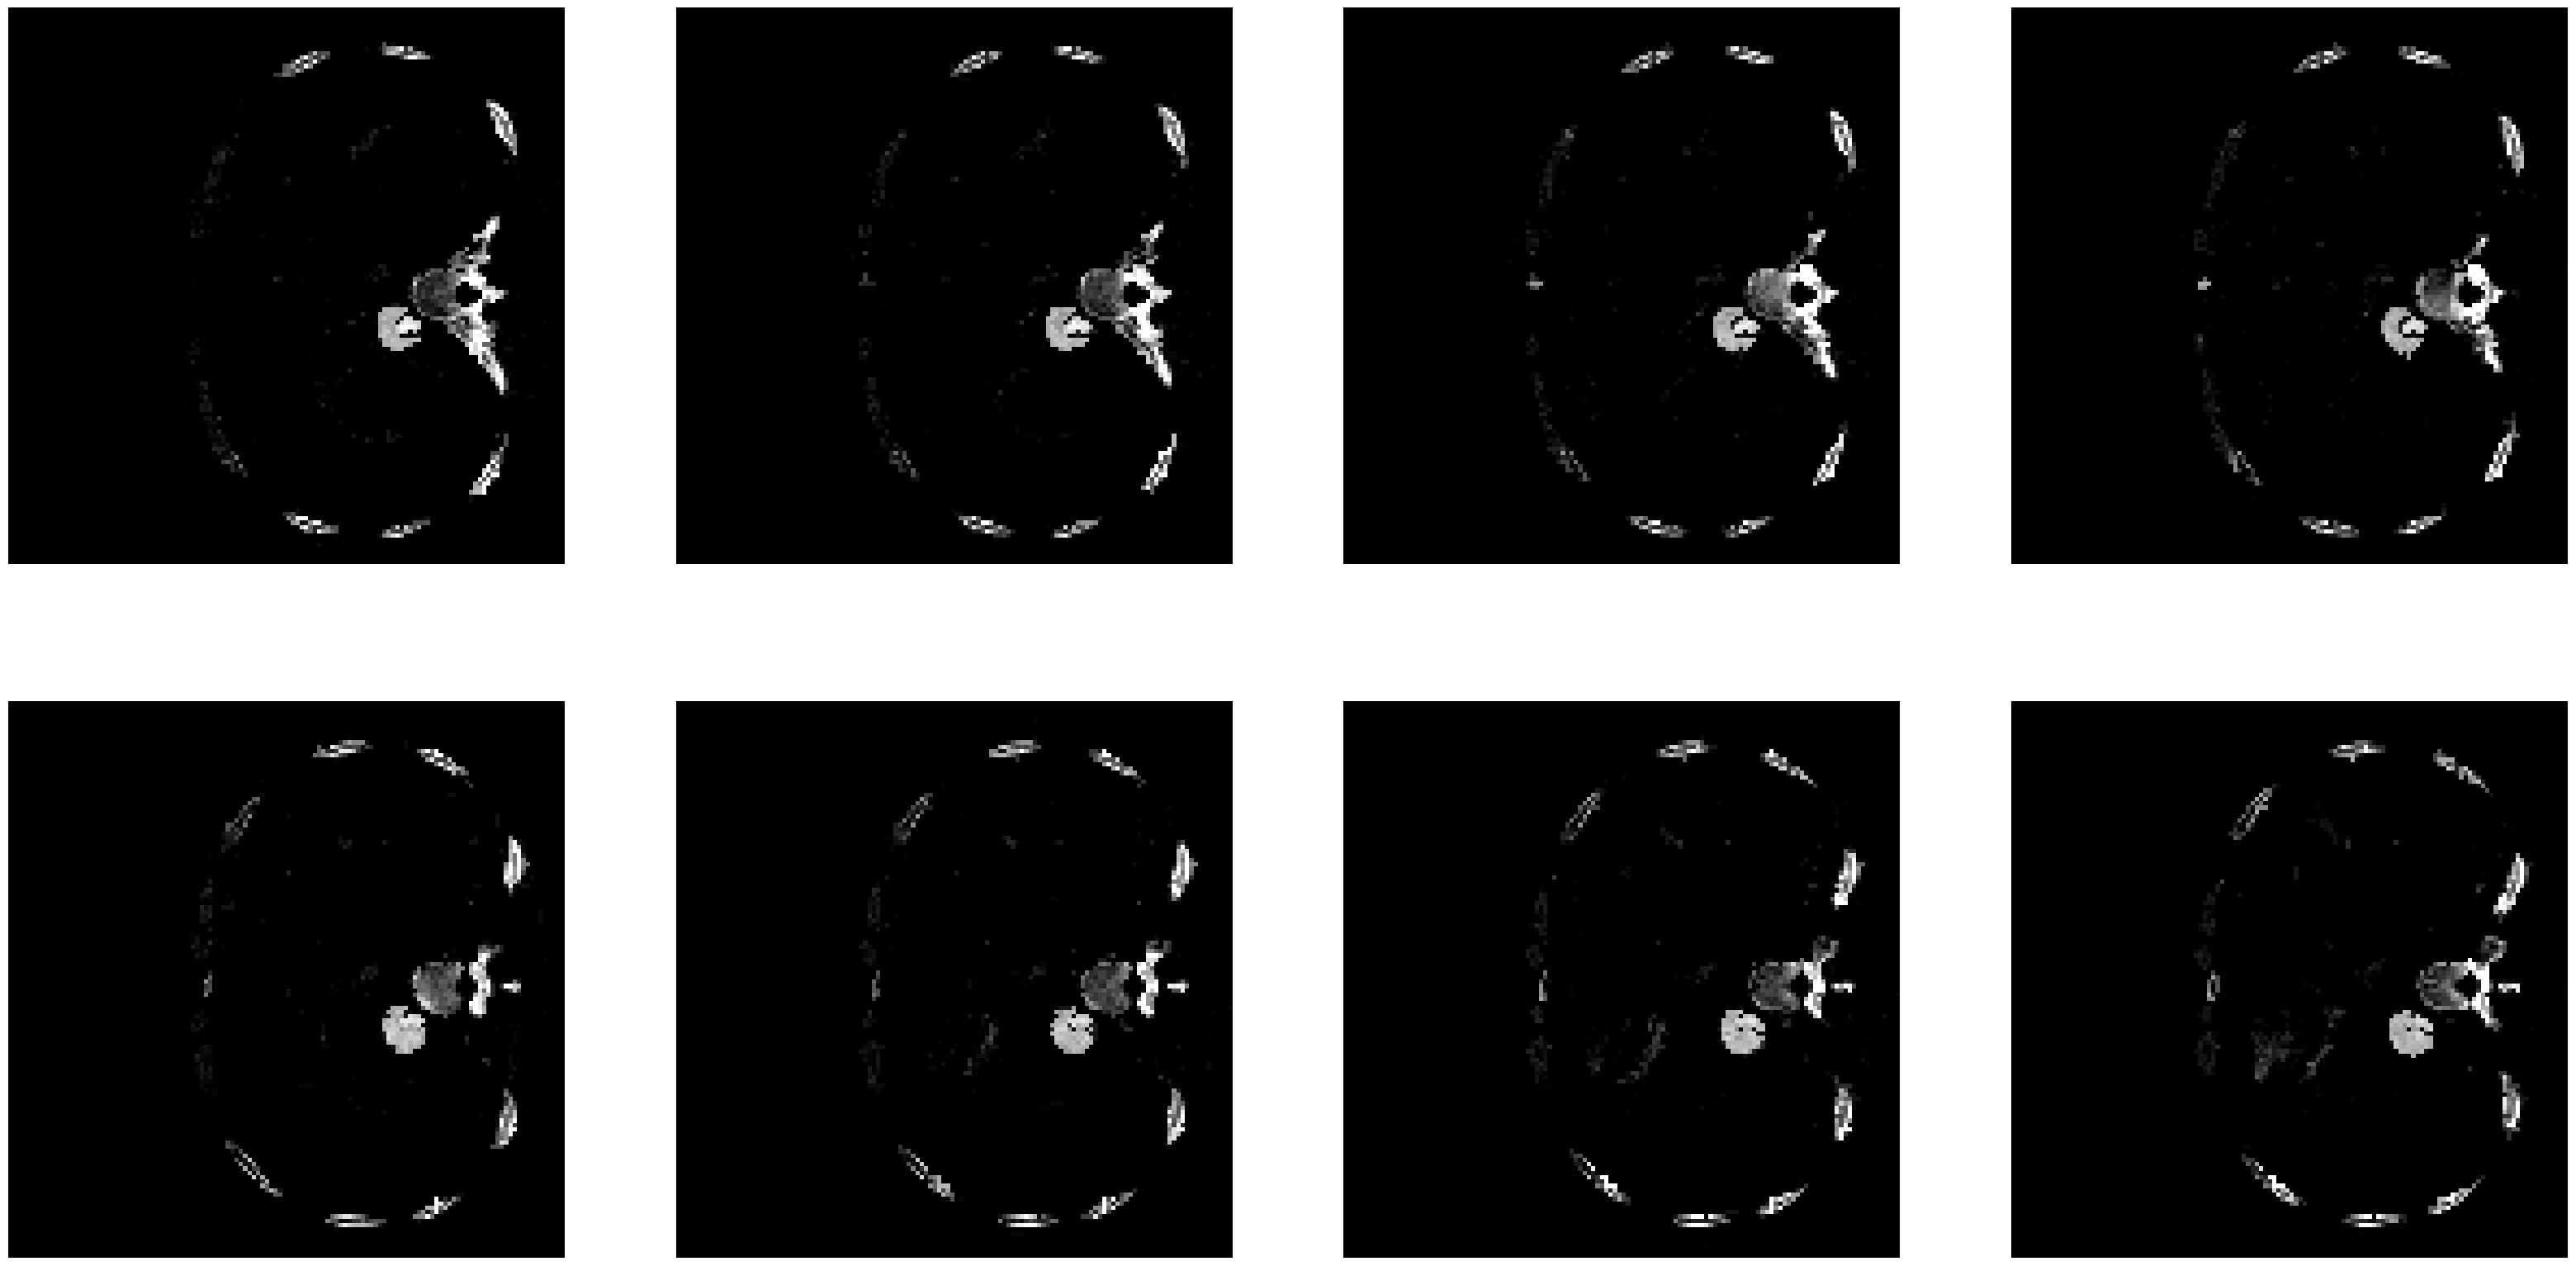

In [23]:
plot_batch(image_tf_inv, label_tf_inv)

In [24]:
import monai

In [25]:
post_trans = monai.transforms.Compose(
    [
        monai.transforms.Activations(sigmoid=True),
        monai.transforms.AsDiscrete(threshold=0.5),
    ]
)

In [26]:

class Trainer:

    def __init__(
        self,
        model,
        train_loader,
        cfg,
    ):

        self.model = model
        
        self.train_loader = train_loader
        self.unlab_loader = unlab_loader

        self.transforms = Transforms(
            rot_prob=cfg.rot_prob,
            flip_prob=cfg.flip_prob,
            rot_range_z=cfg.rot_angle,
            final_image_size=cfg.image_size
        )
        self.unlab_weight = cfg.unlab_weight

    def train_labeled_one_epoch(
        self,
        use_transform: bool
    ):
        device = next(self.model.parameters()).device
        self.model.train()
        for i, image_batch in enumerate(self.train_loader):
            image = image_batch["image"].to(device)
            label = image_batch["label"].to(device)

            logits = self.model(image)
            plot_batch(
                image.cpu().numpy(), 
                label.cpu().numpy()
            )

            if use_transform:
                image_tf = self.transforms(image)
                logits_tf = self.model(image_tf)
                label_tf = self.transforms(label, randomize=False)
                plot_batch(
                    image_tf.cpu().numpy(), 
                    label_tf.cpu().numpy()
                )
                
                val_outputs = [post_trans(logit) for logit in logits_tf.detach().cpu().numpy()]
                plot_batch(
                    image_tf.cpu().numpy(), 
                    np.stack(val_outputs)
                )
            
            plot_batch(
                np.zeros_like(image_tf.cpu().numpy()), 
                np.zeros_like(label_tf.cpu().numpy())
            )
    




In [27]:
trainer = Trainer(
    model,
    train_loader,
    cfg=config.trainer,
)

IndexError: index 1 is out of bounds for axis 0 with size 1

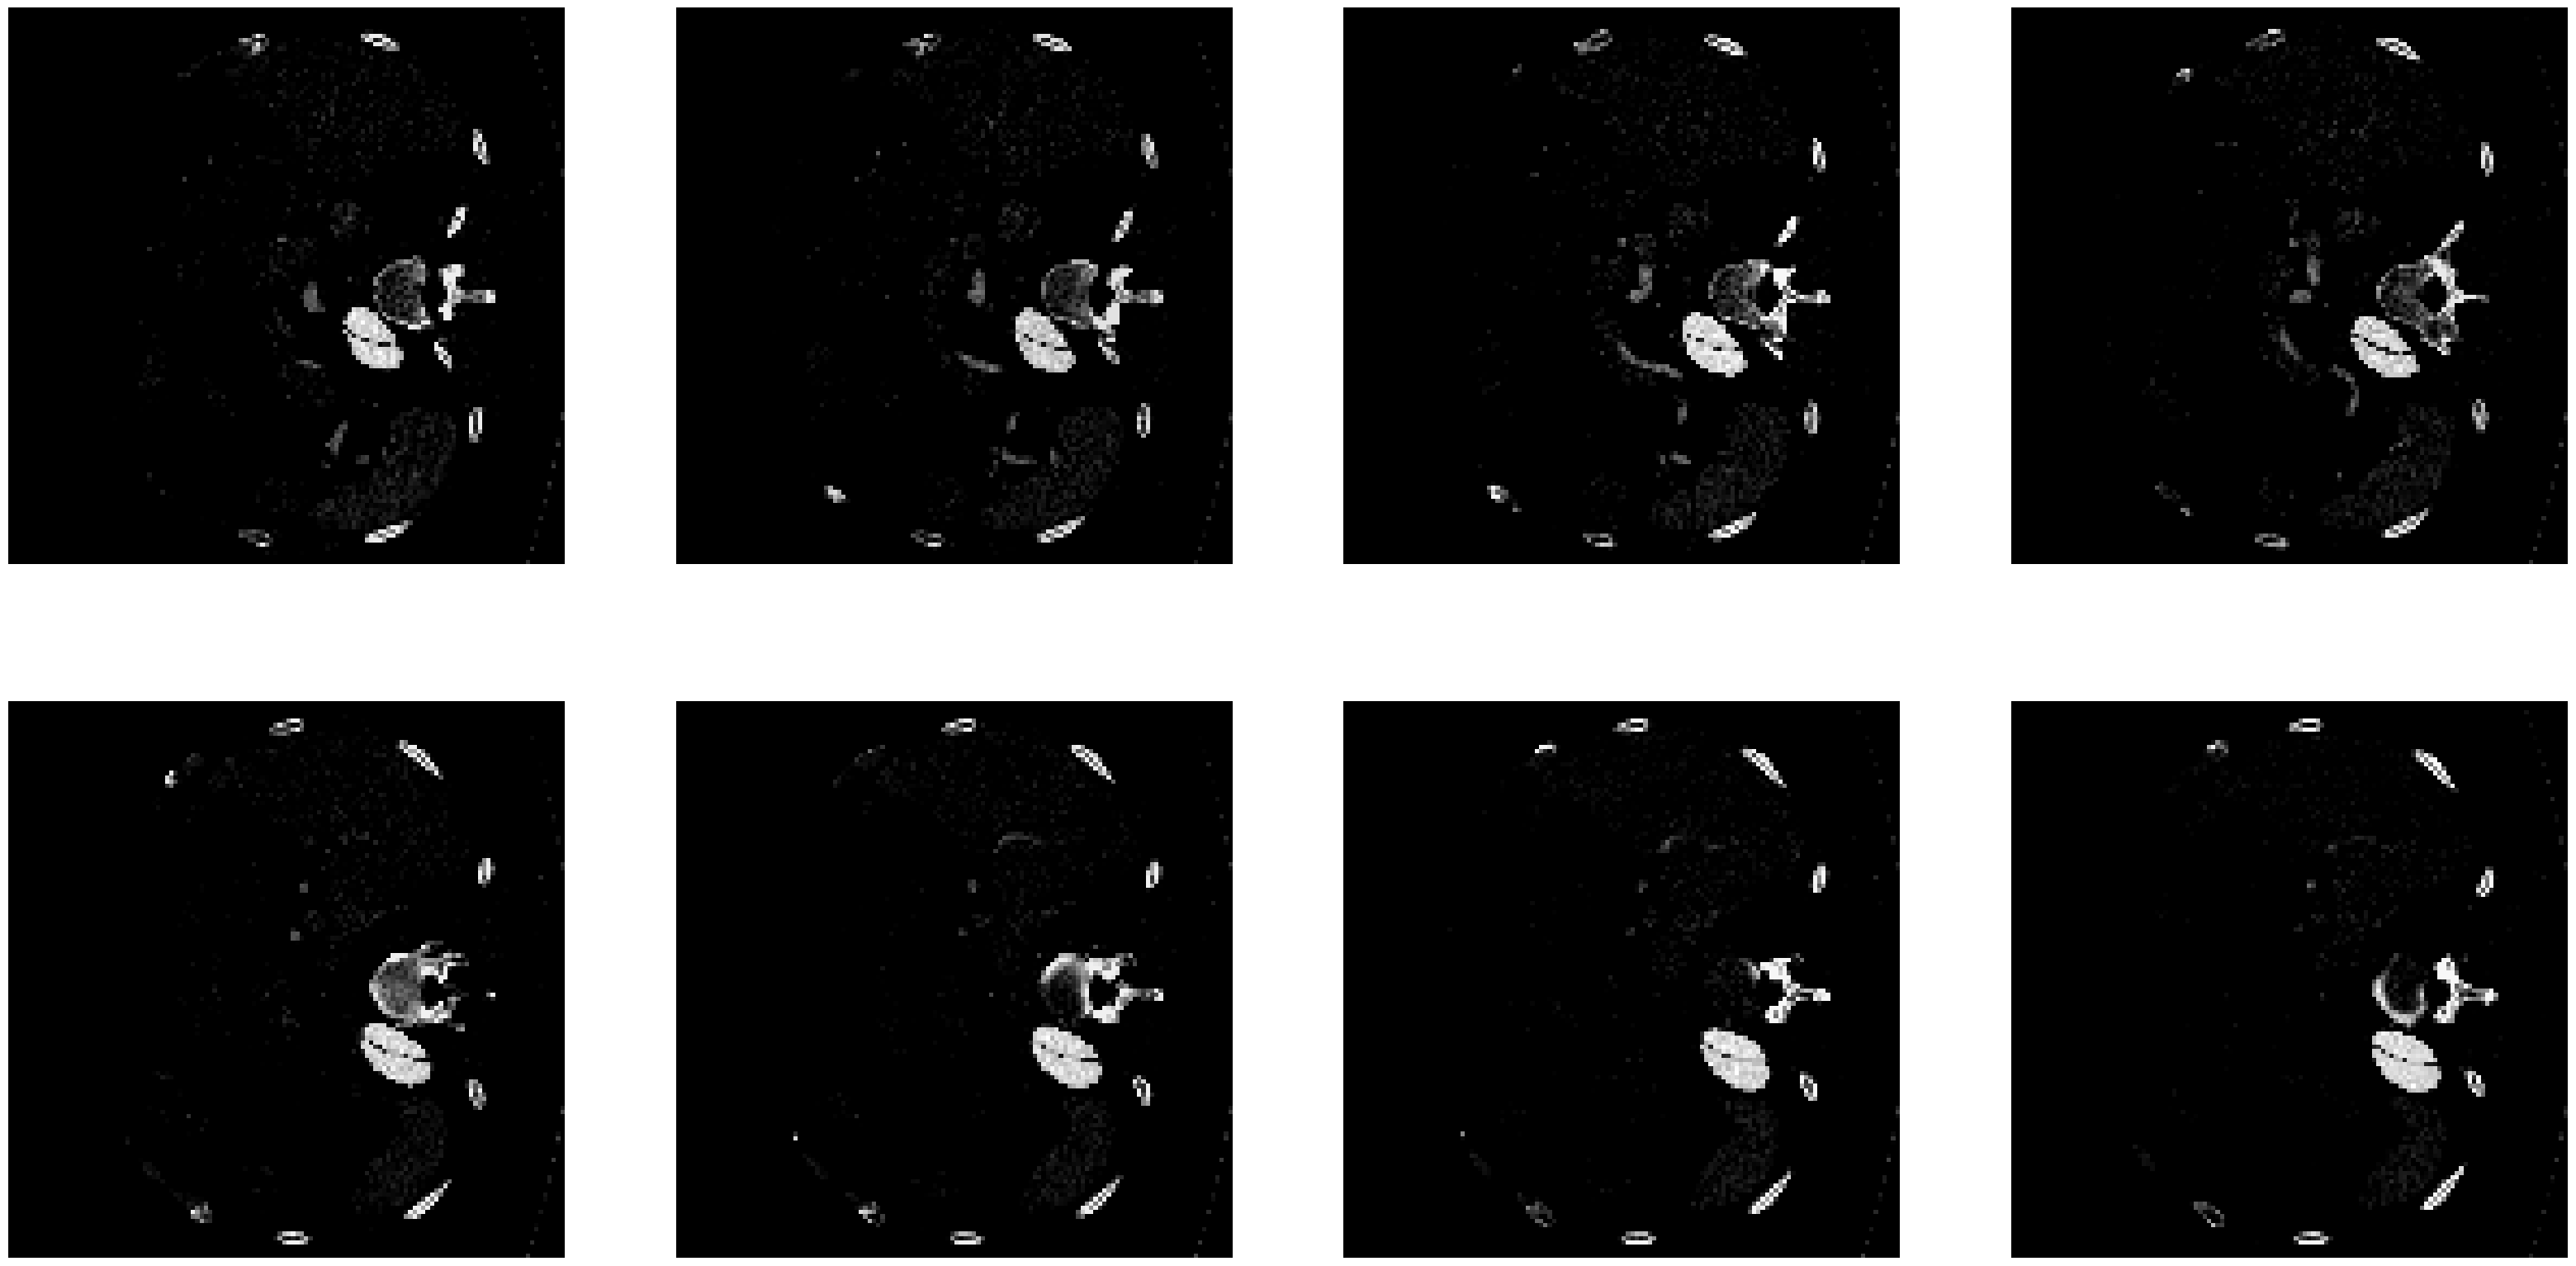

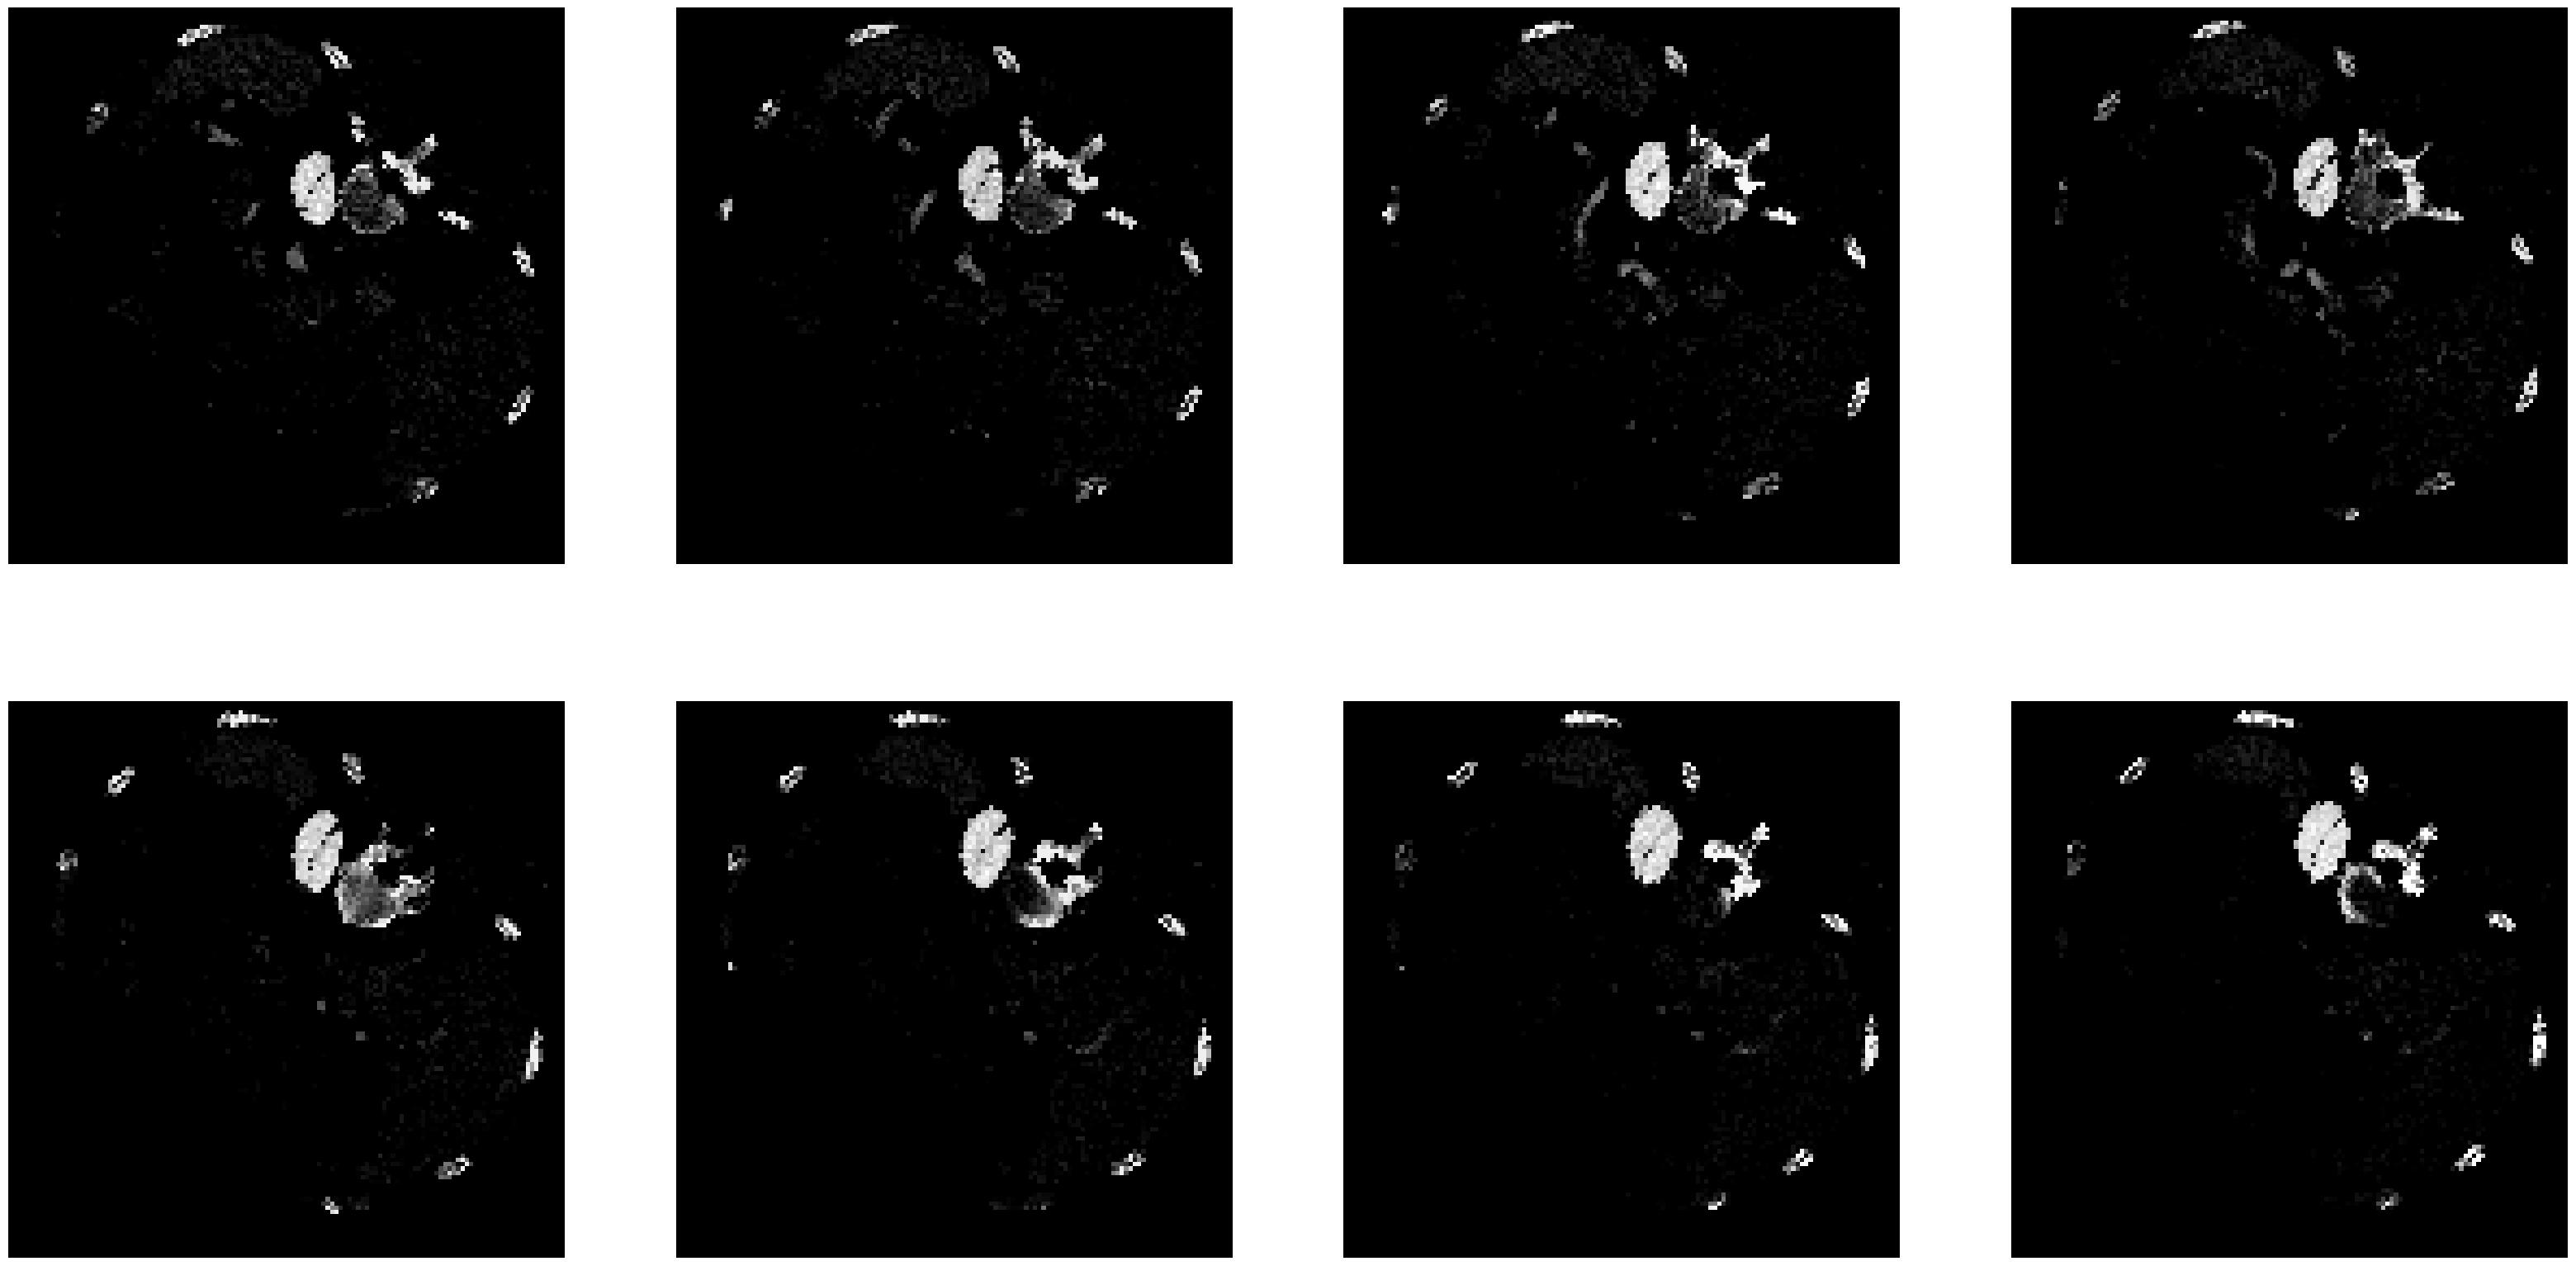

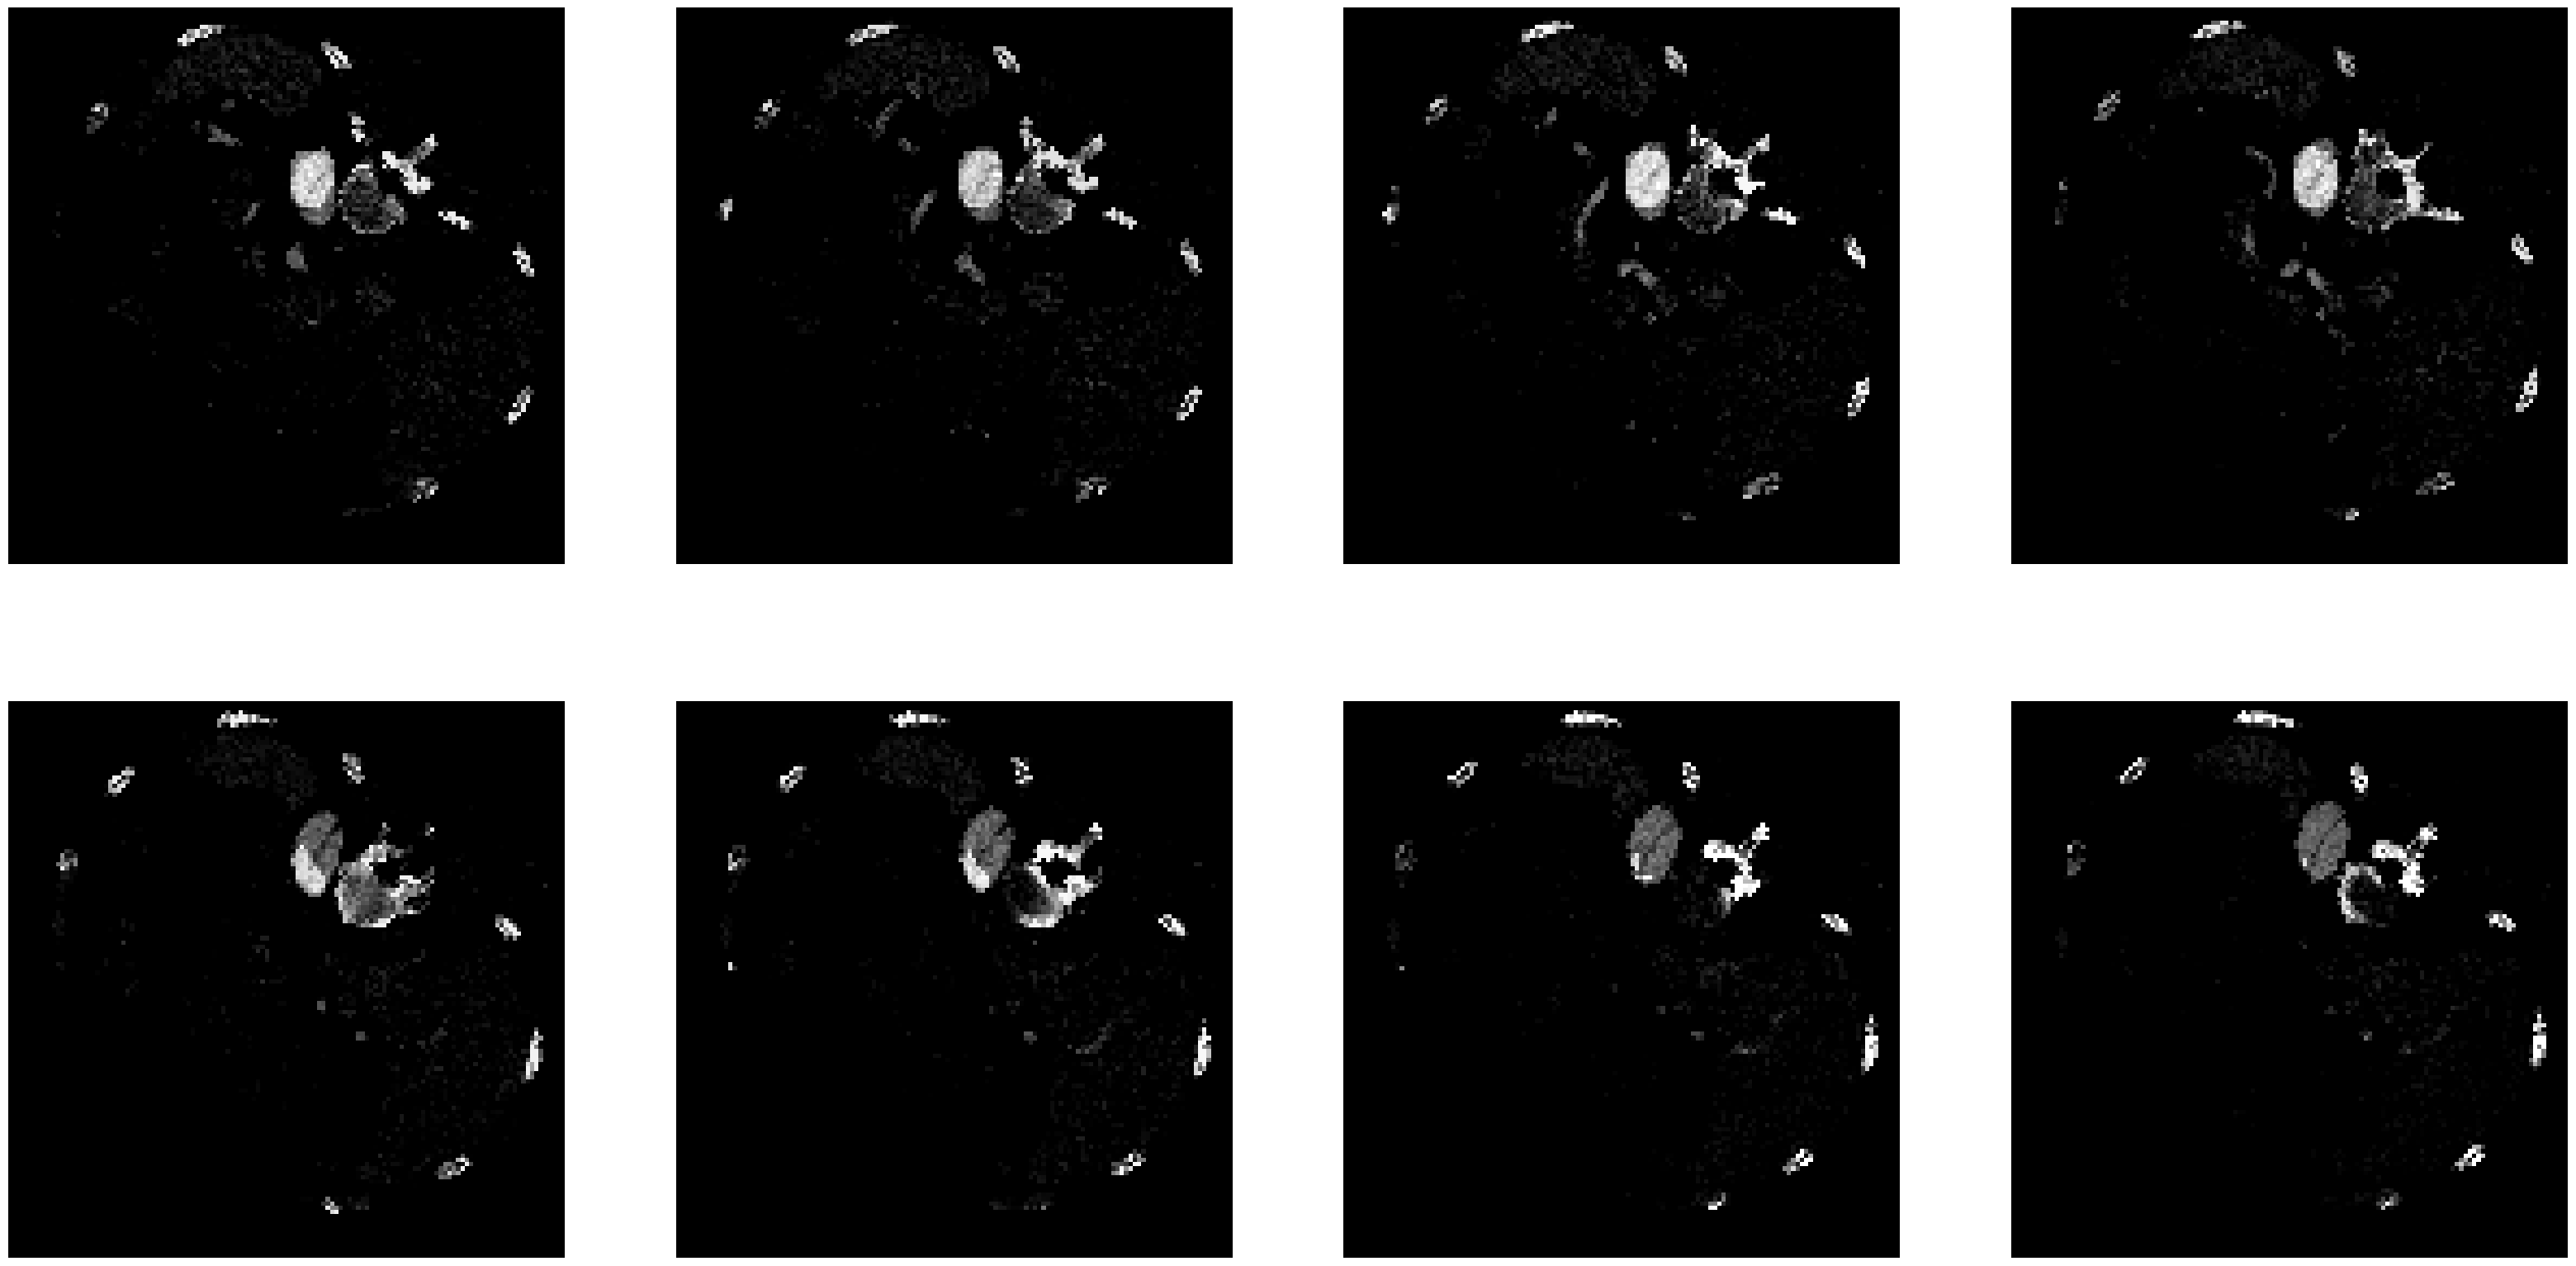

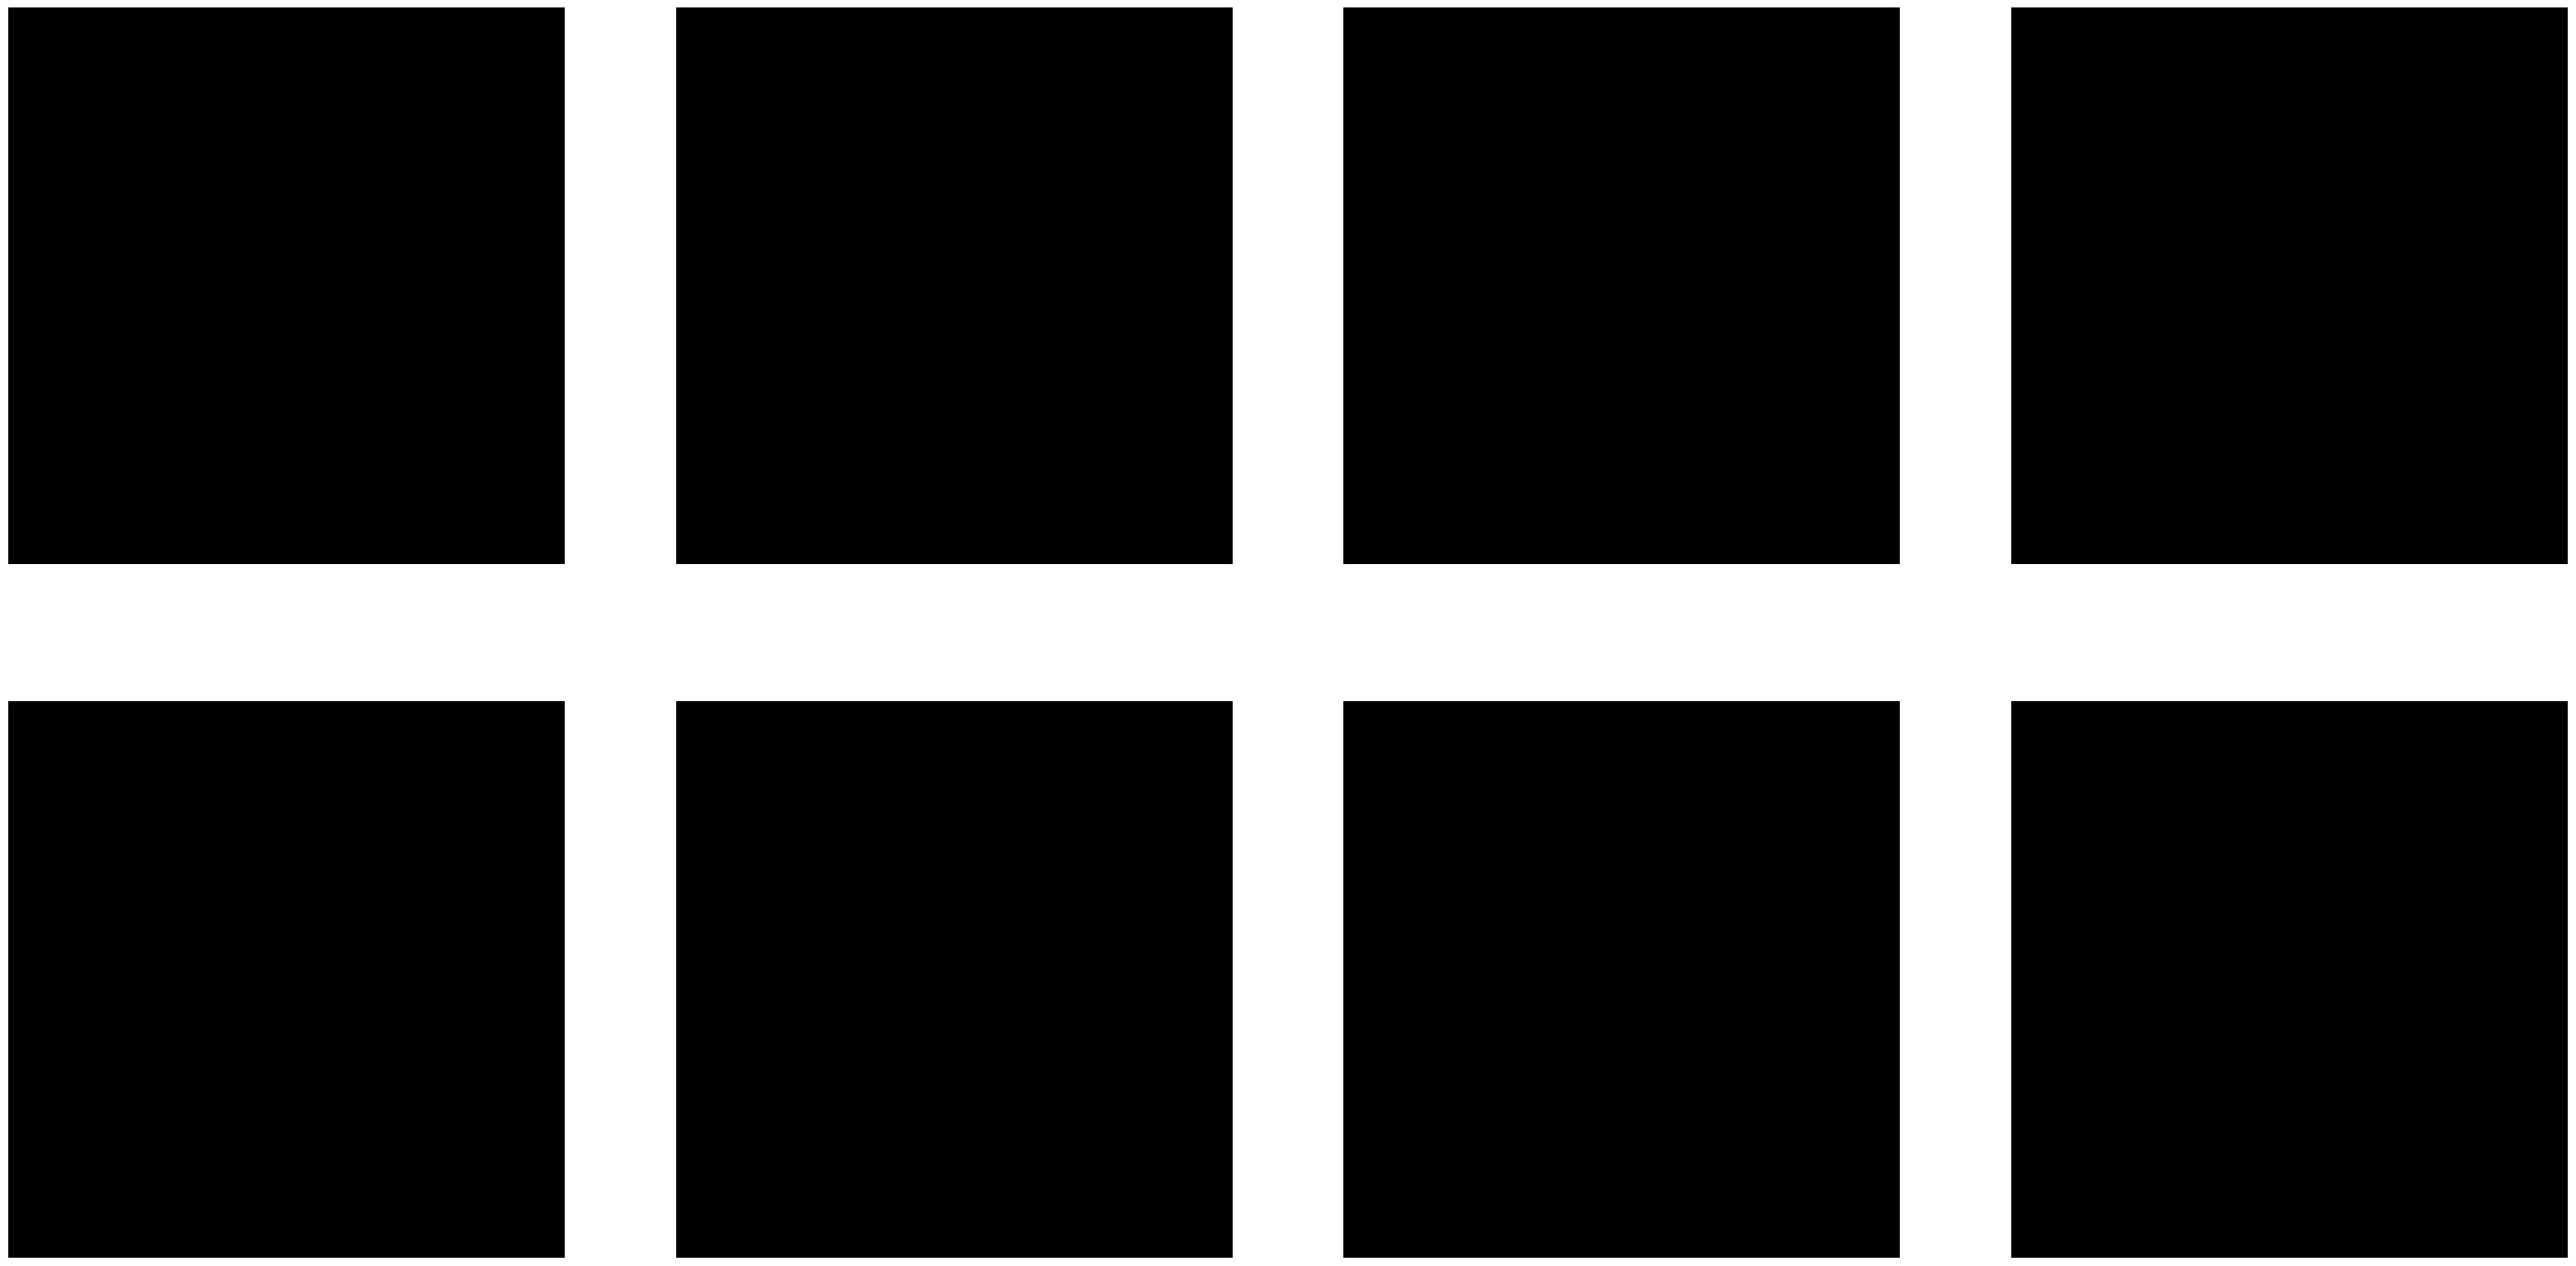

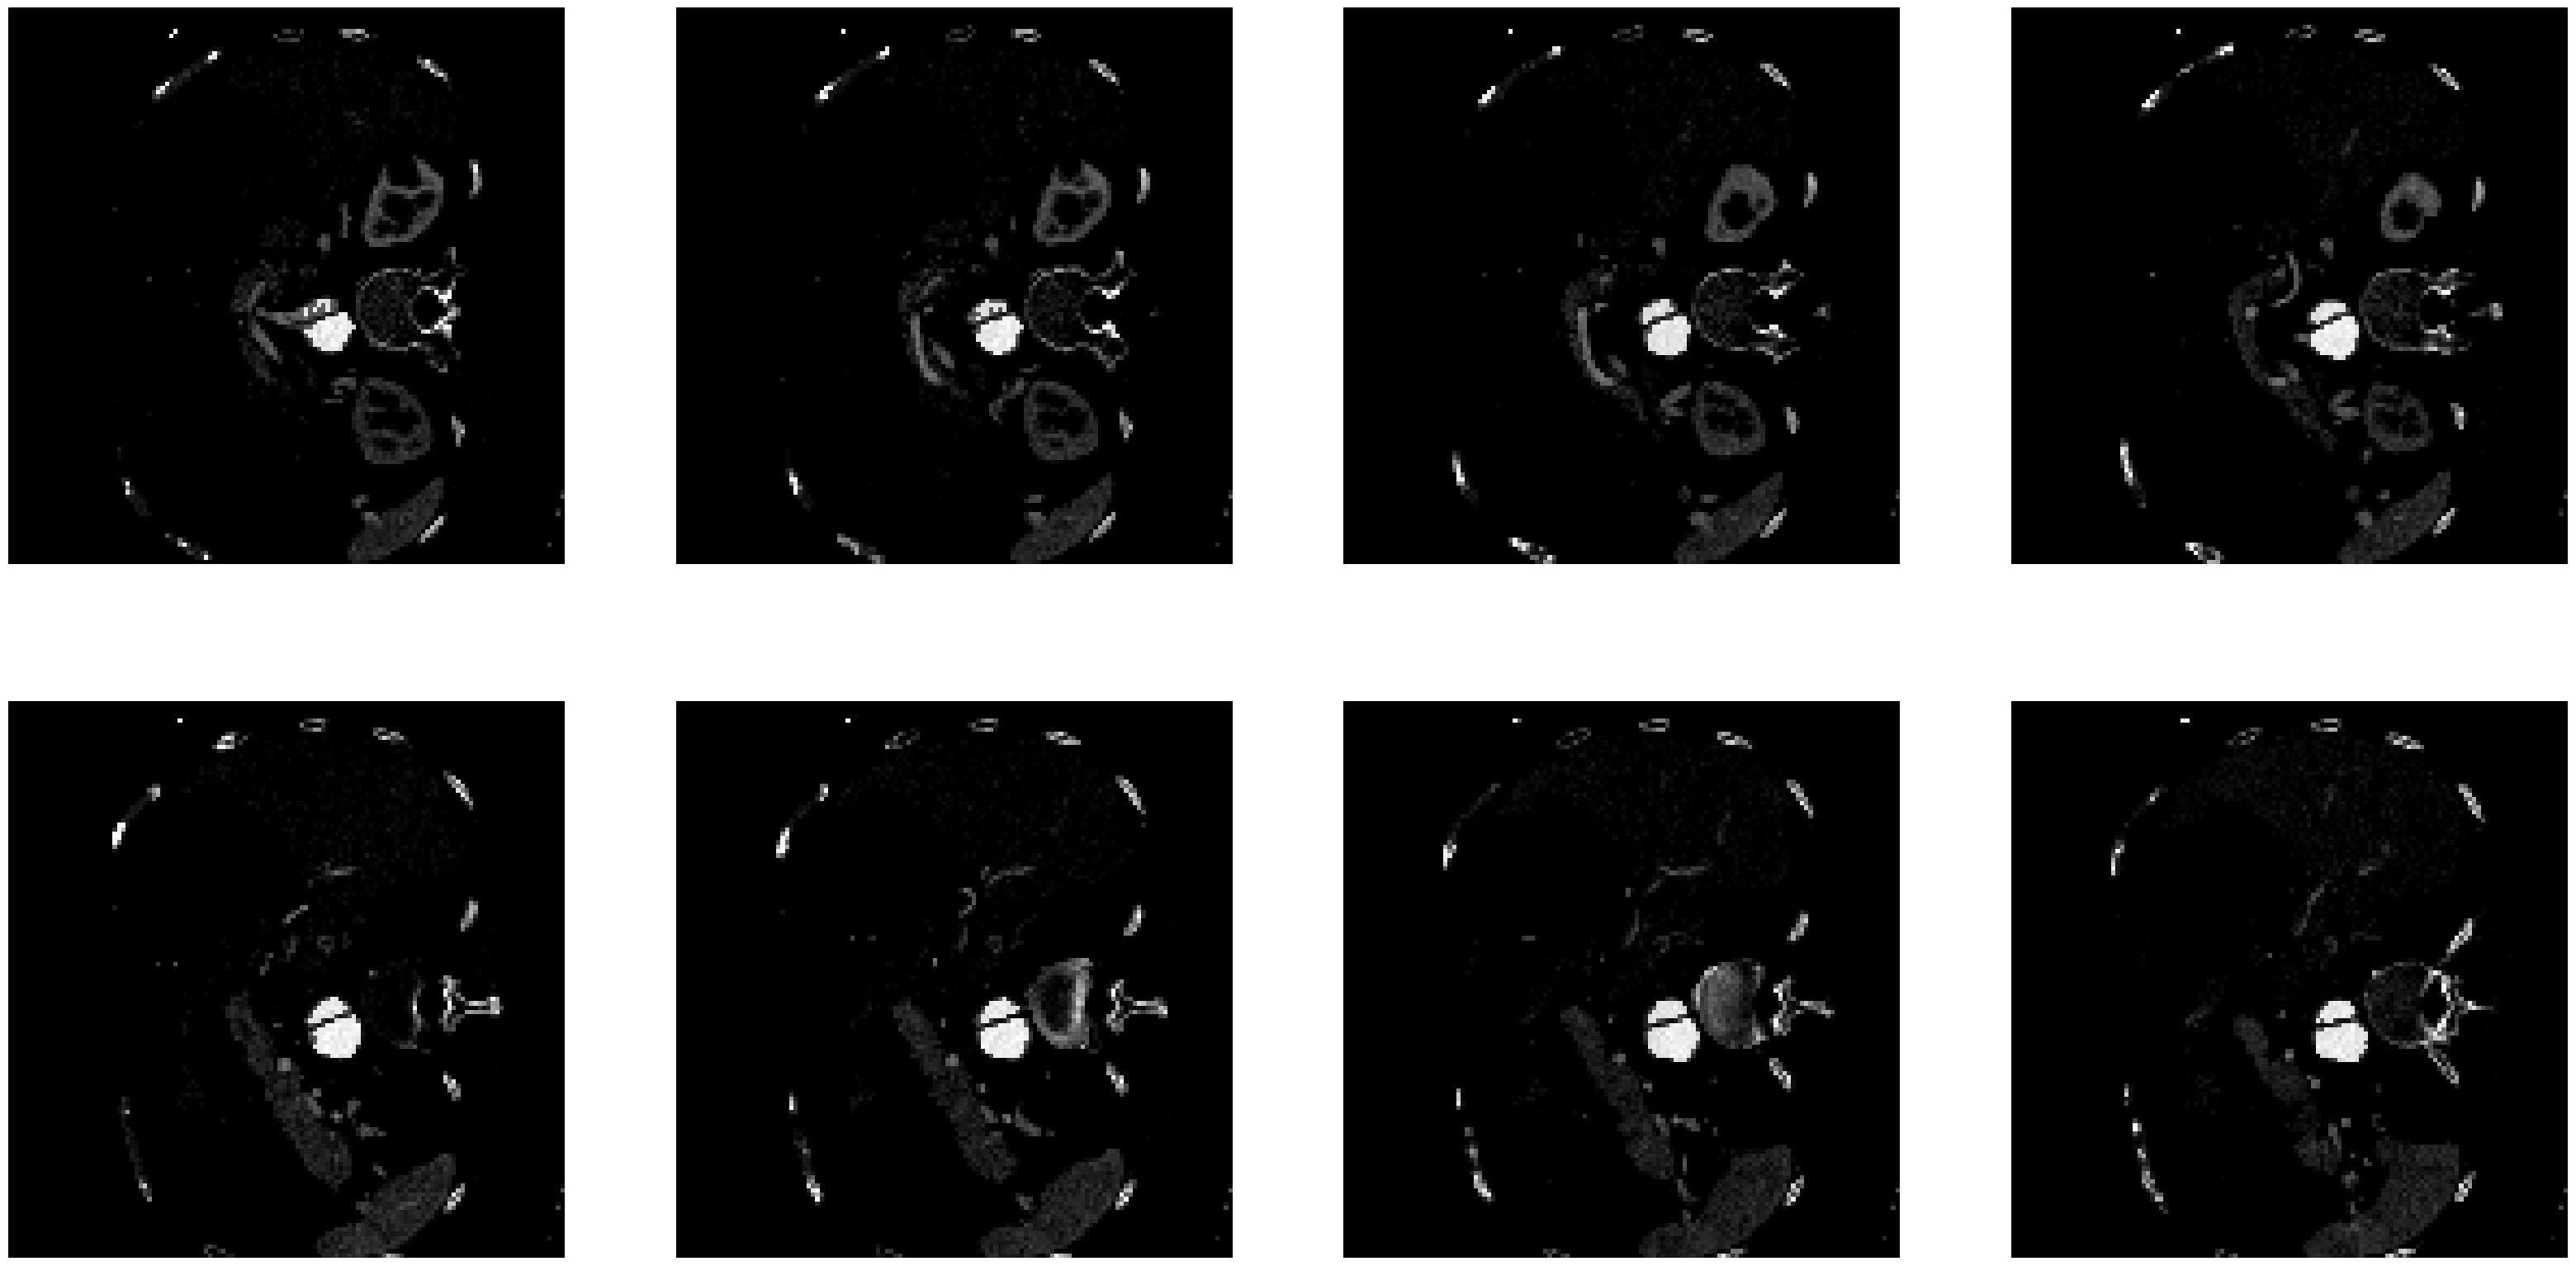

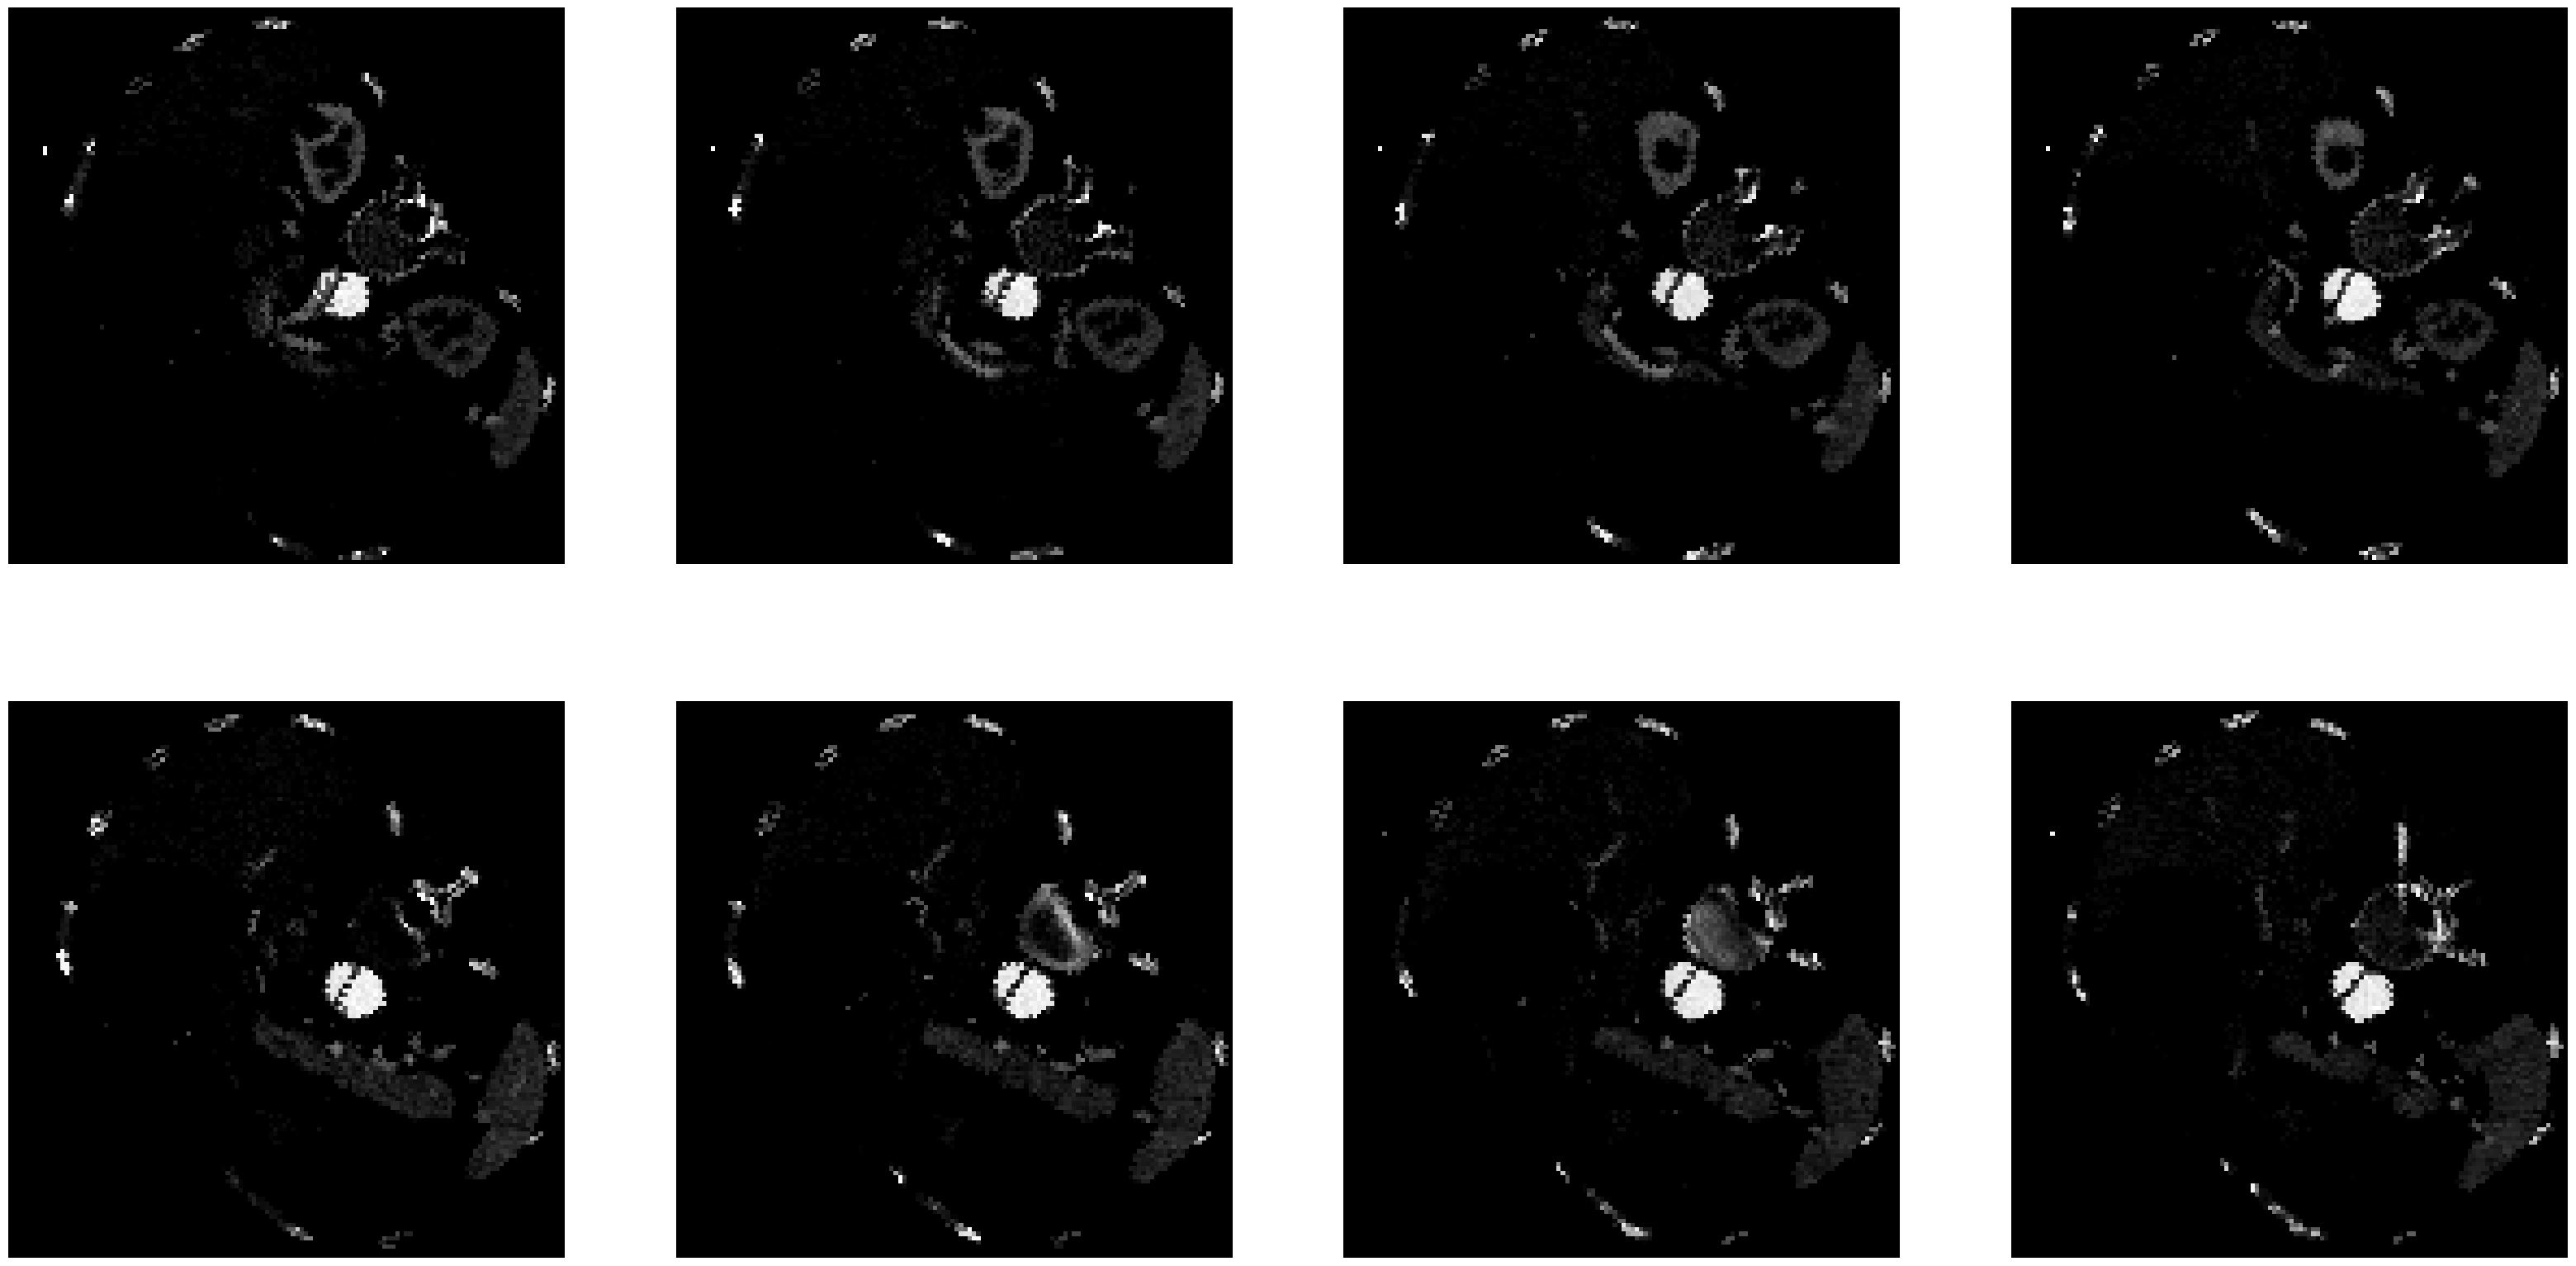

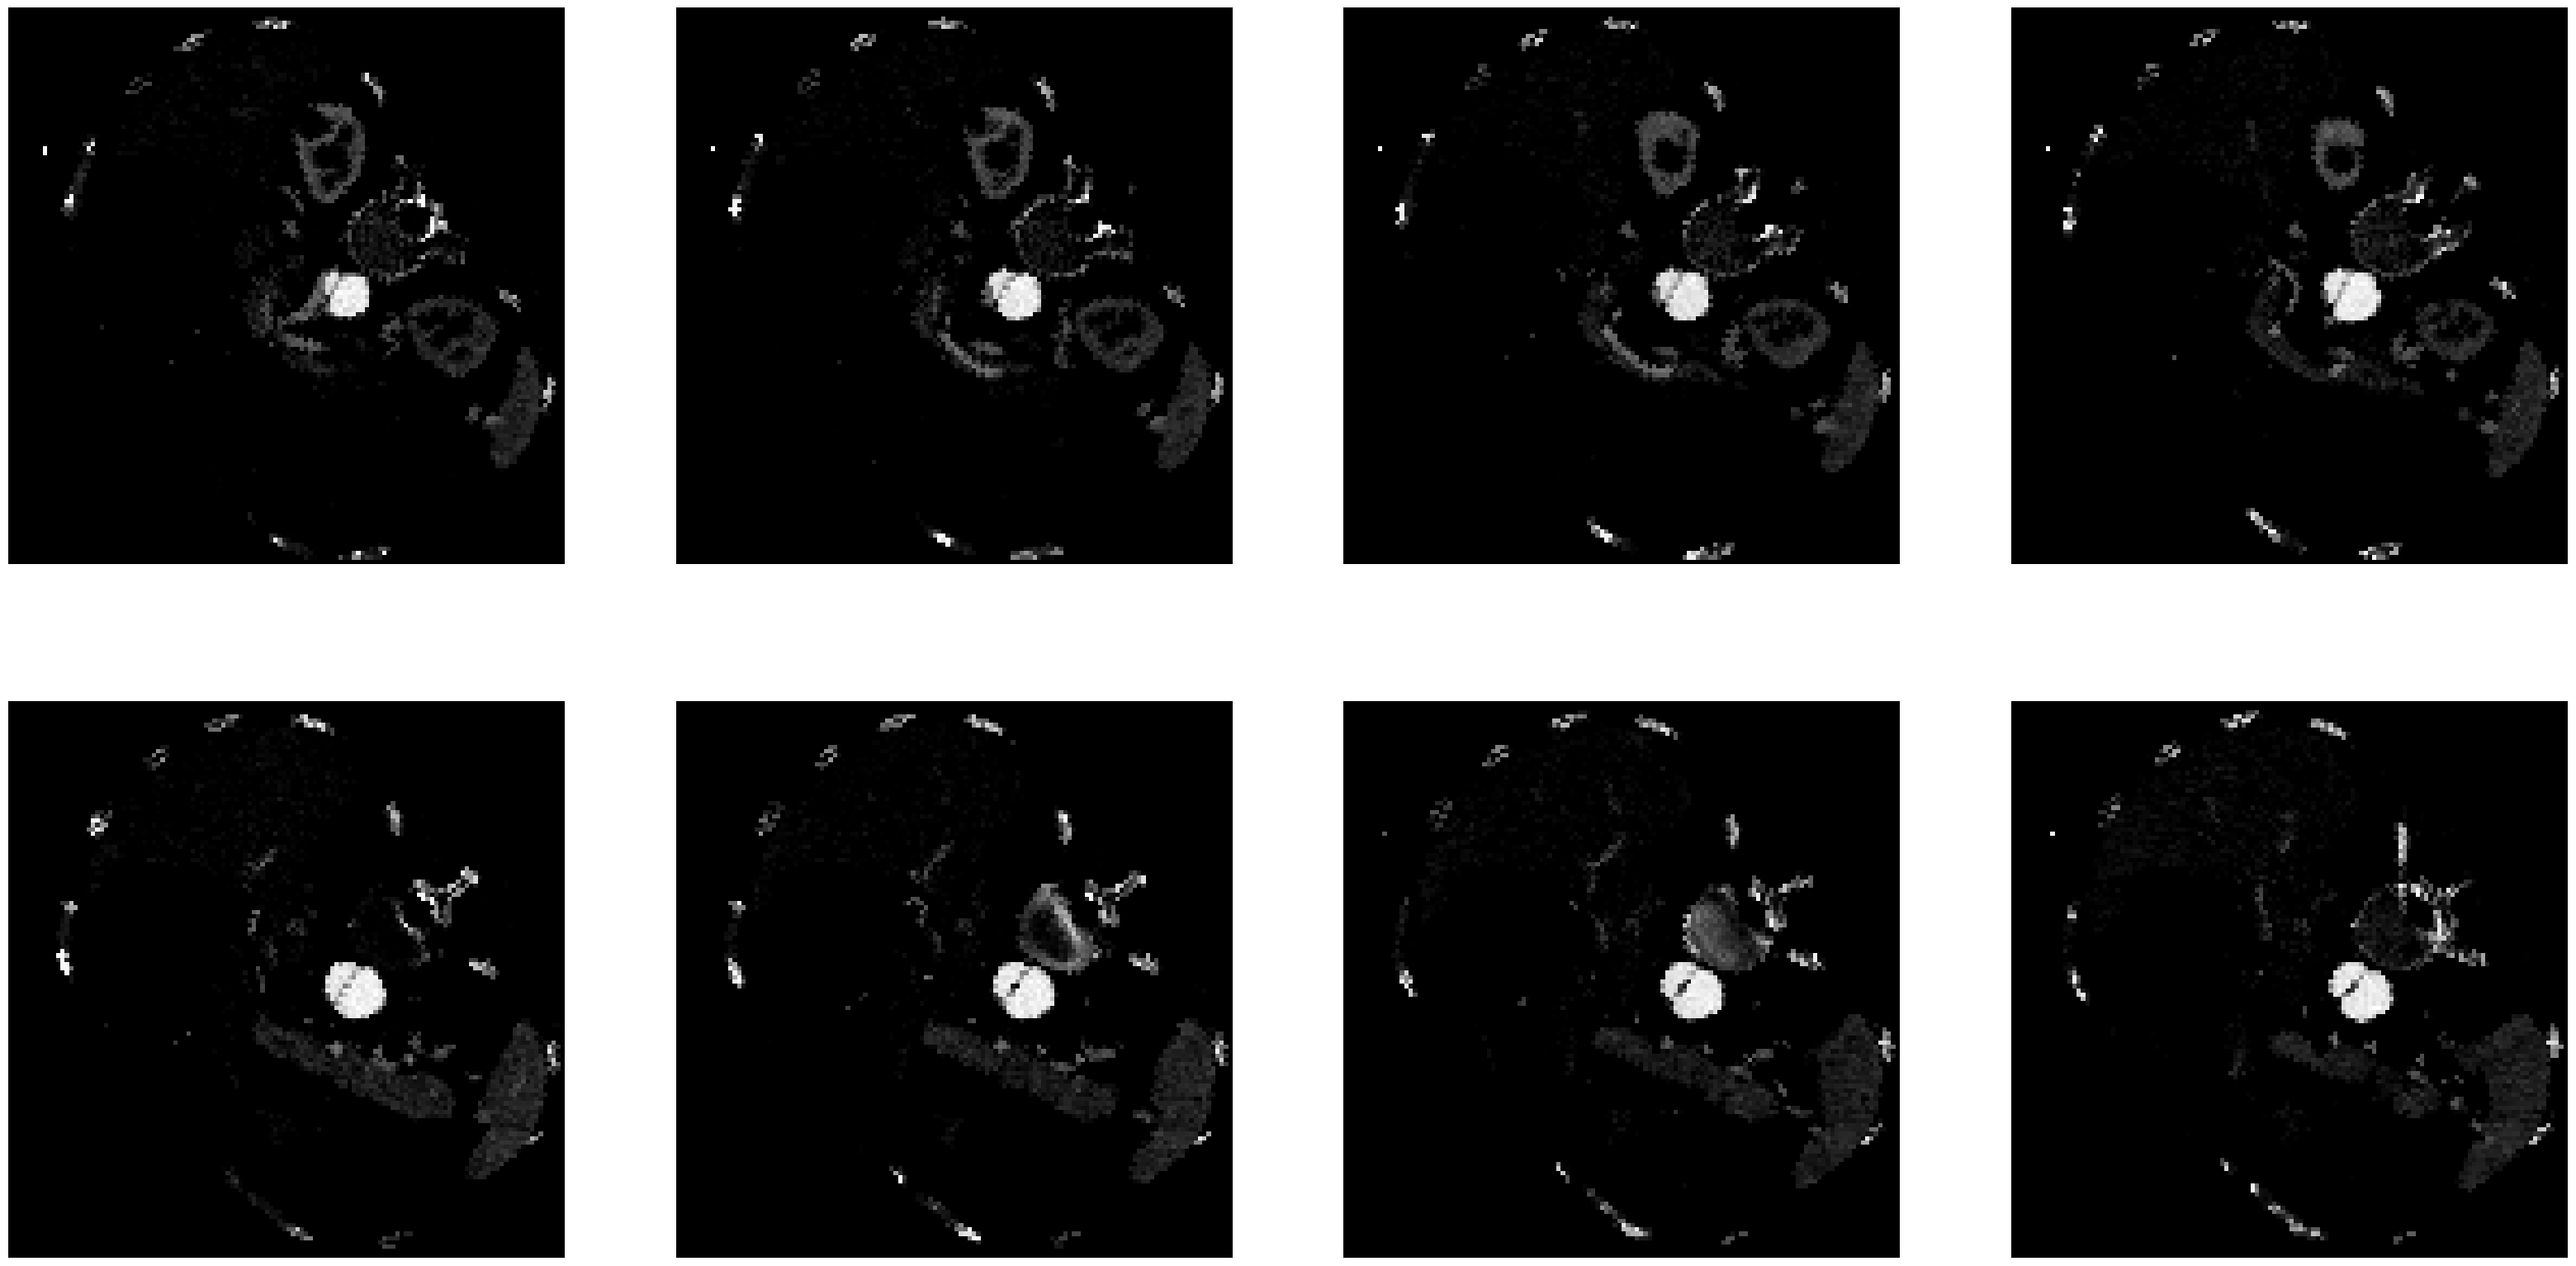

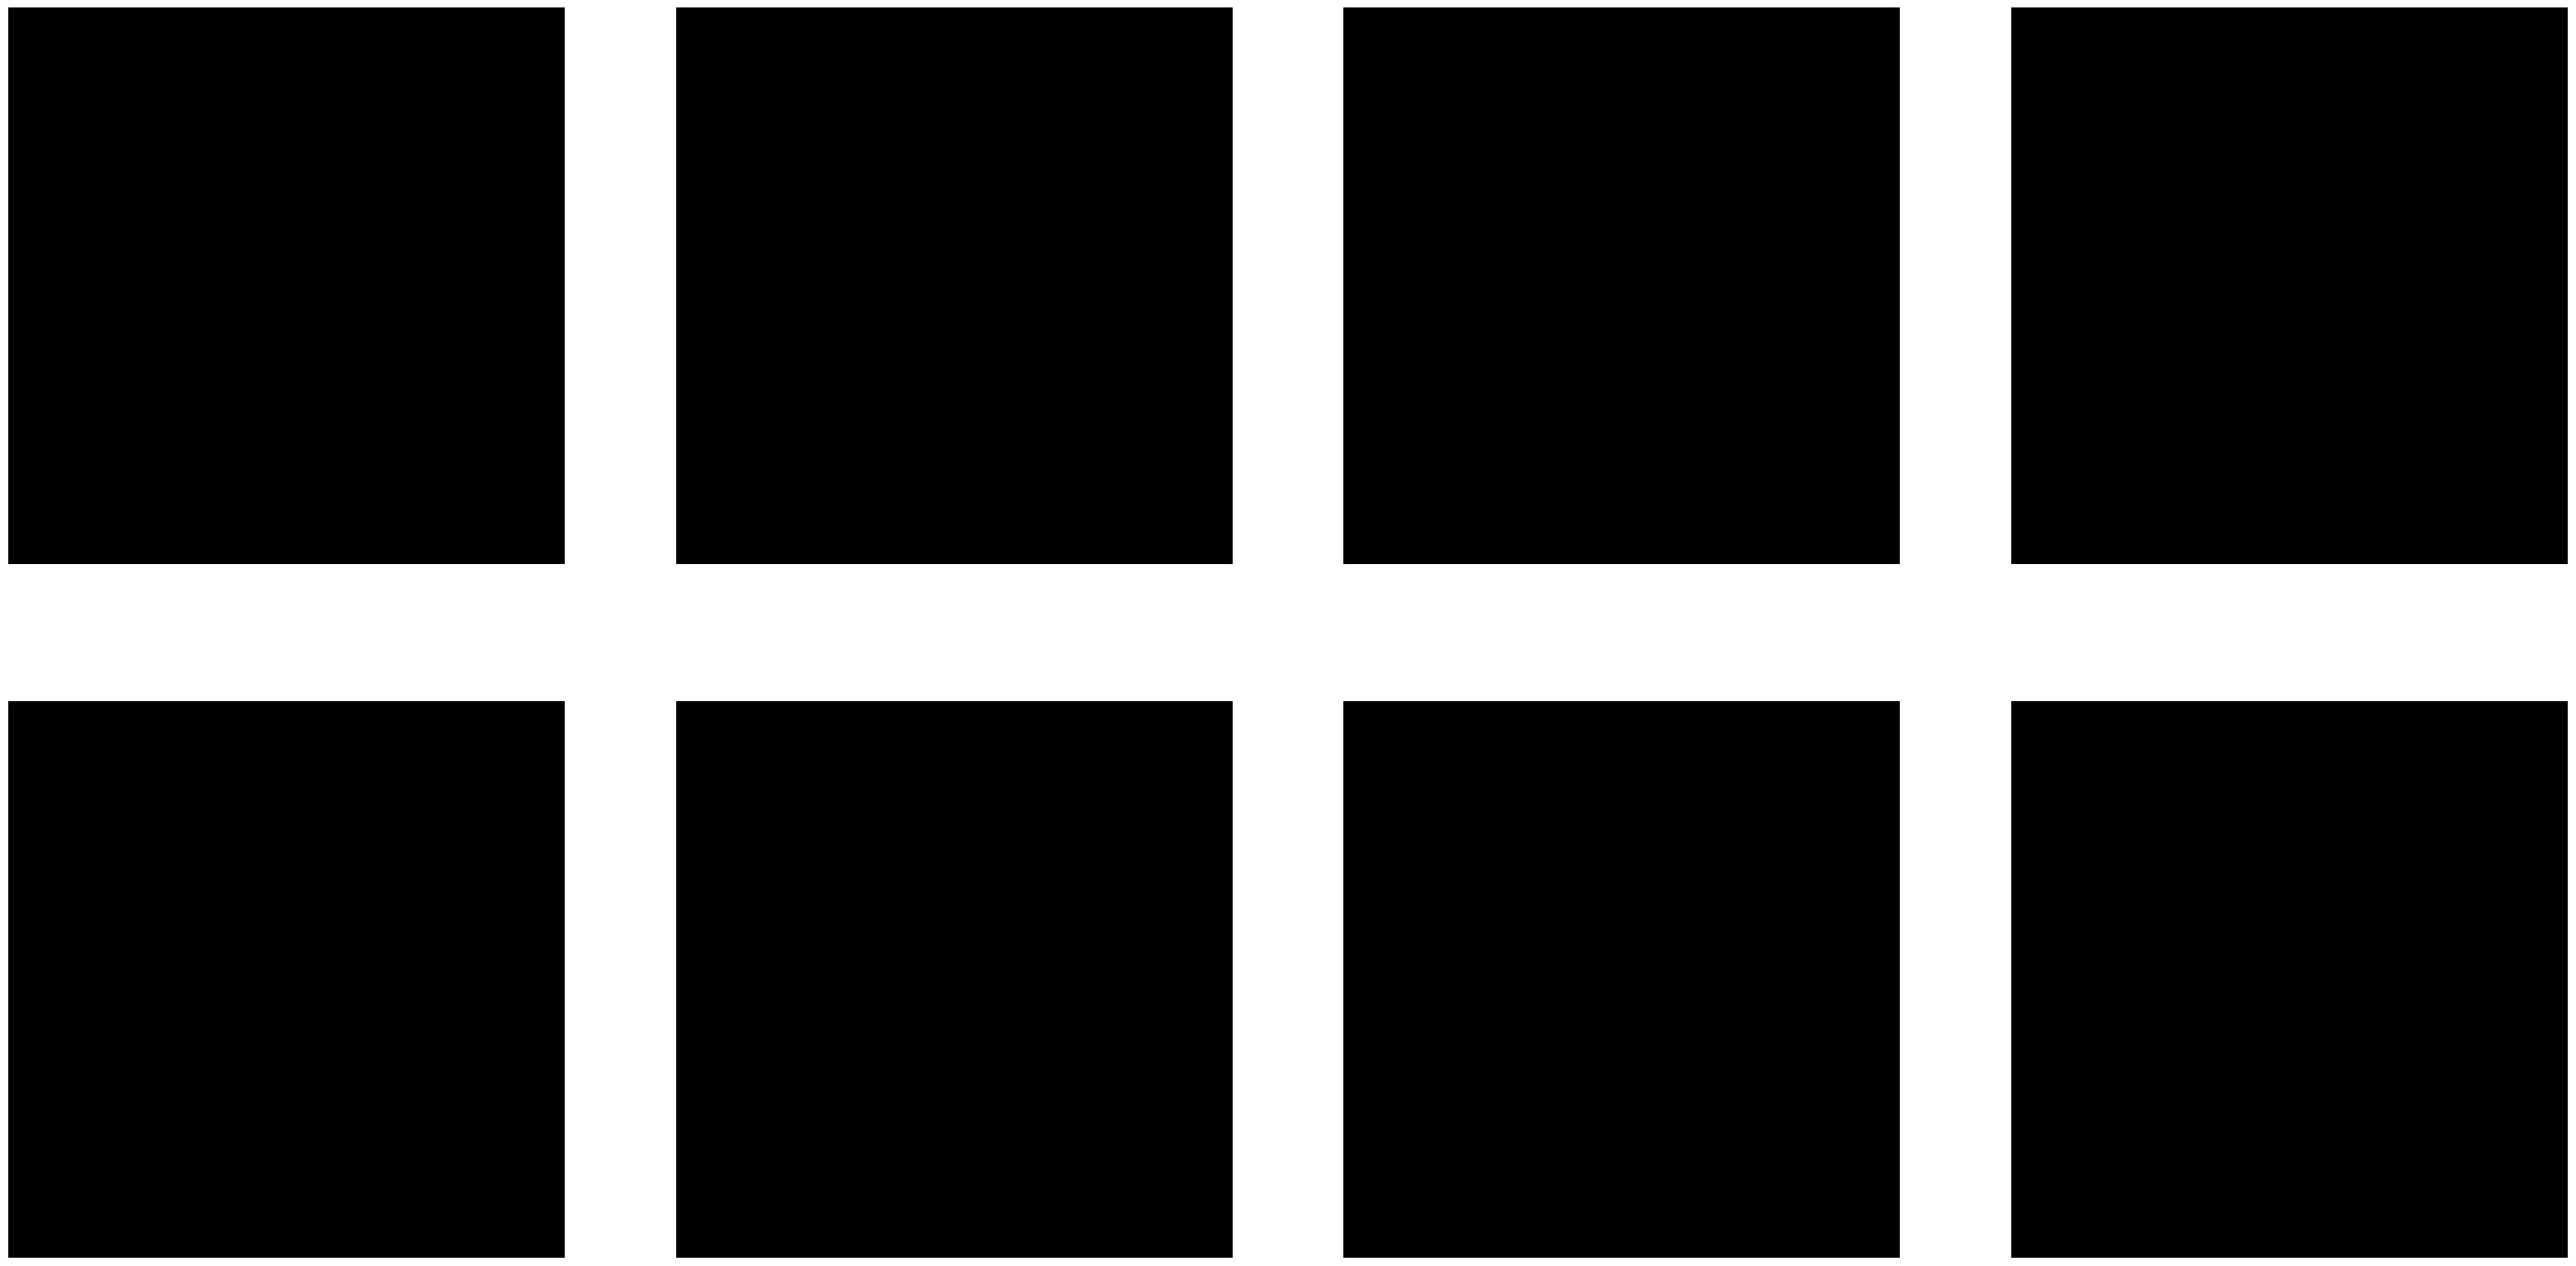

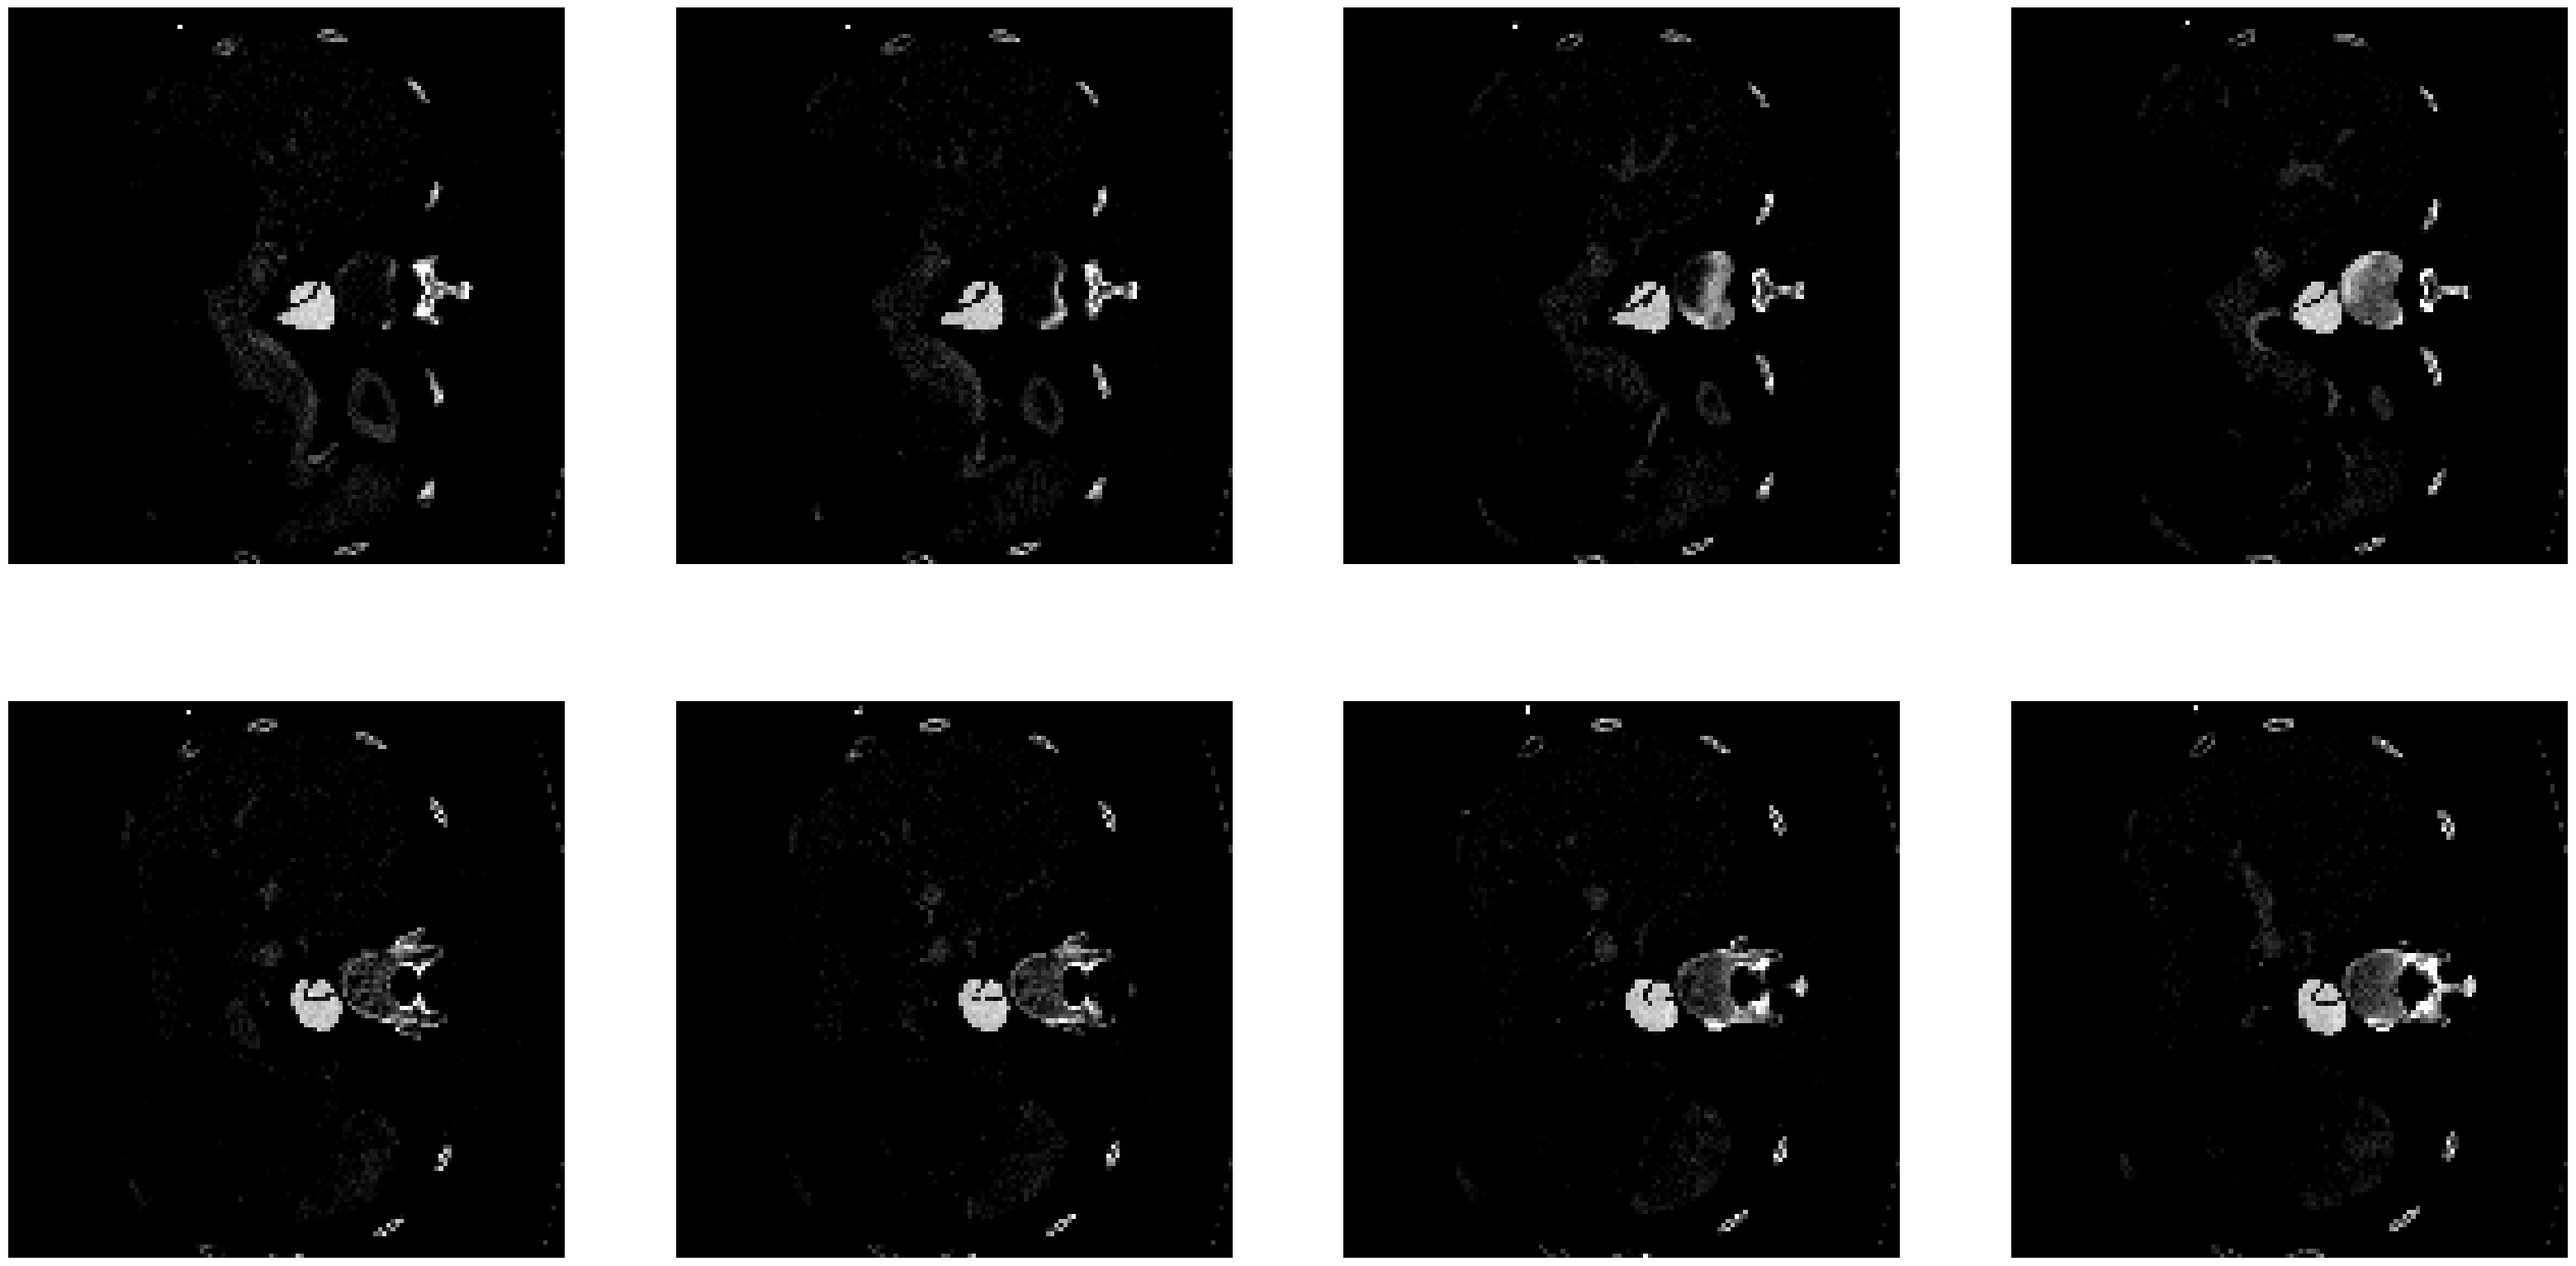

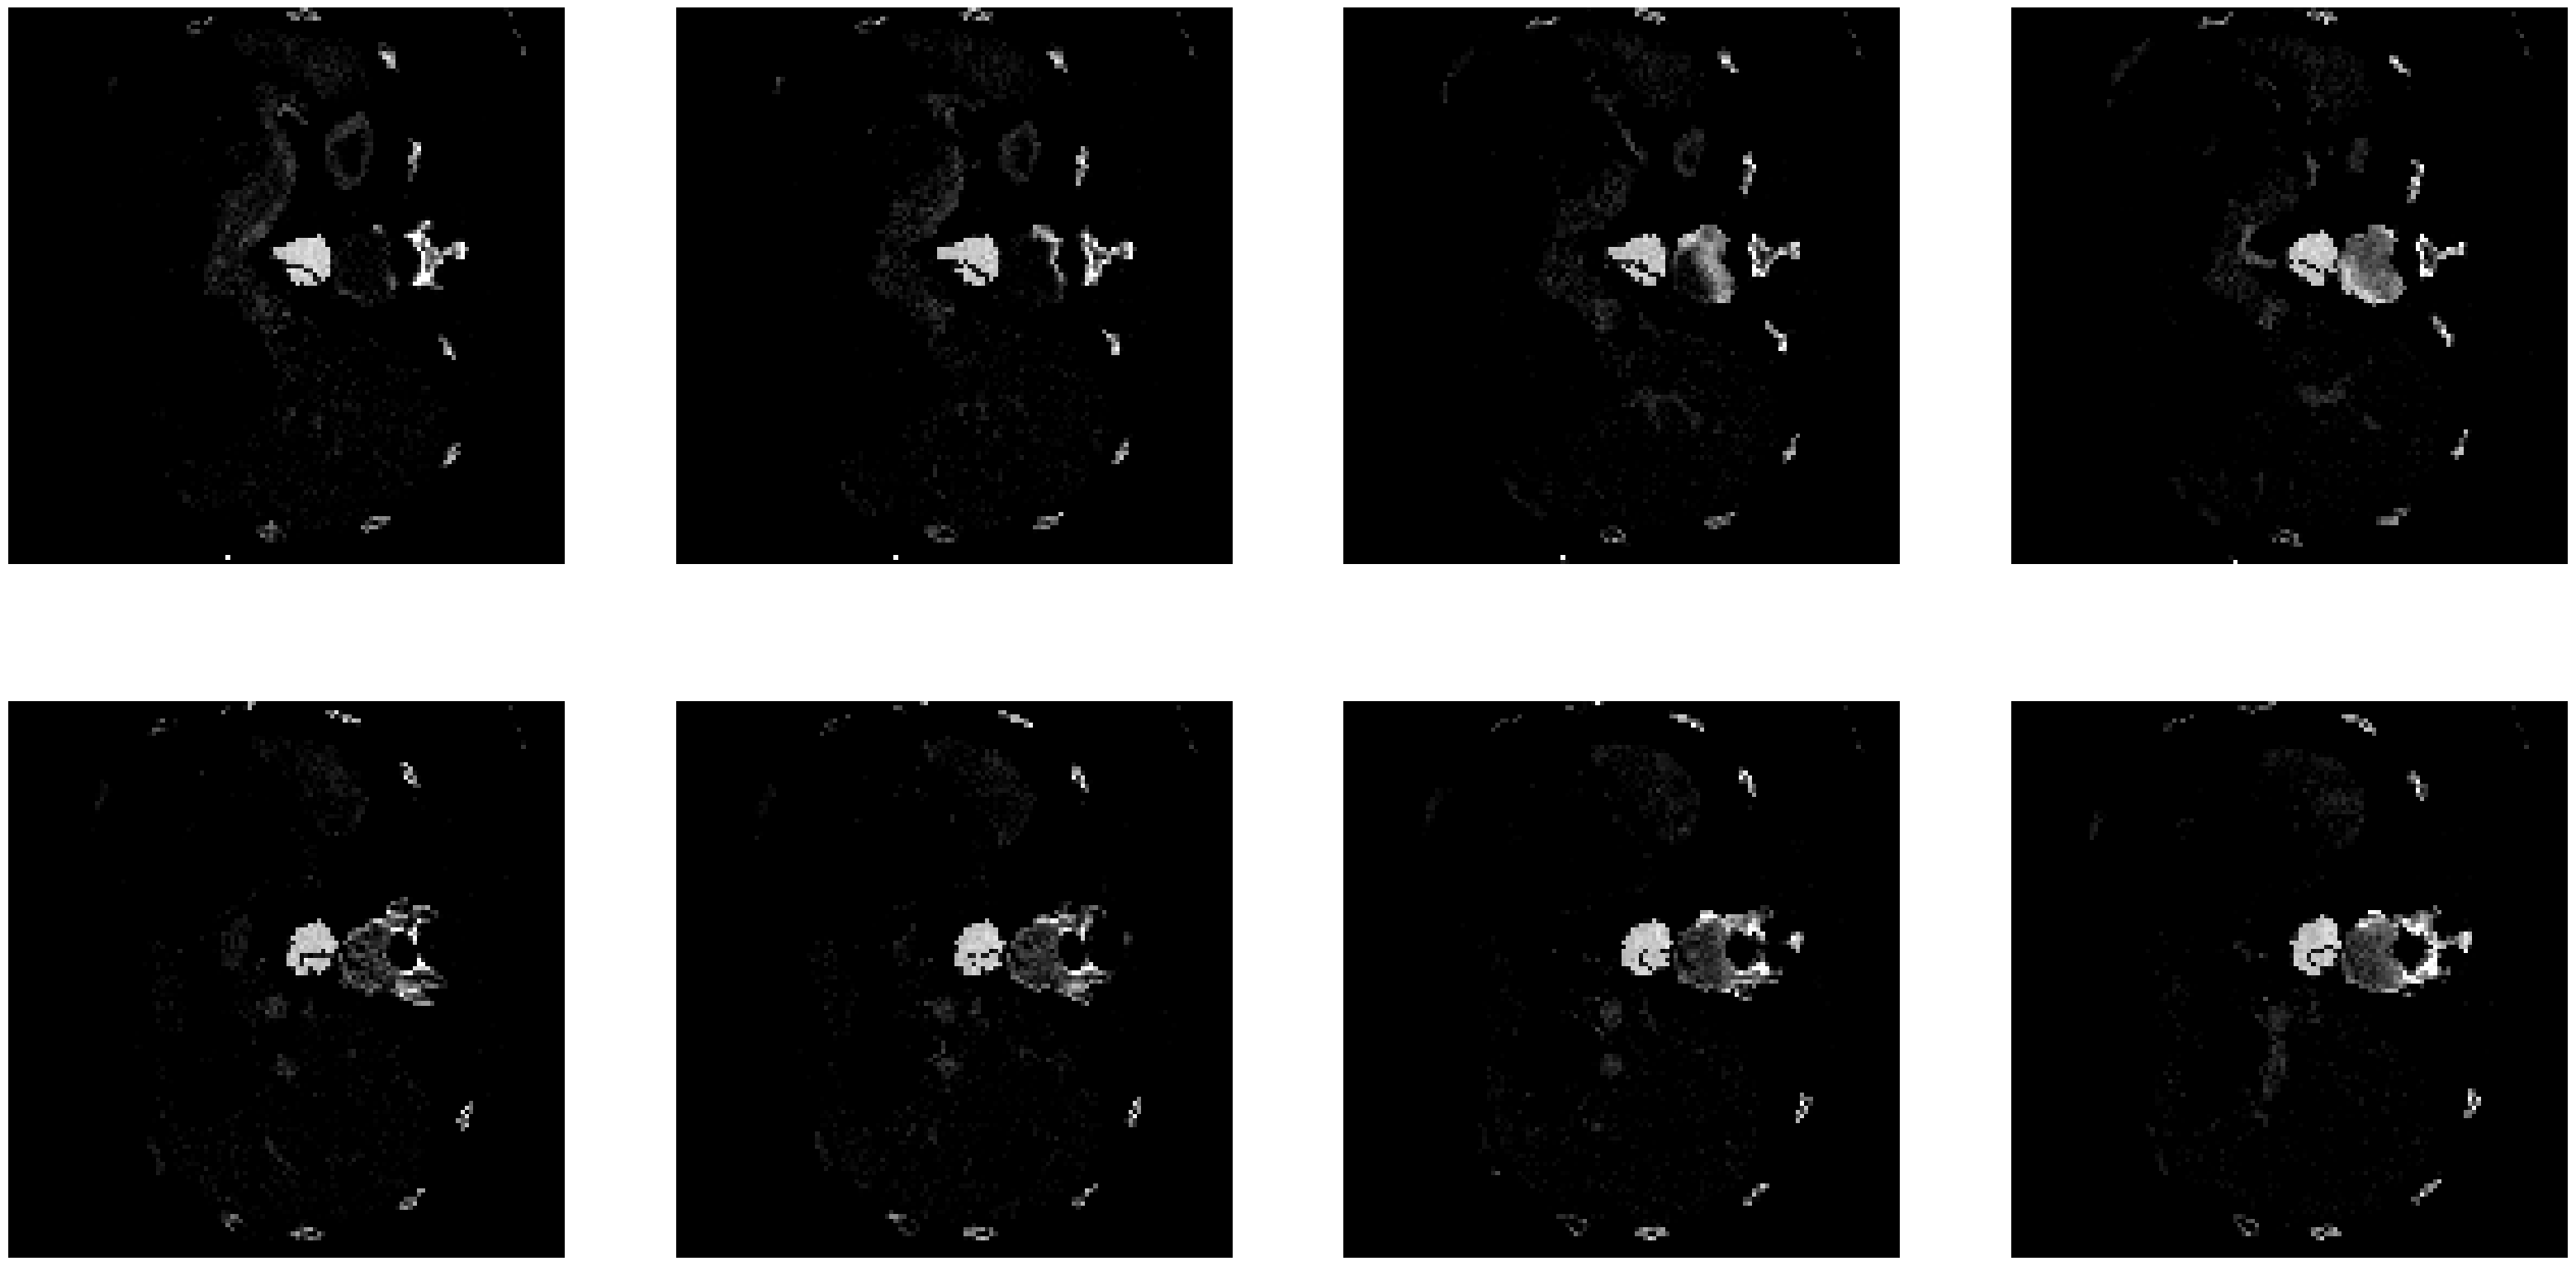

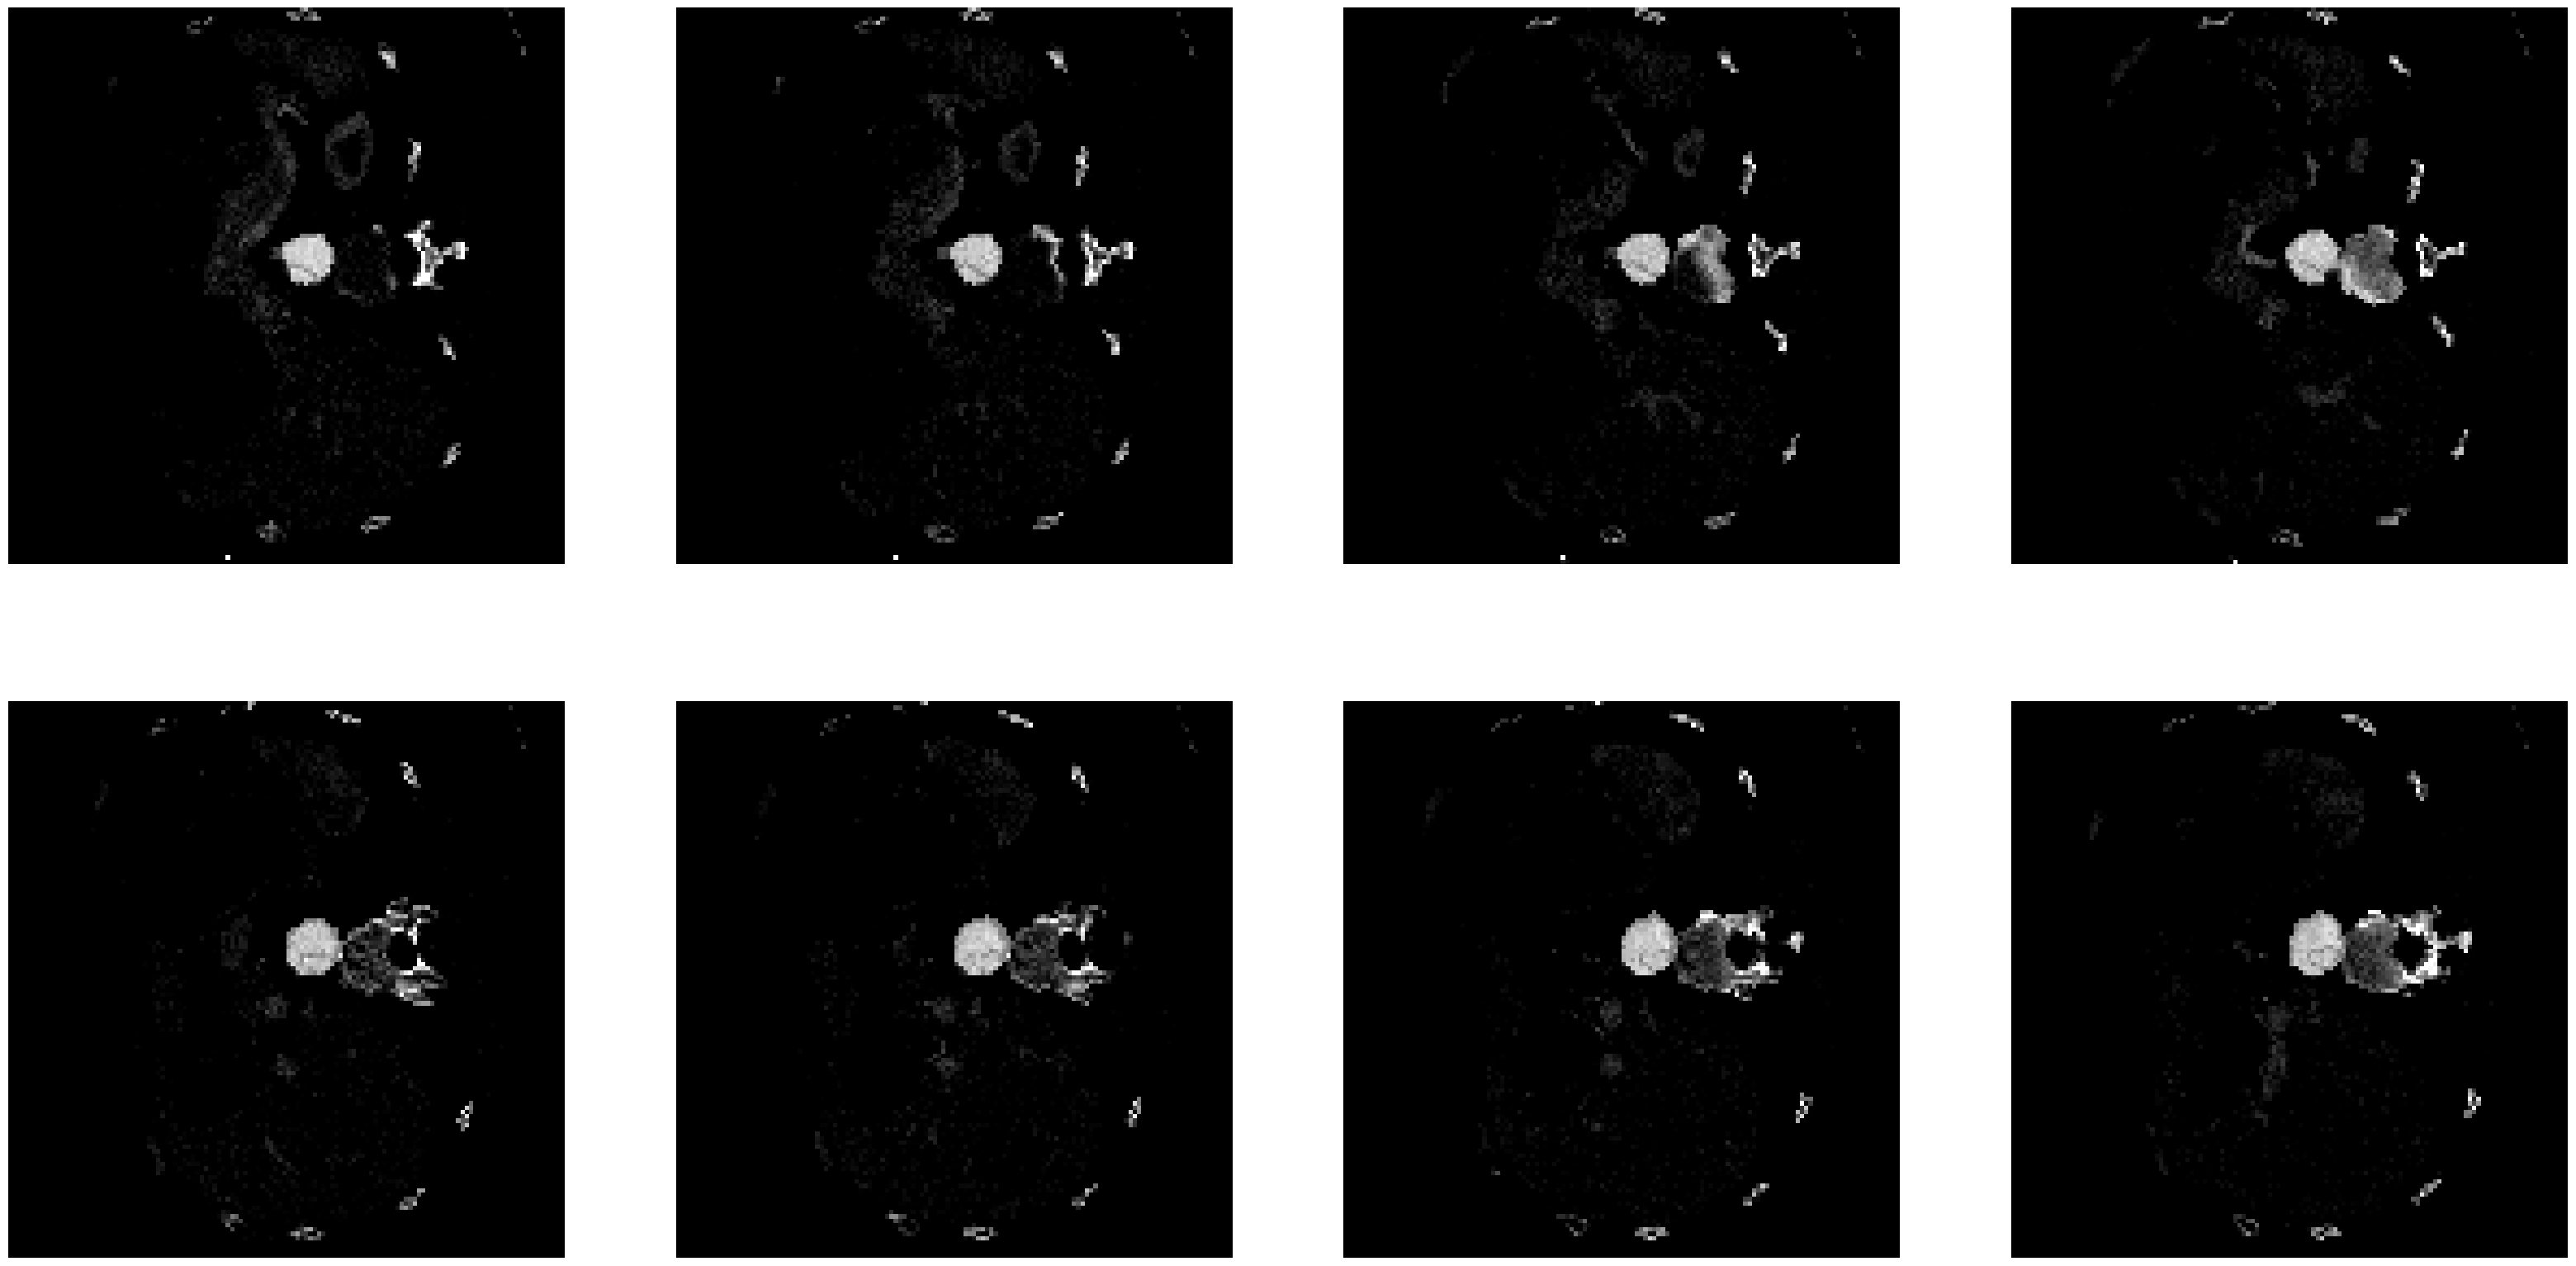

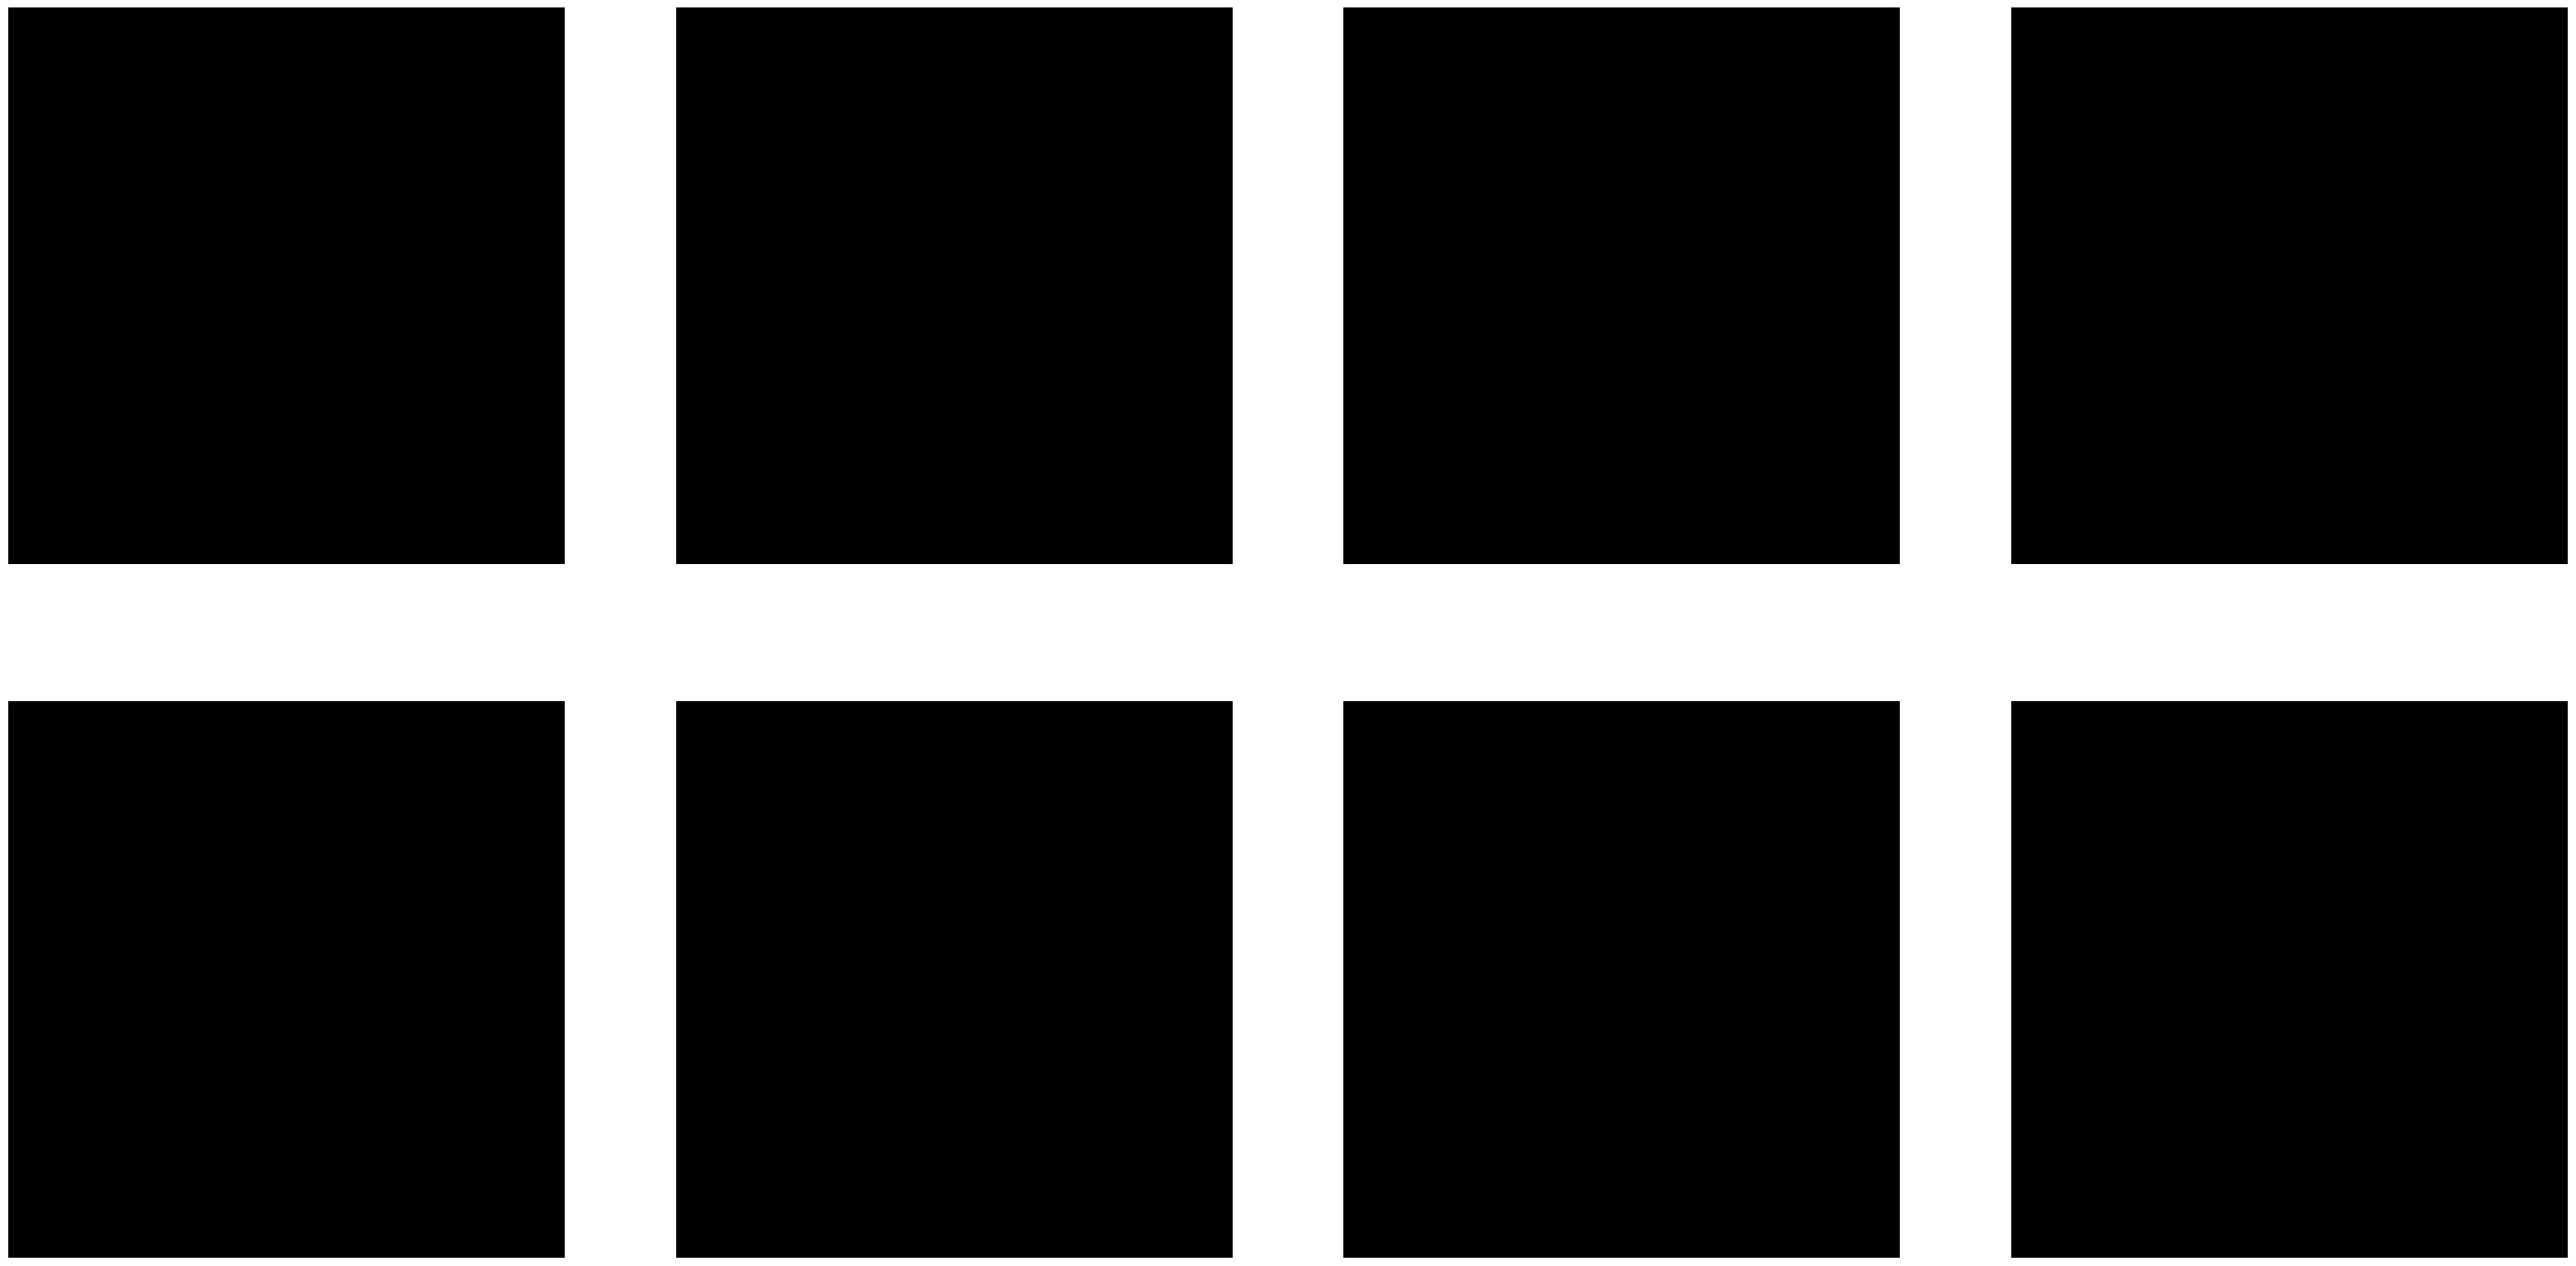

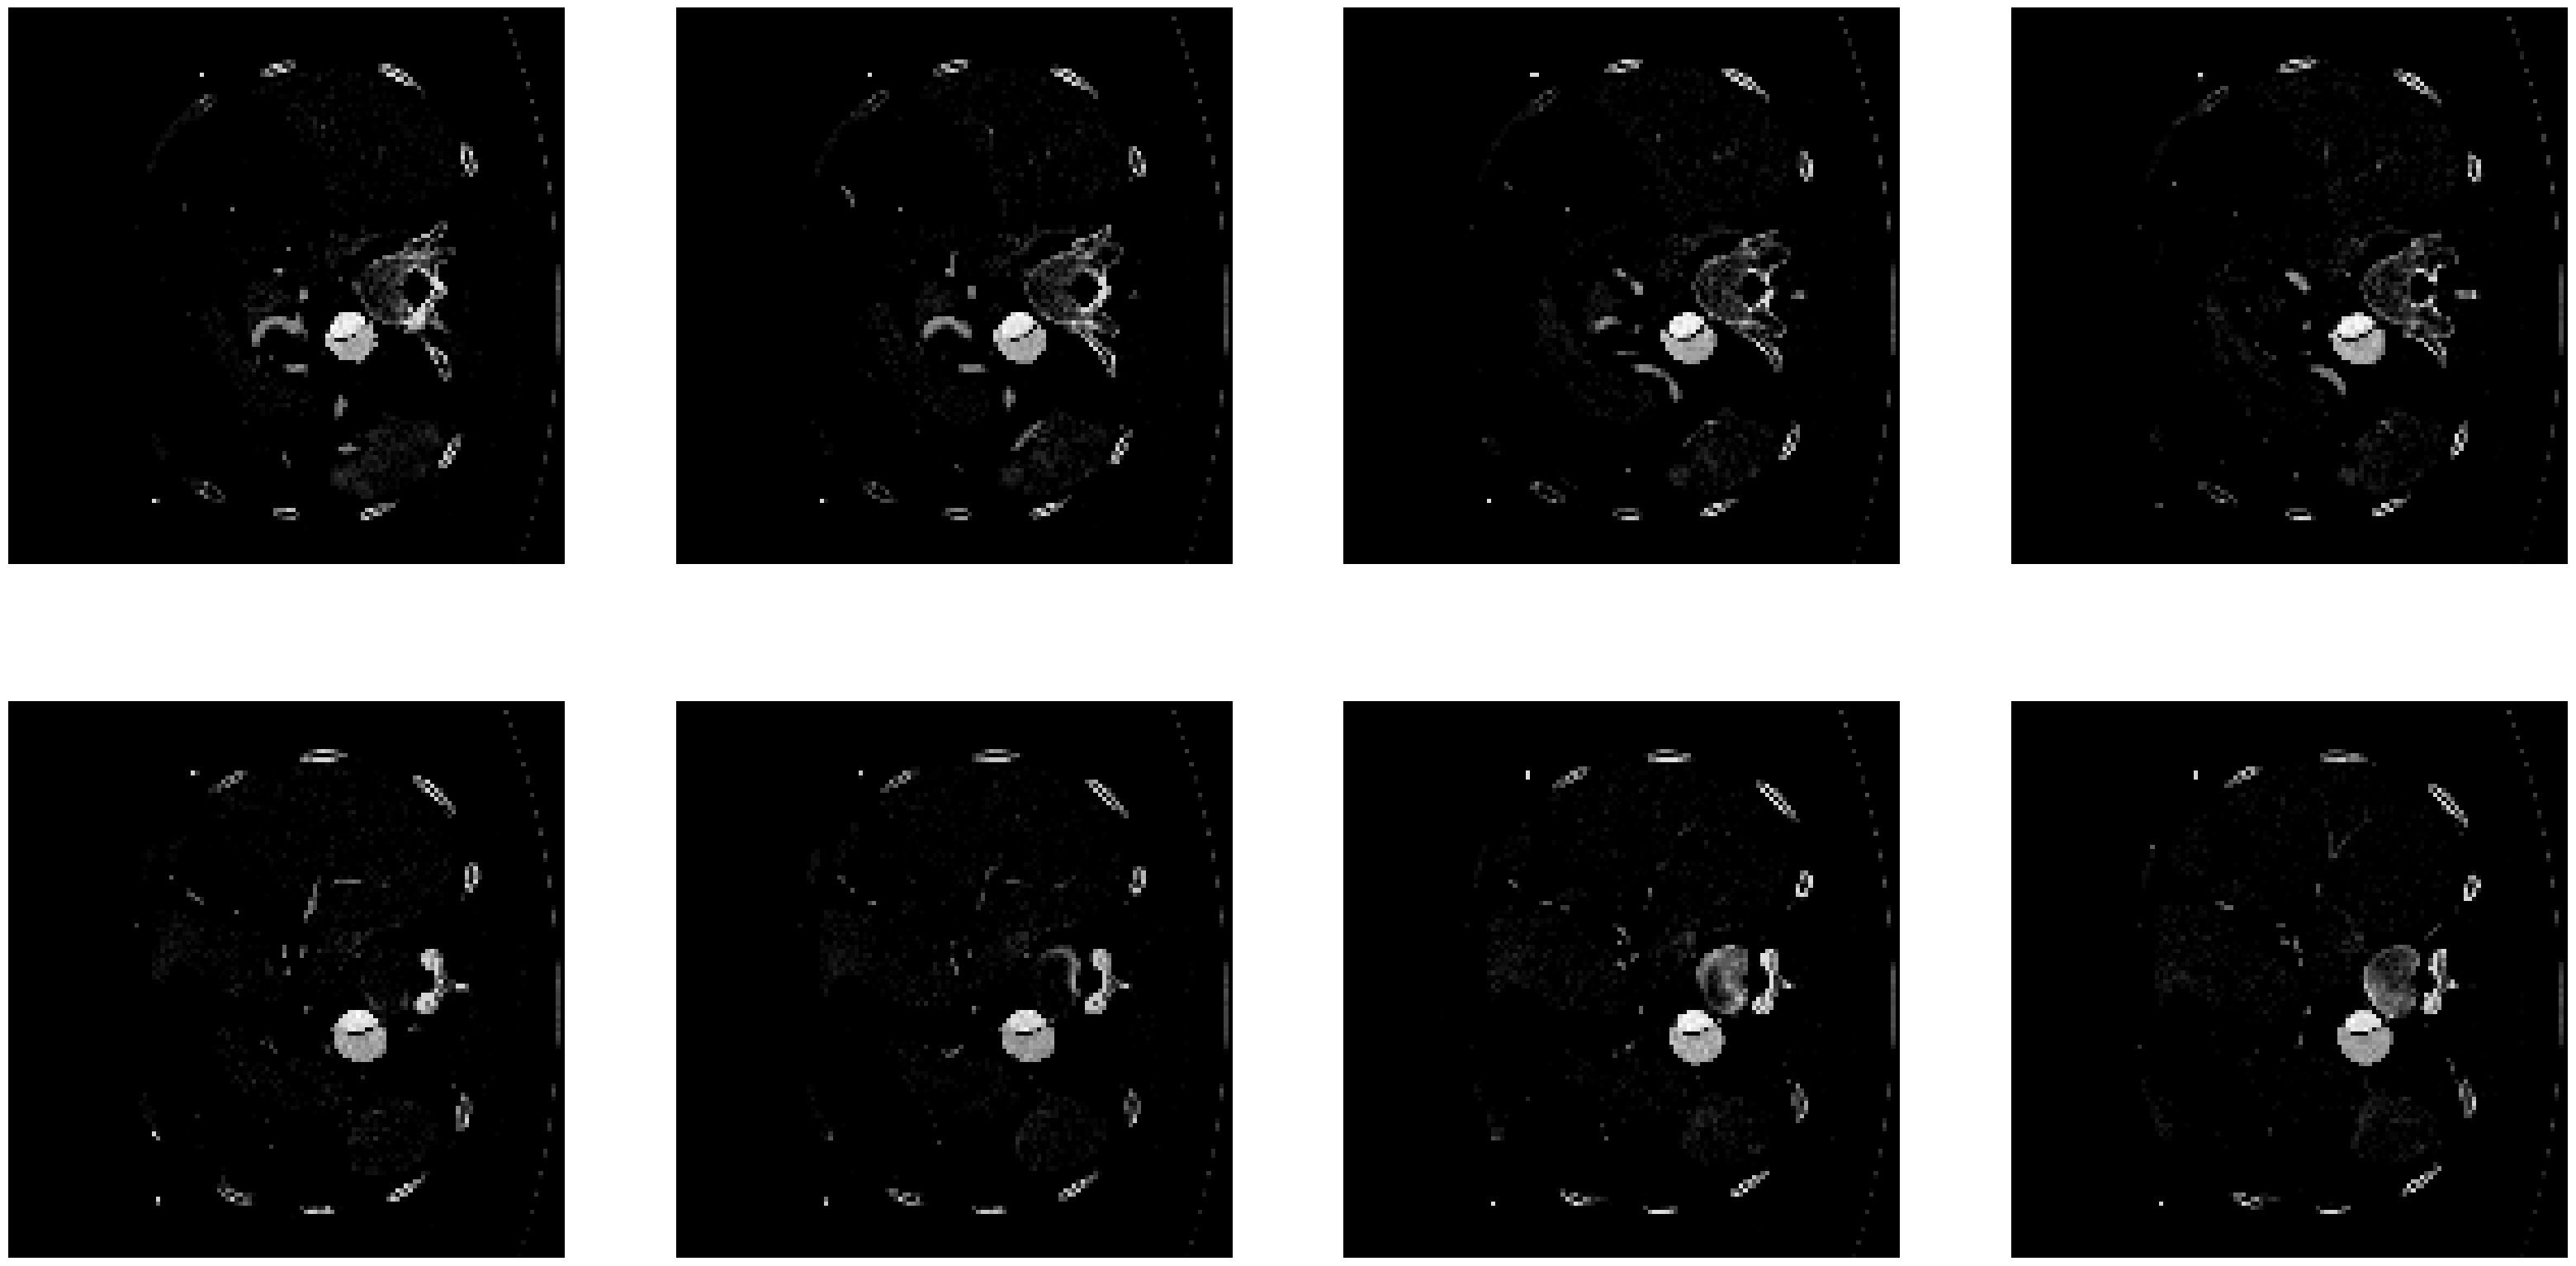

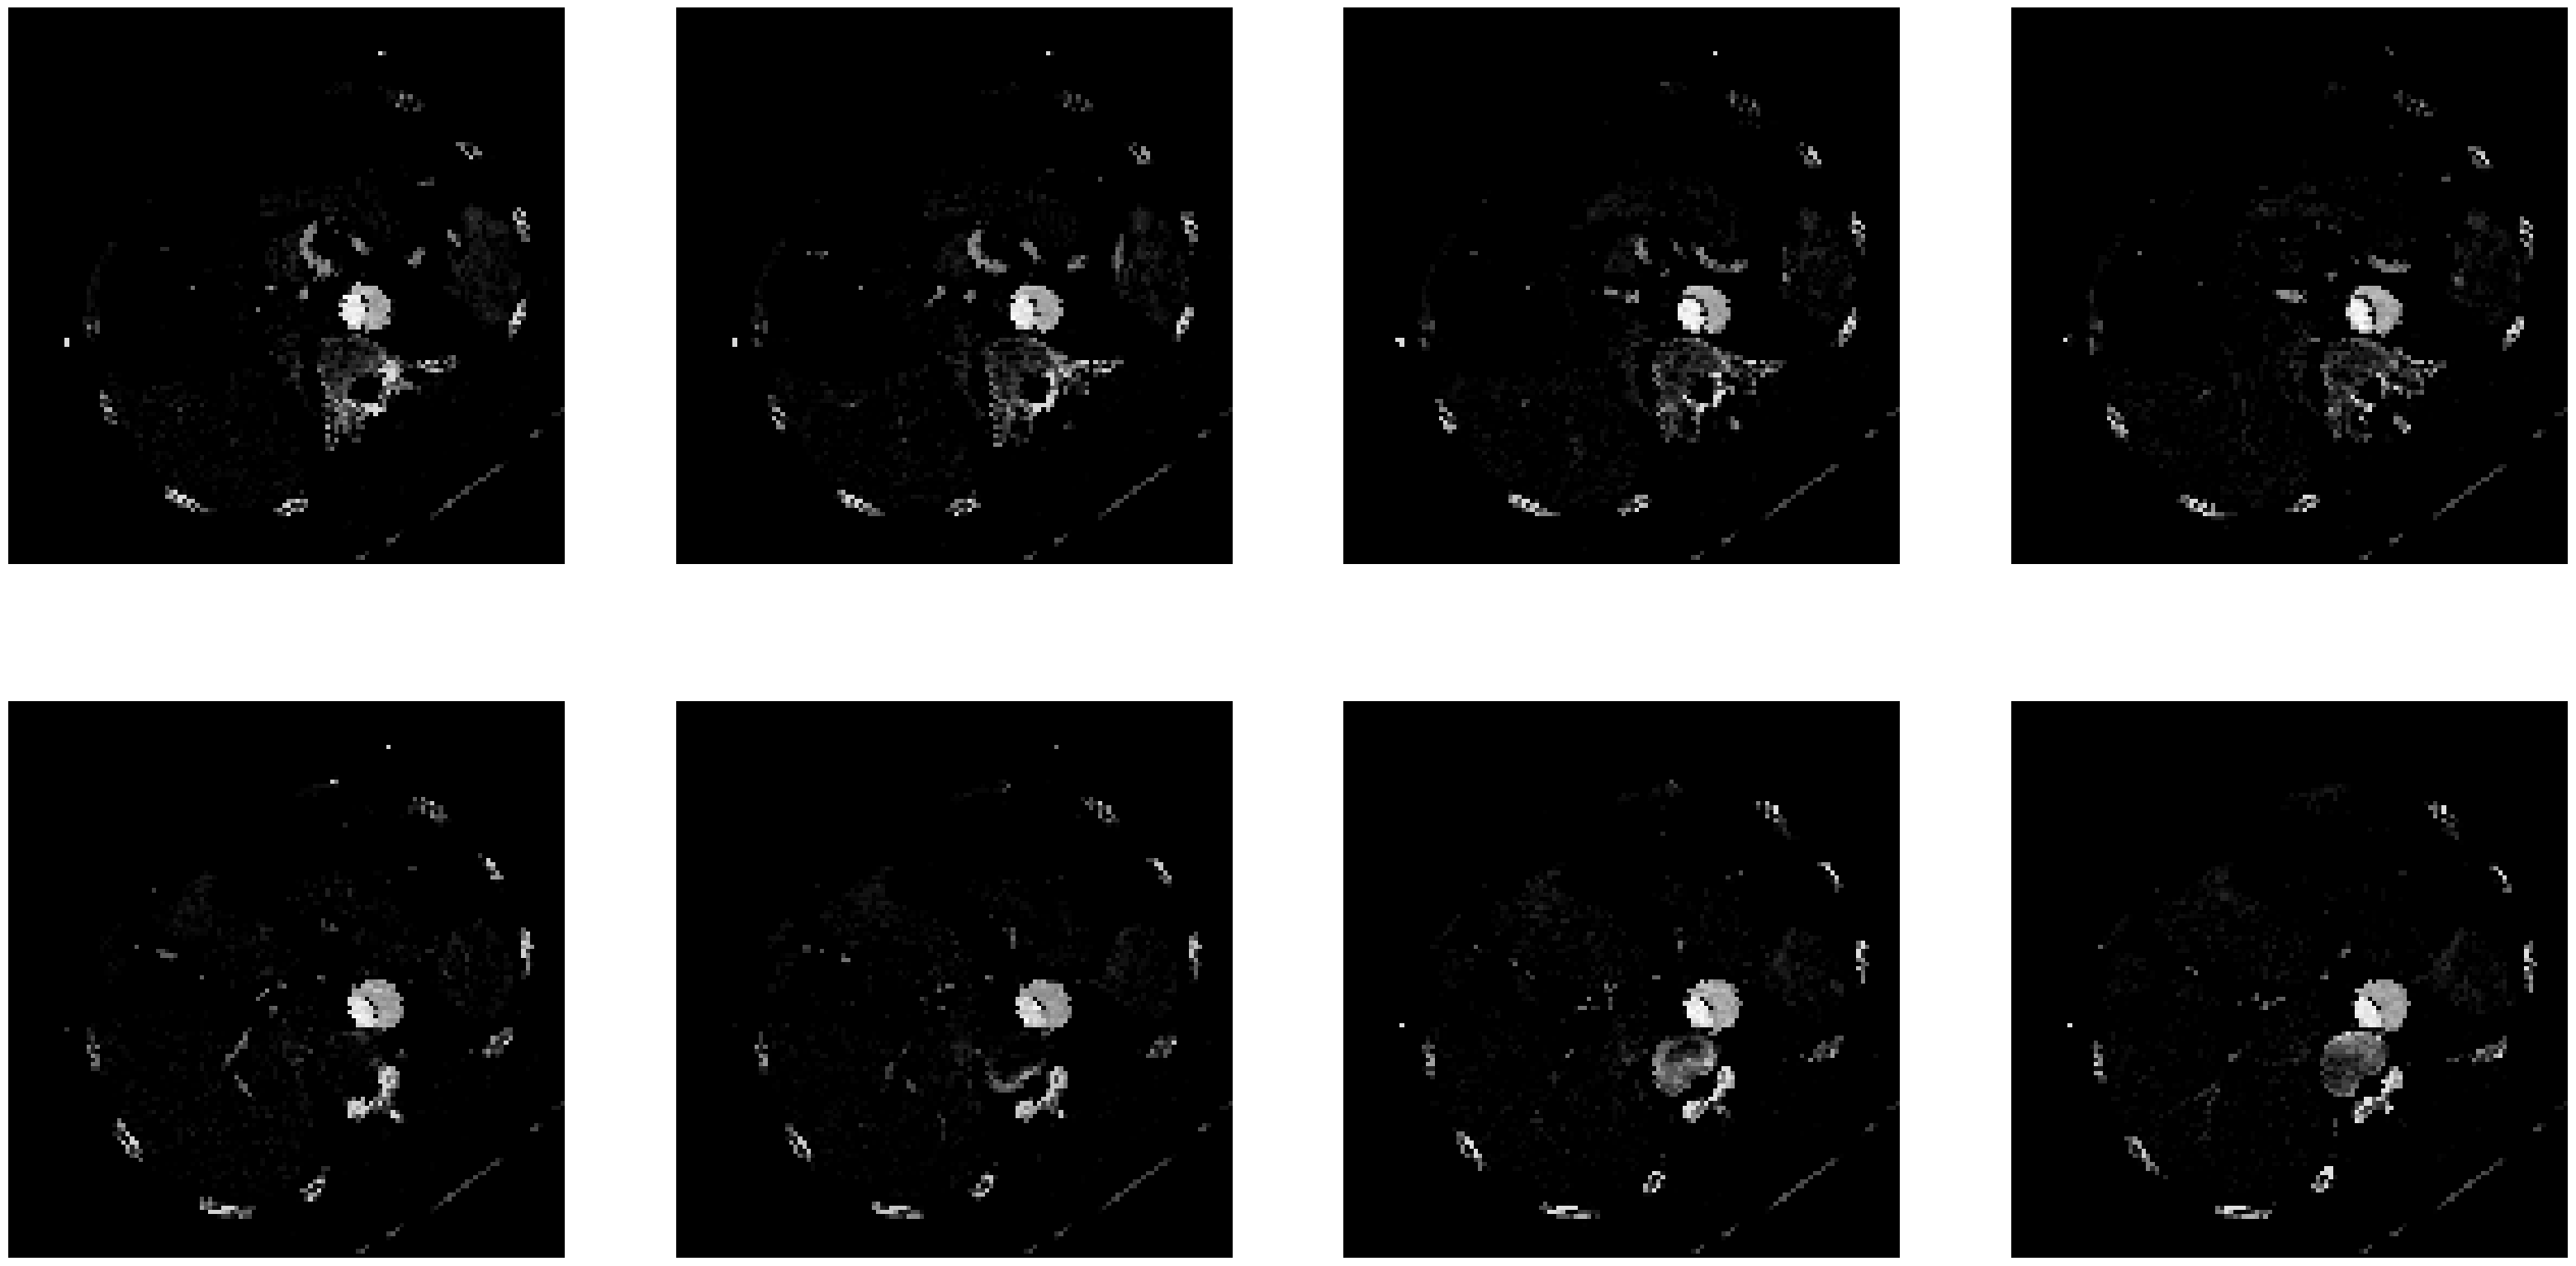

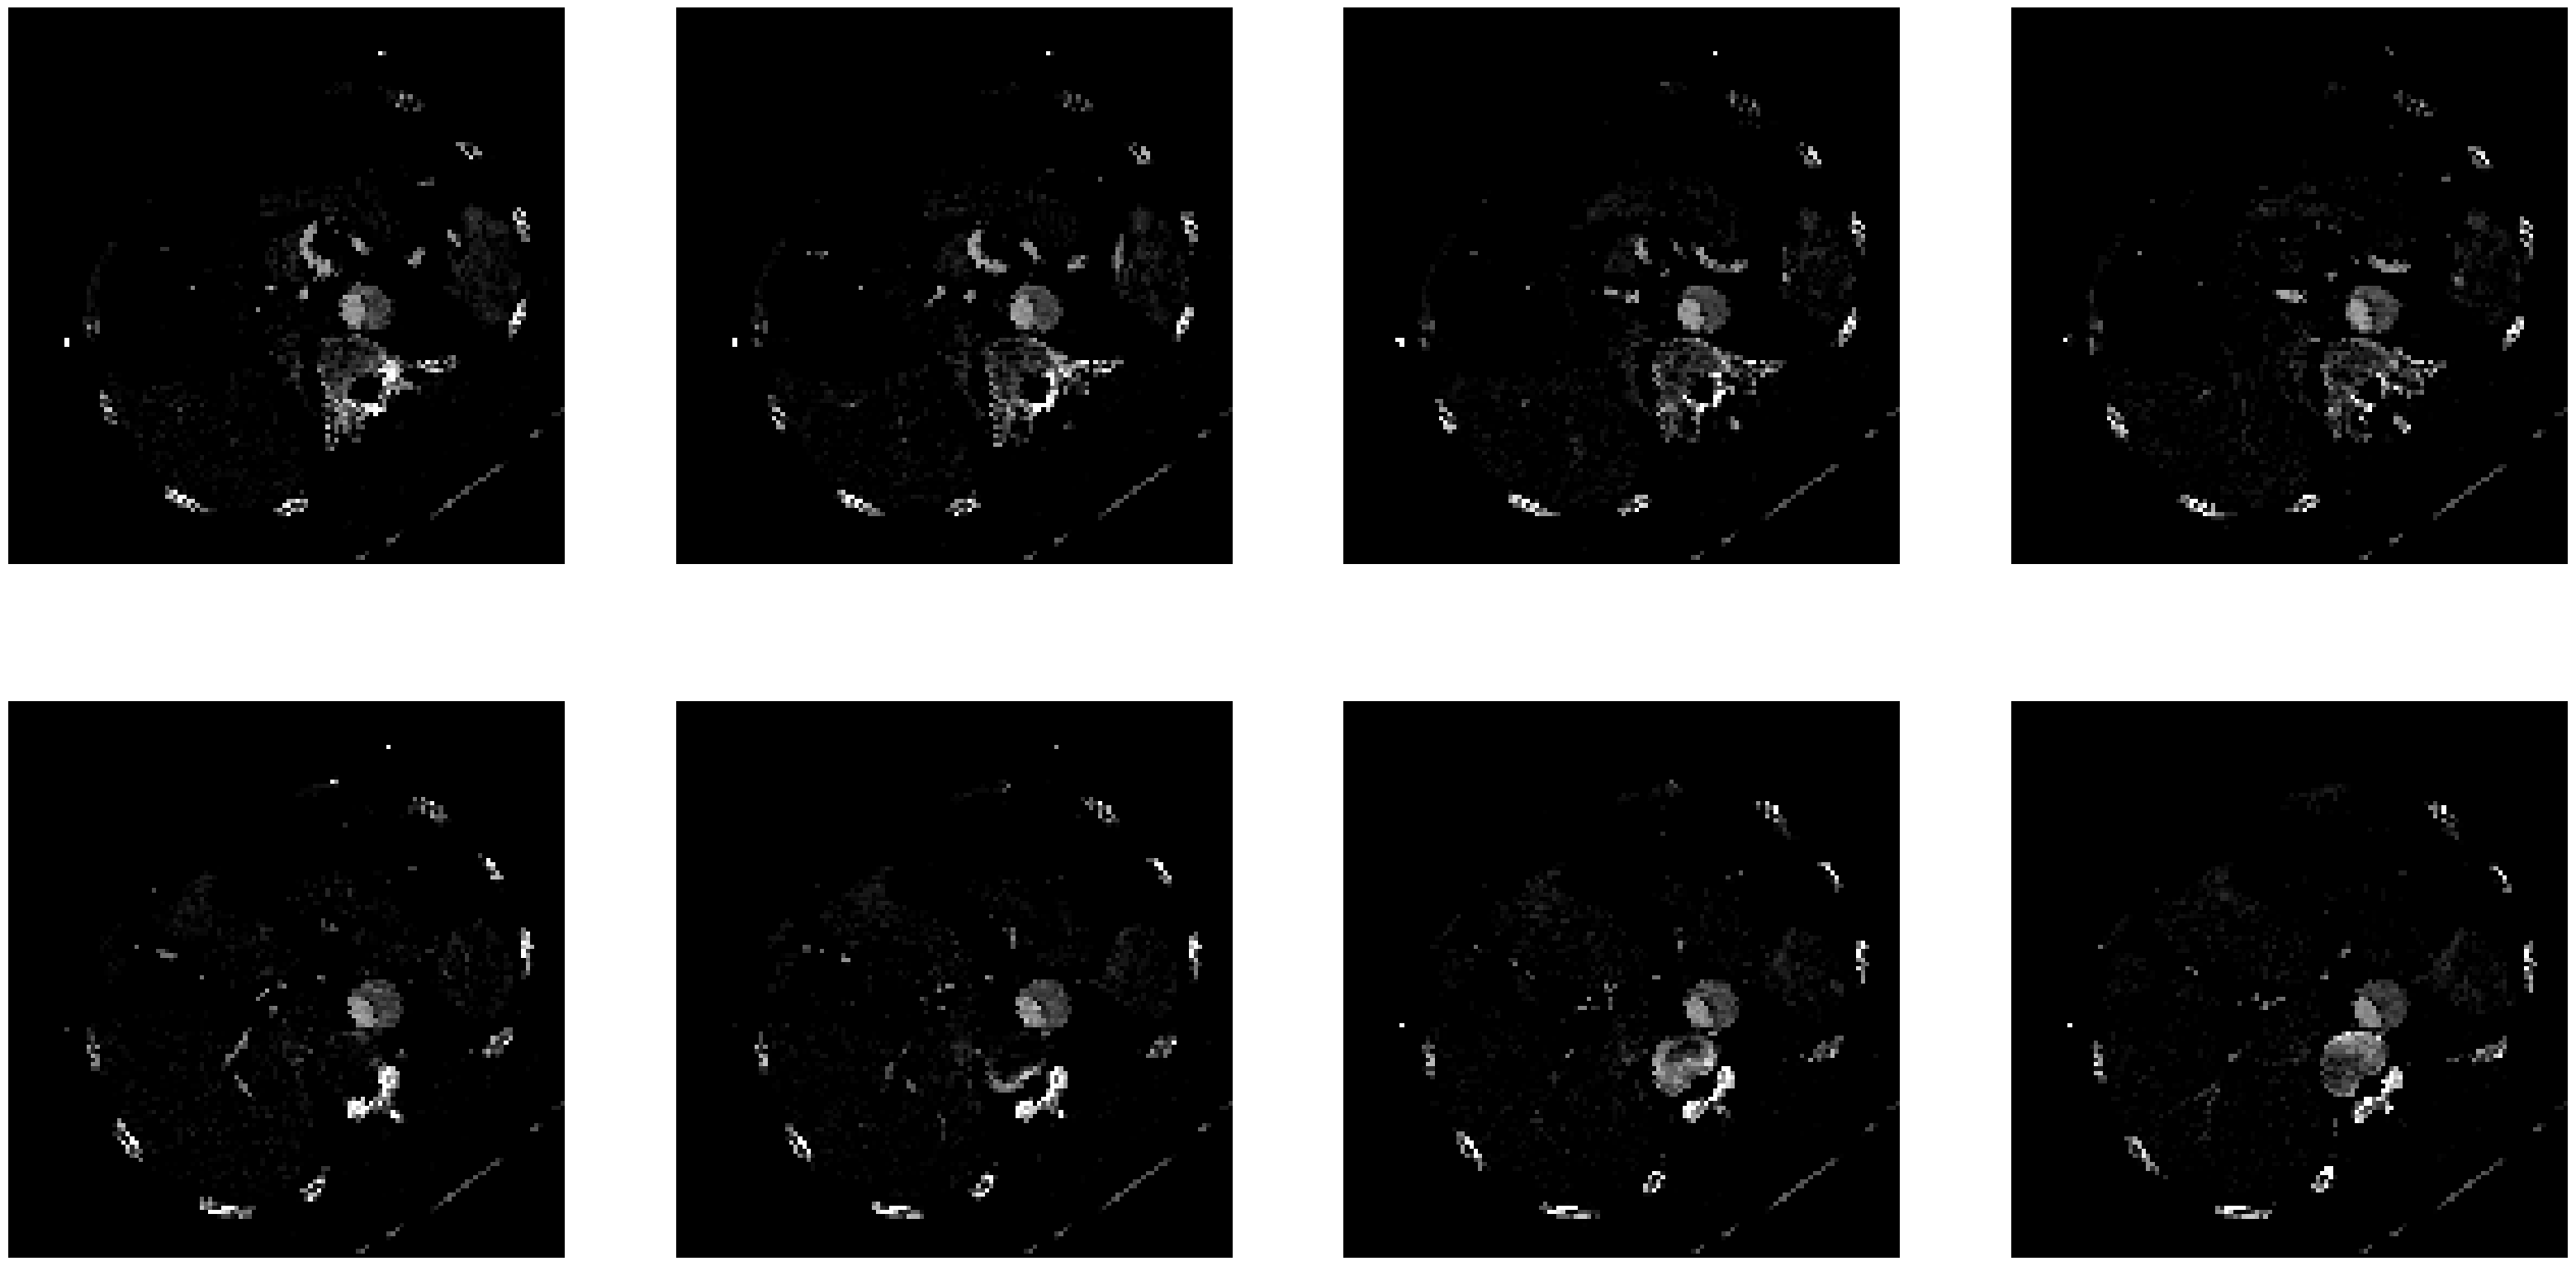

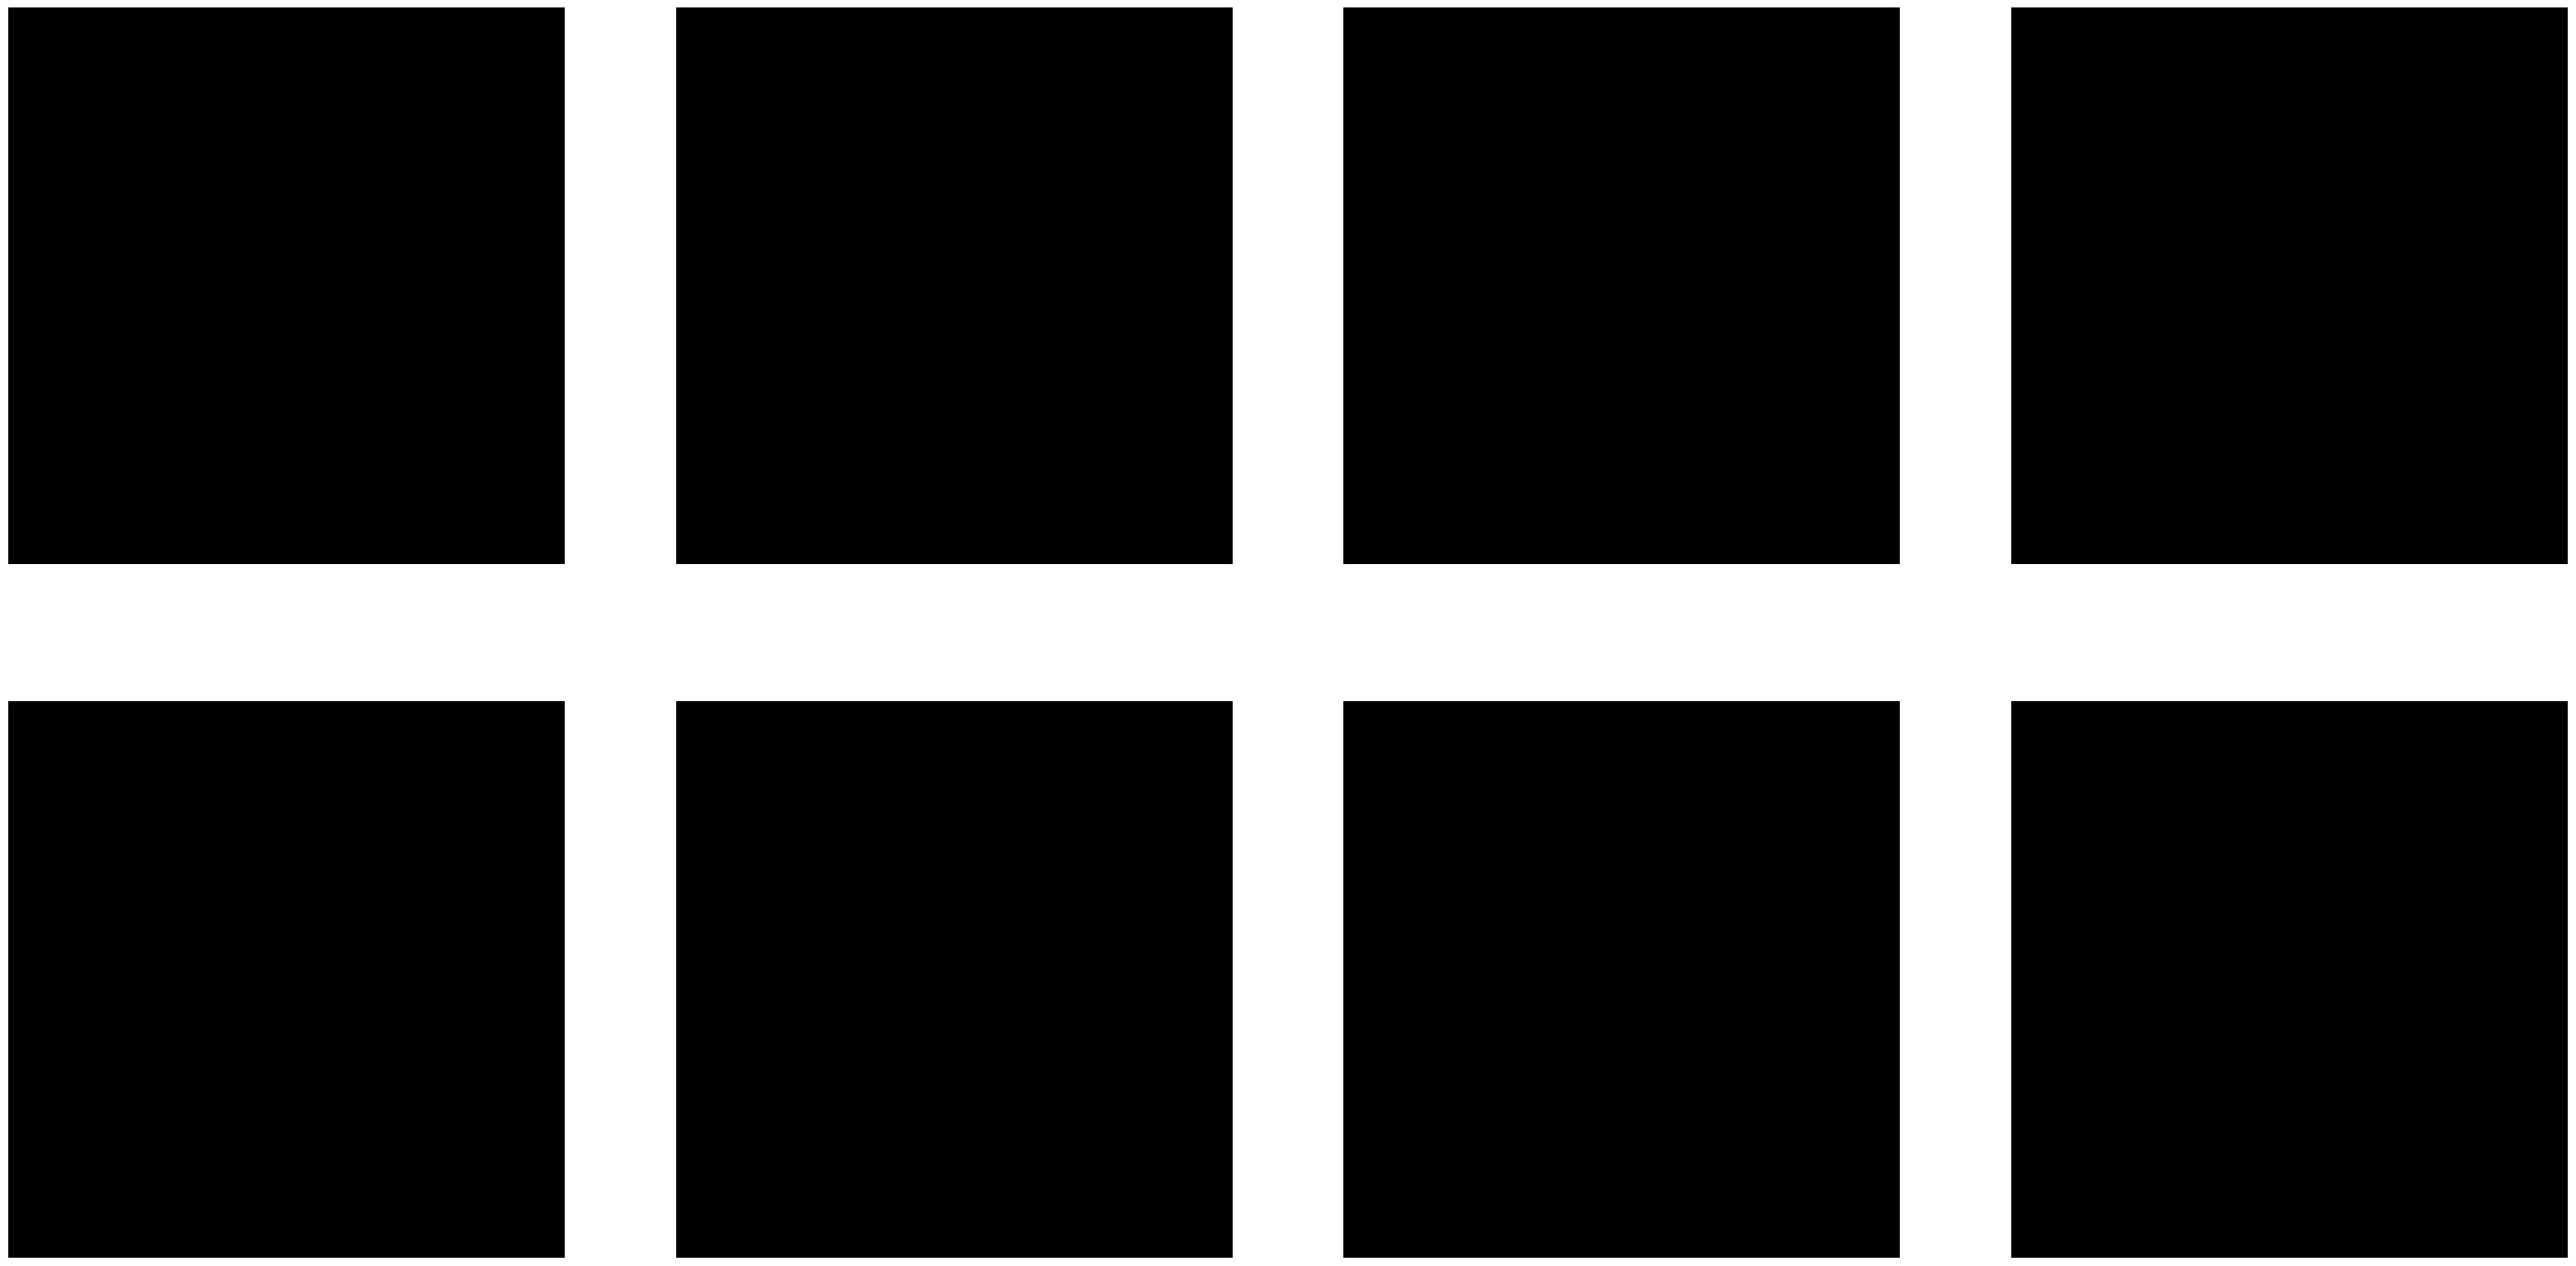

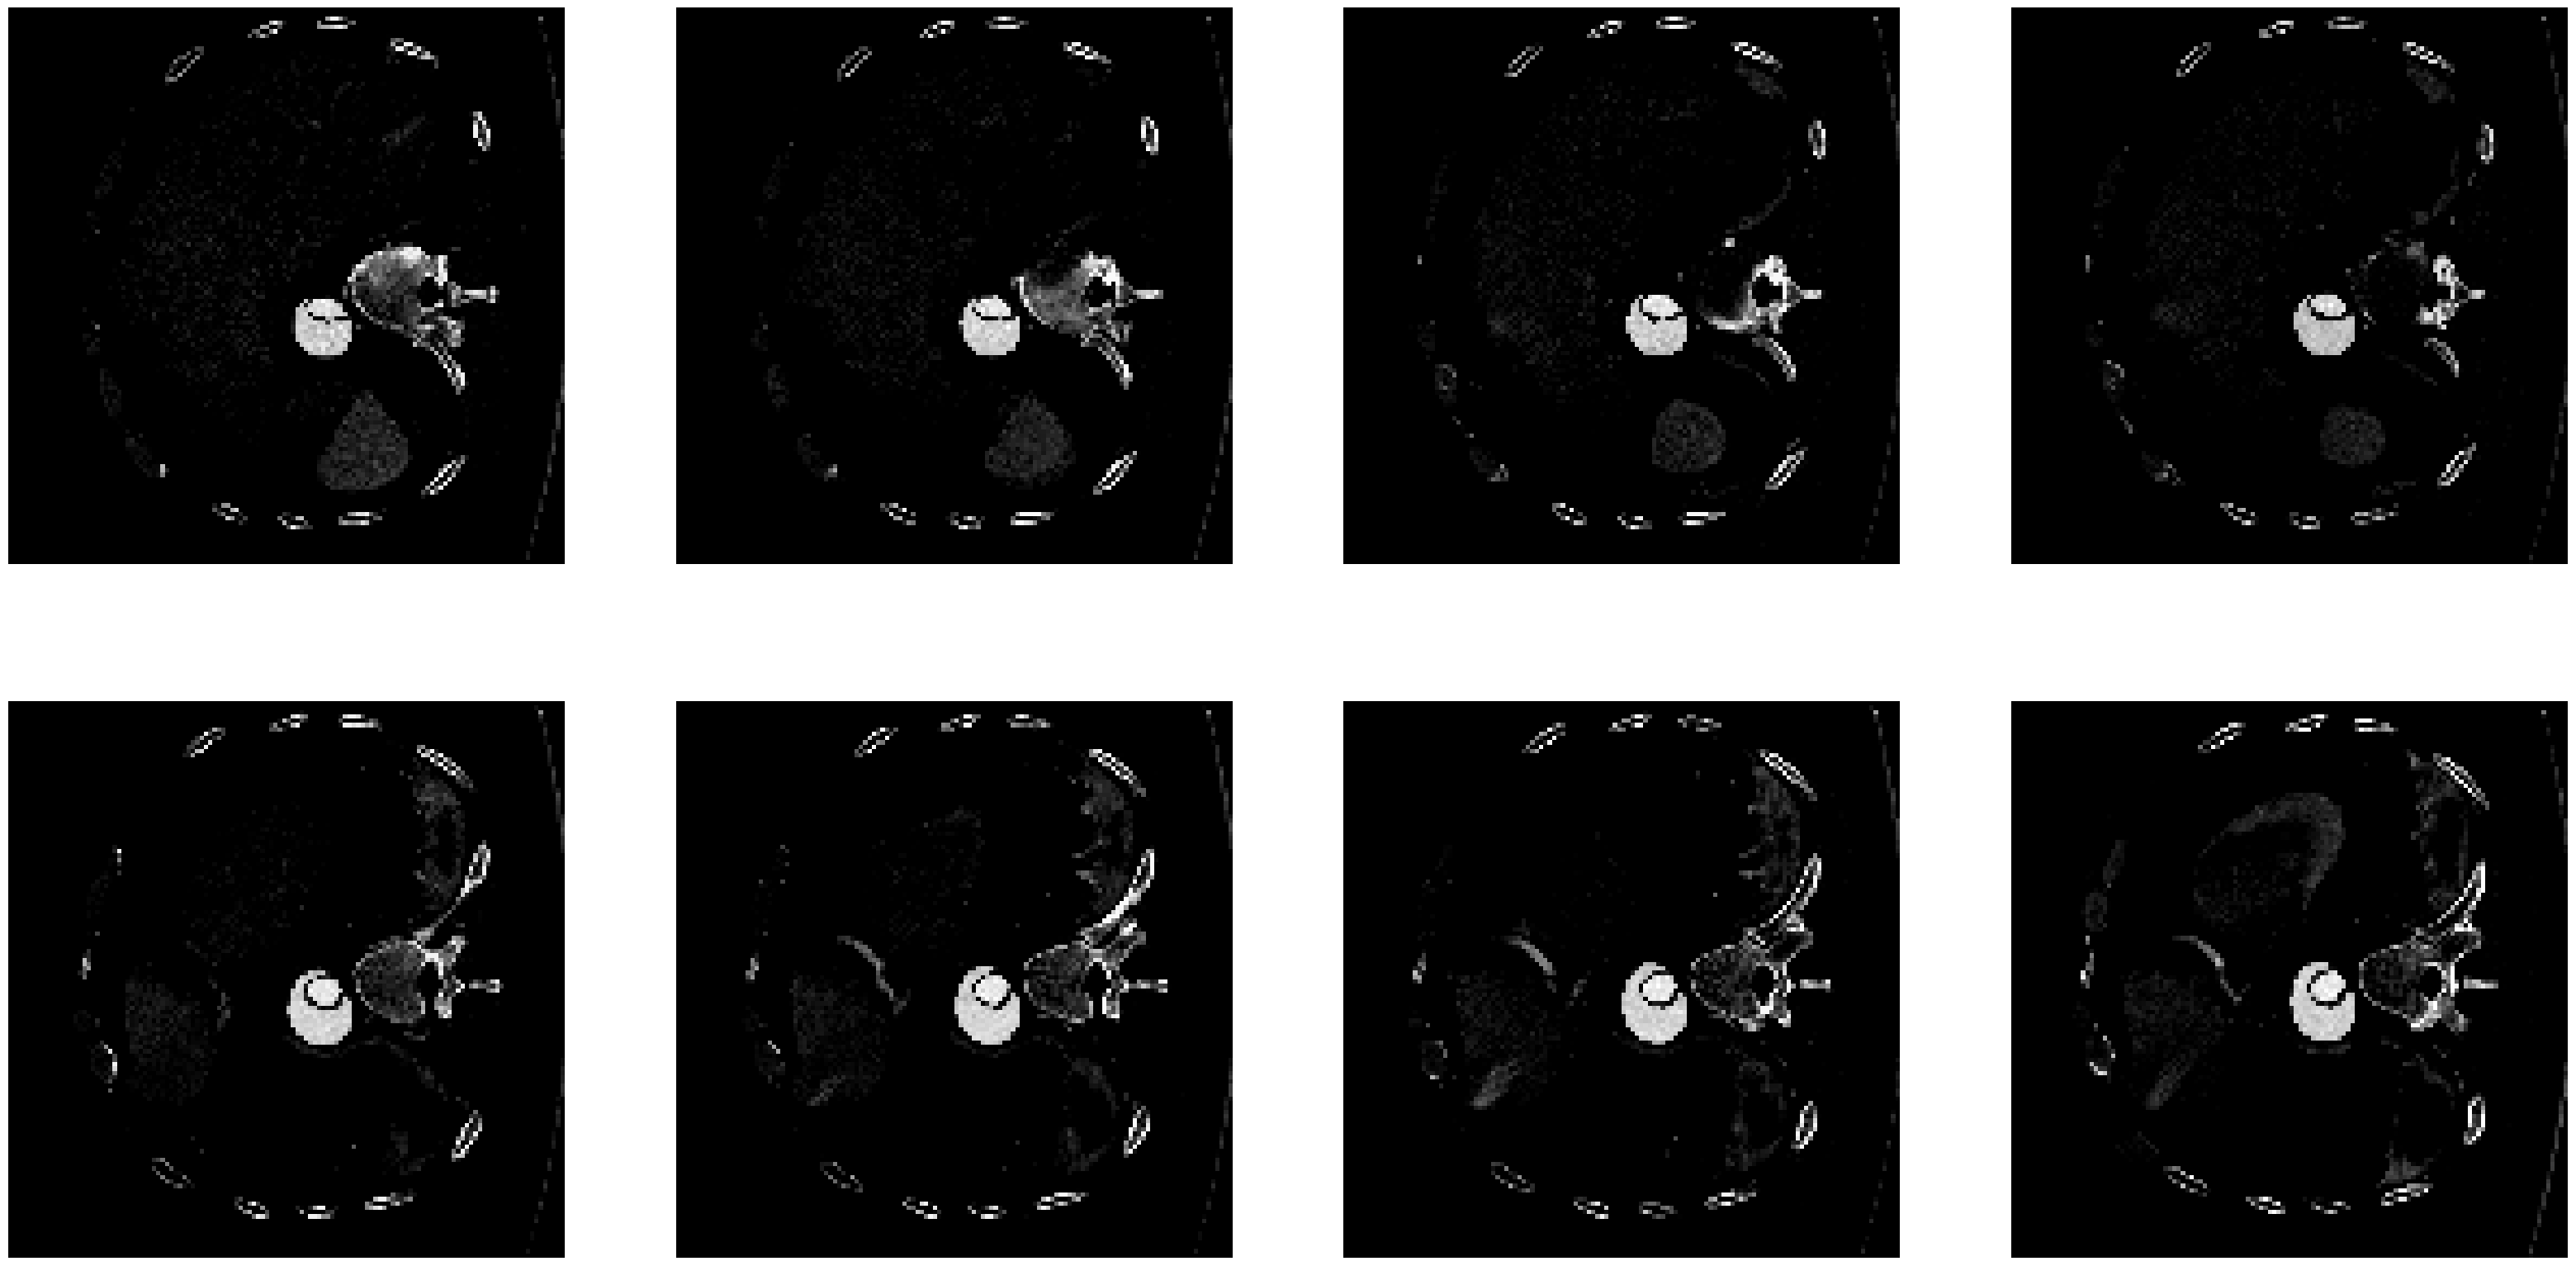

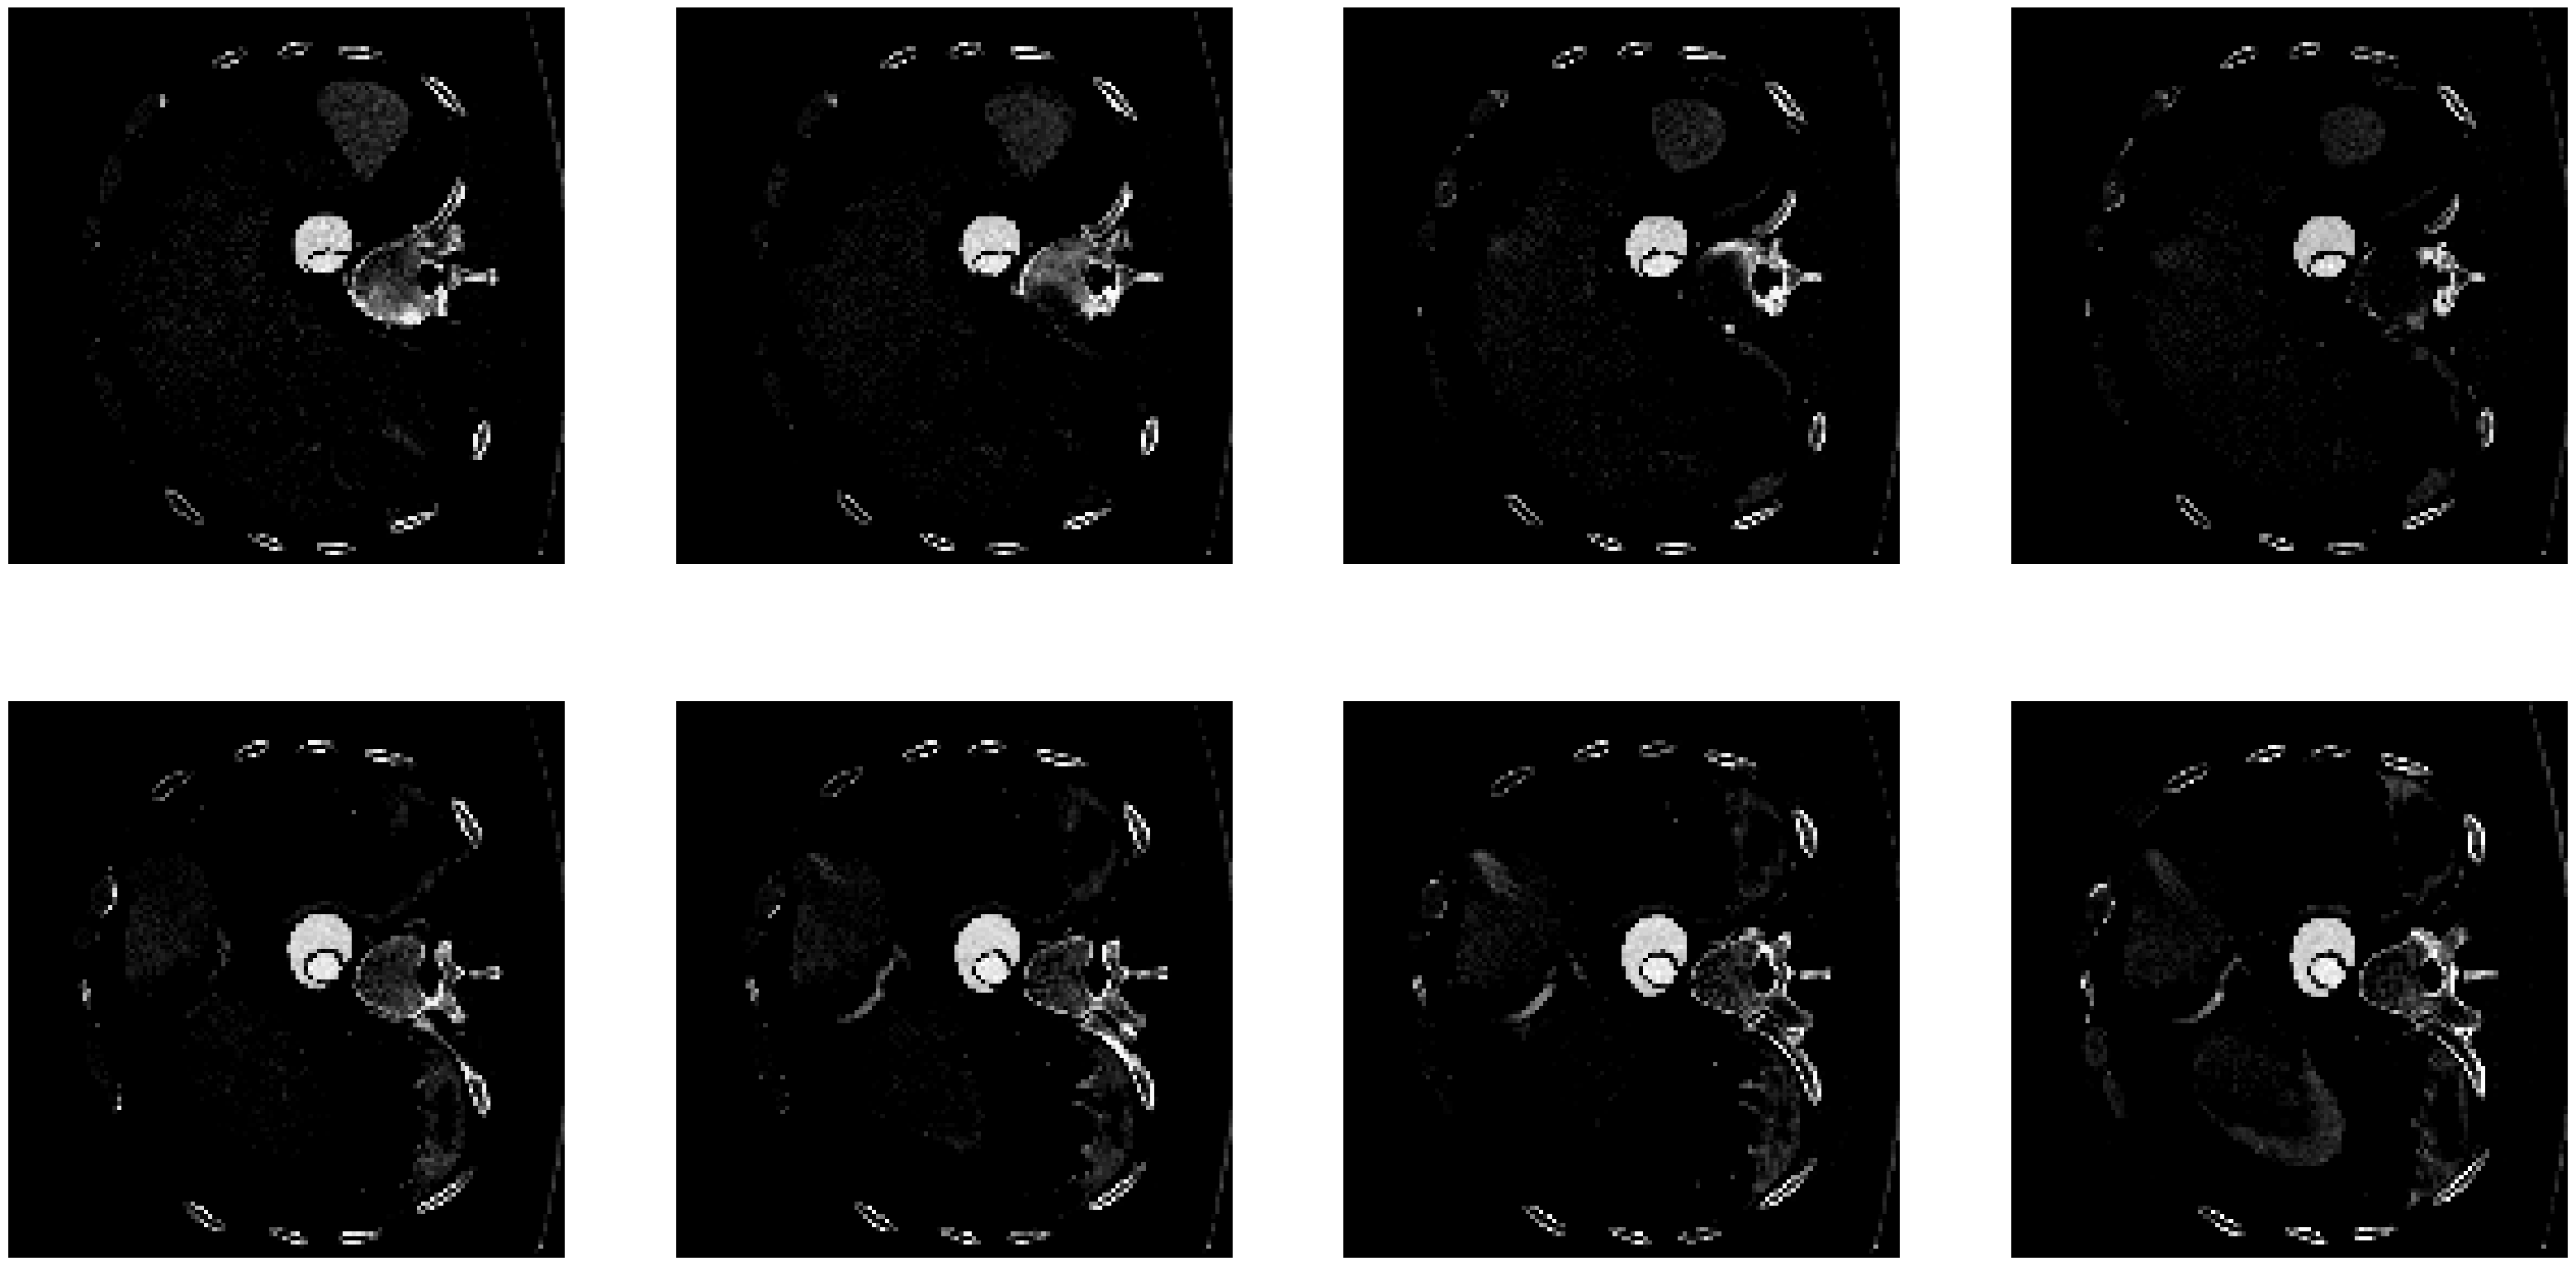

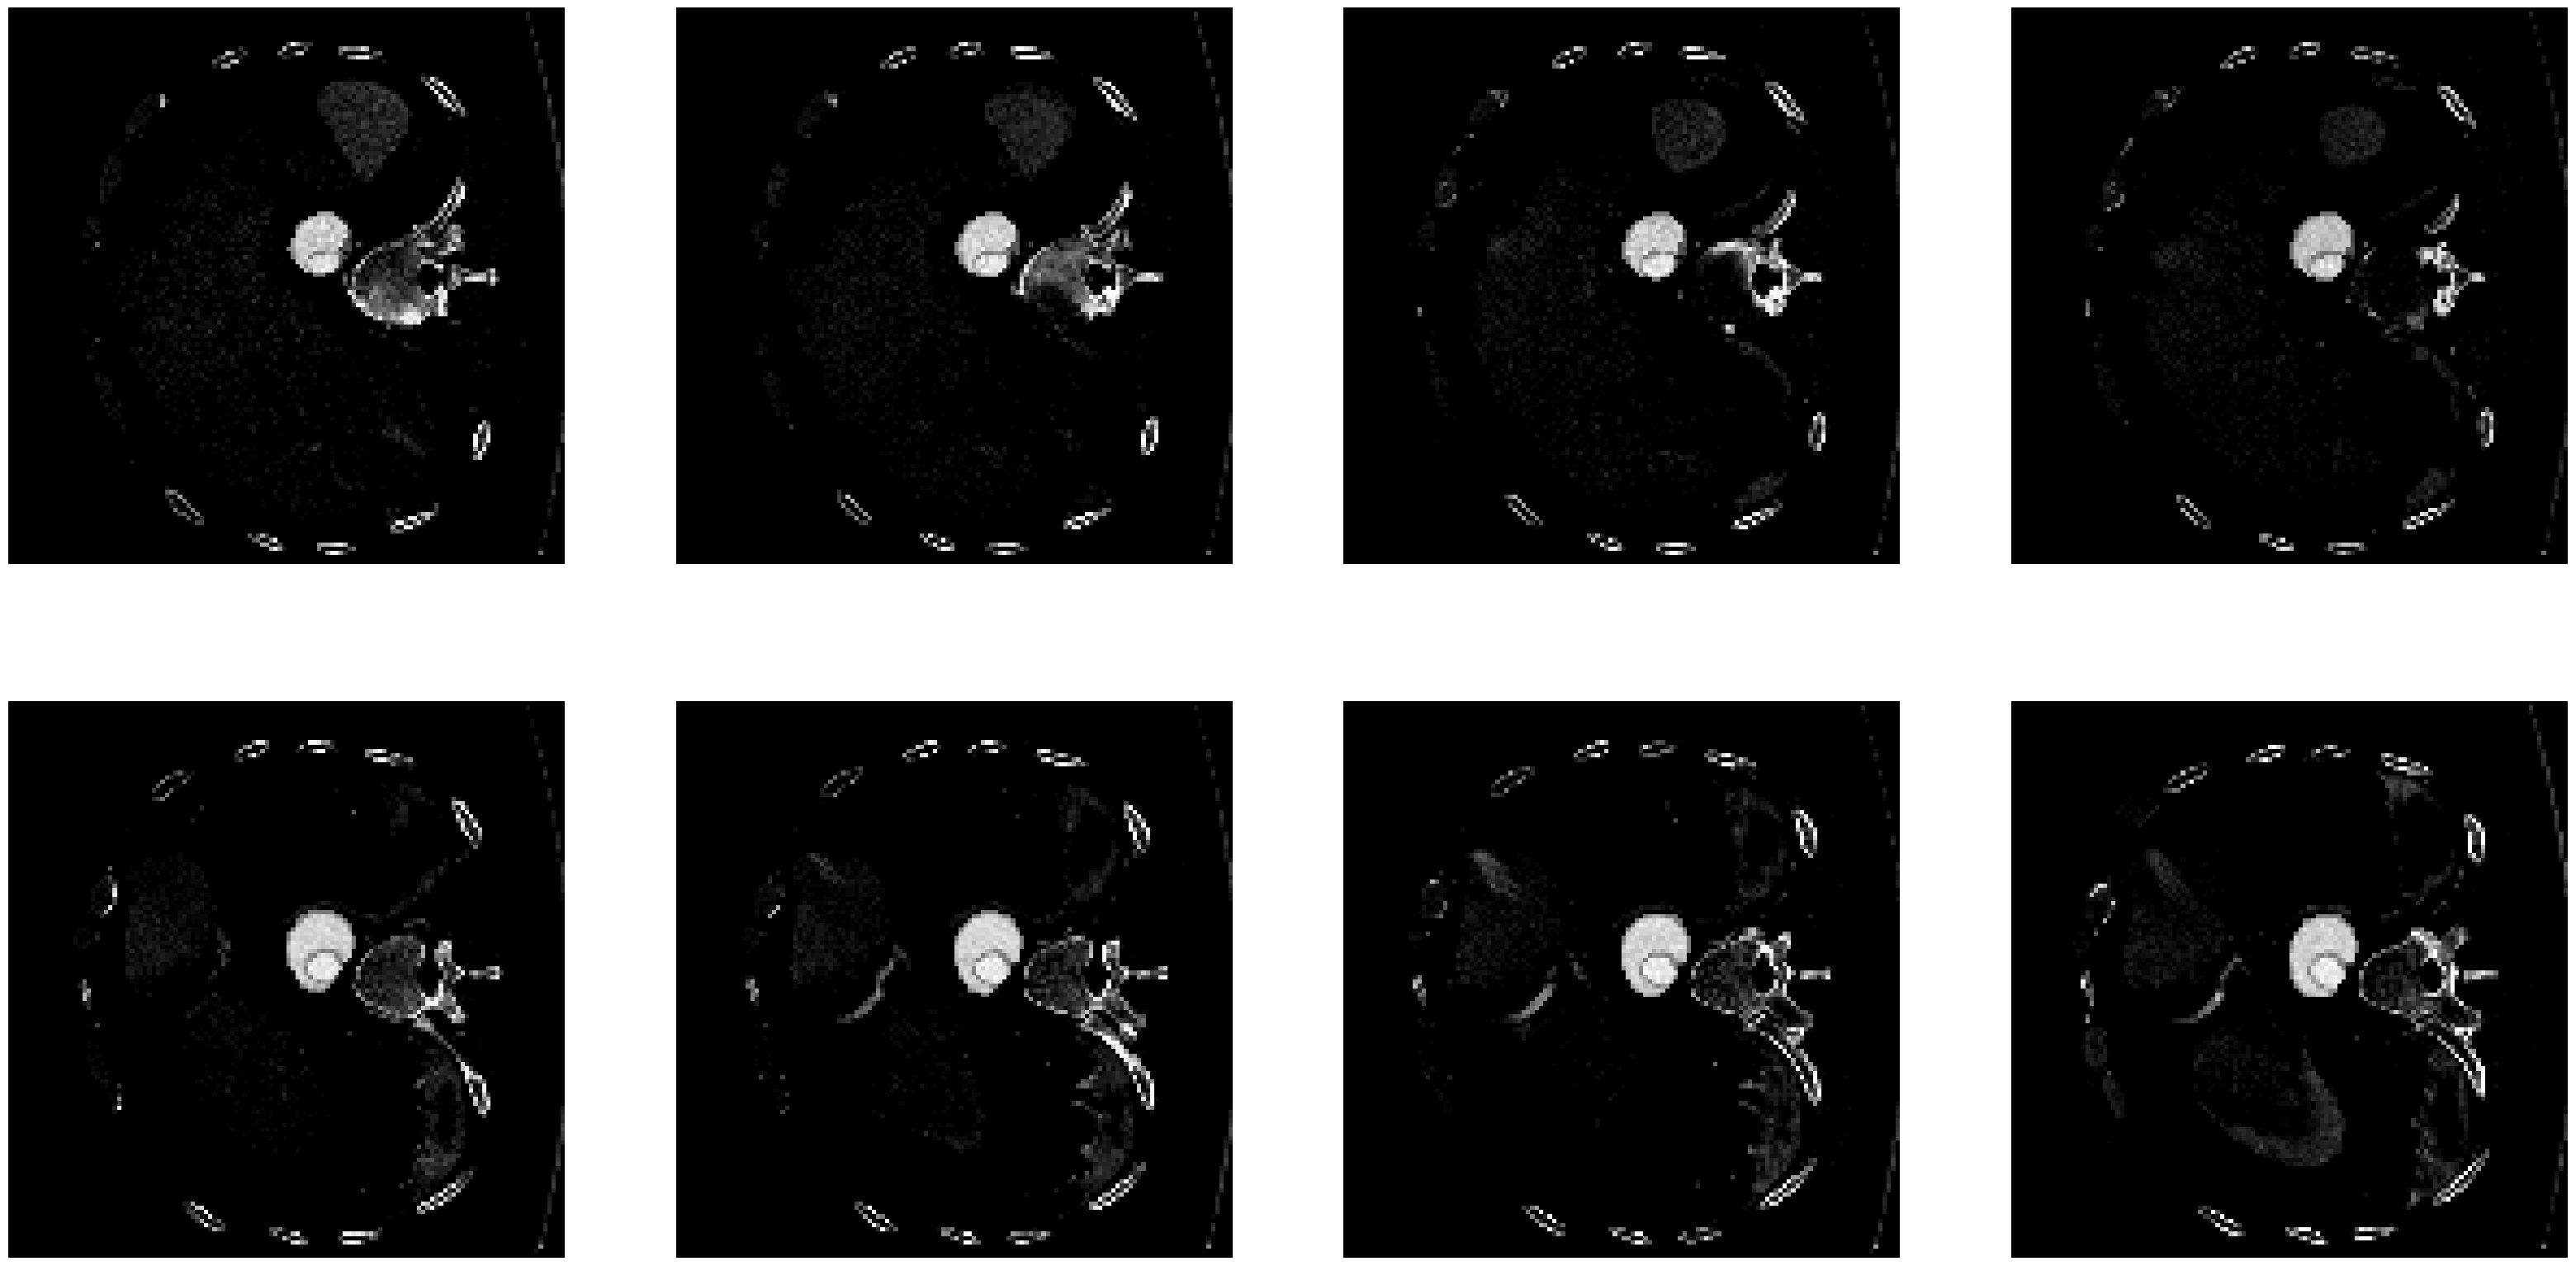

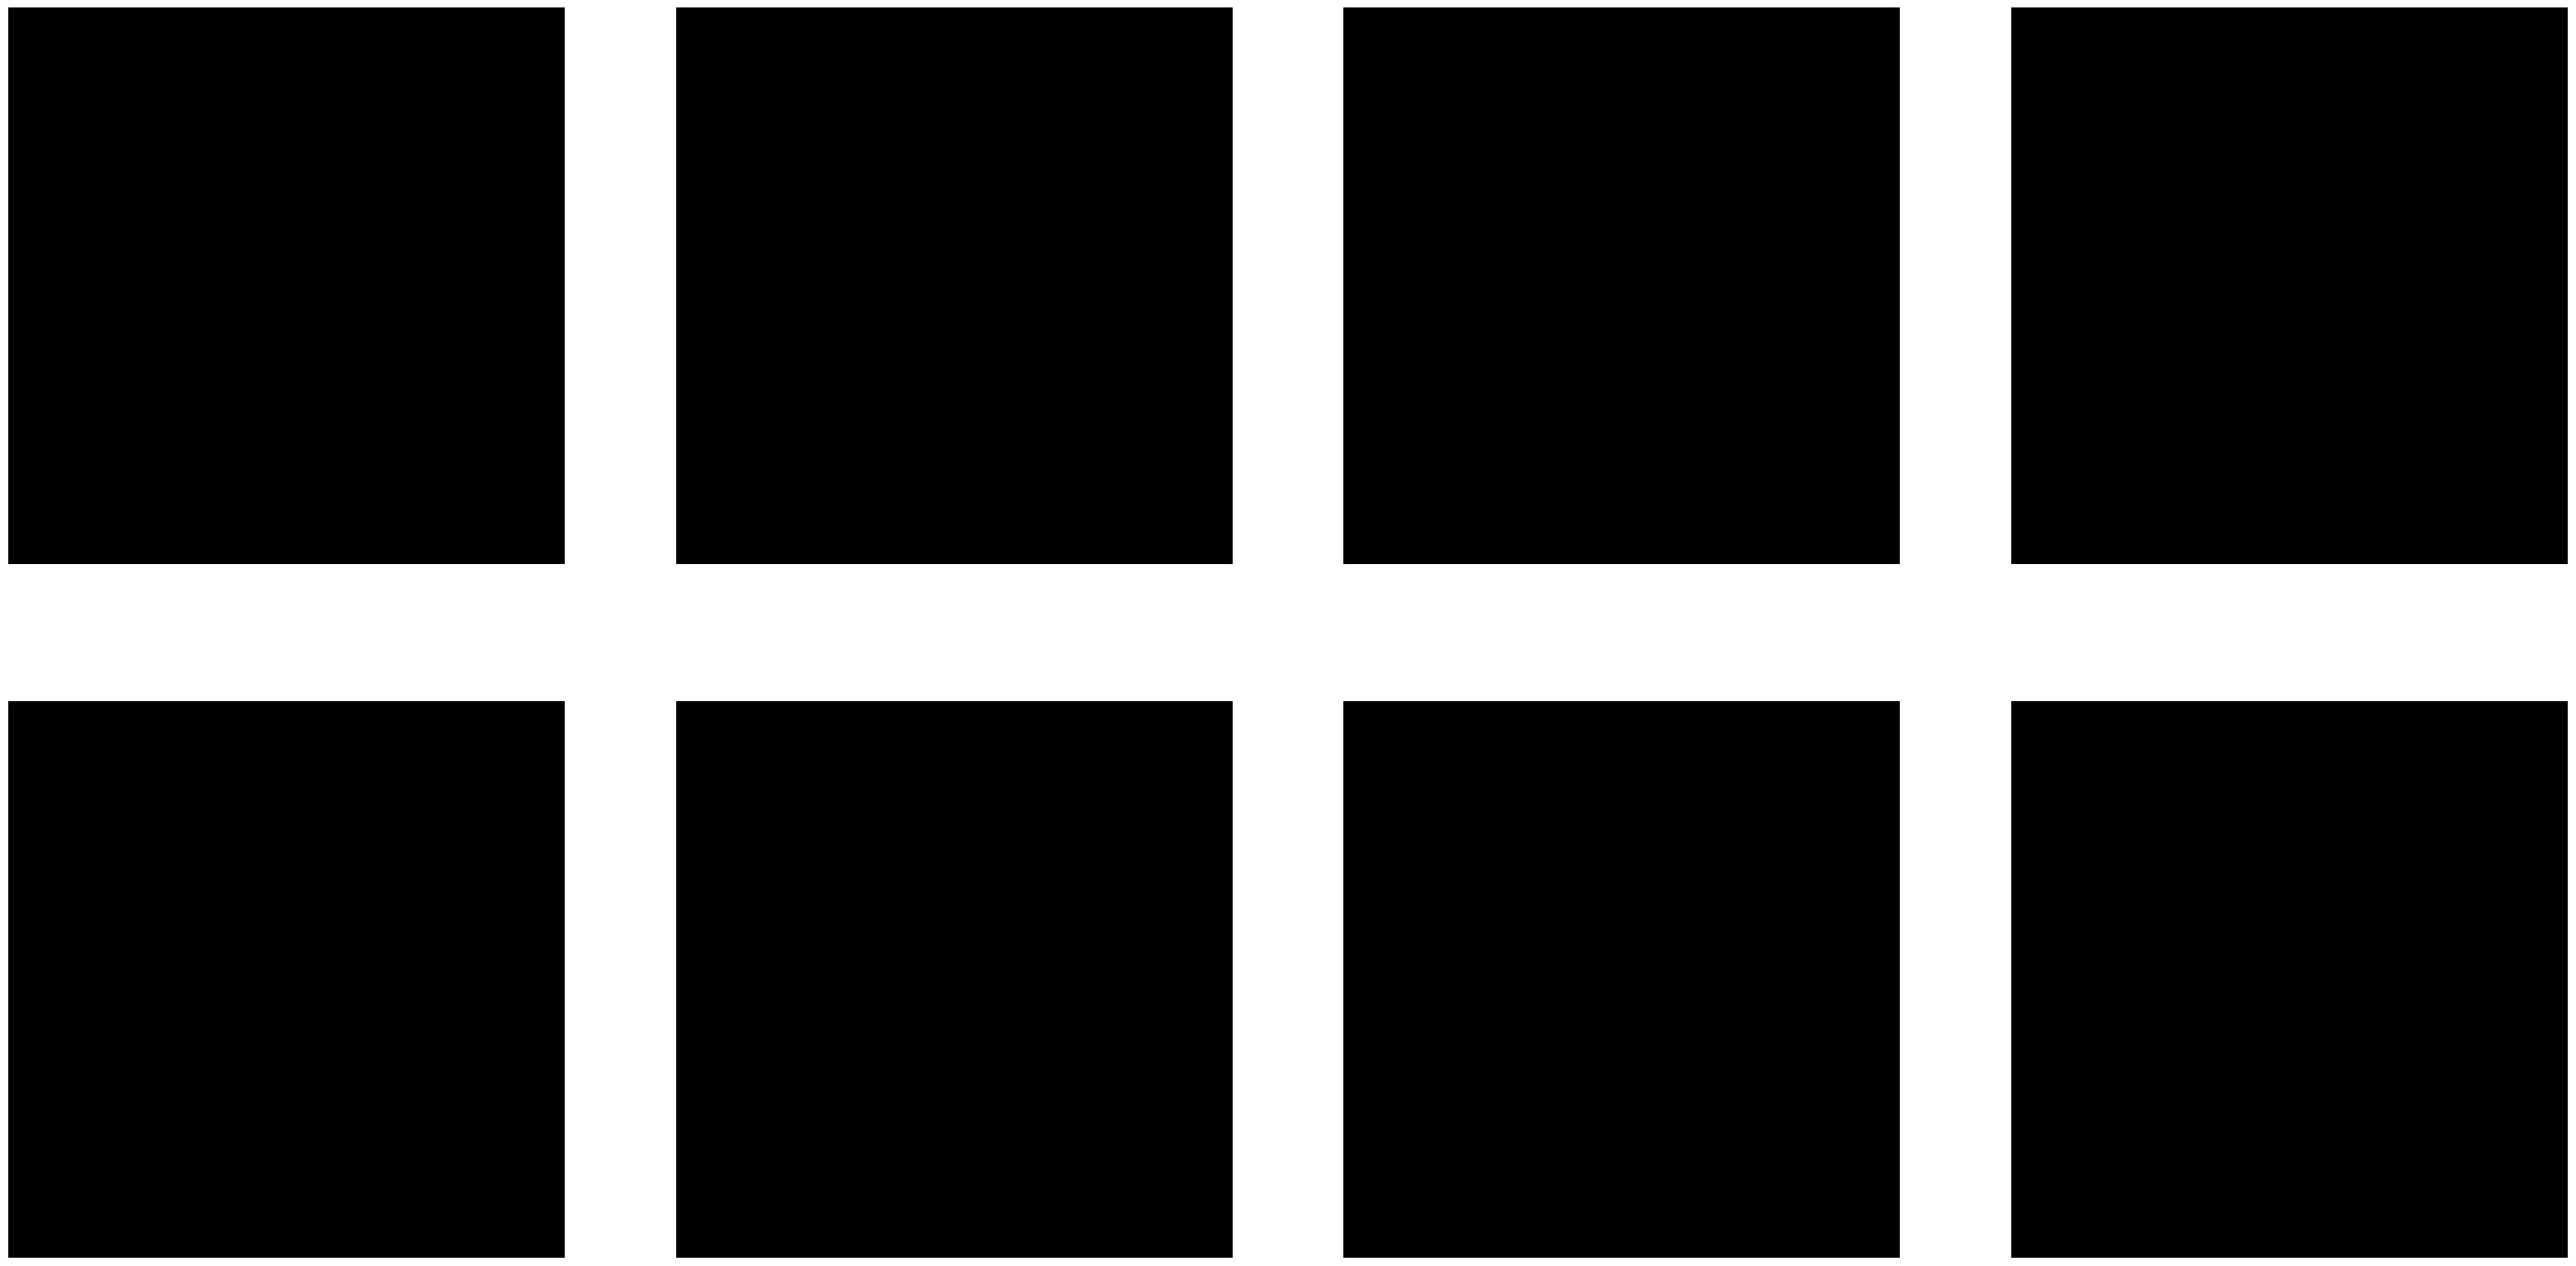

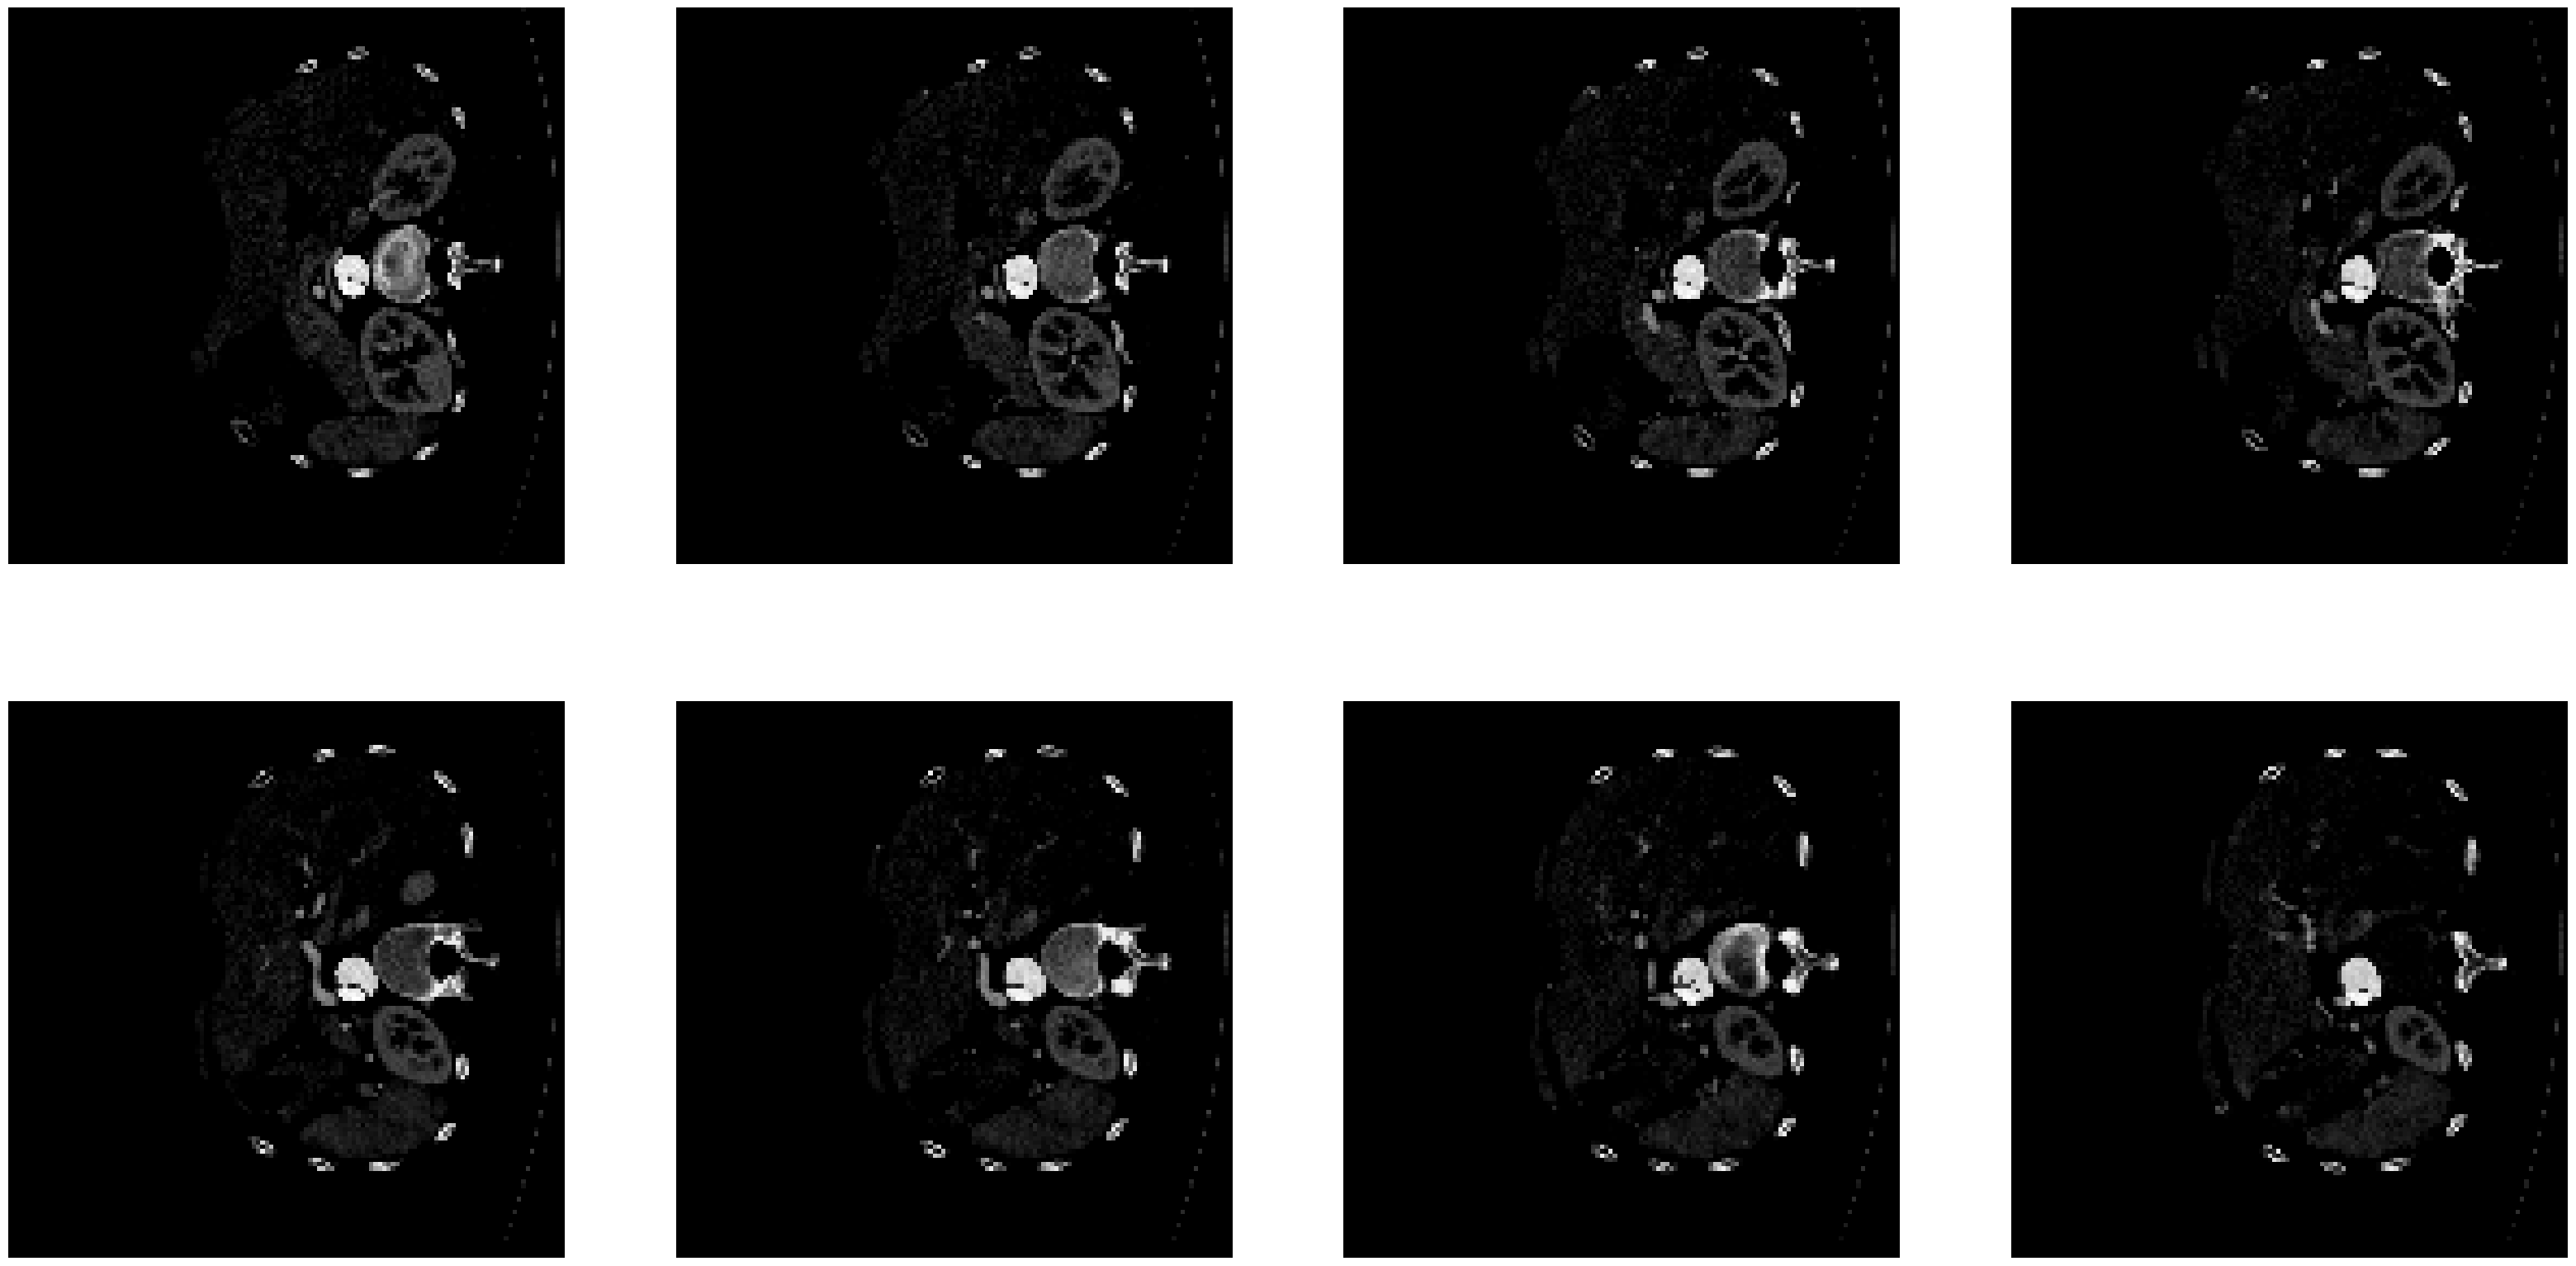

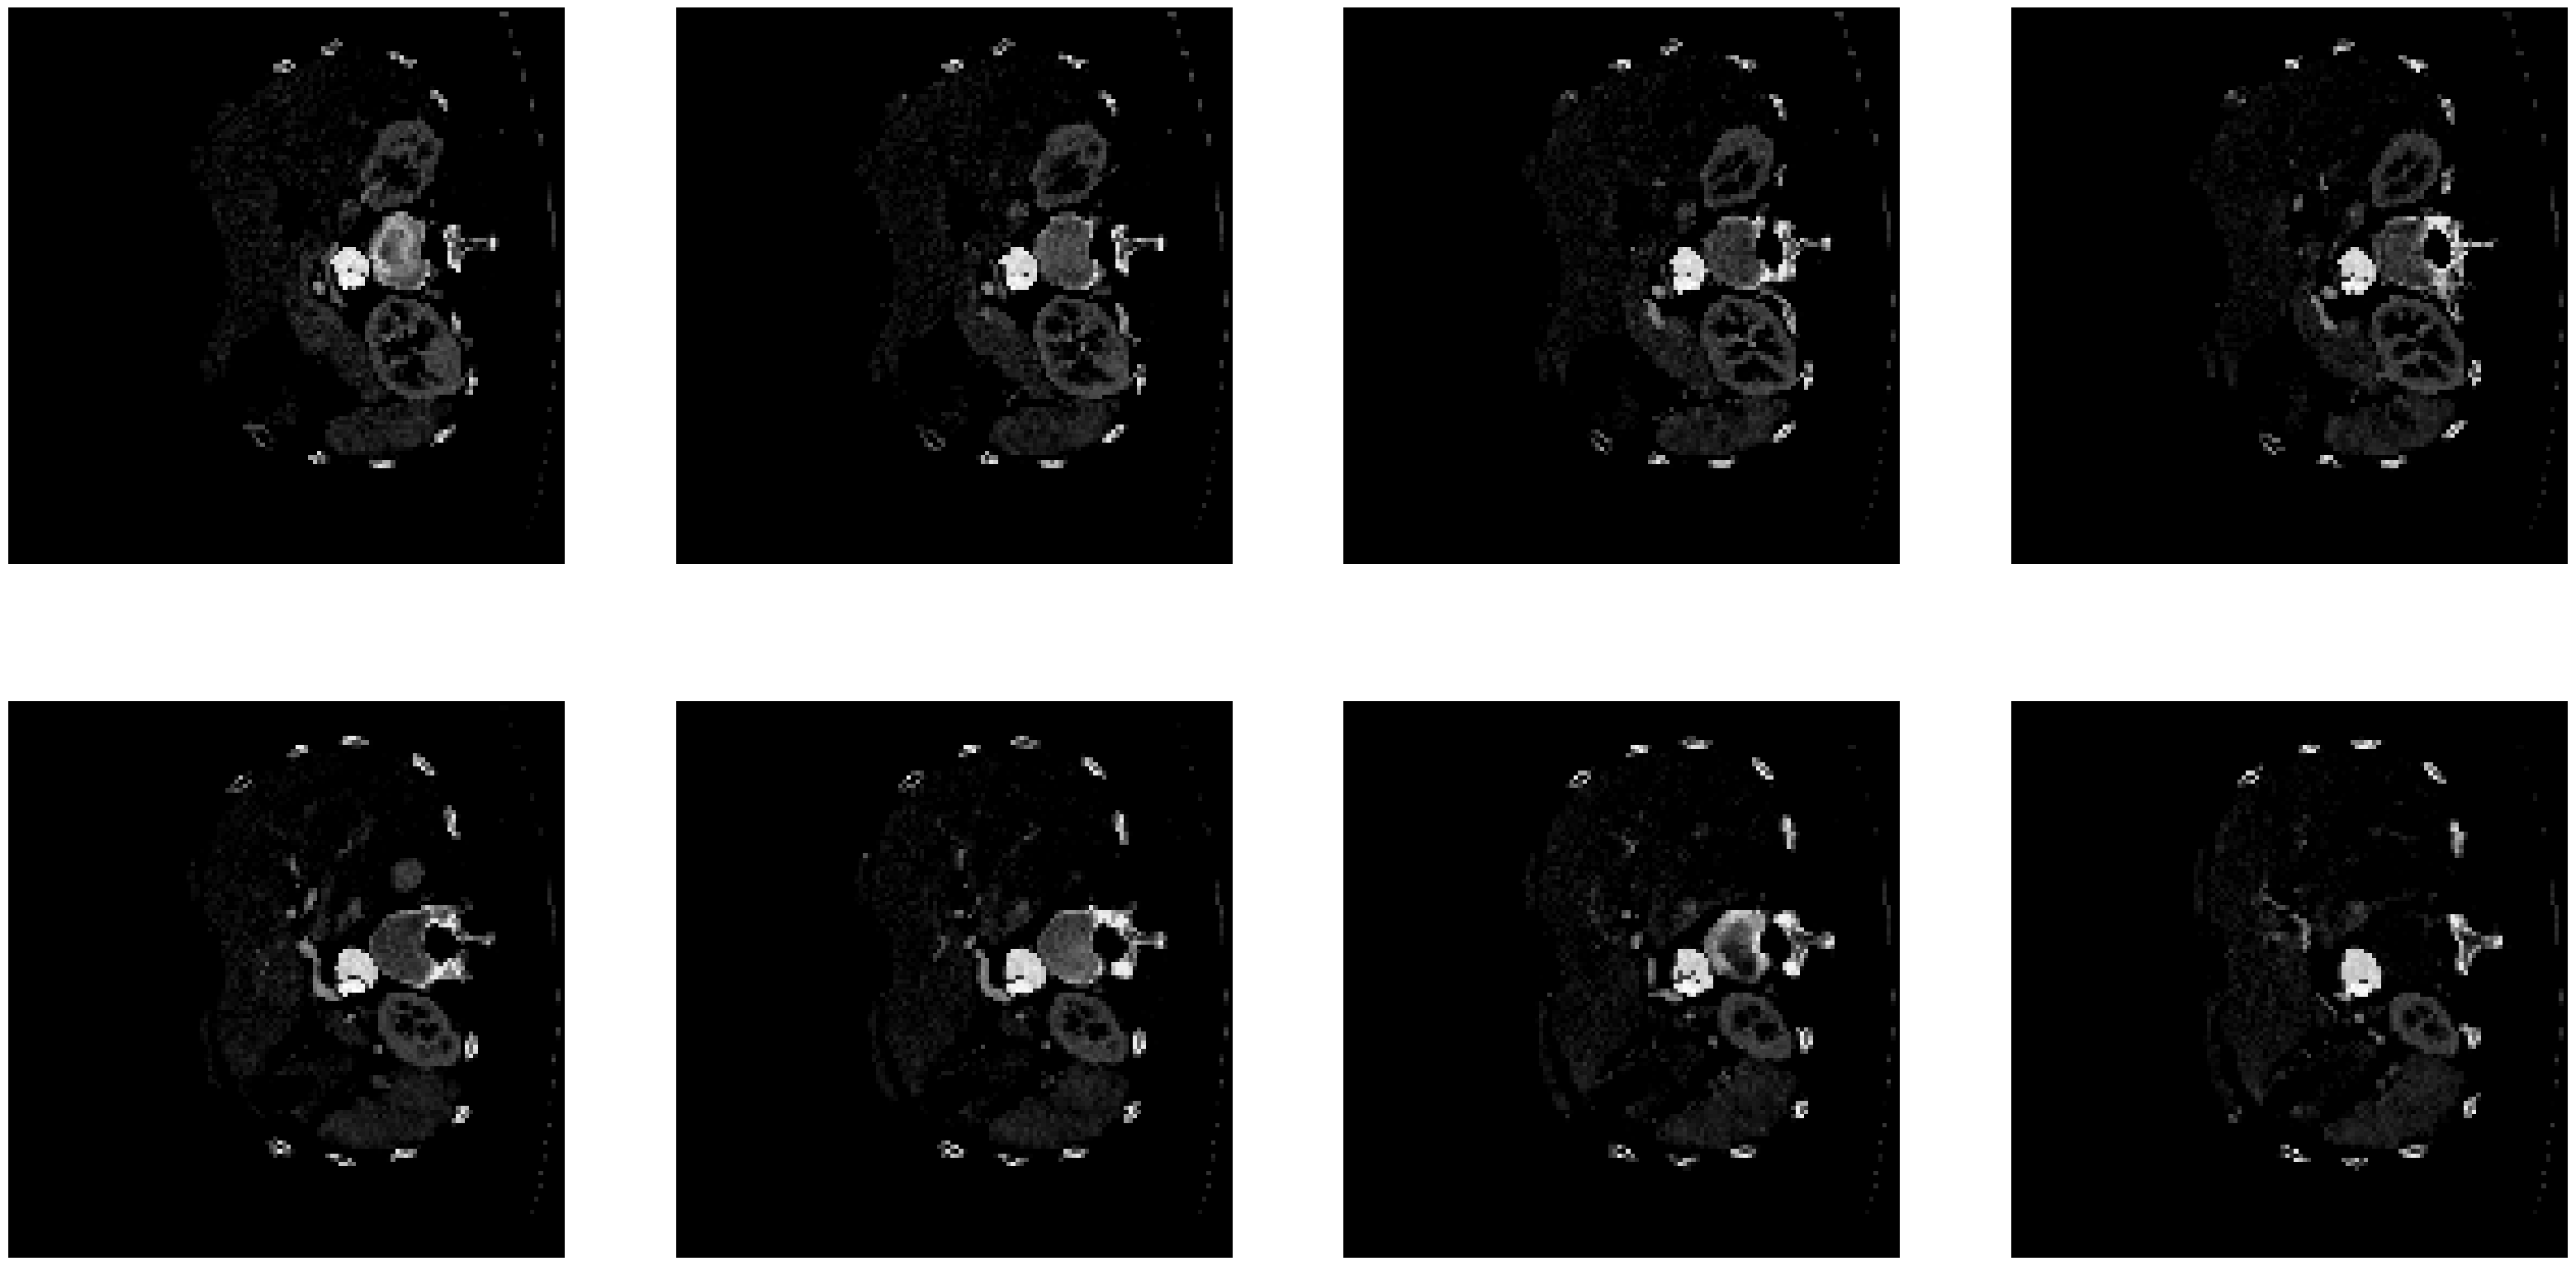

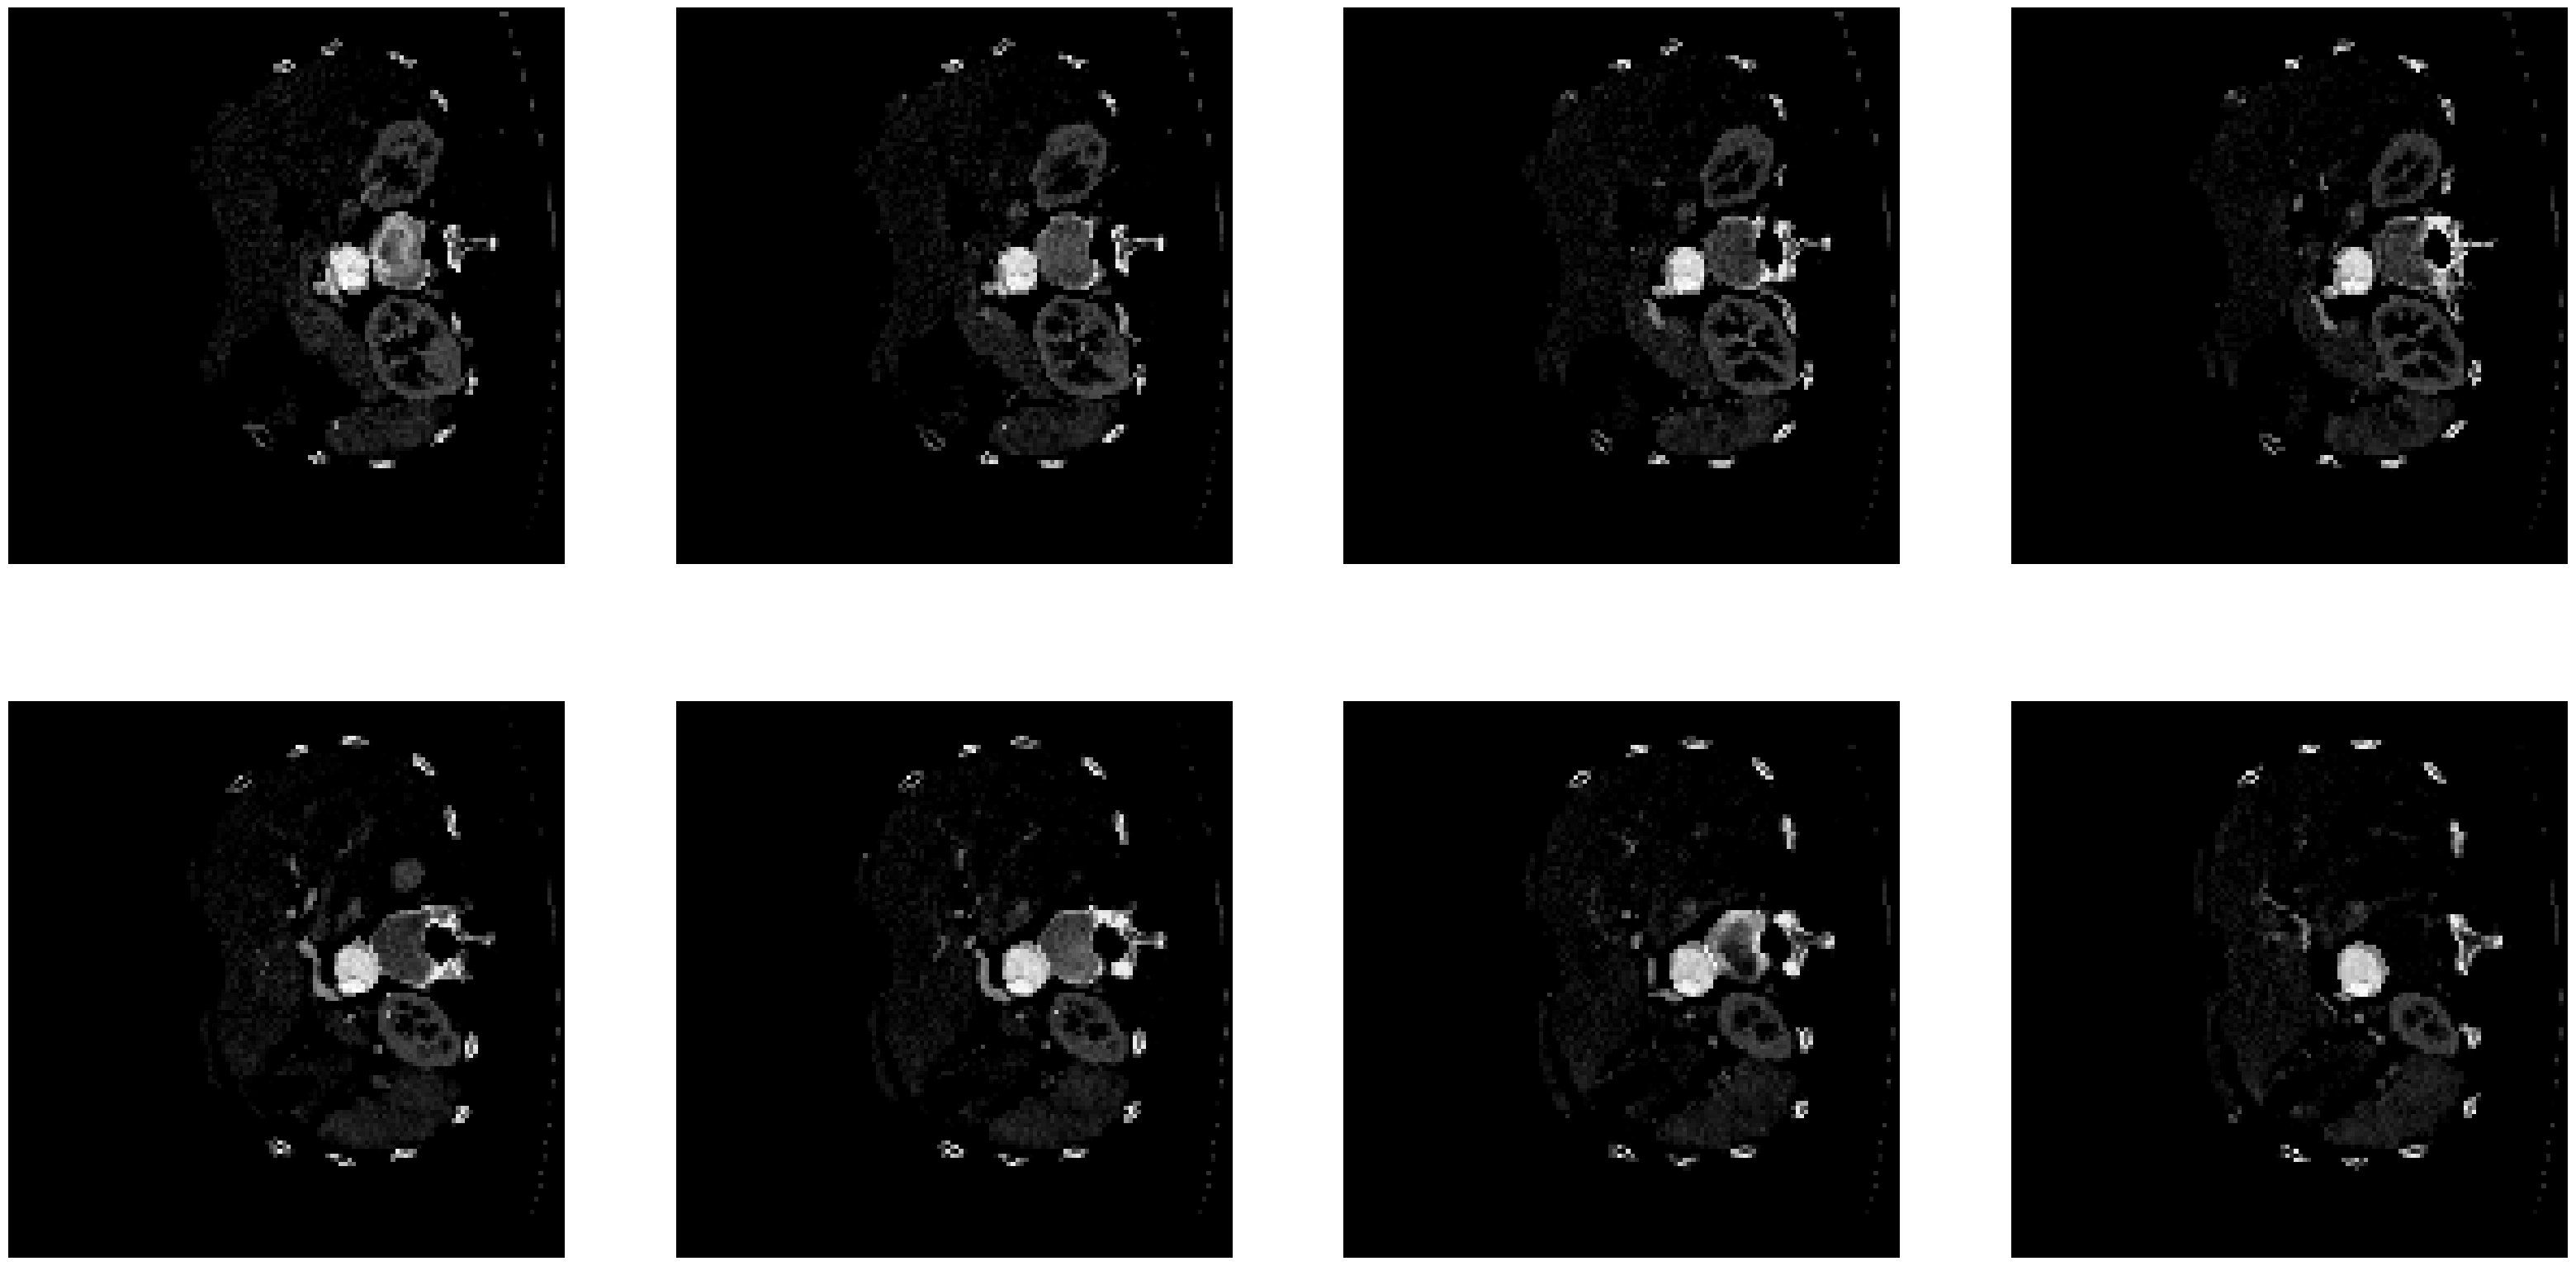

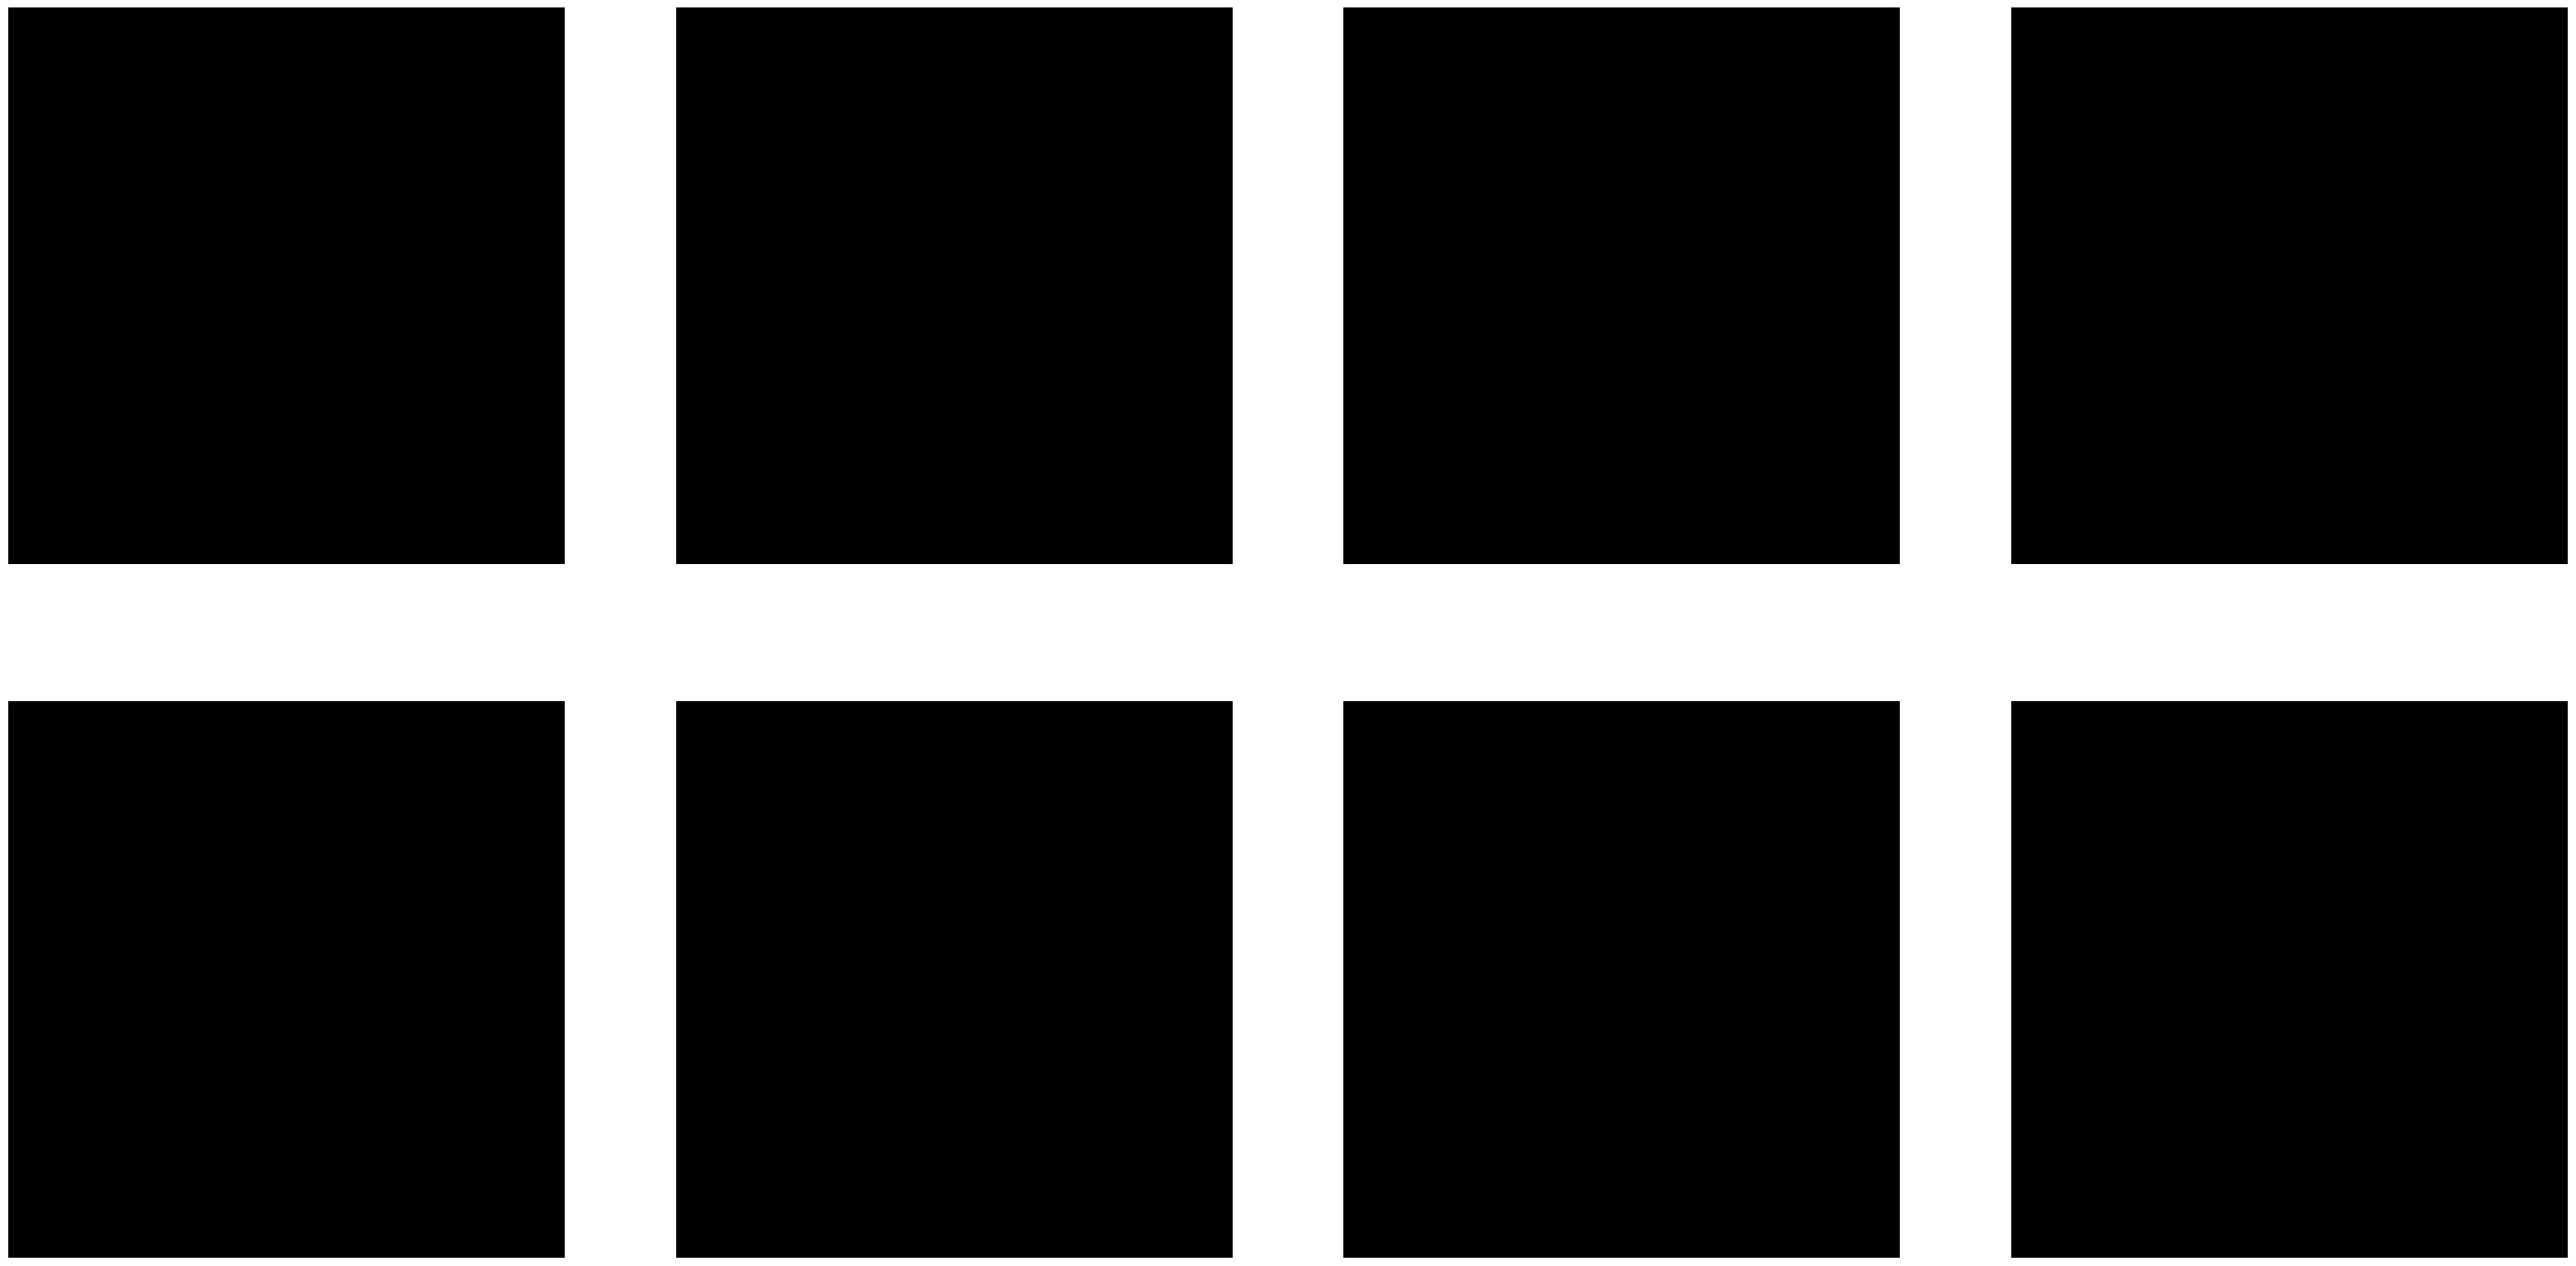

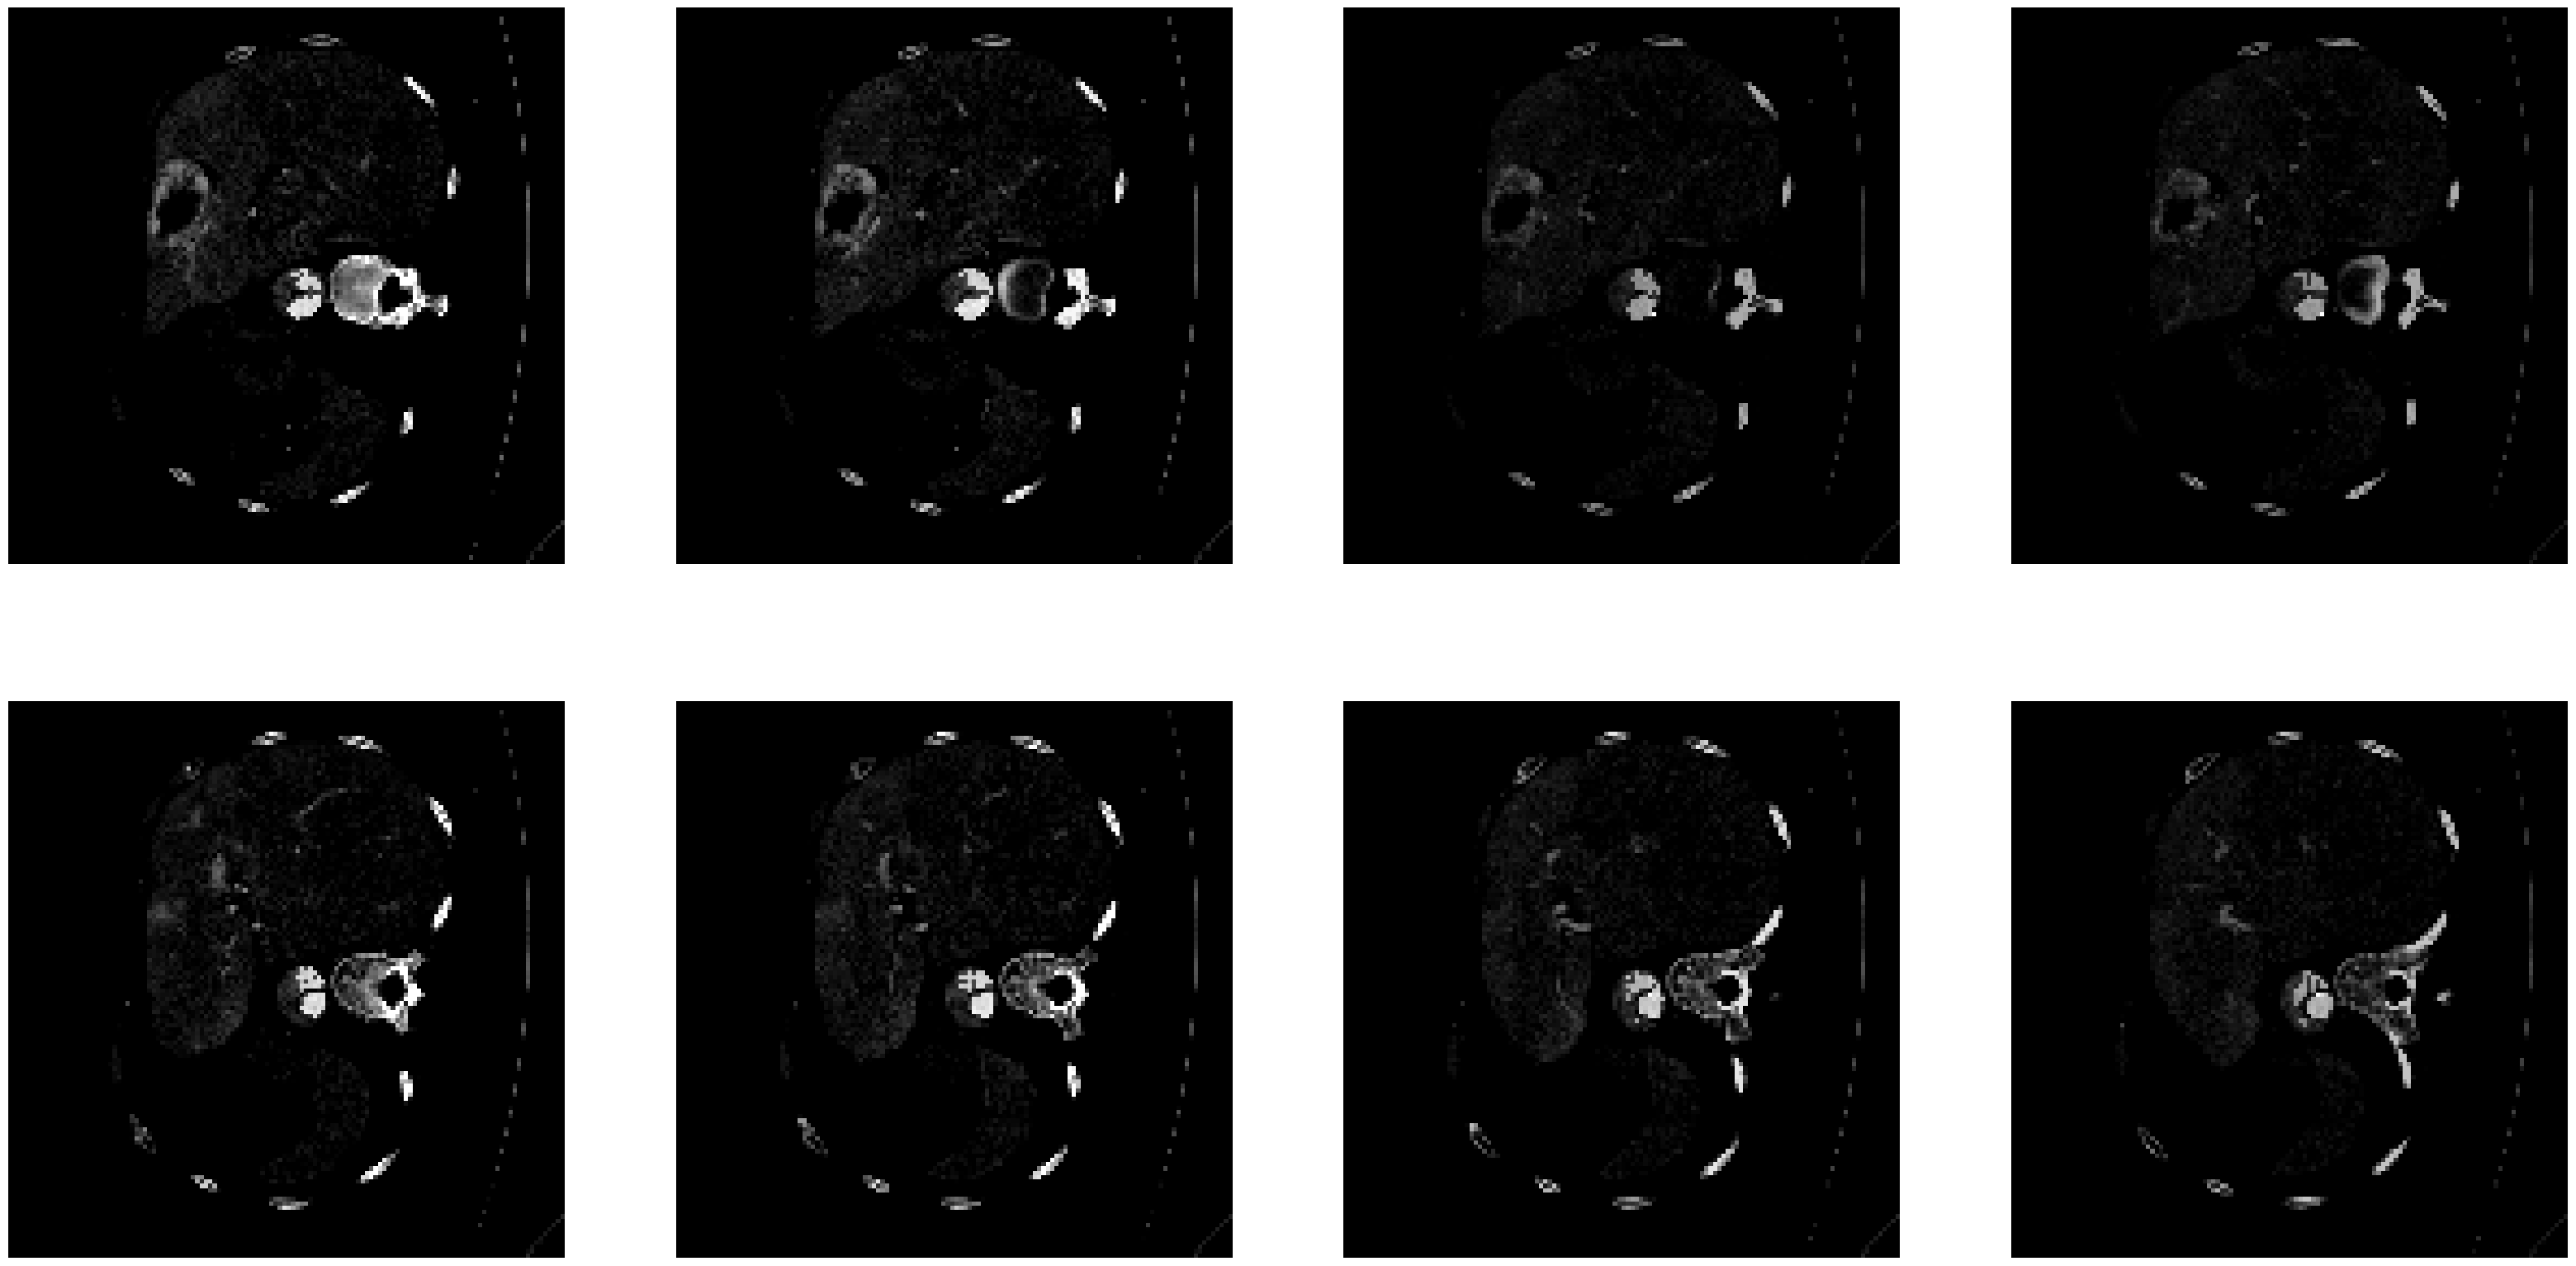

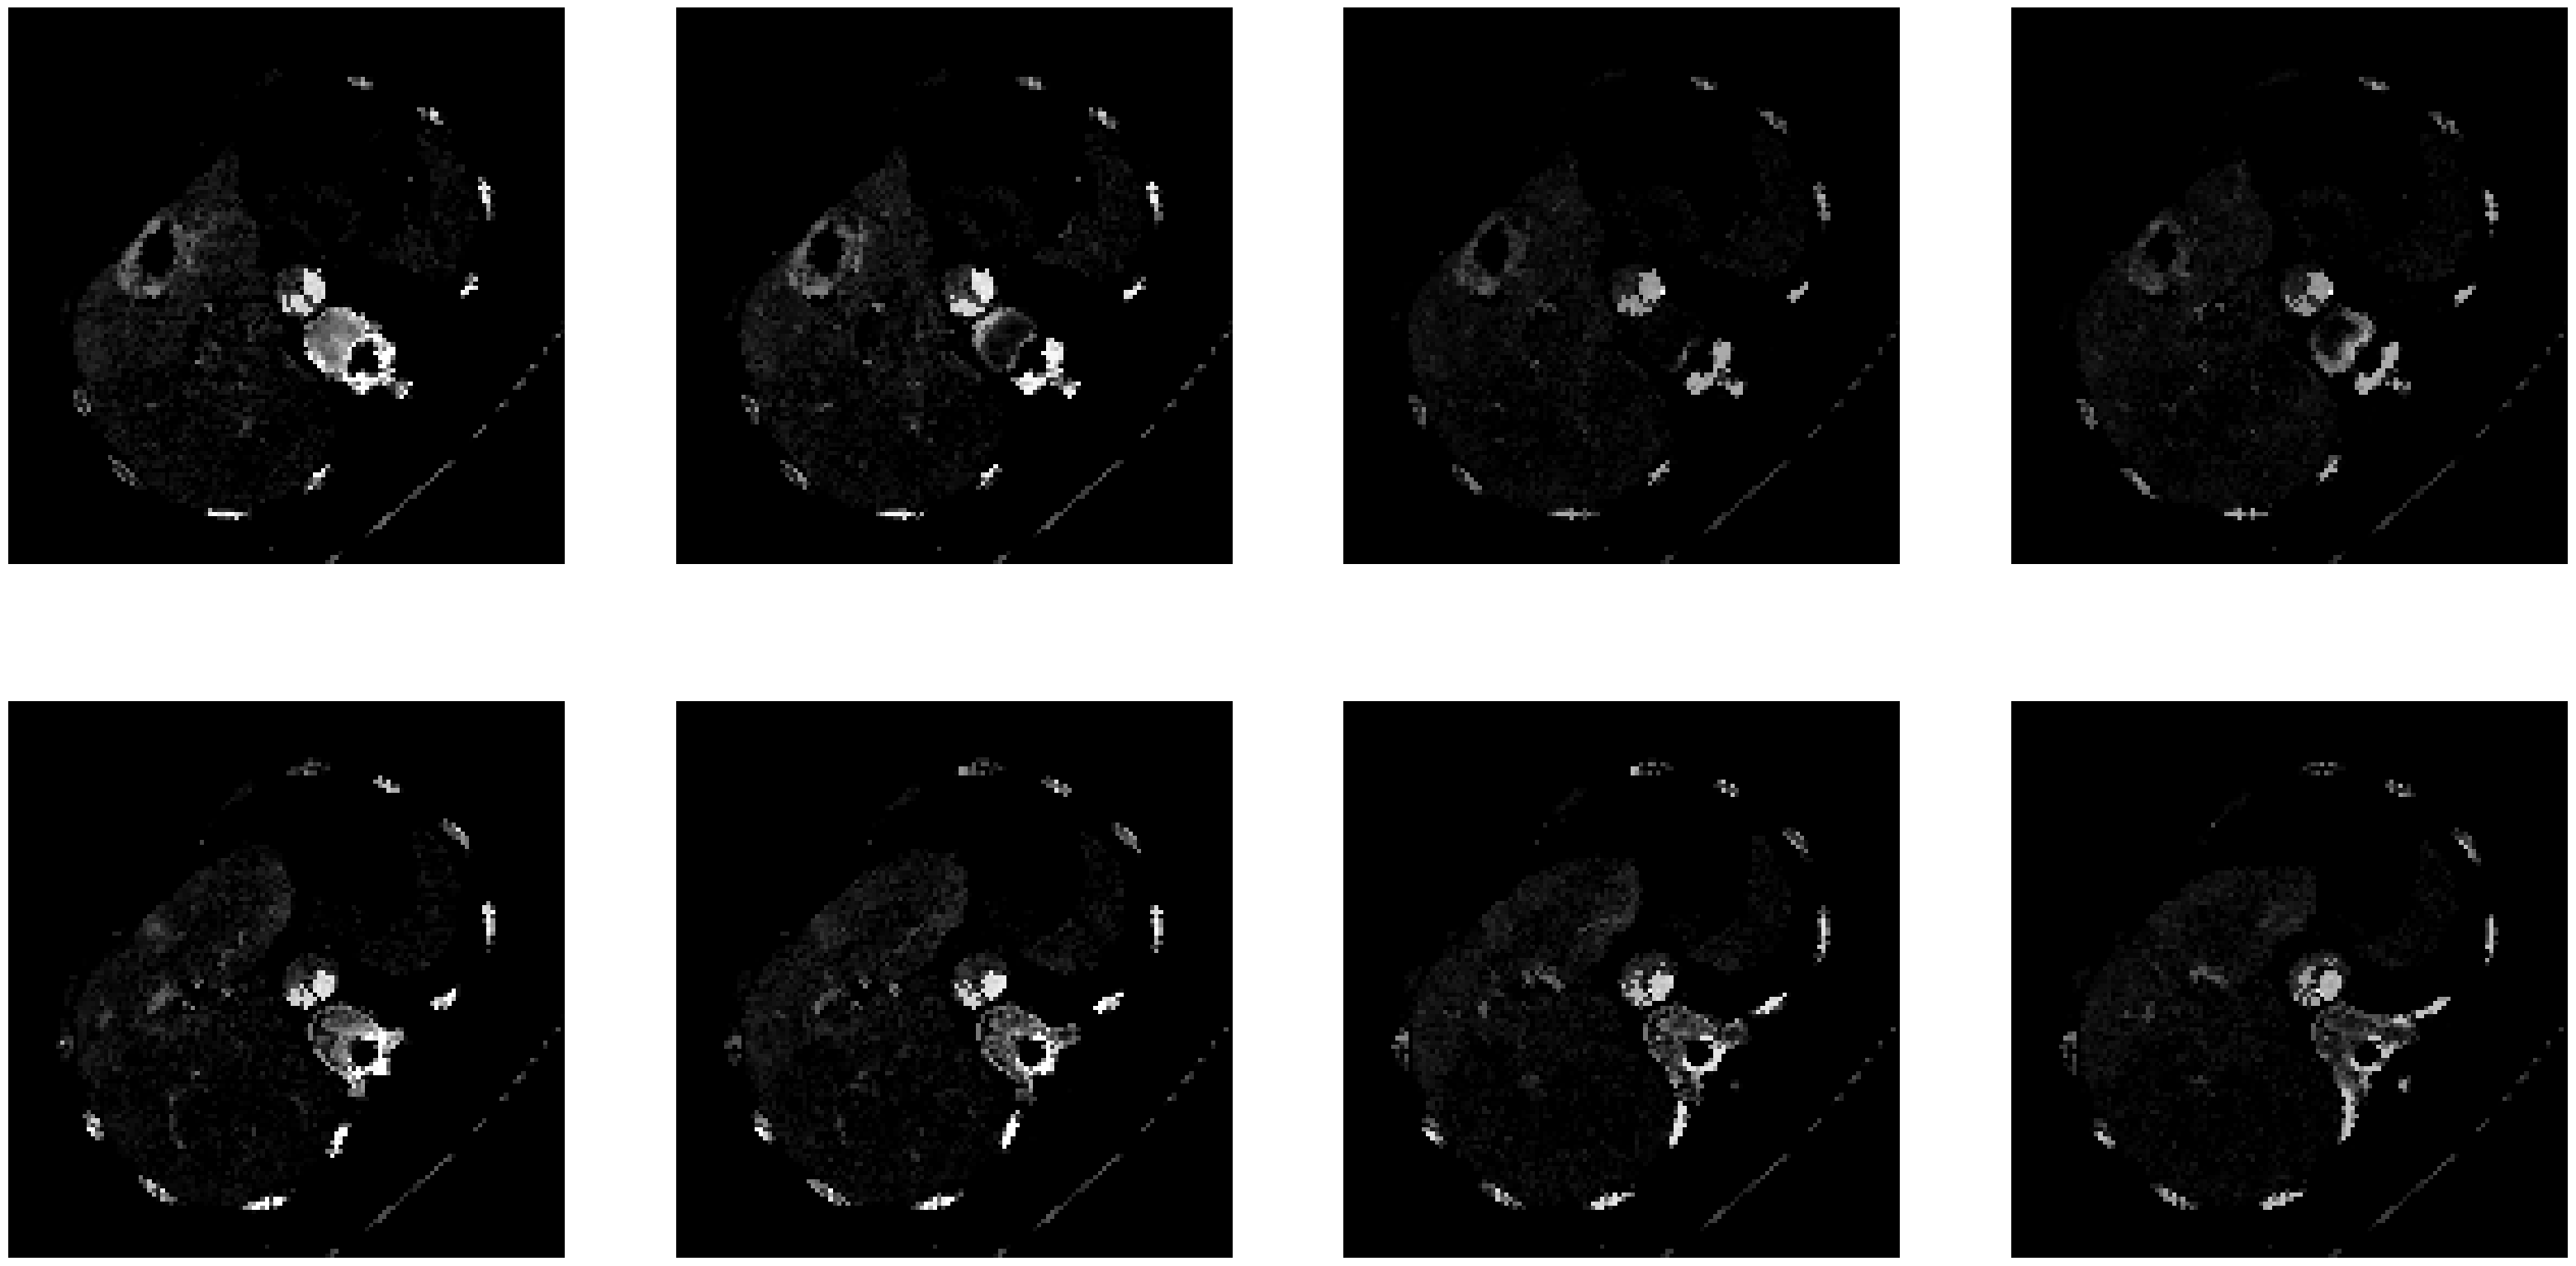

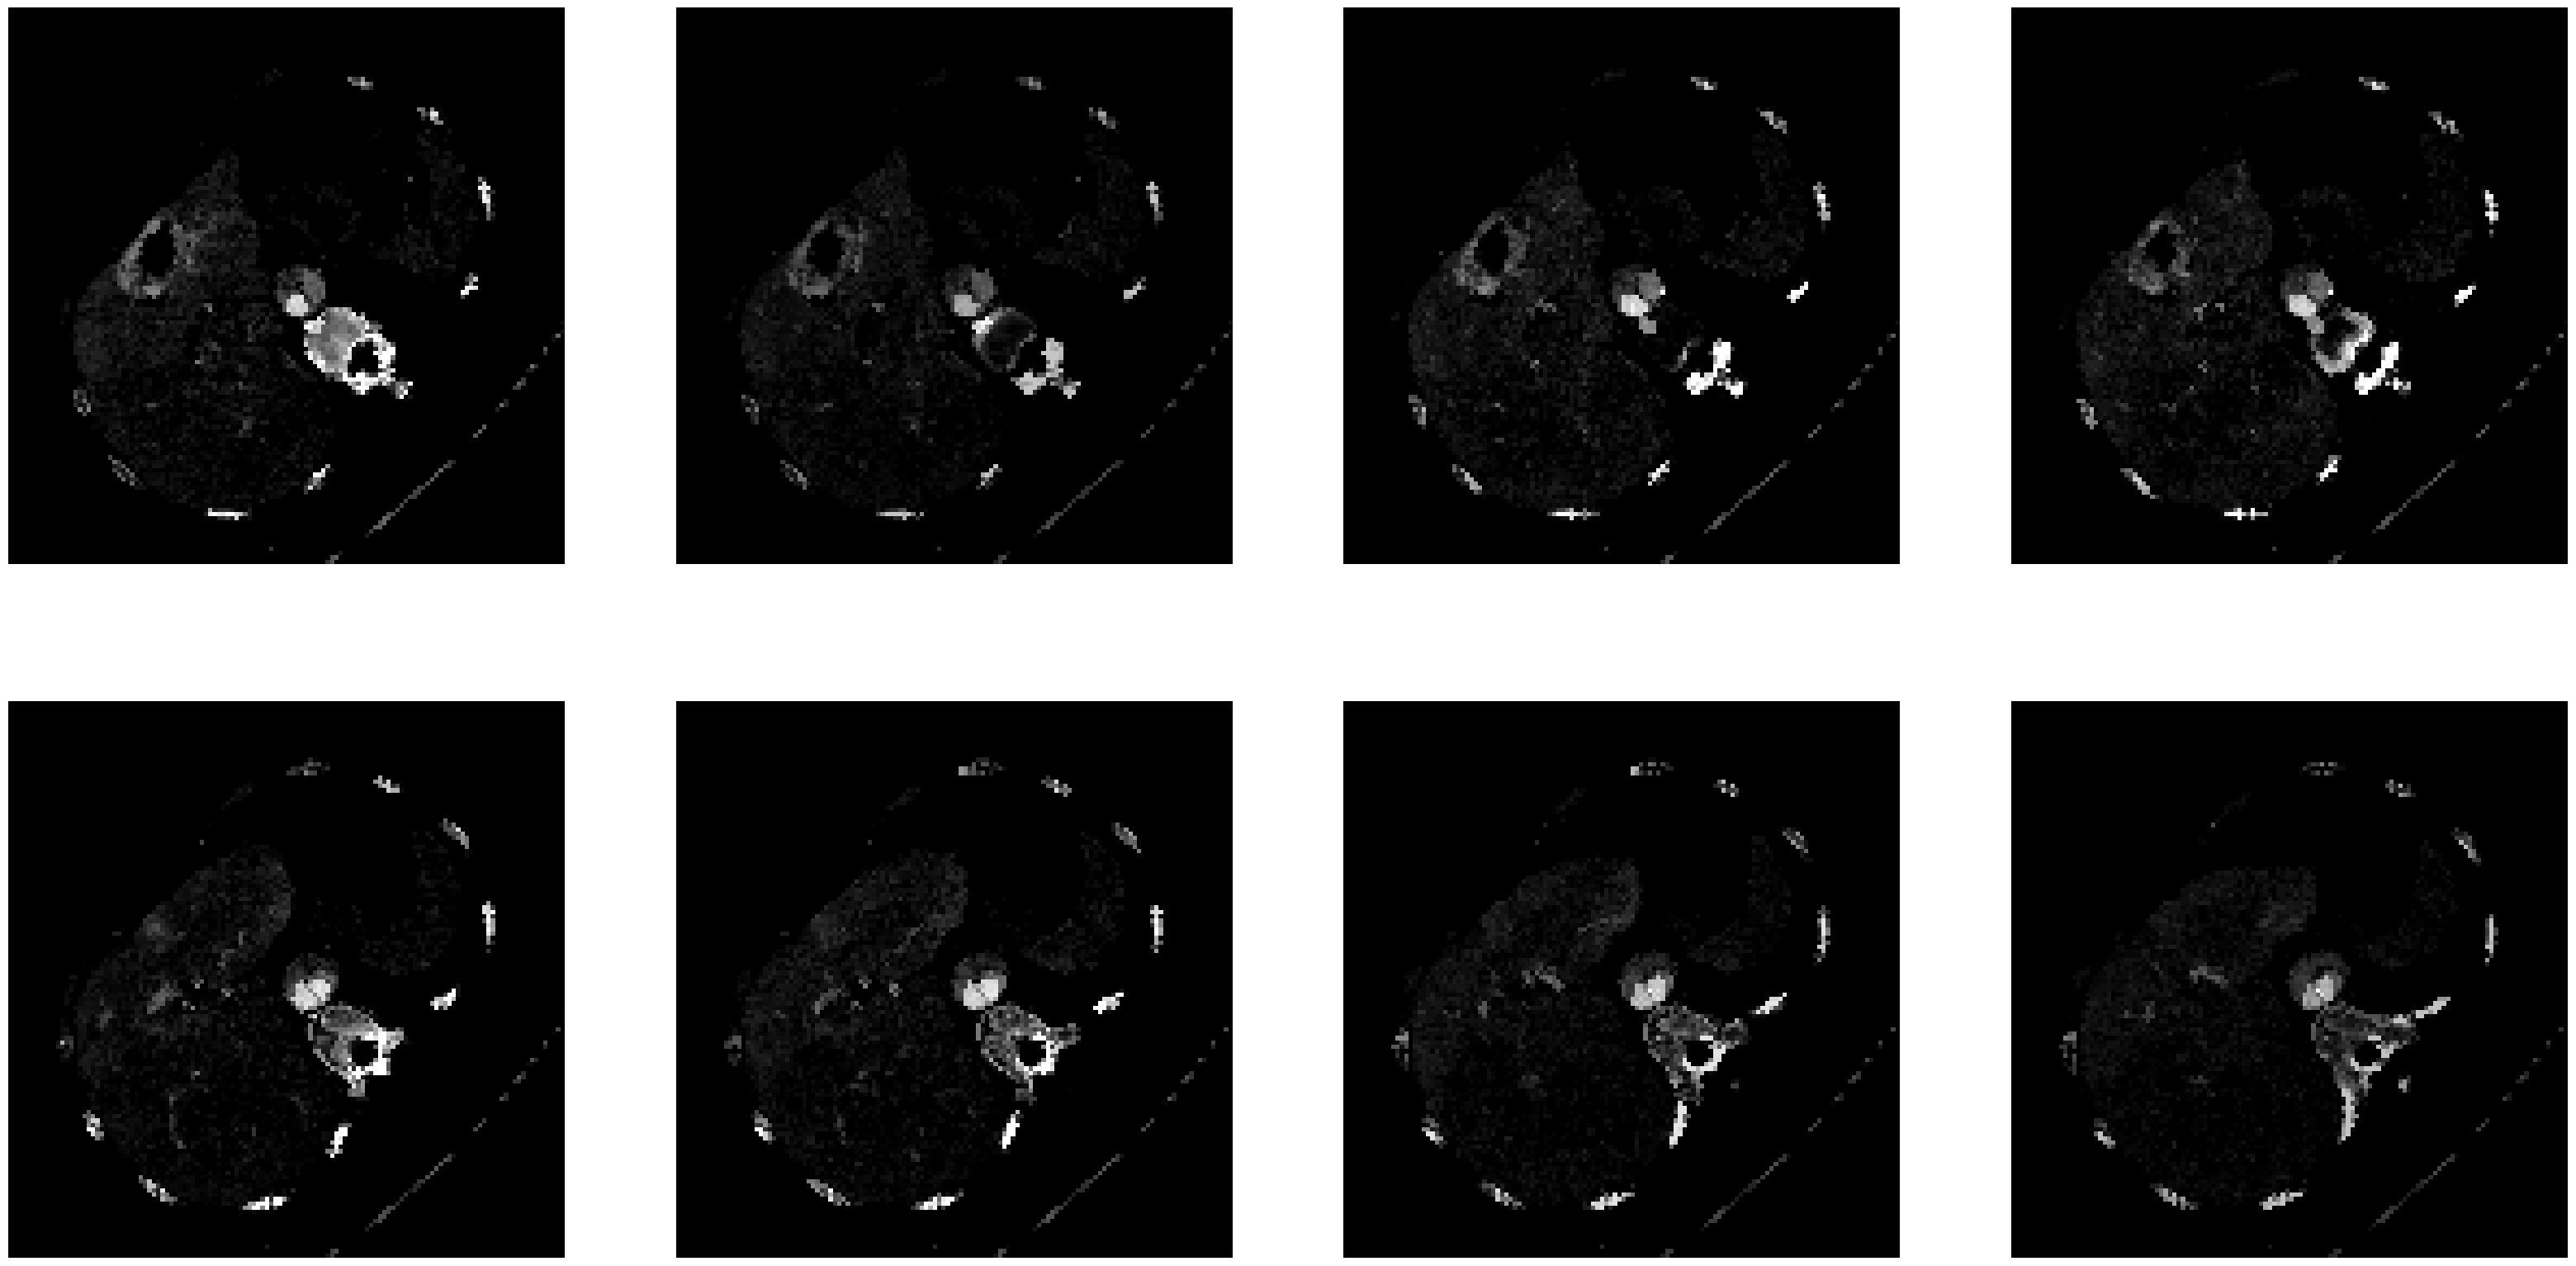

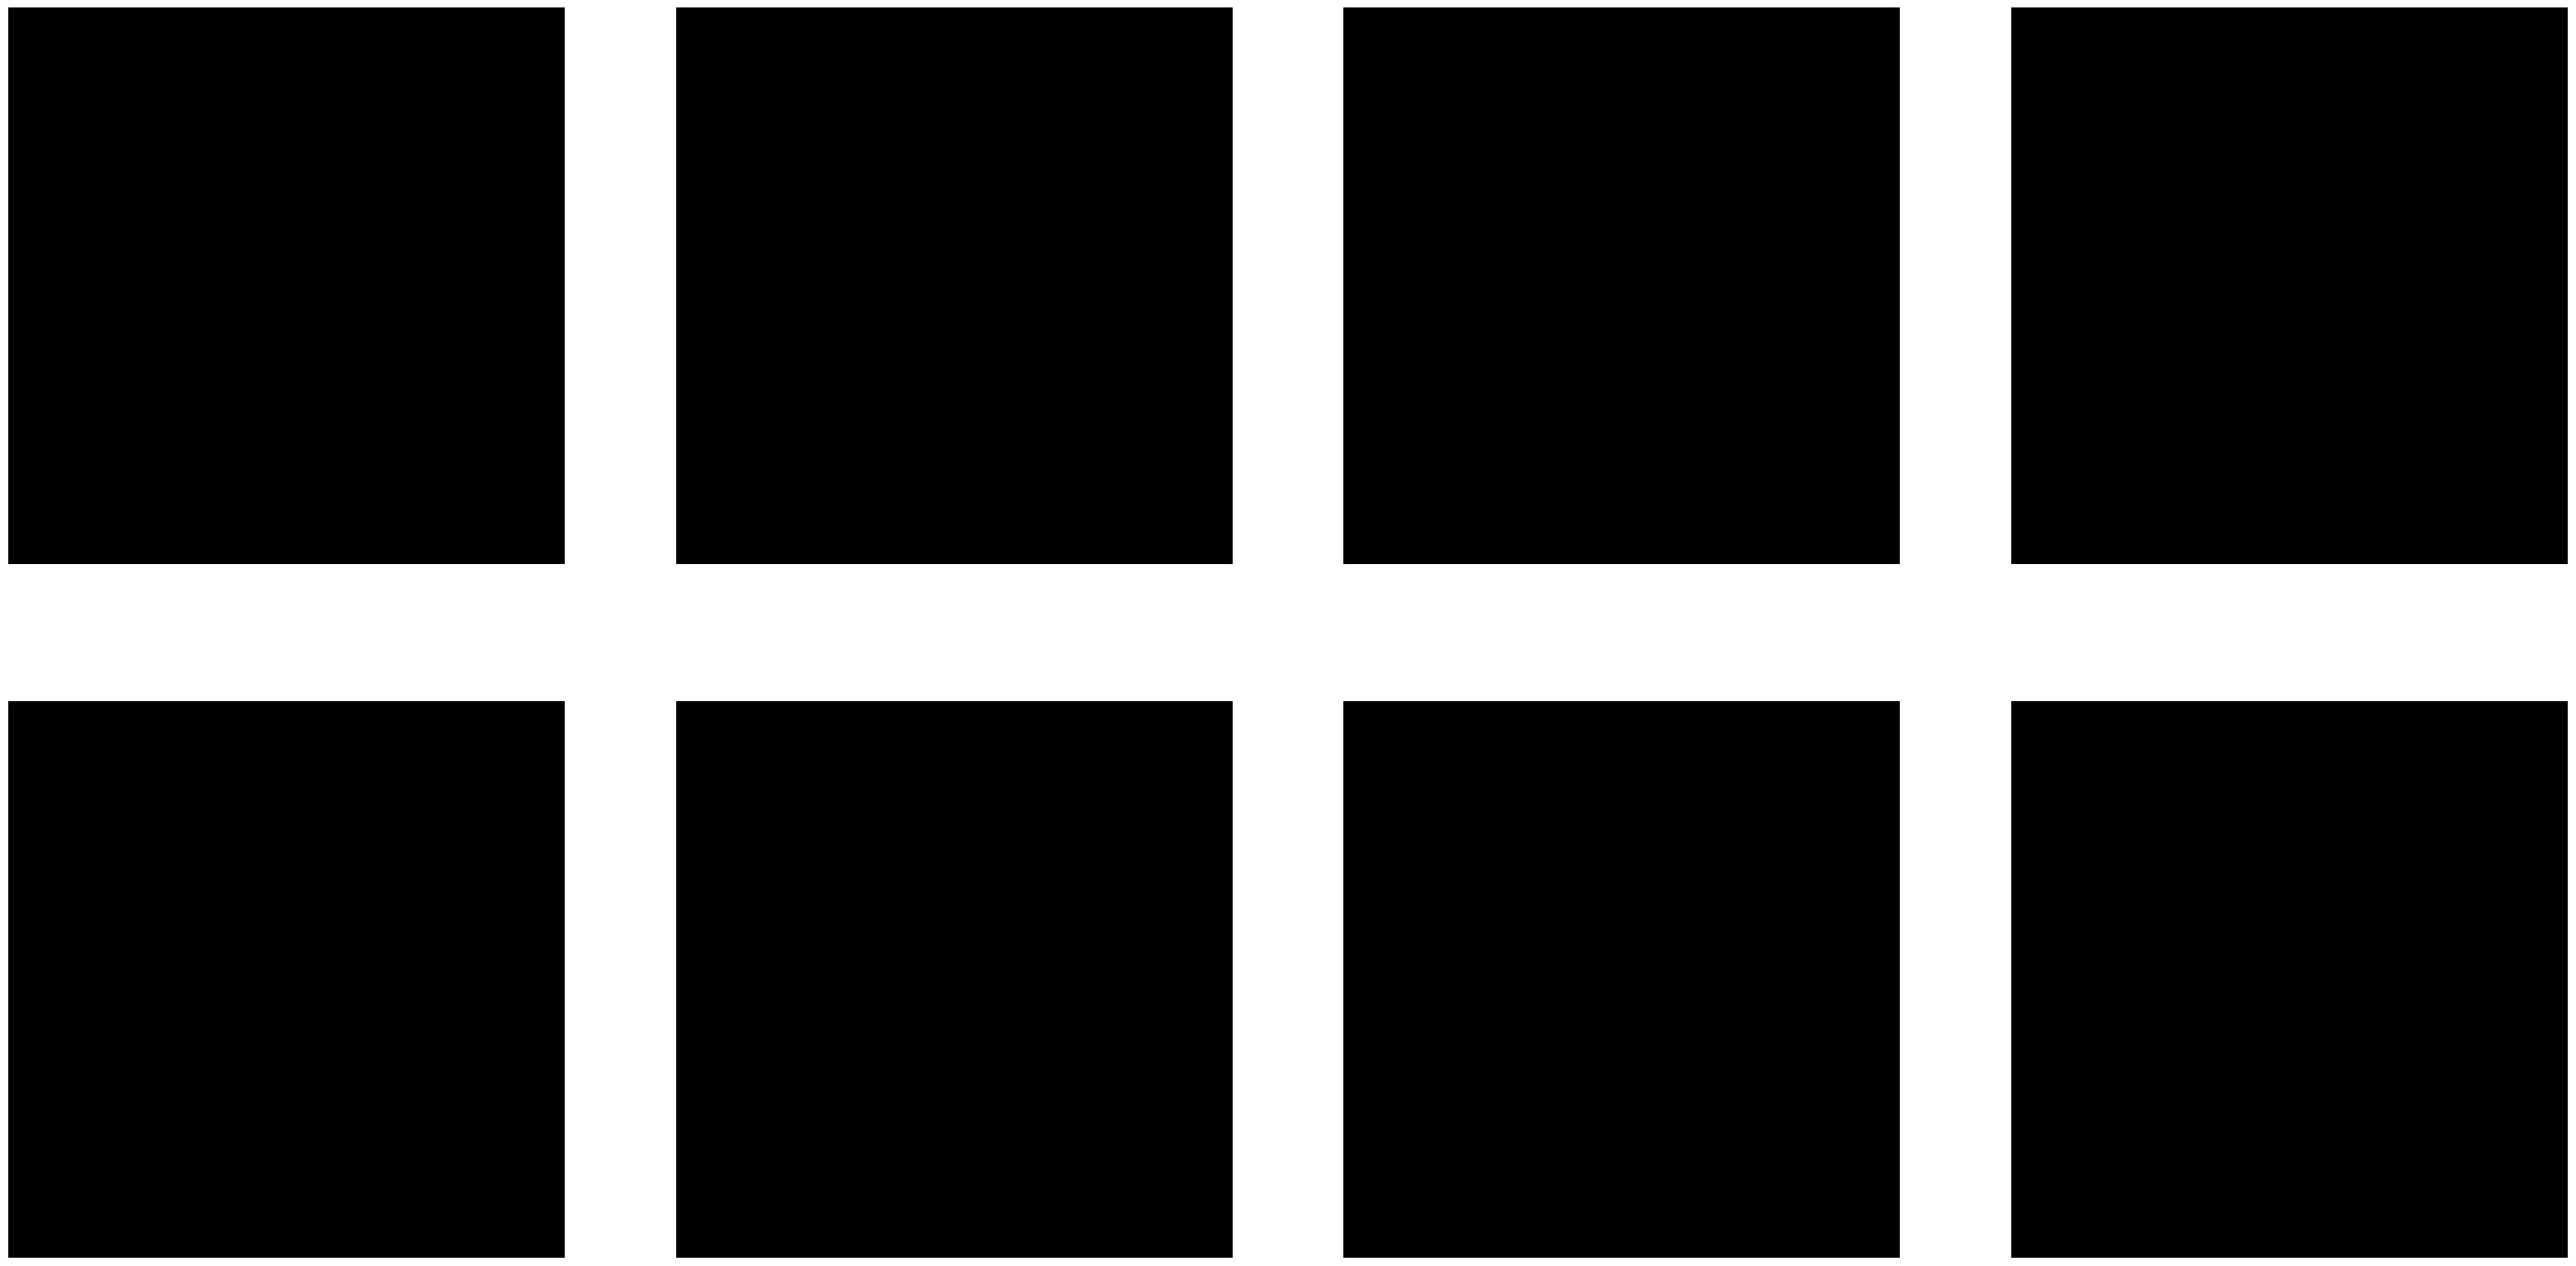

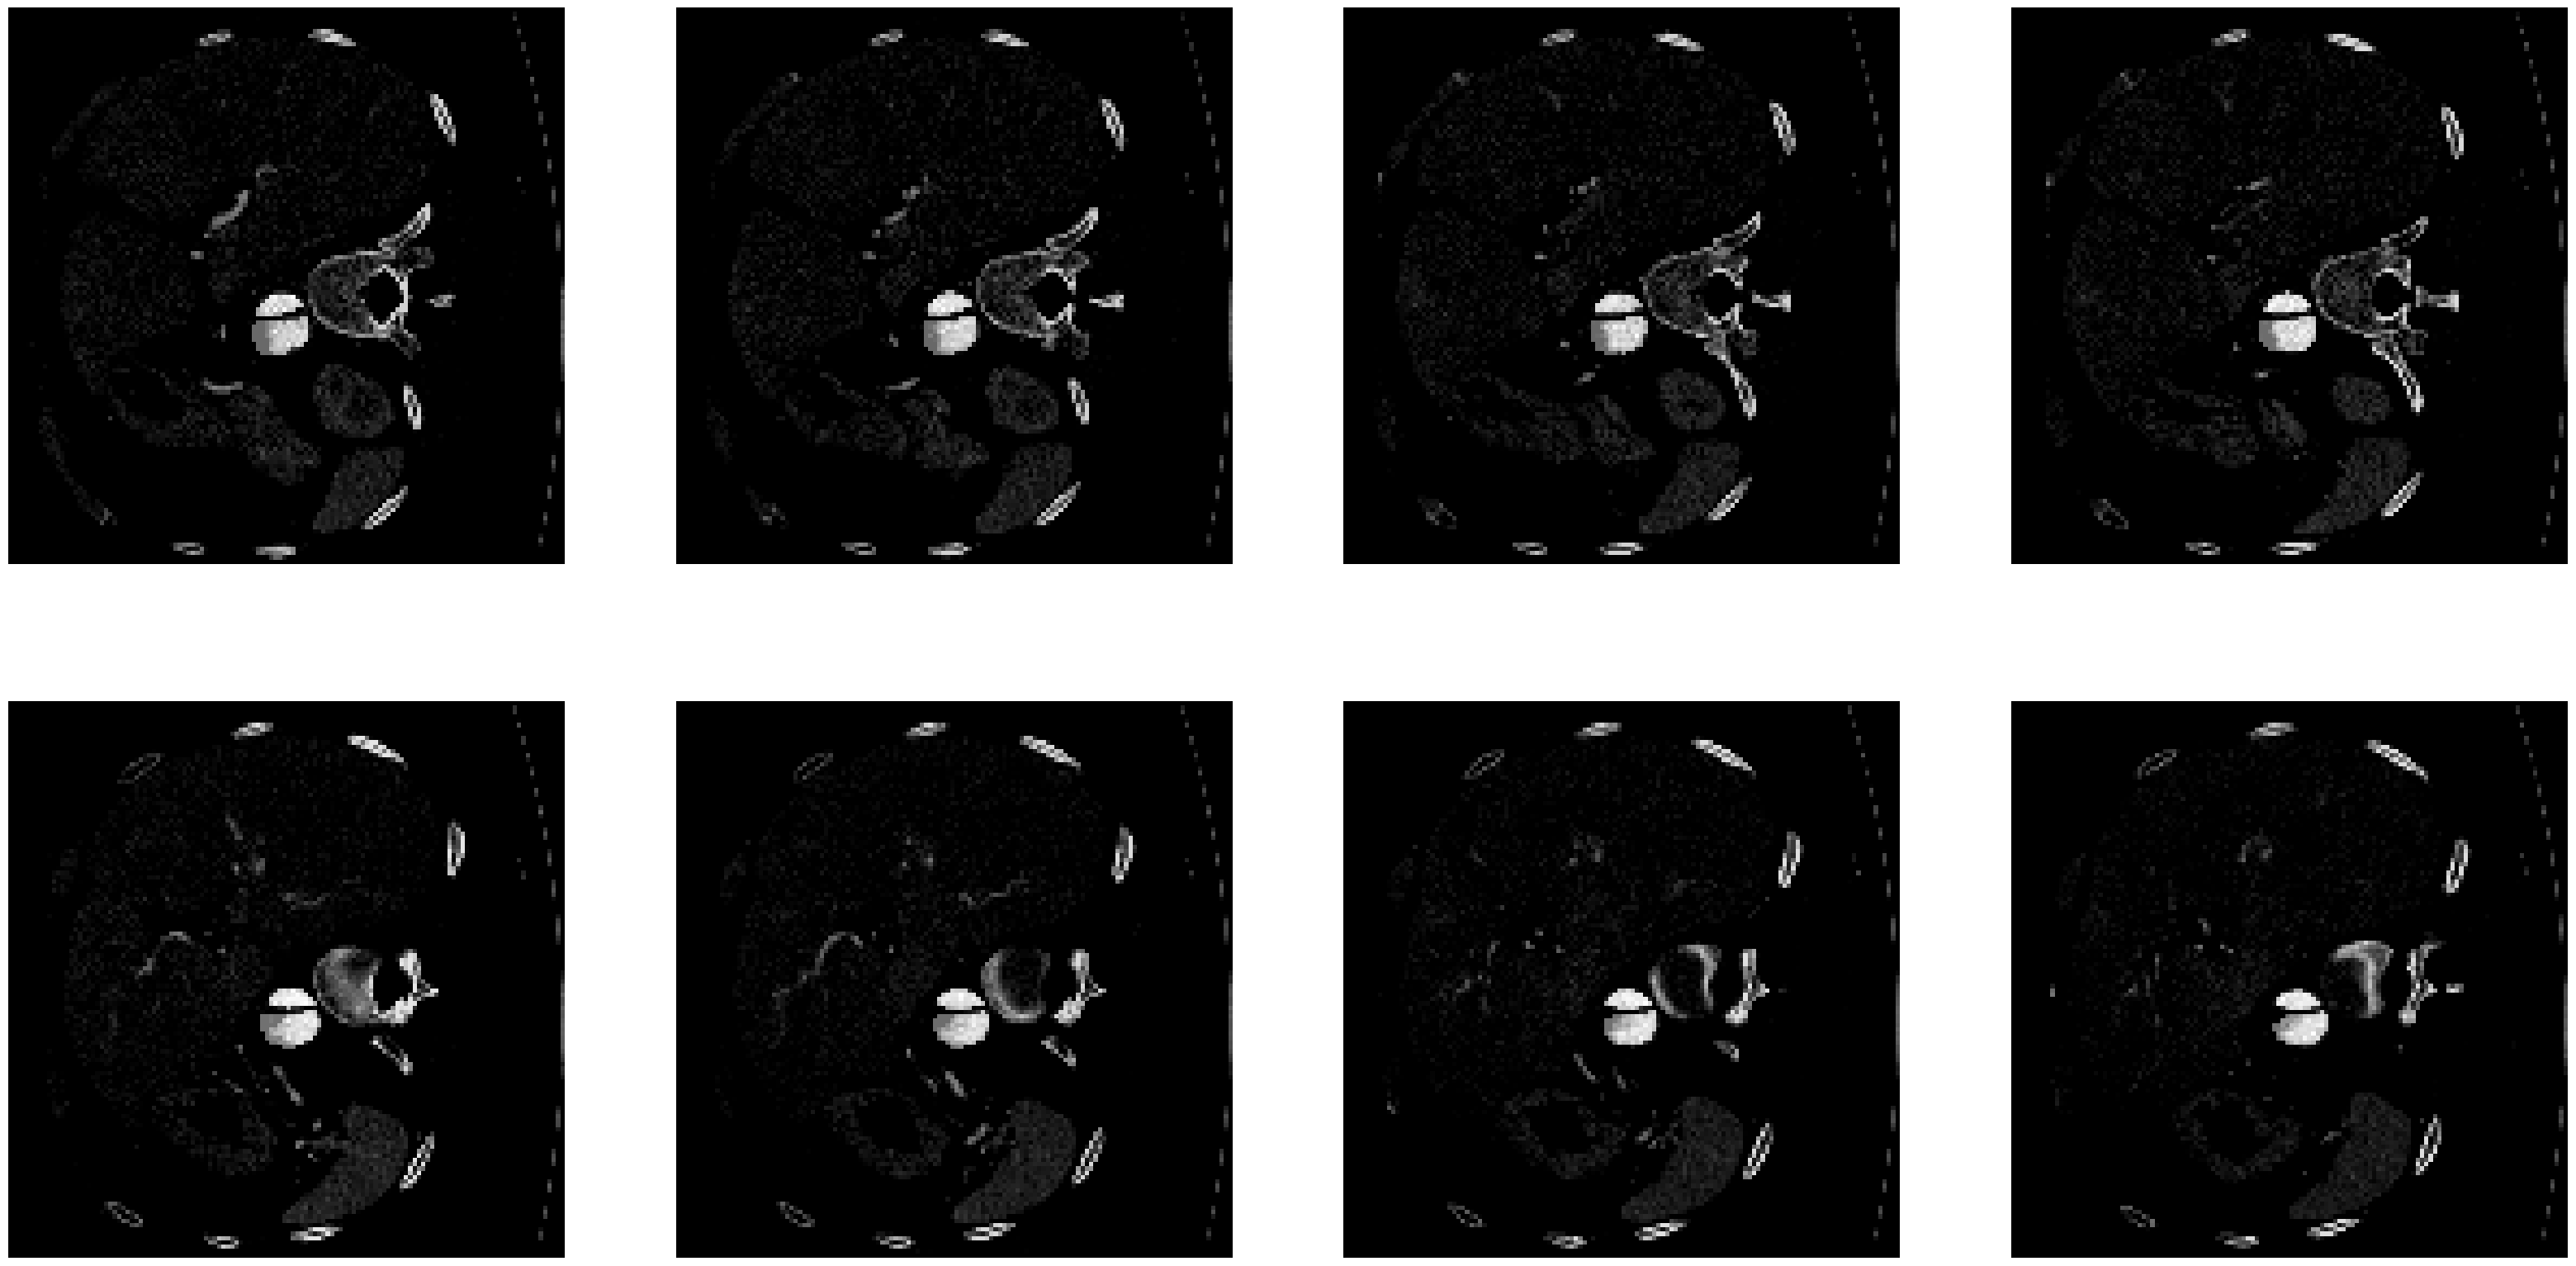

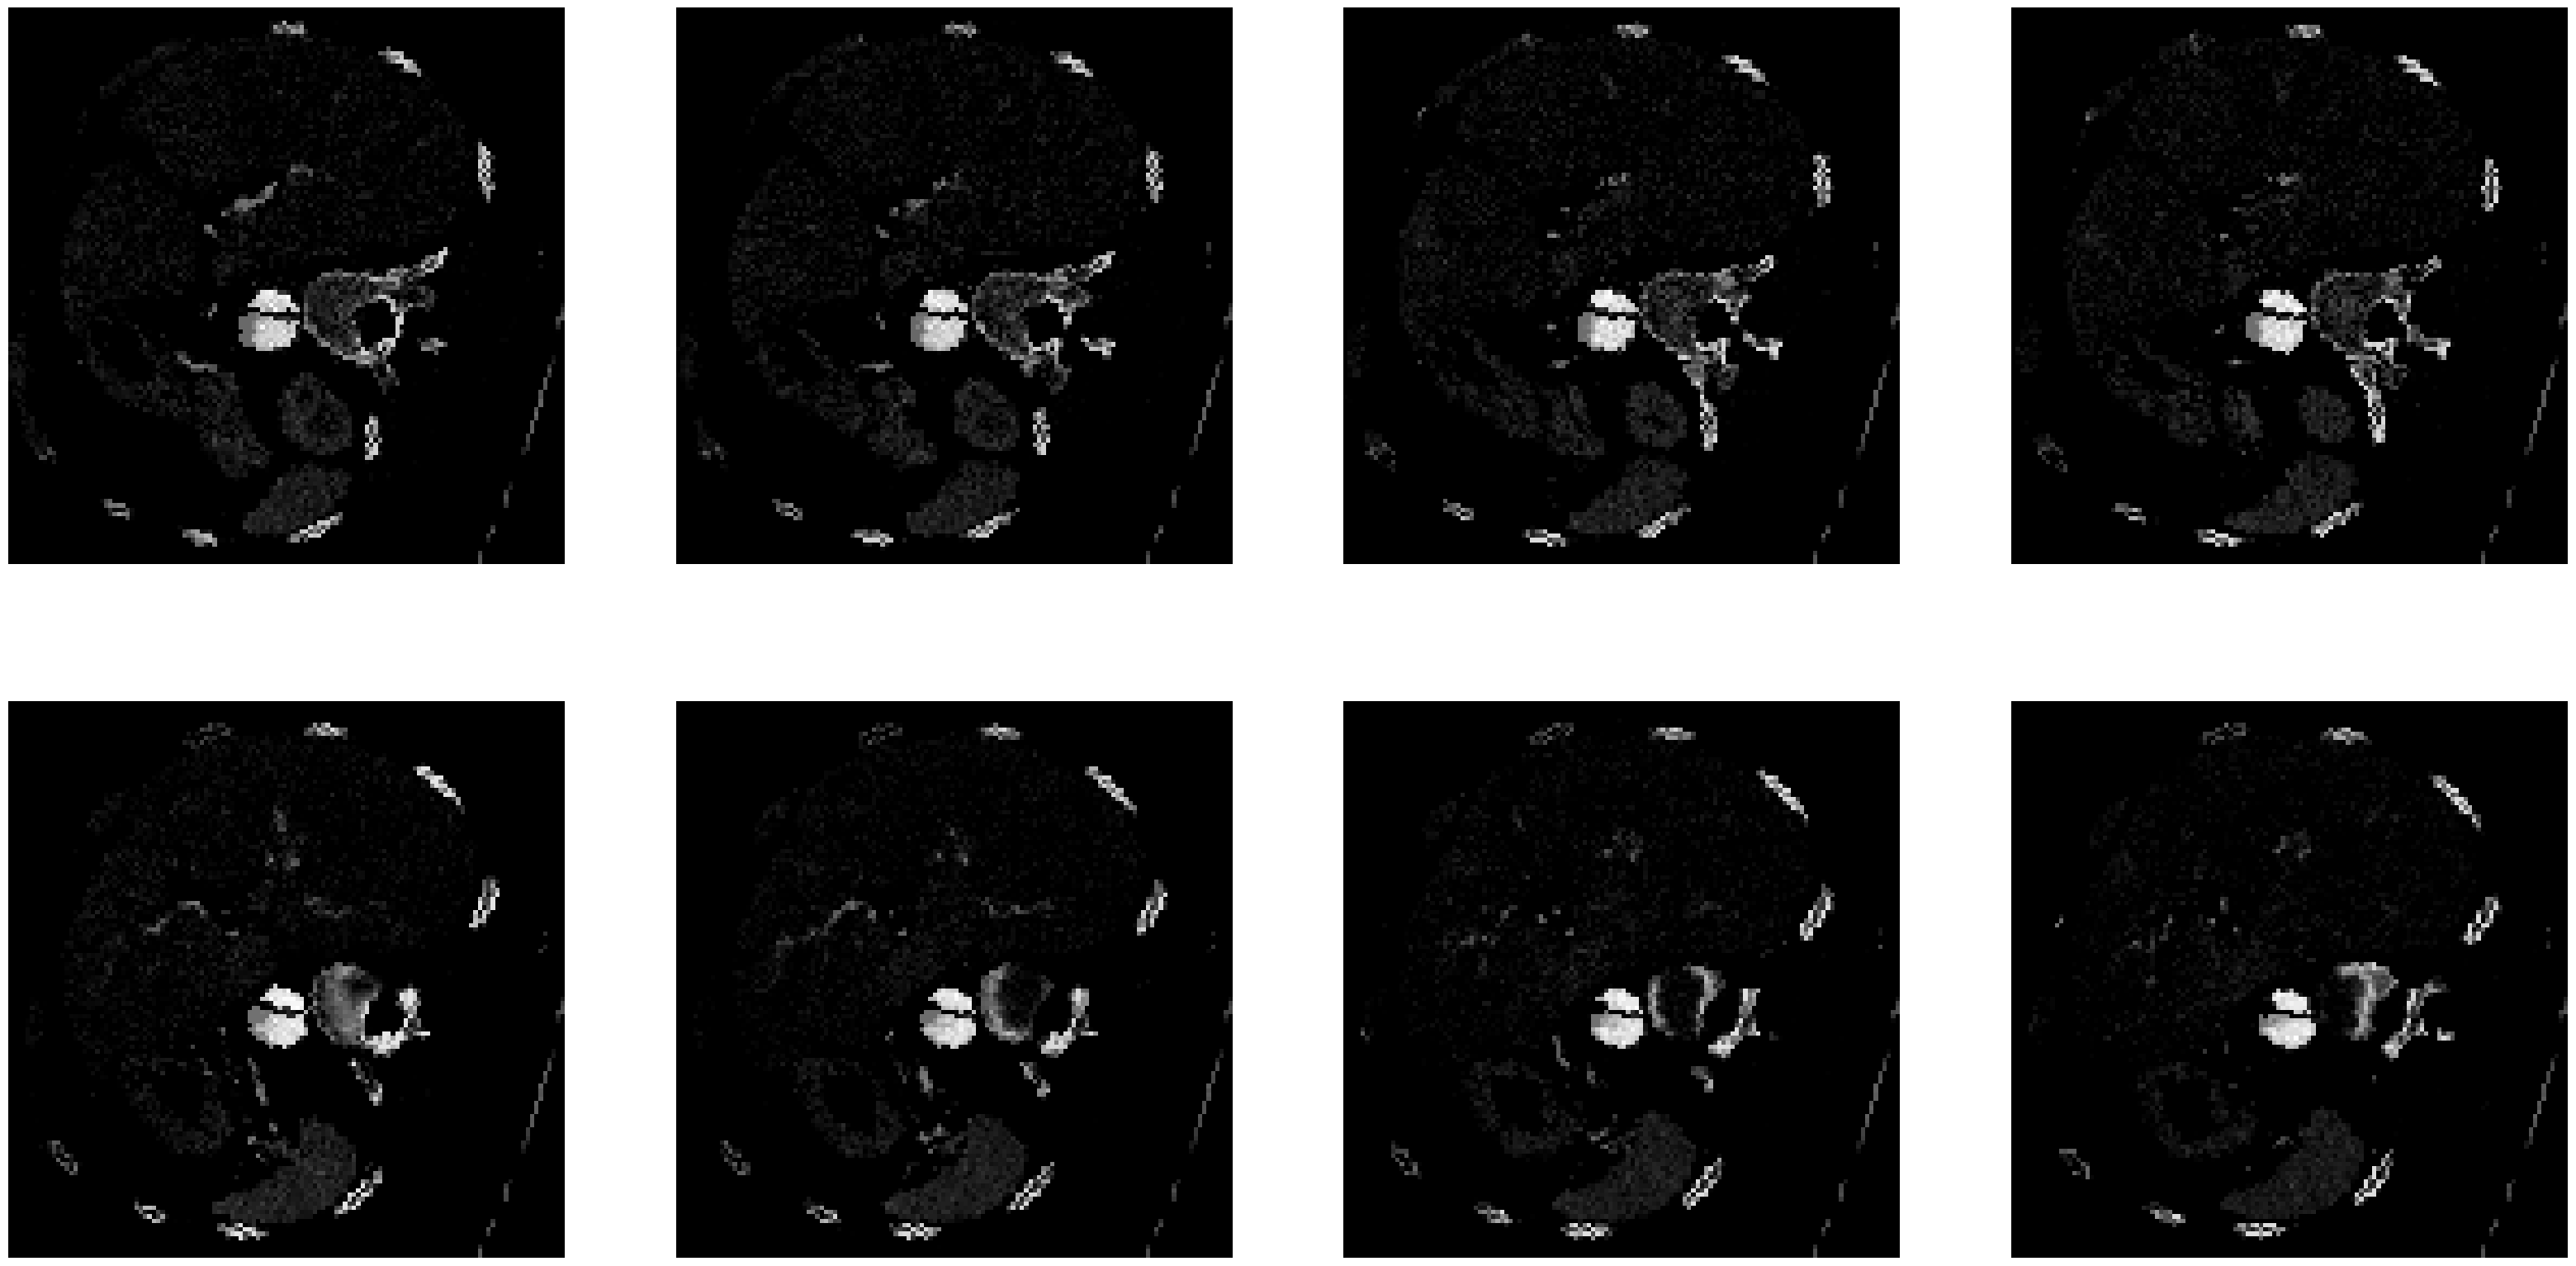

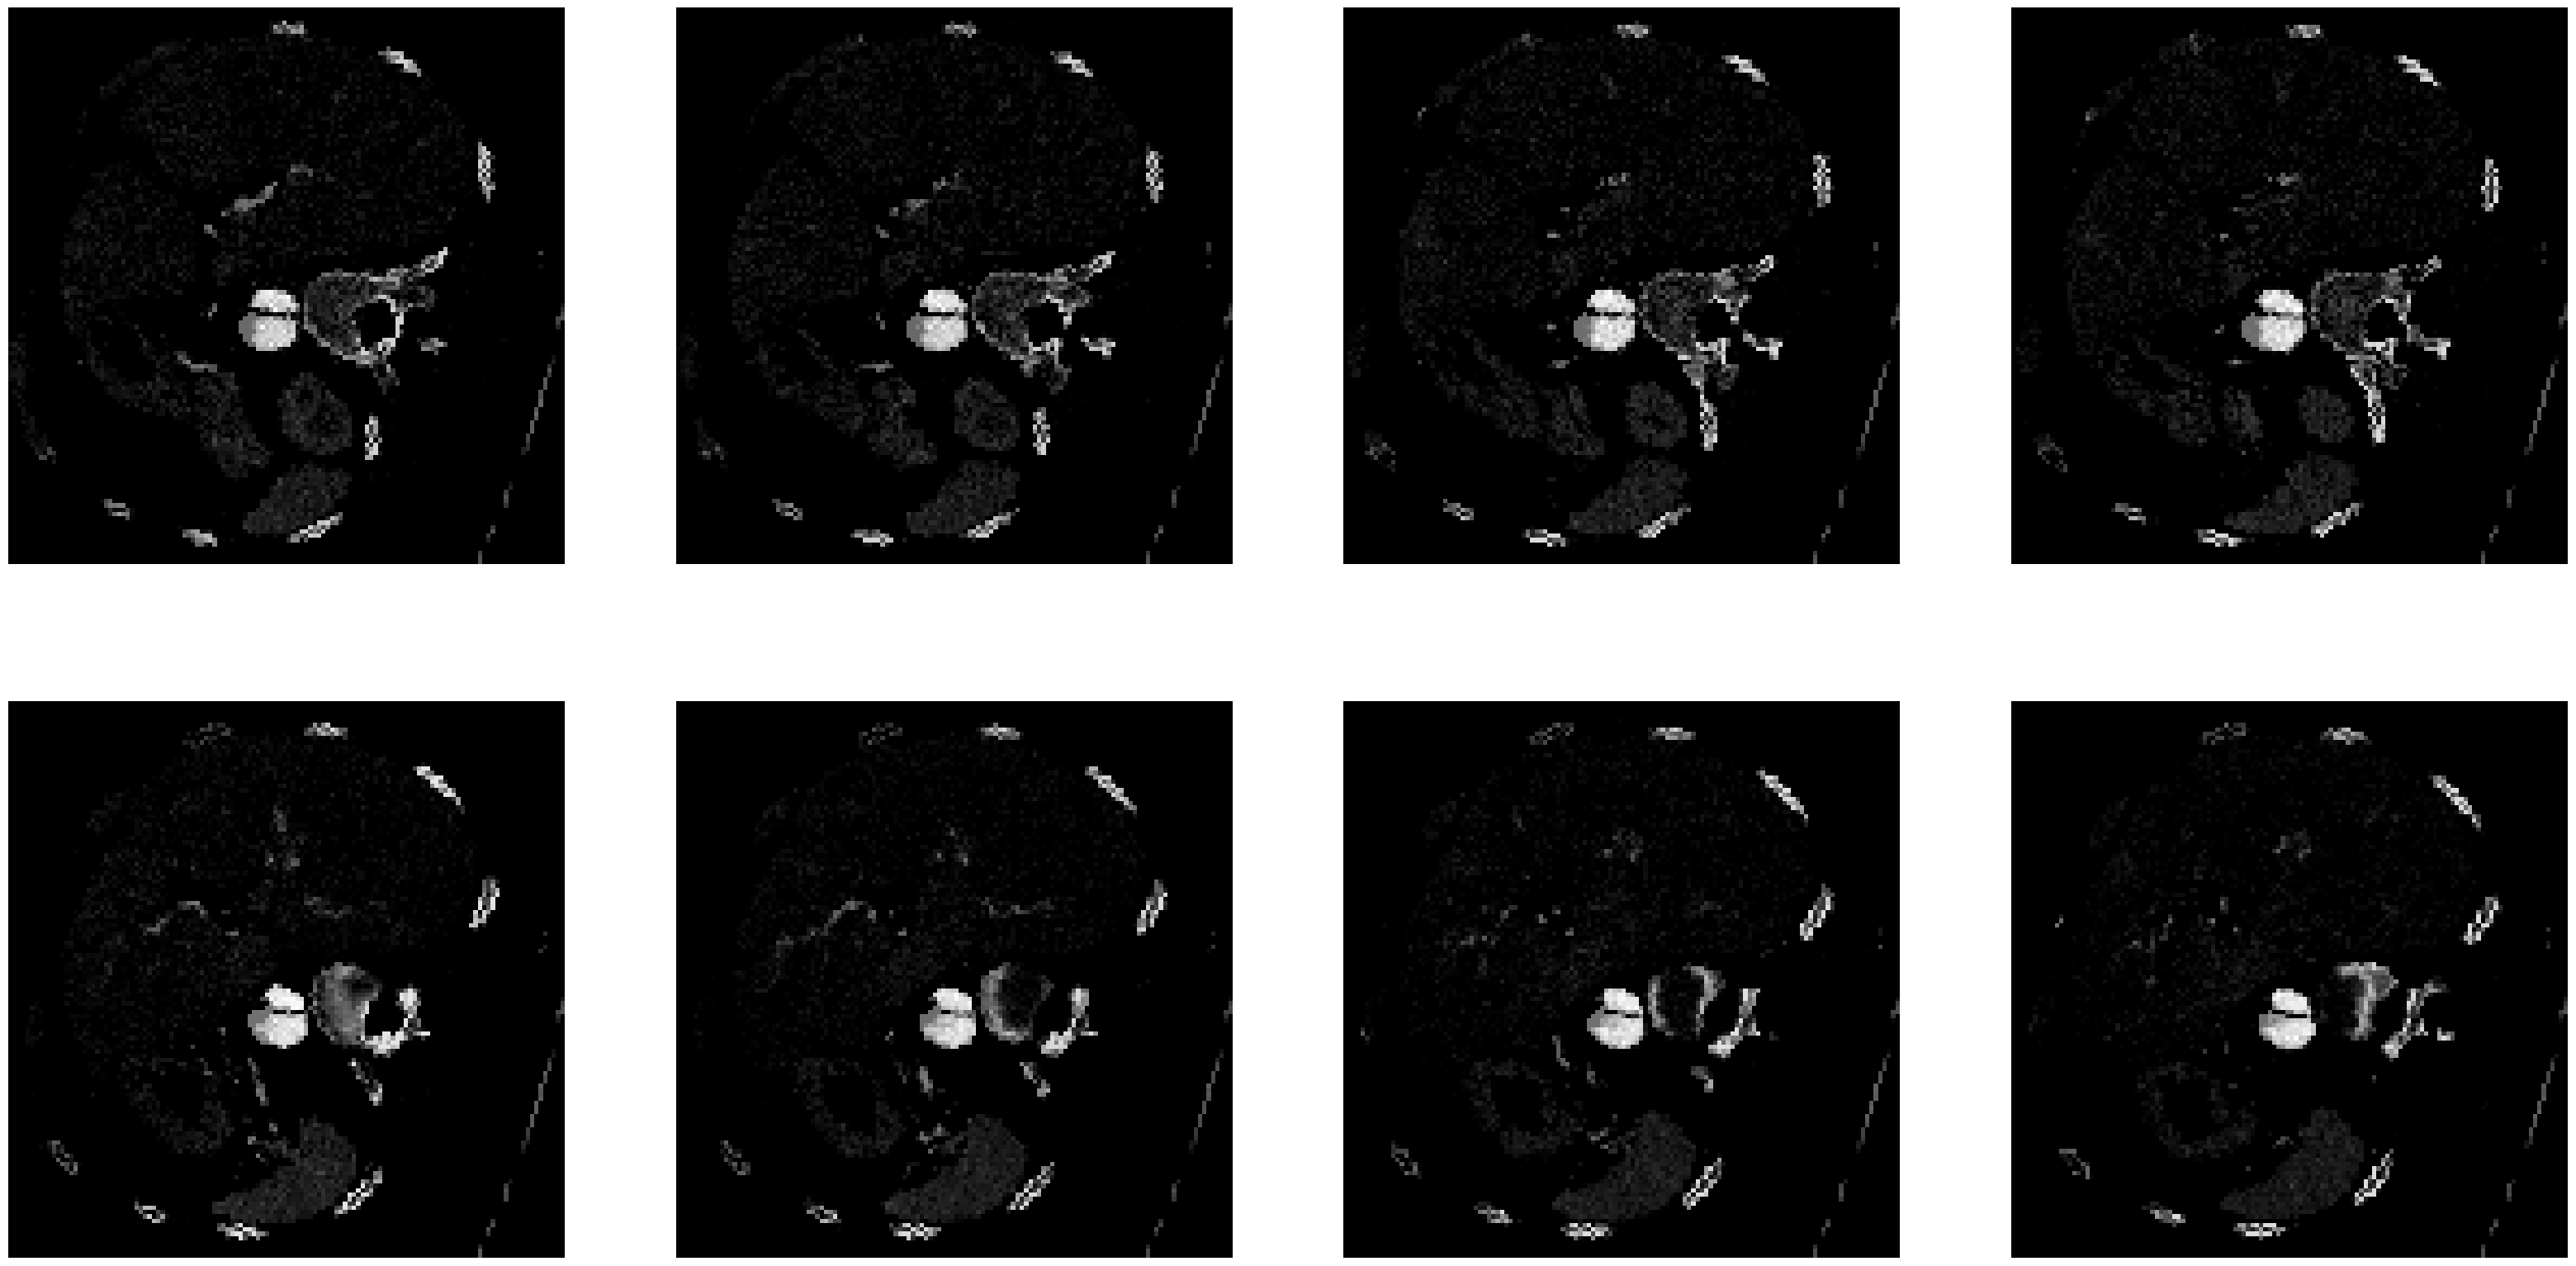

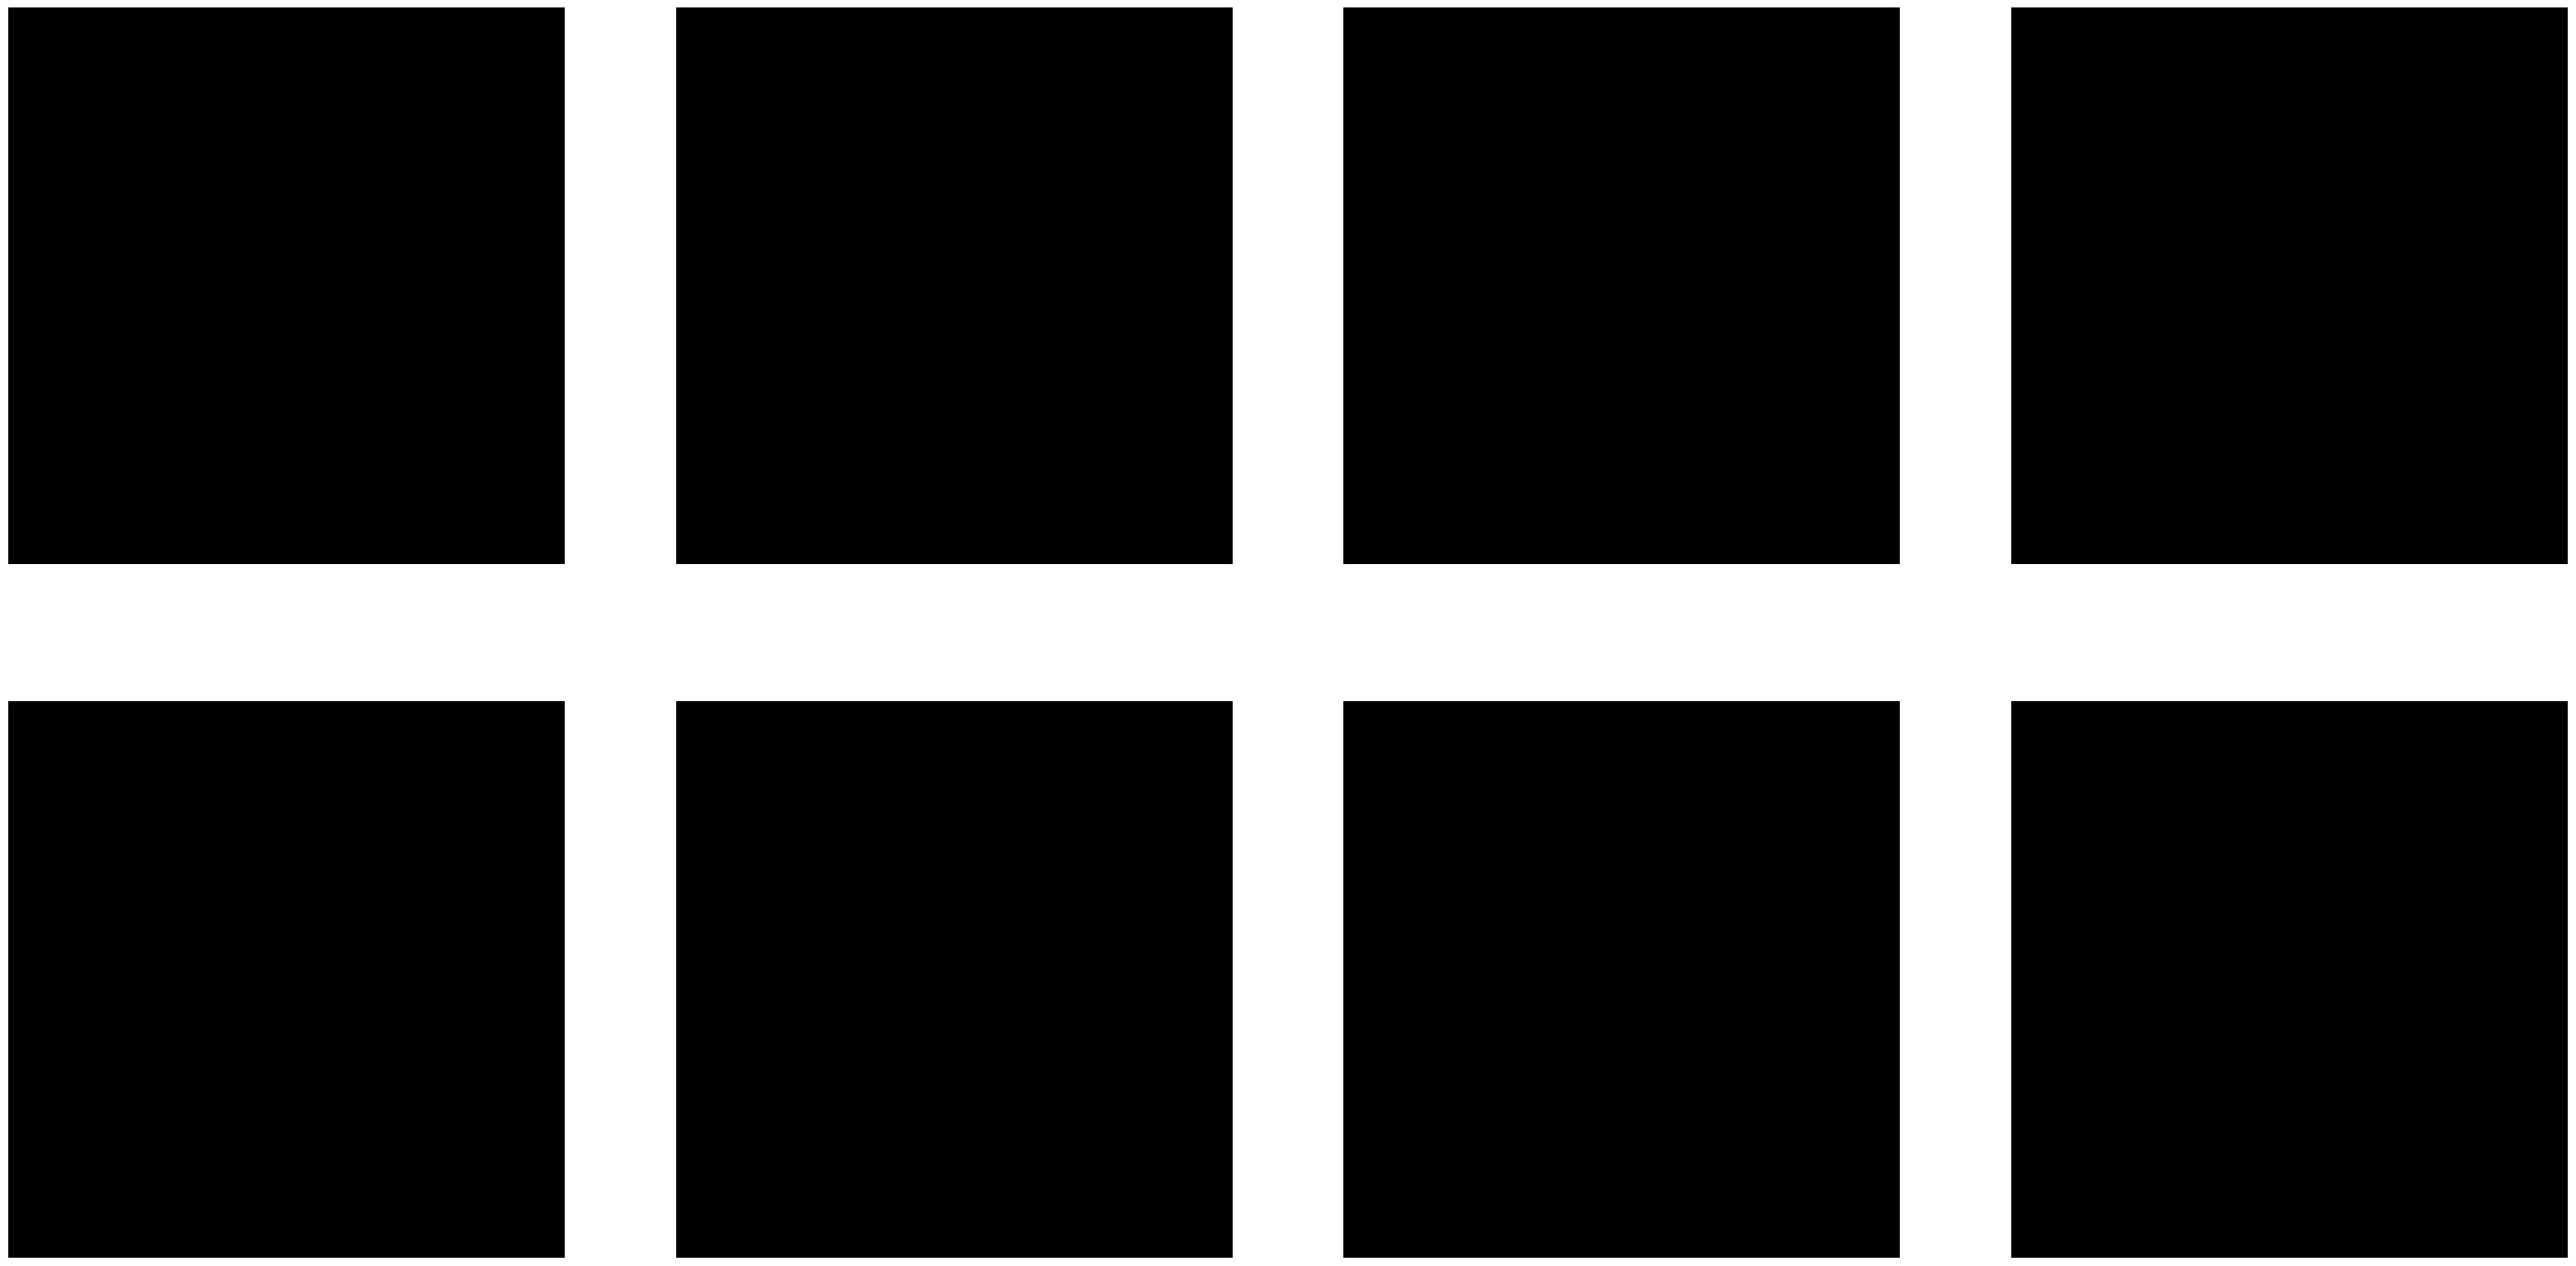

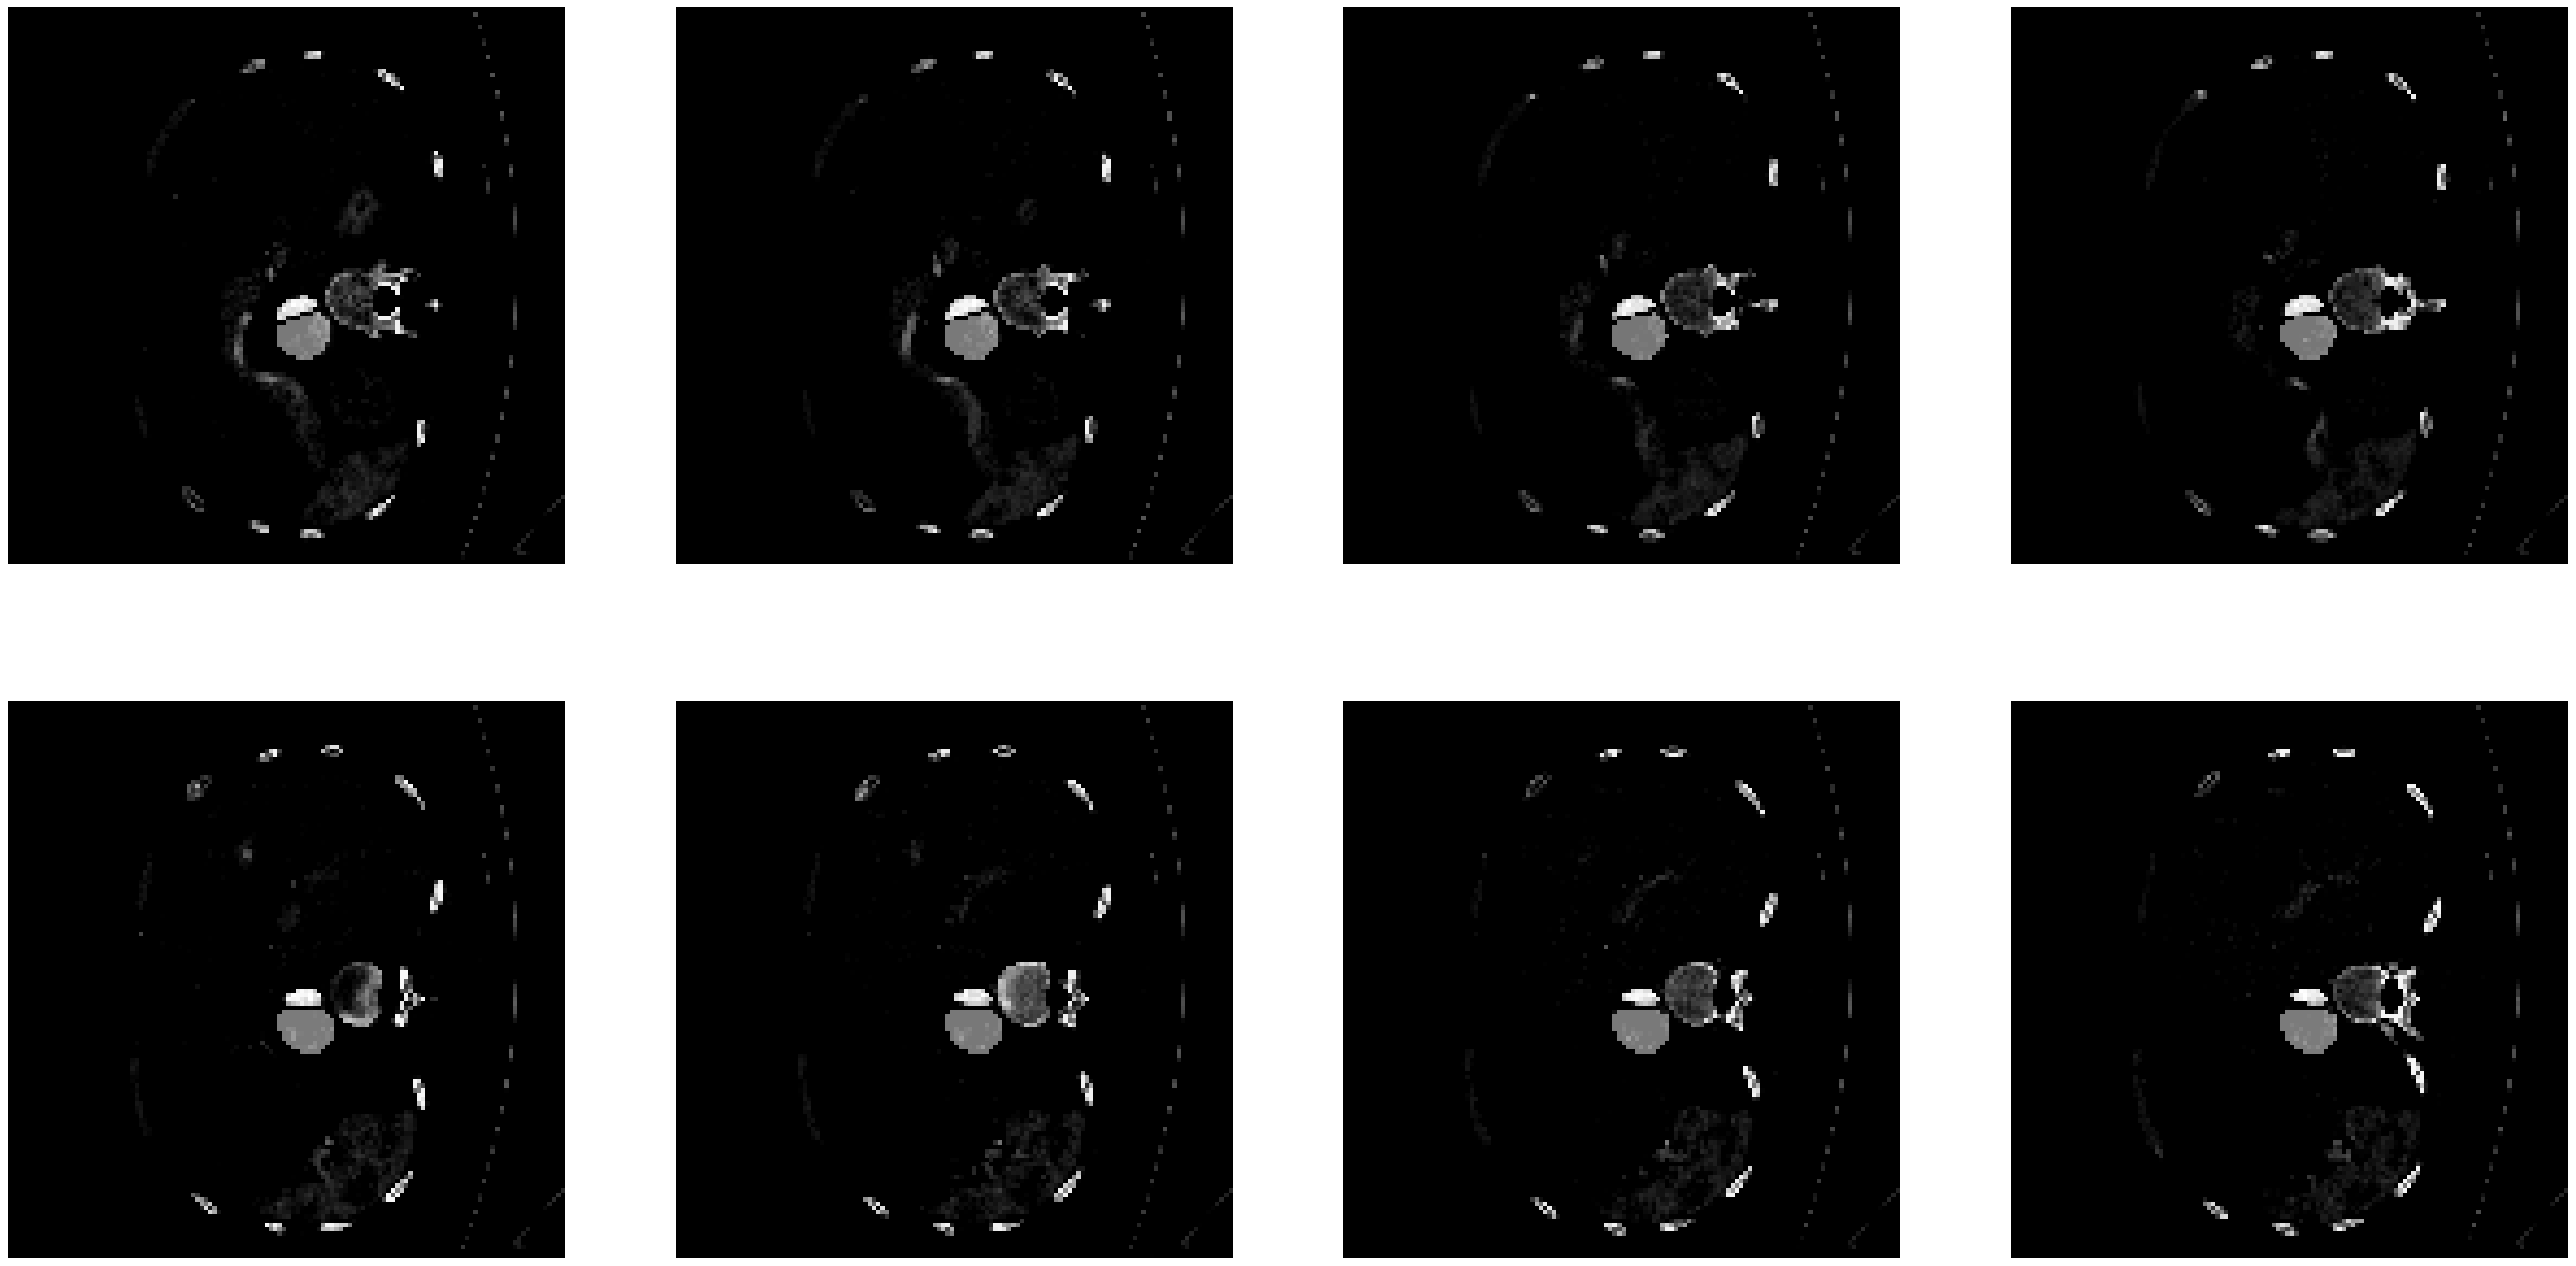

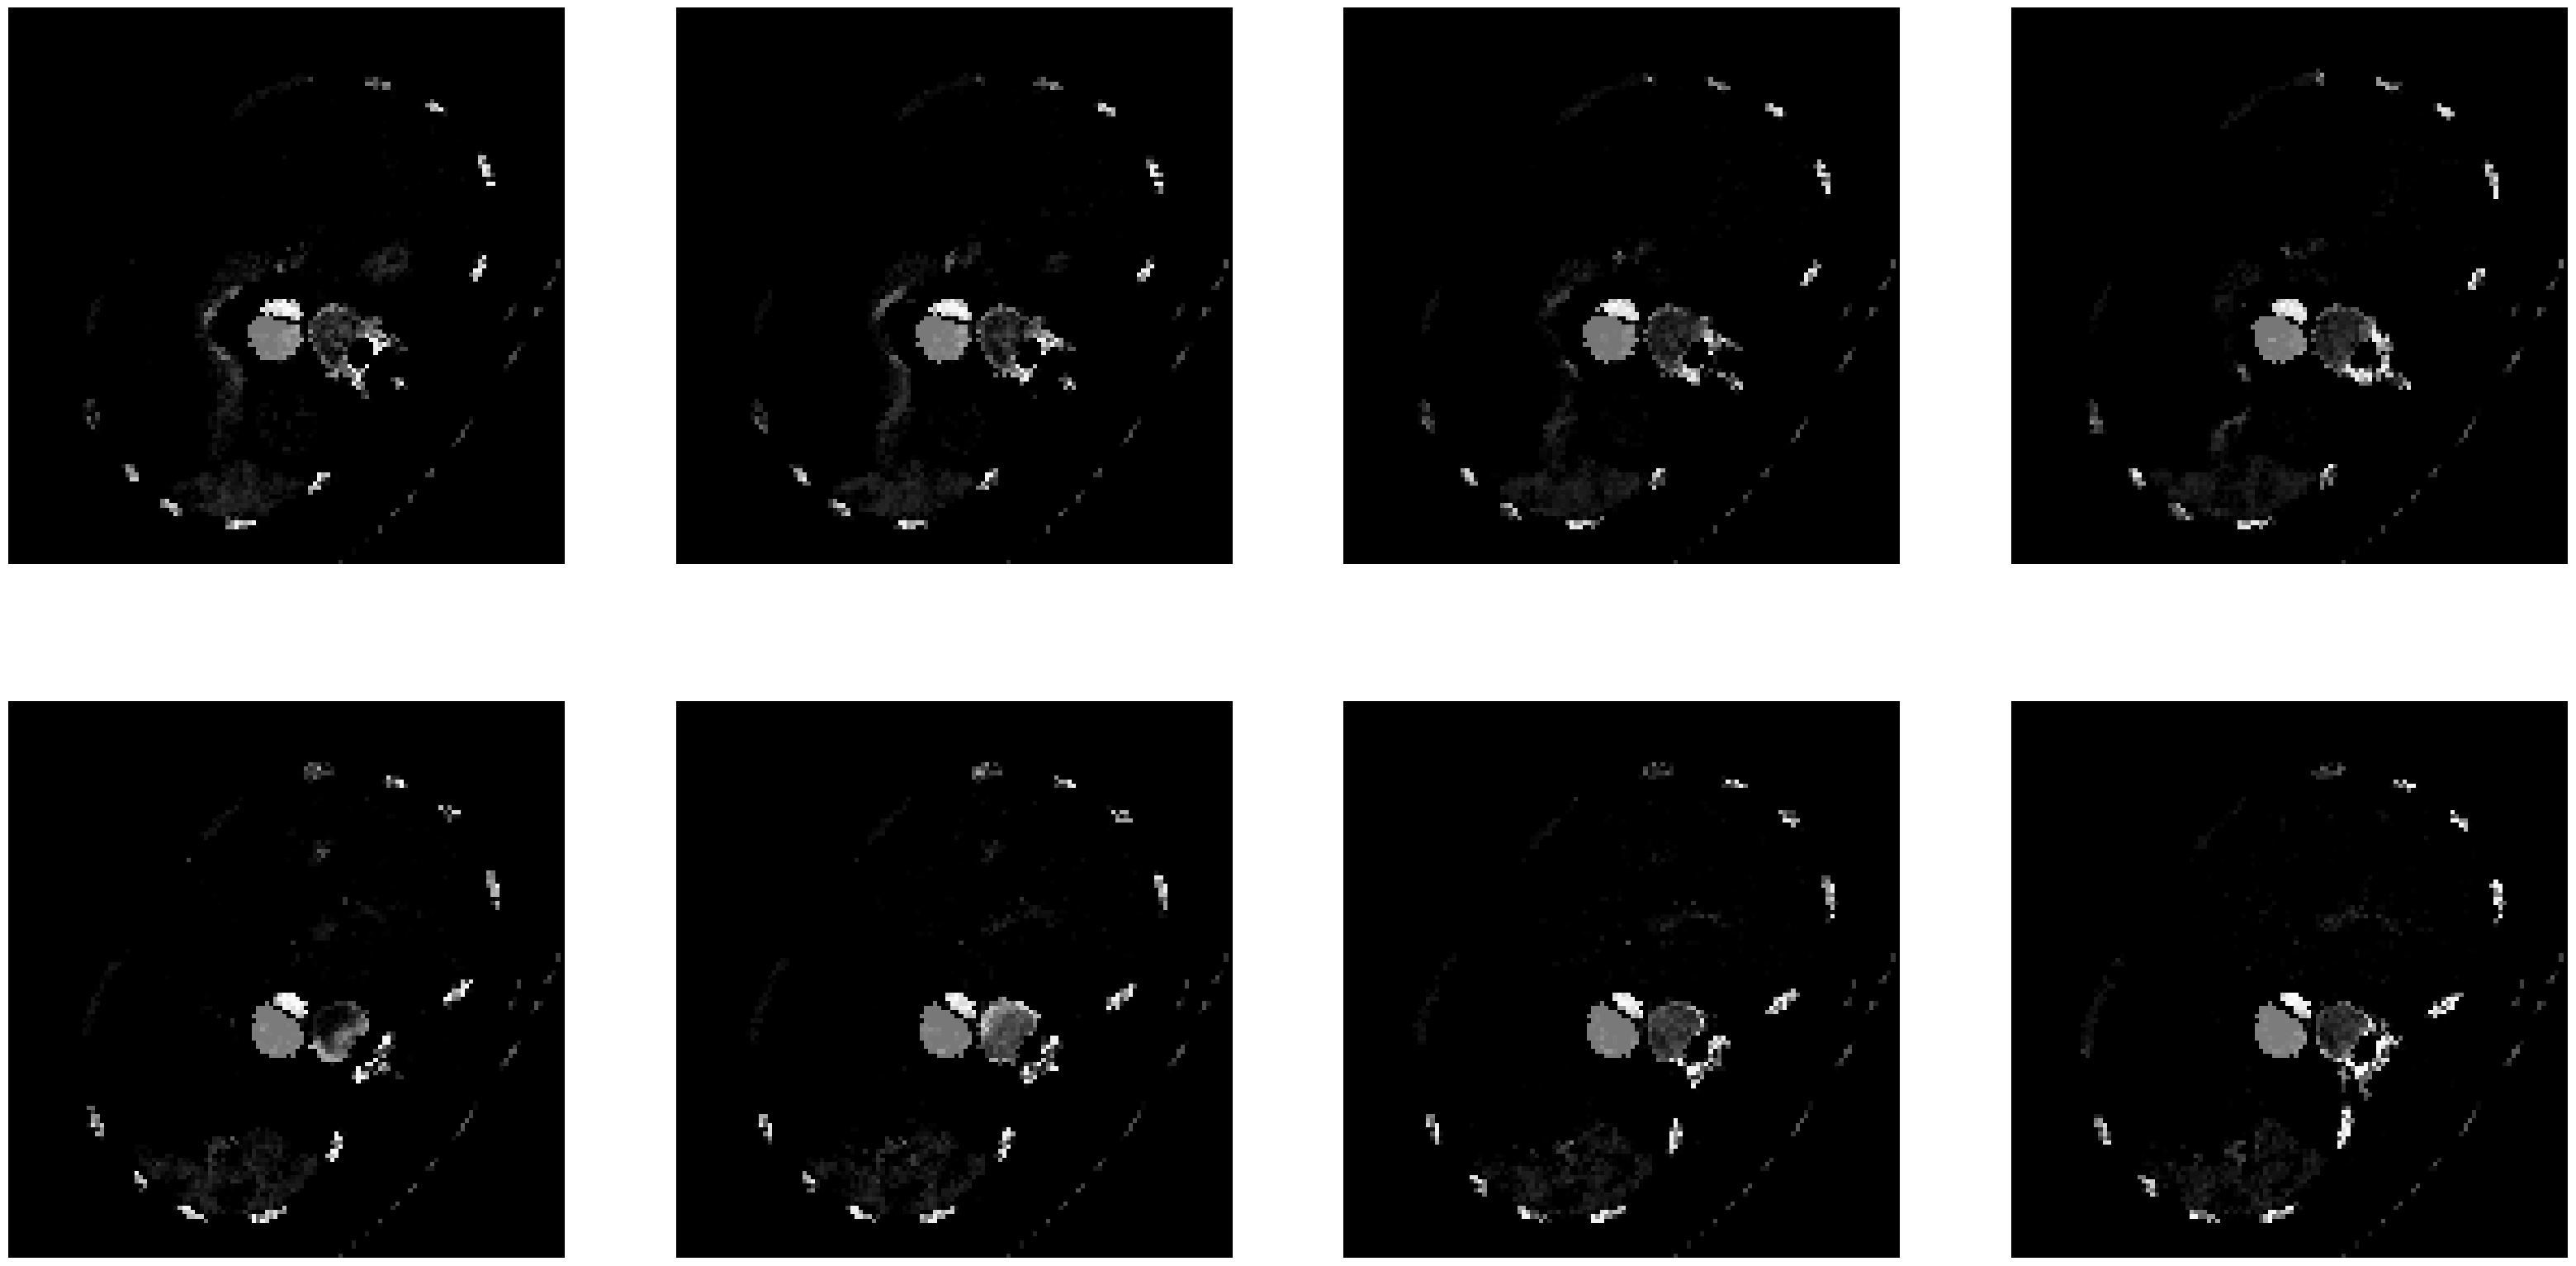

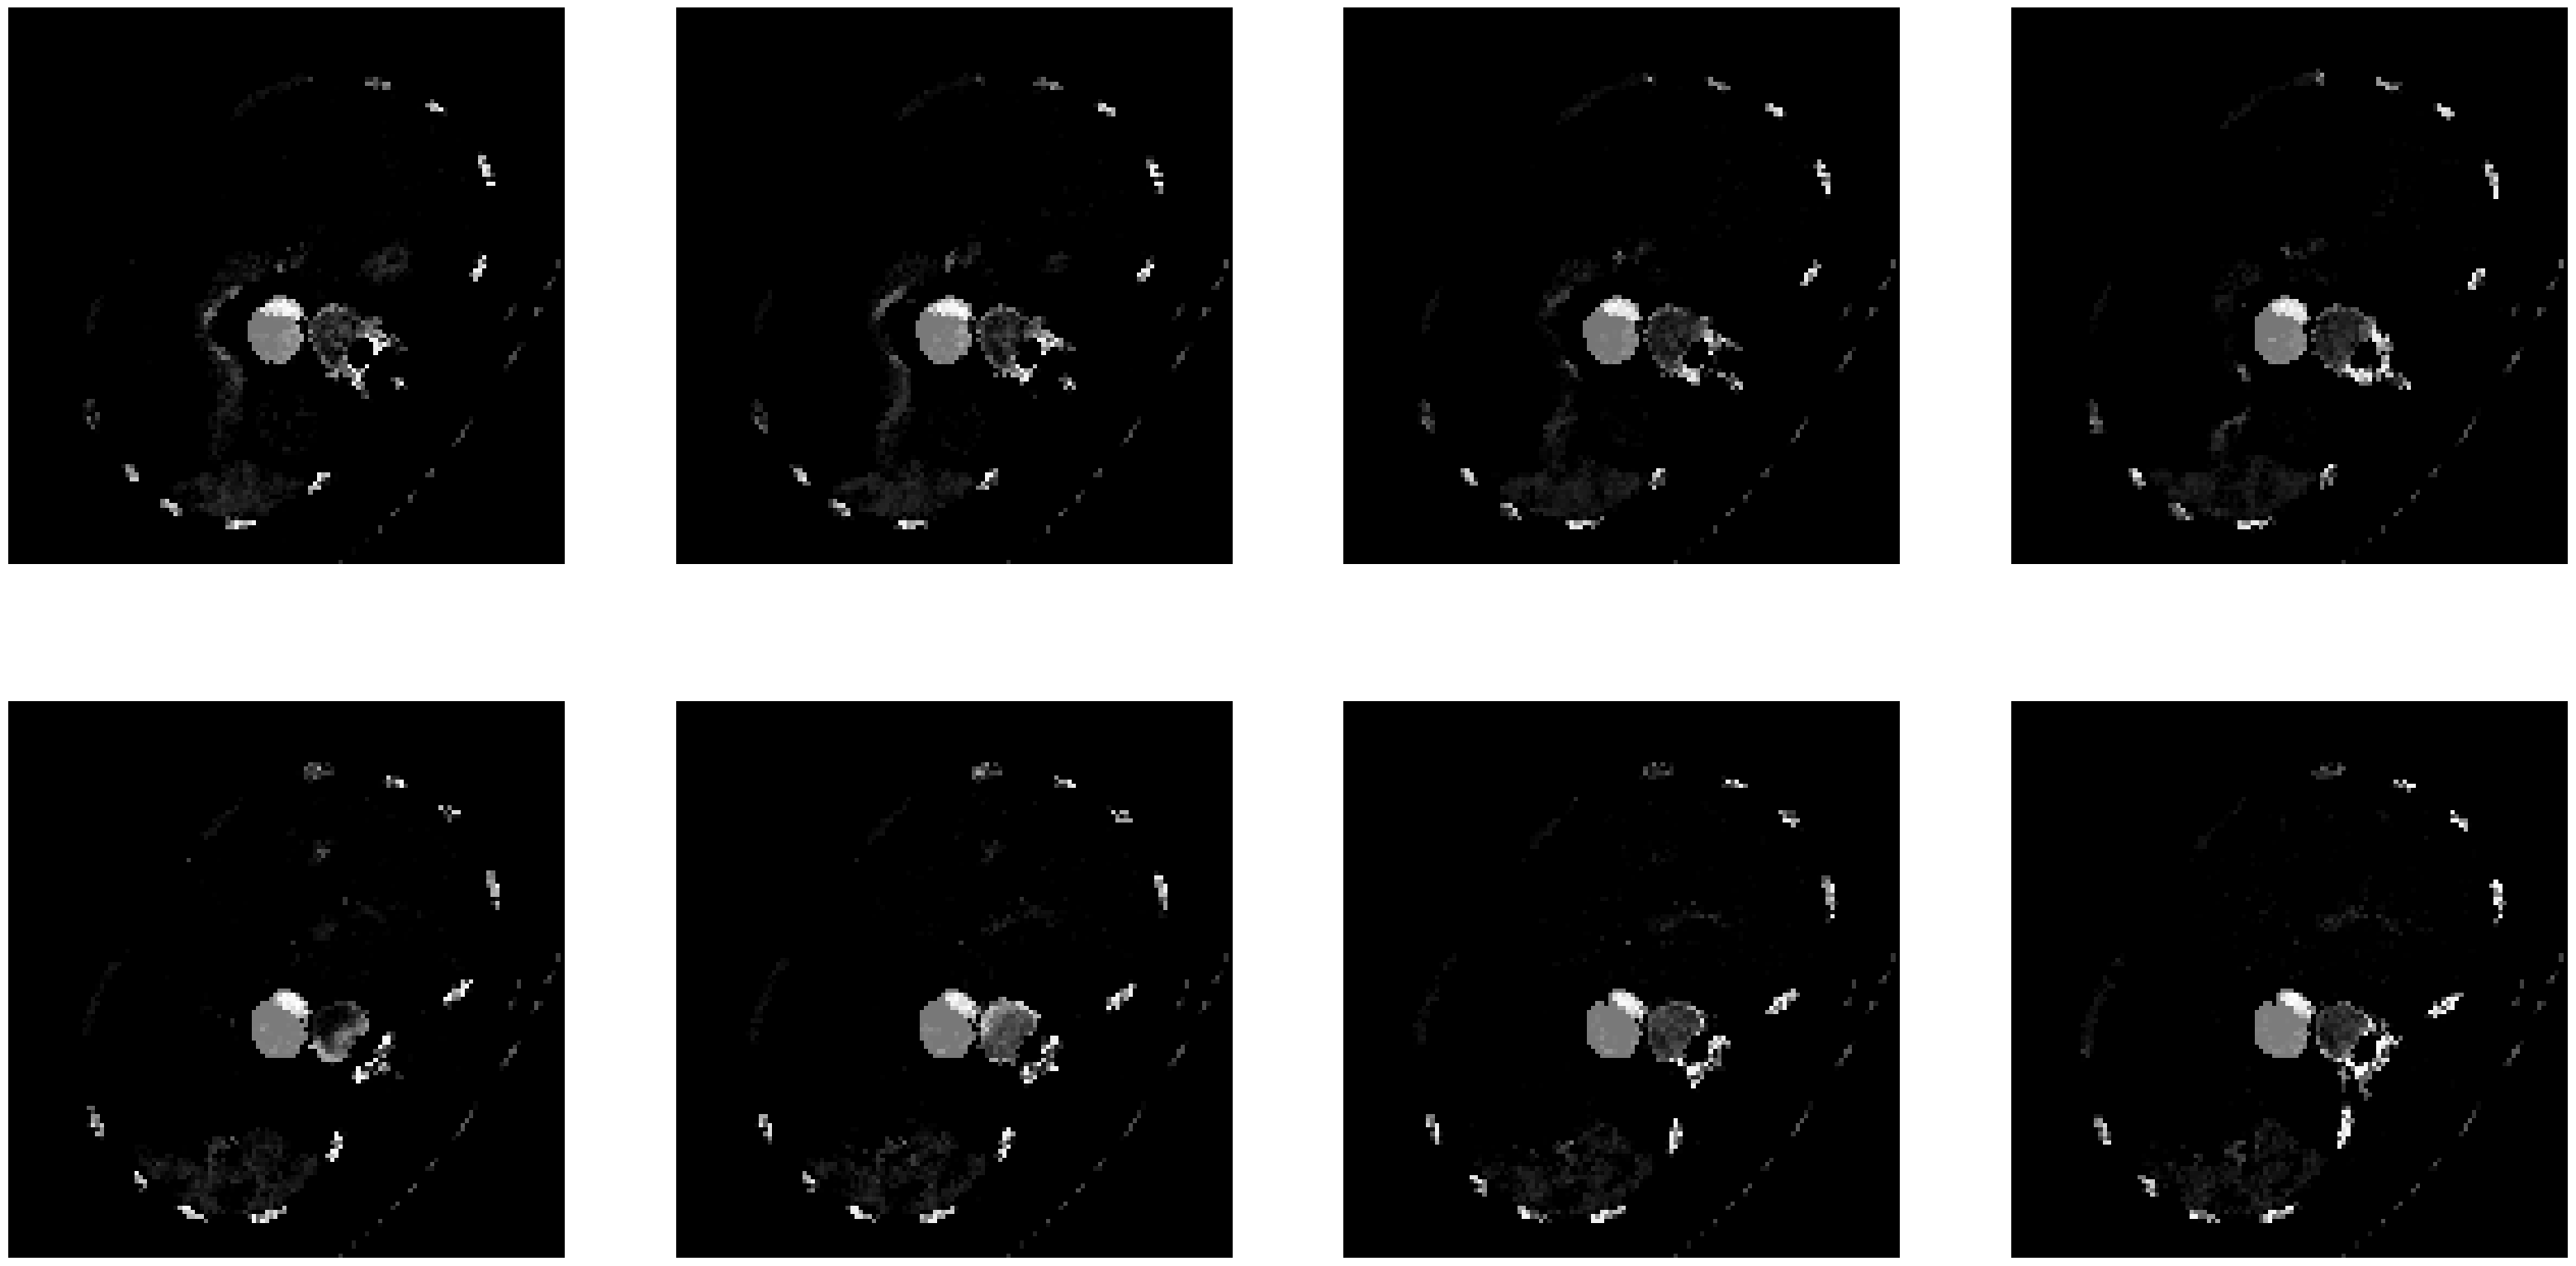

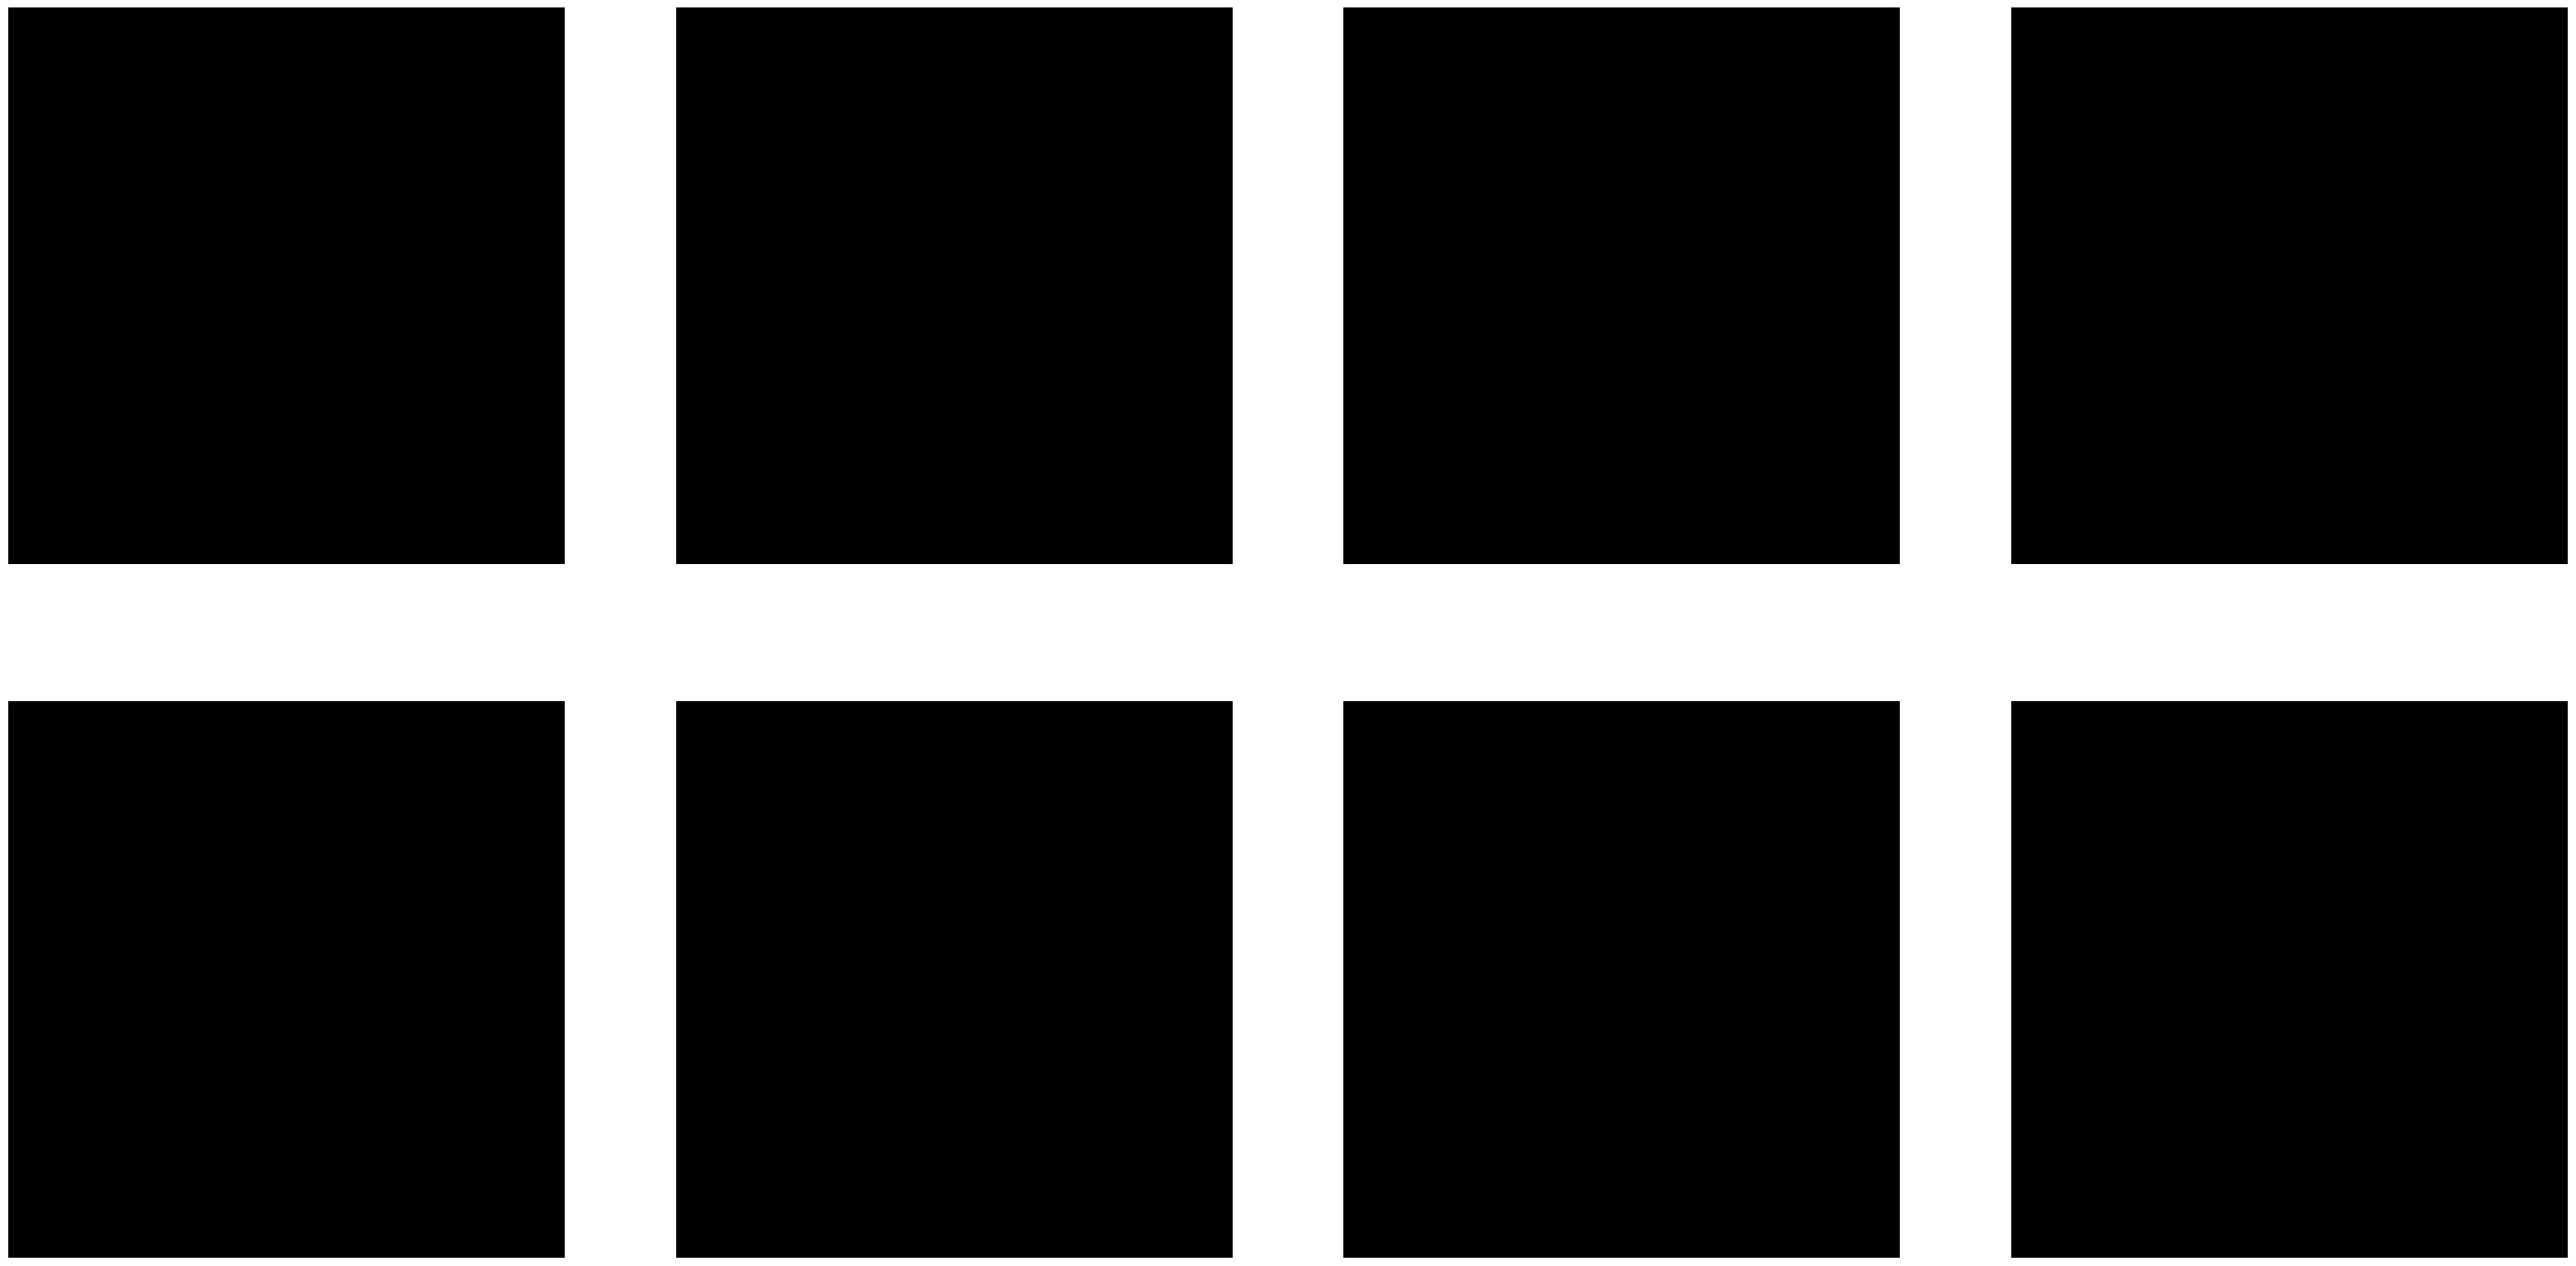

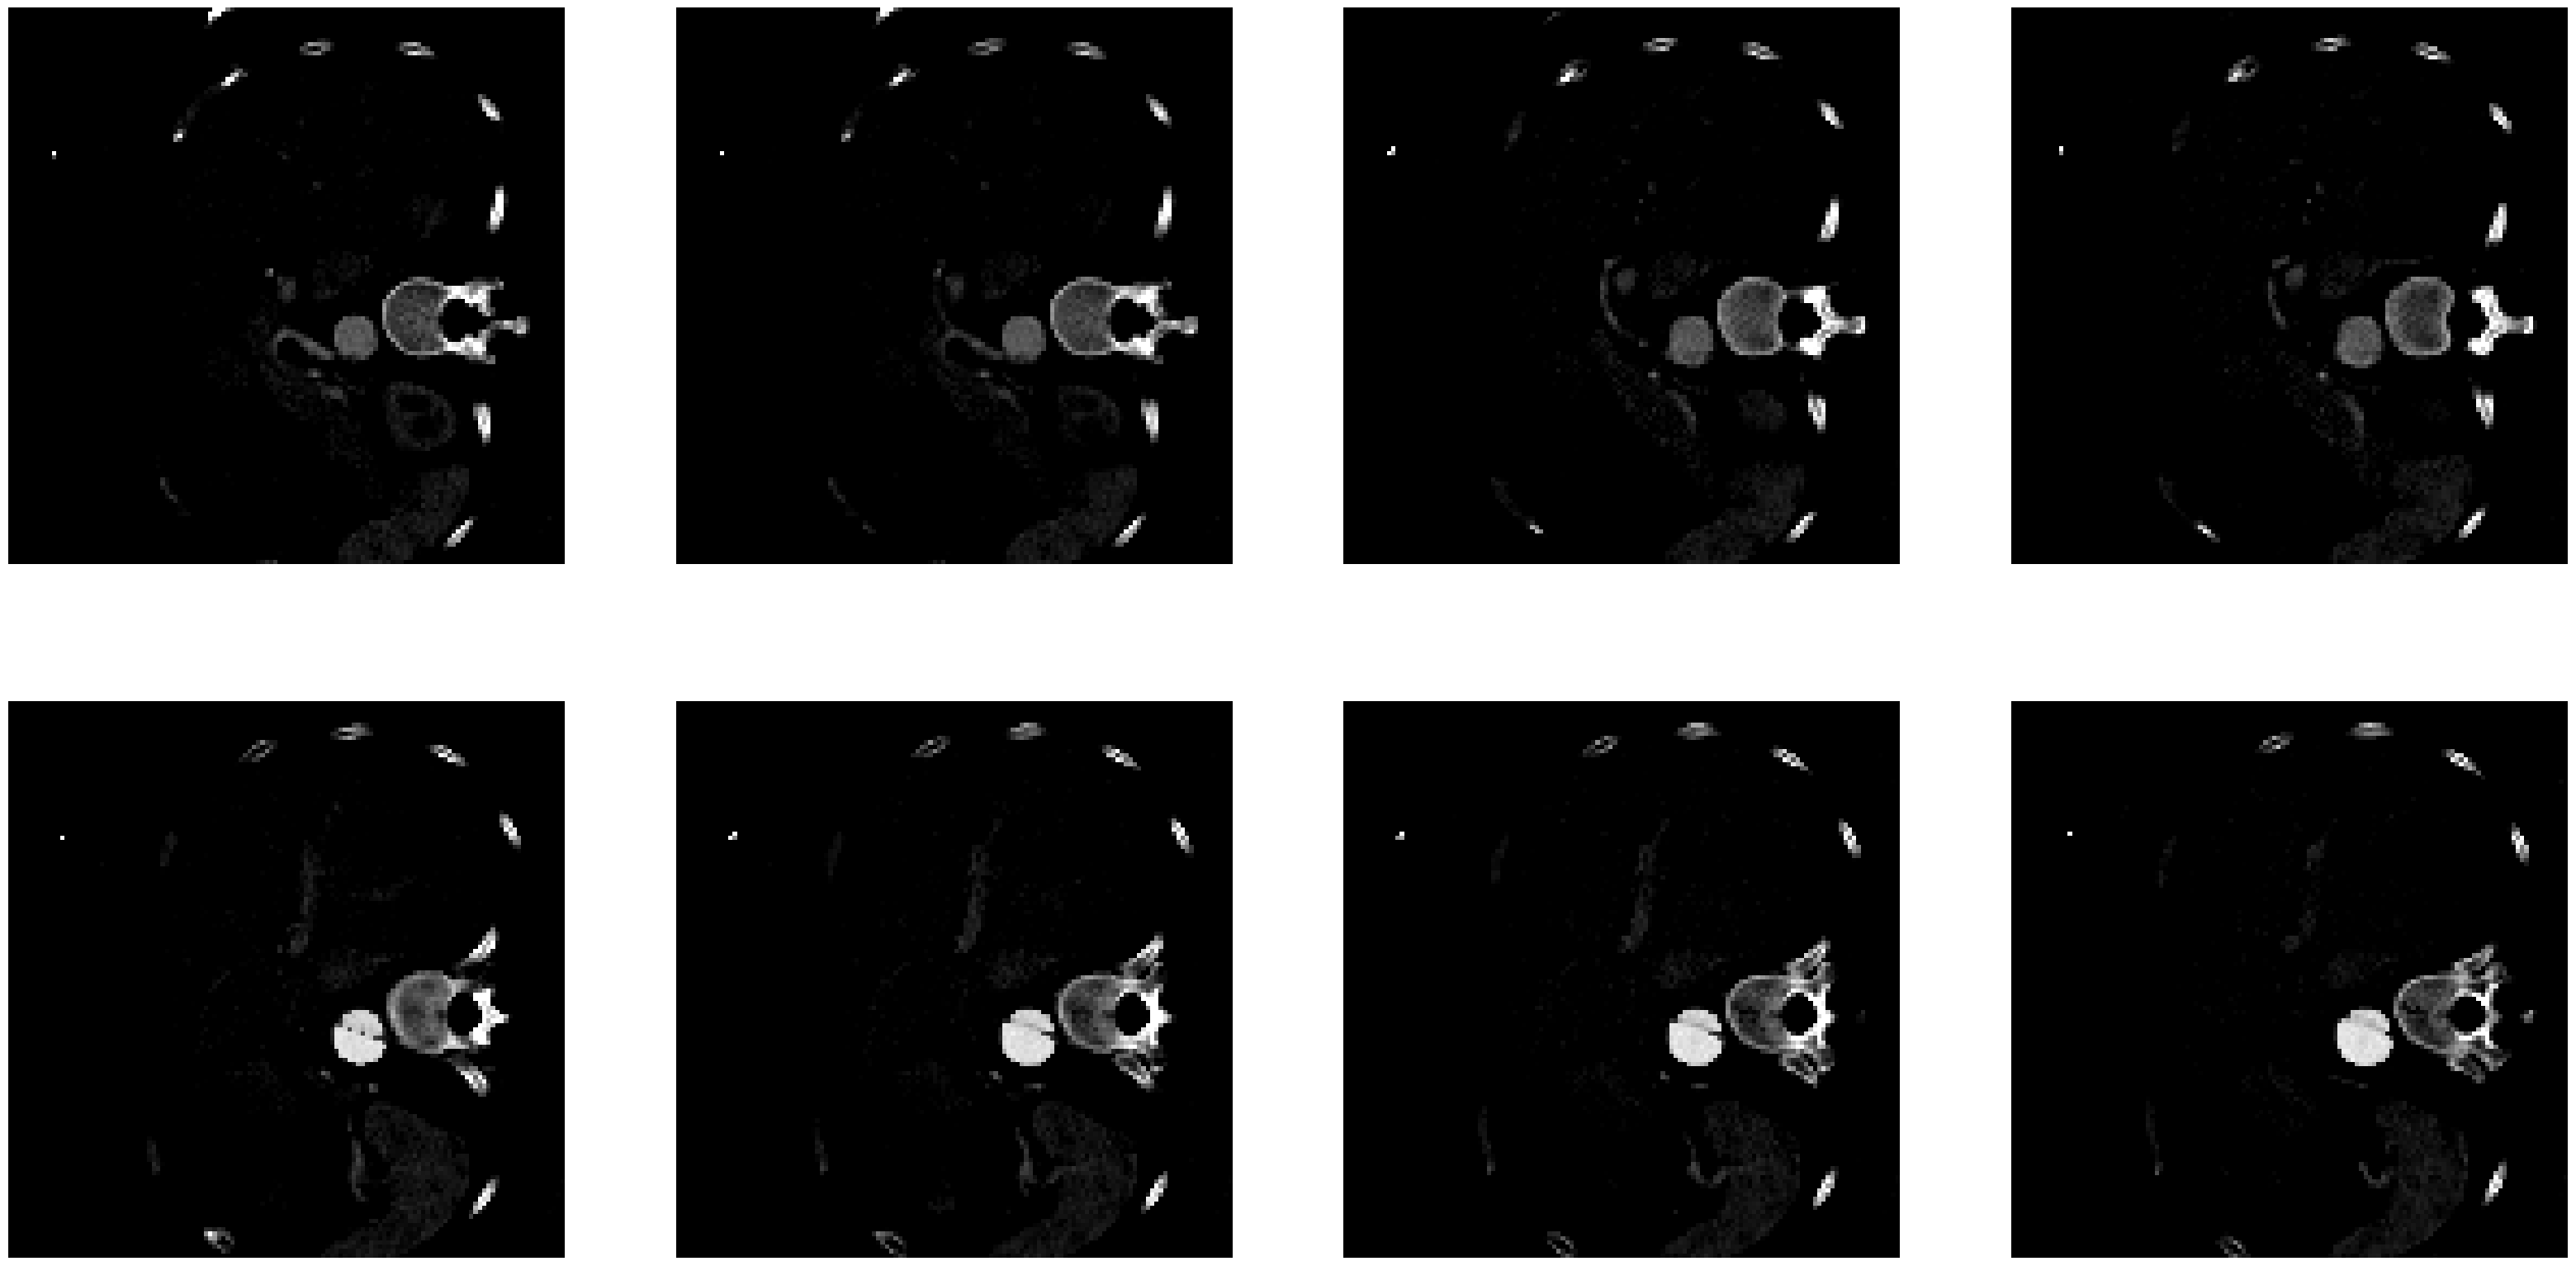

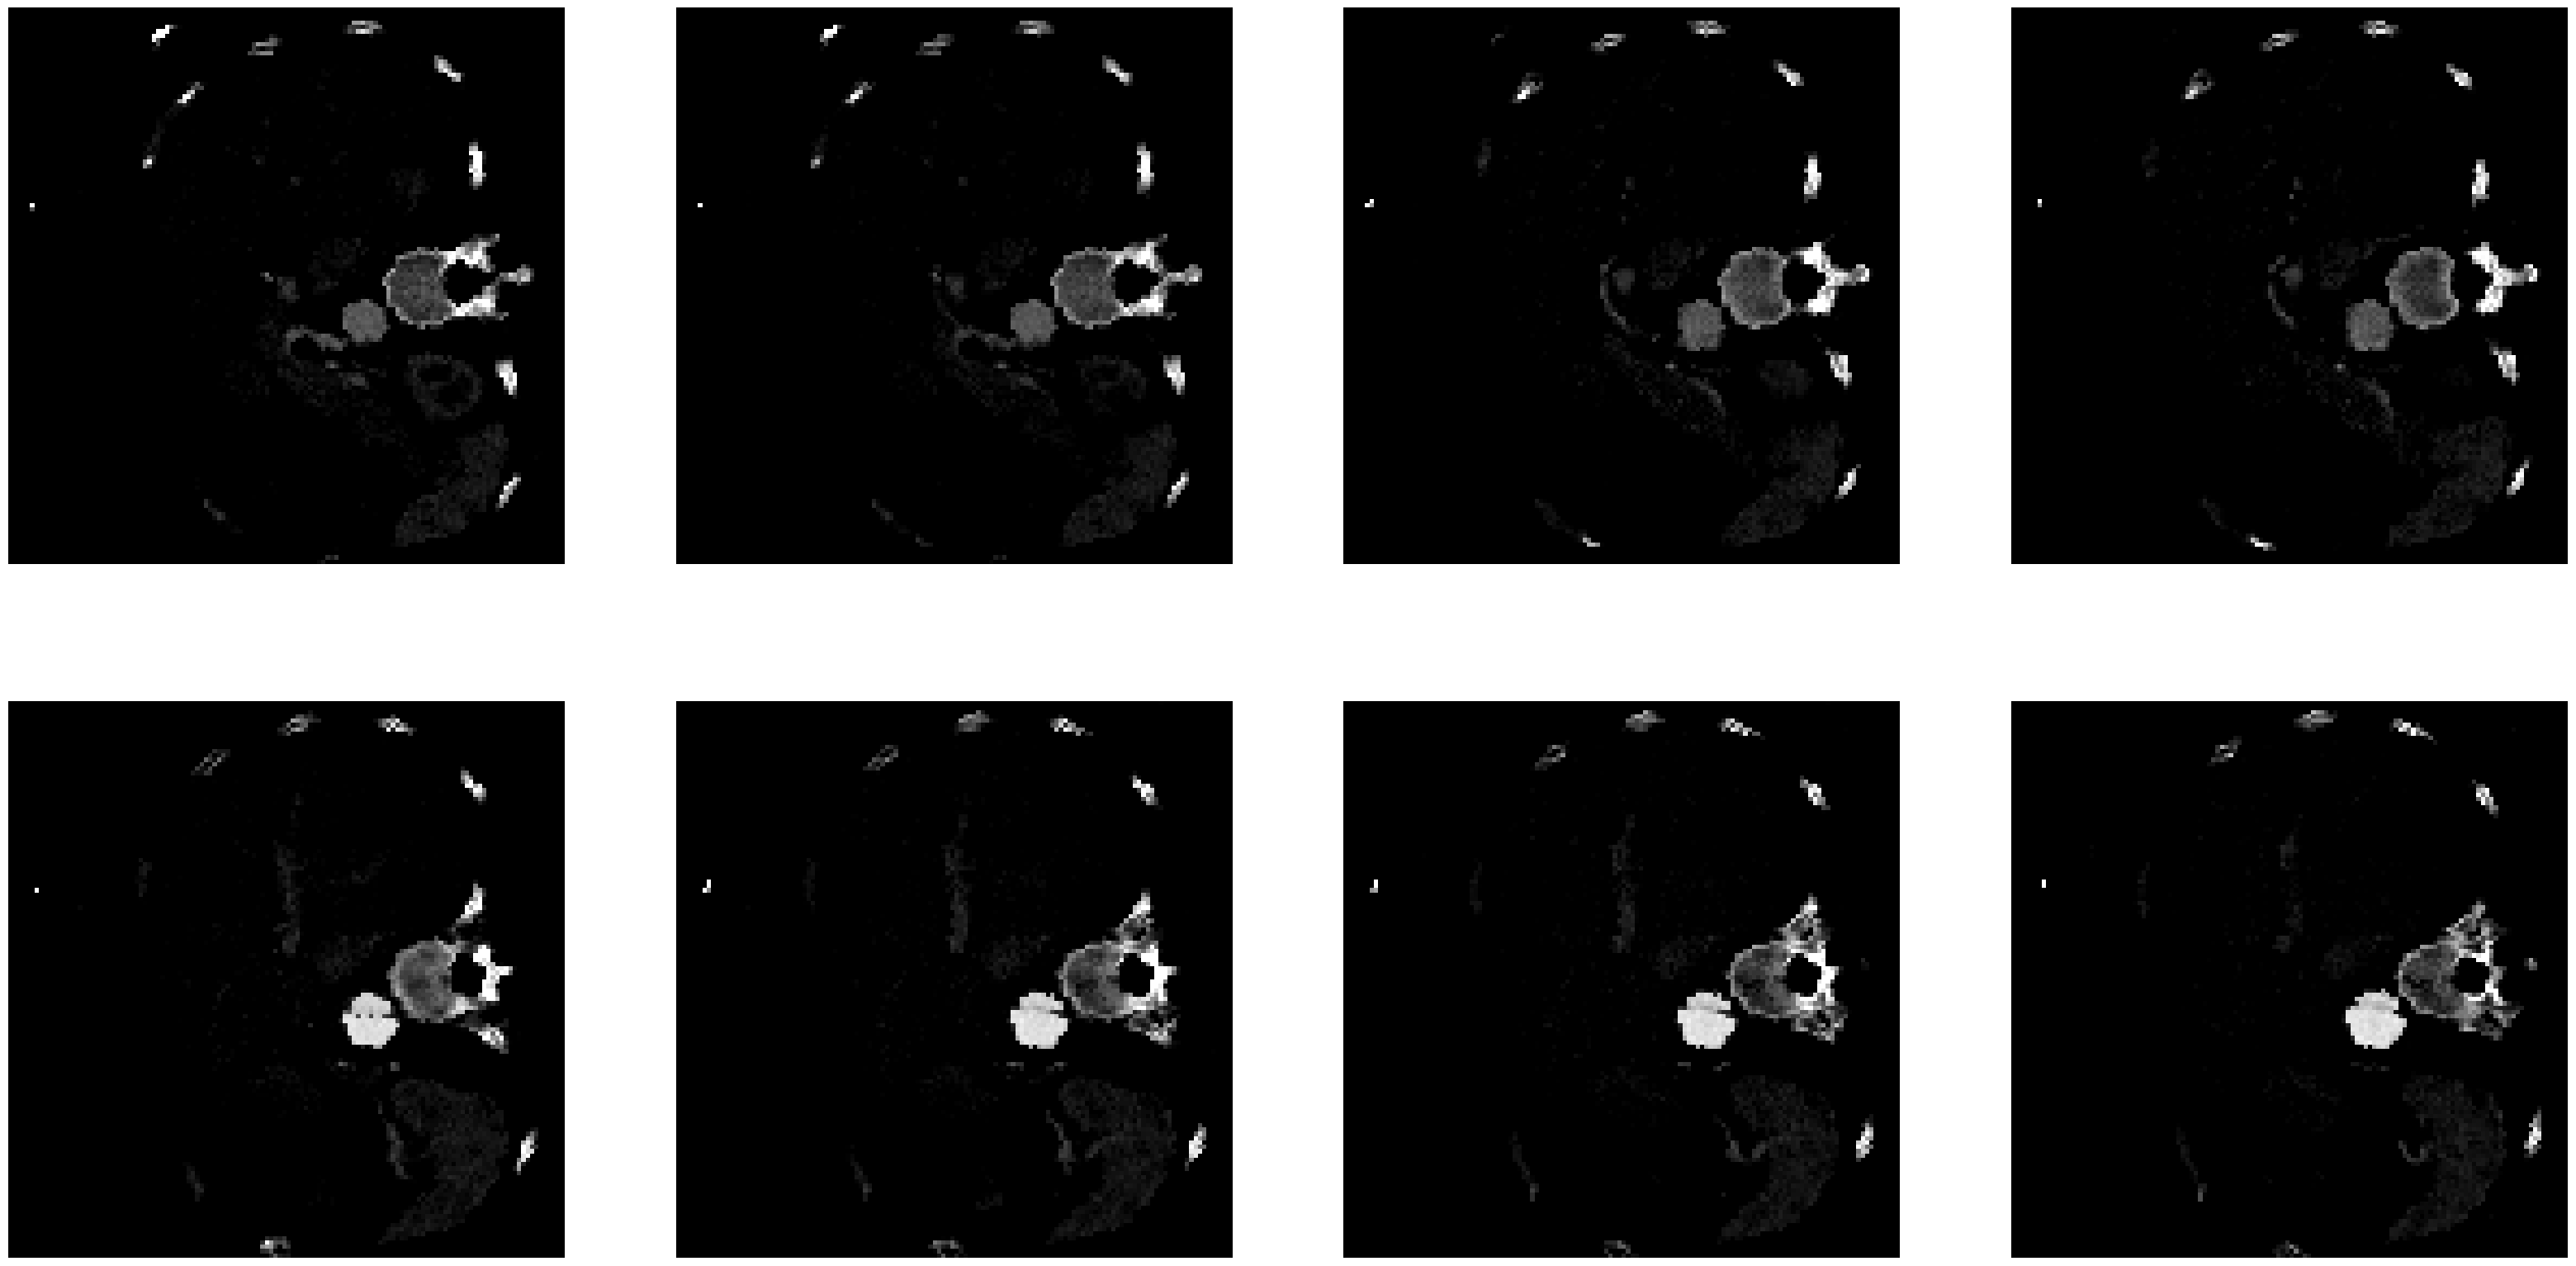

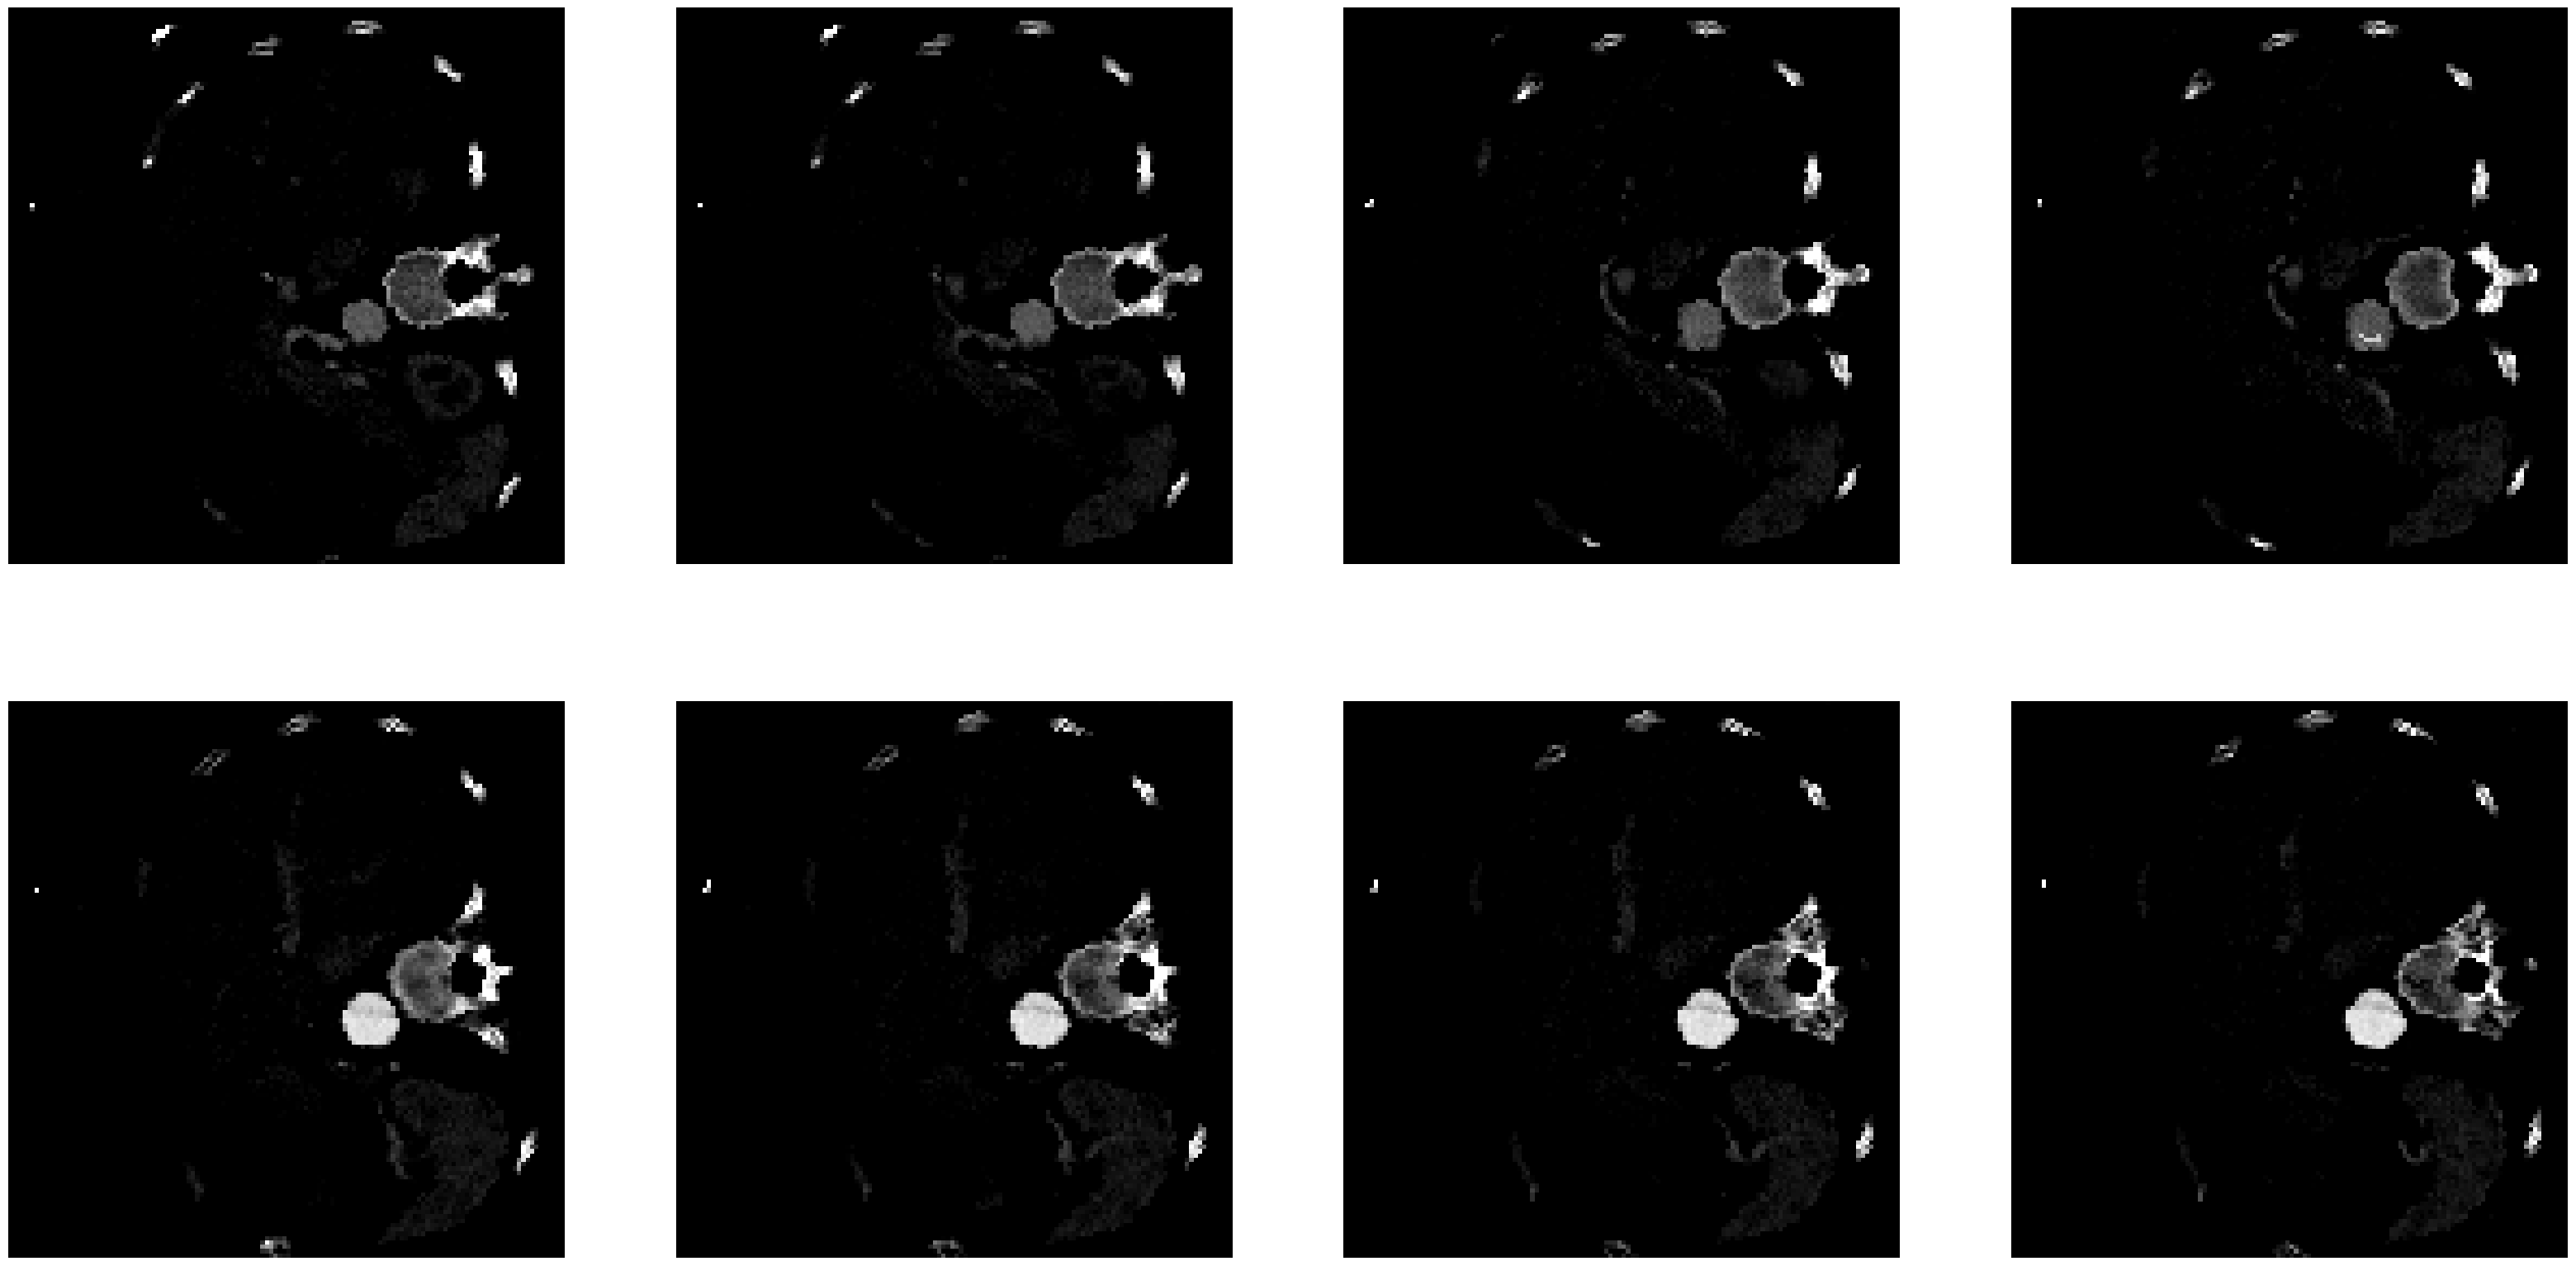

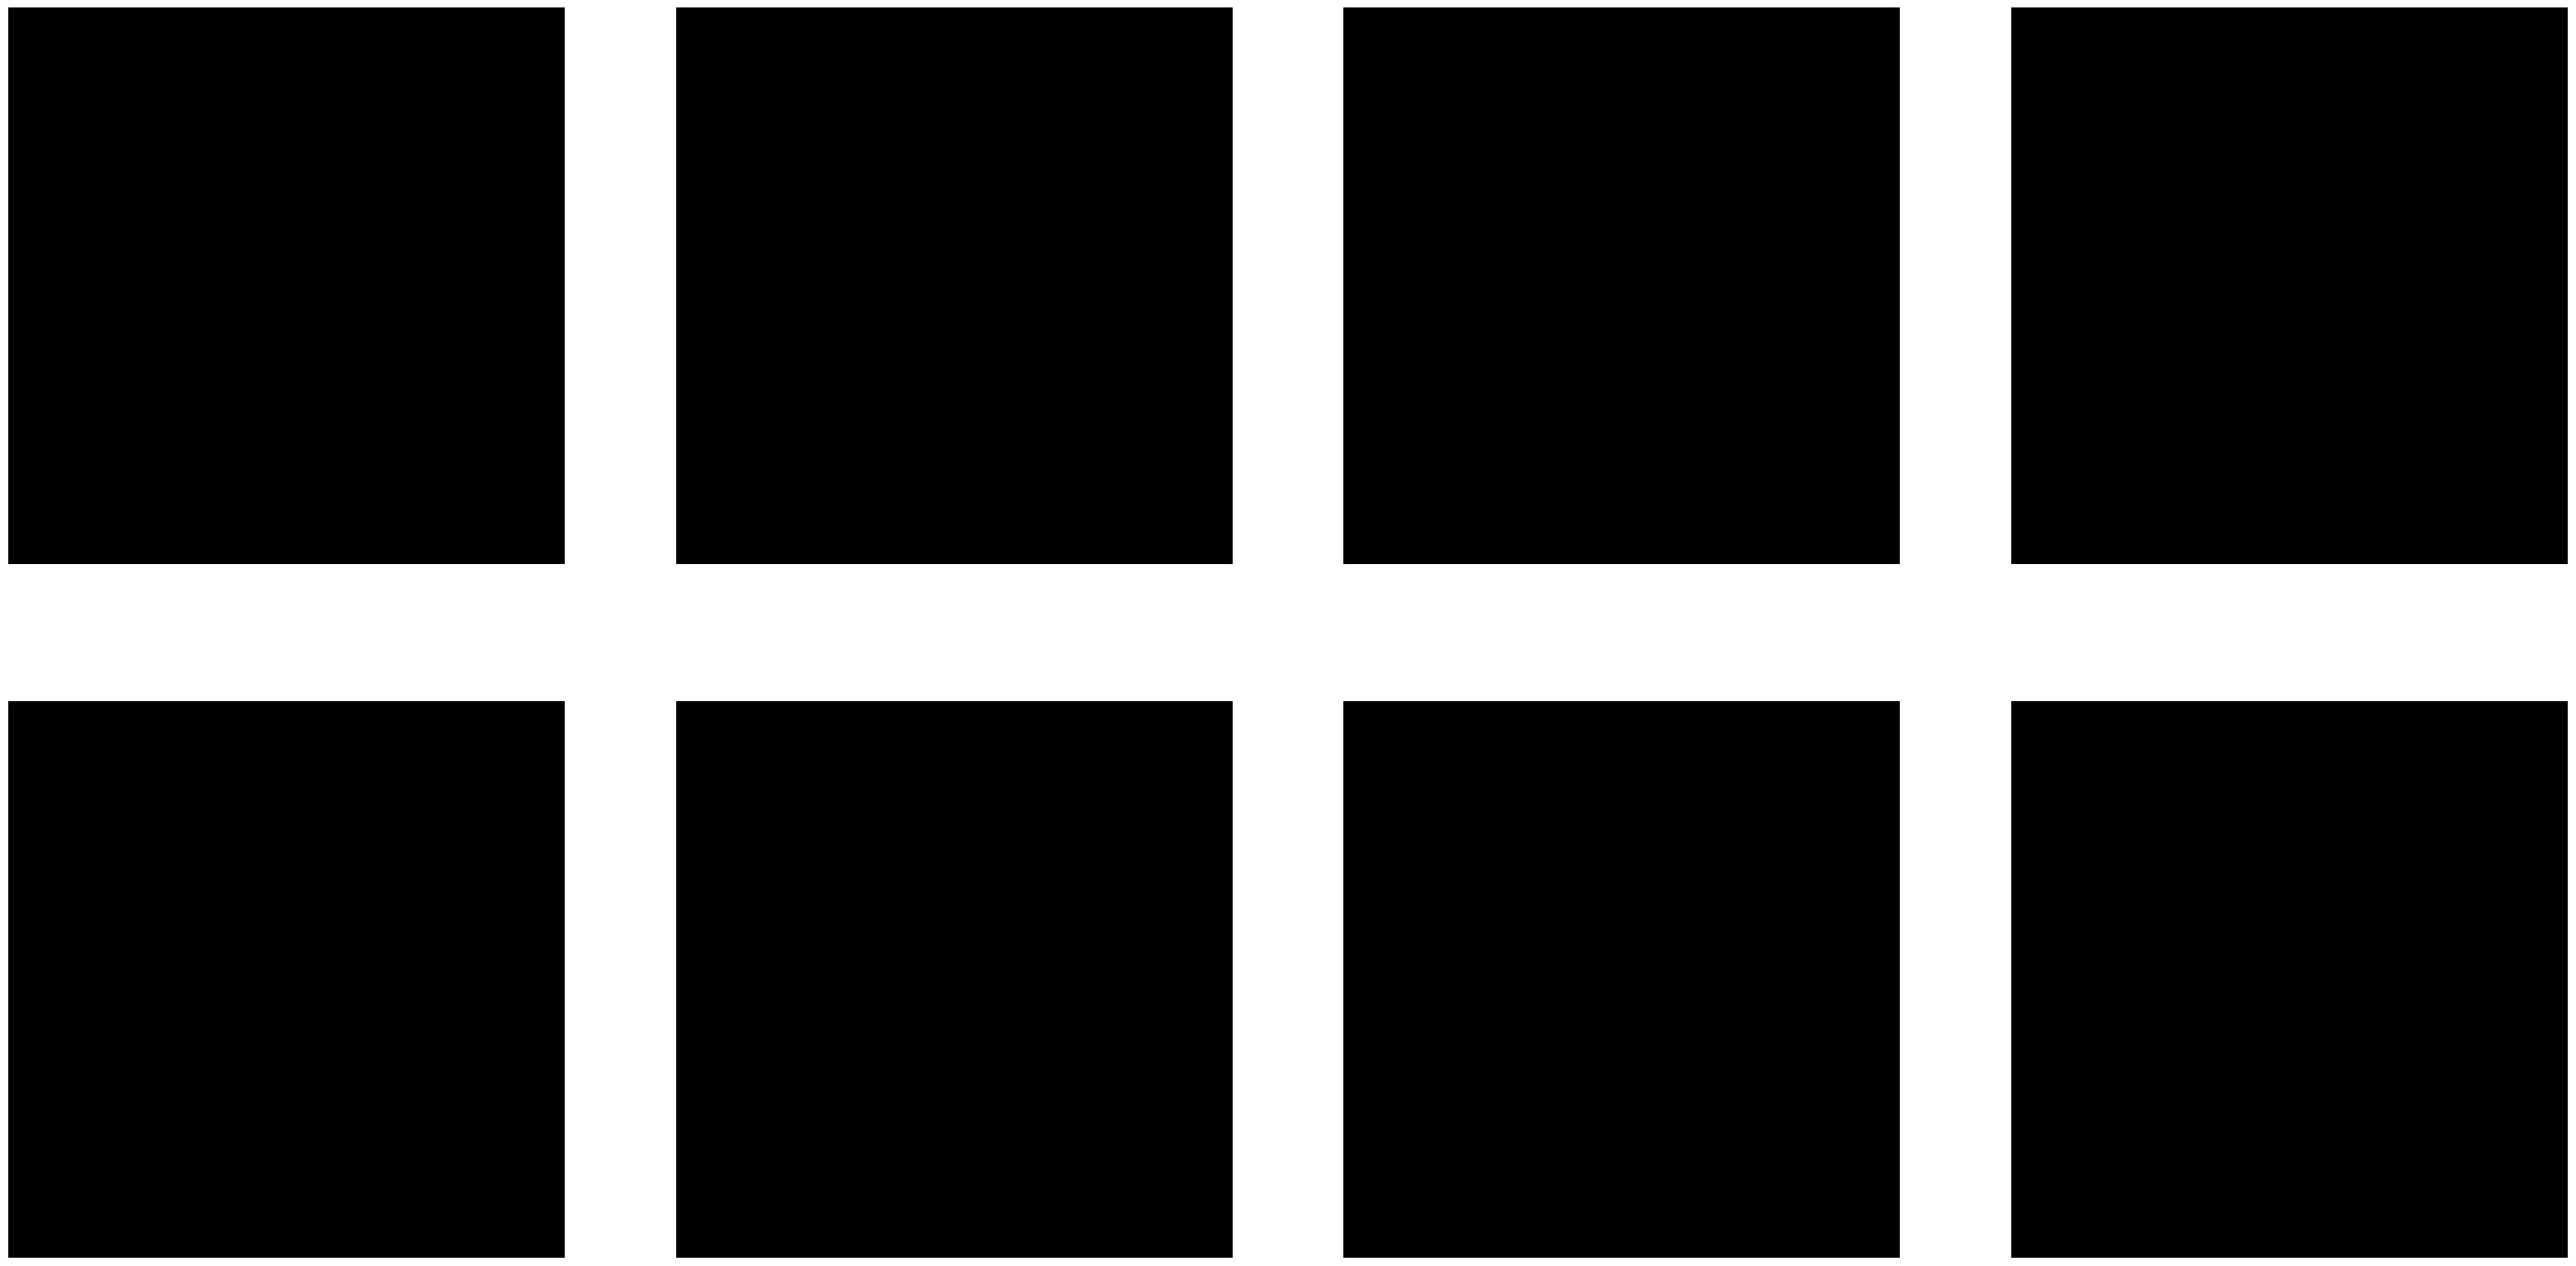

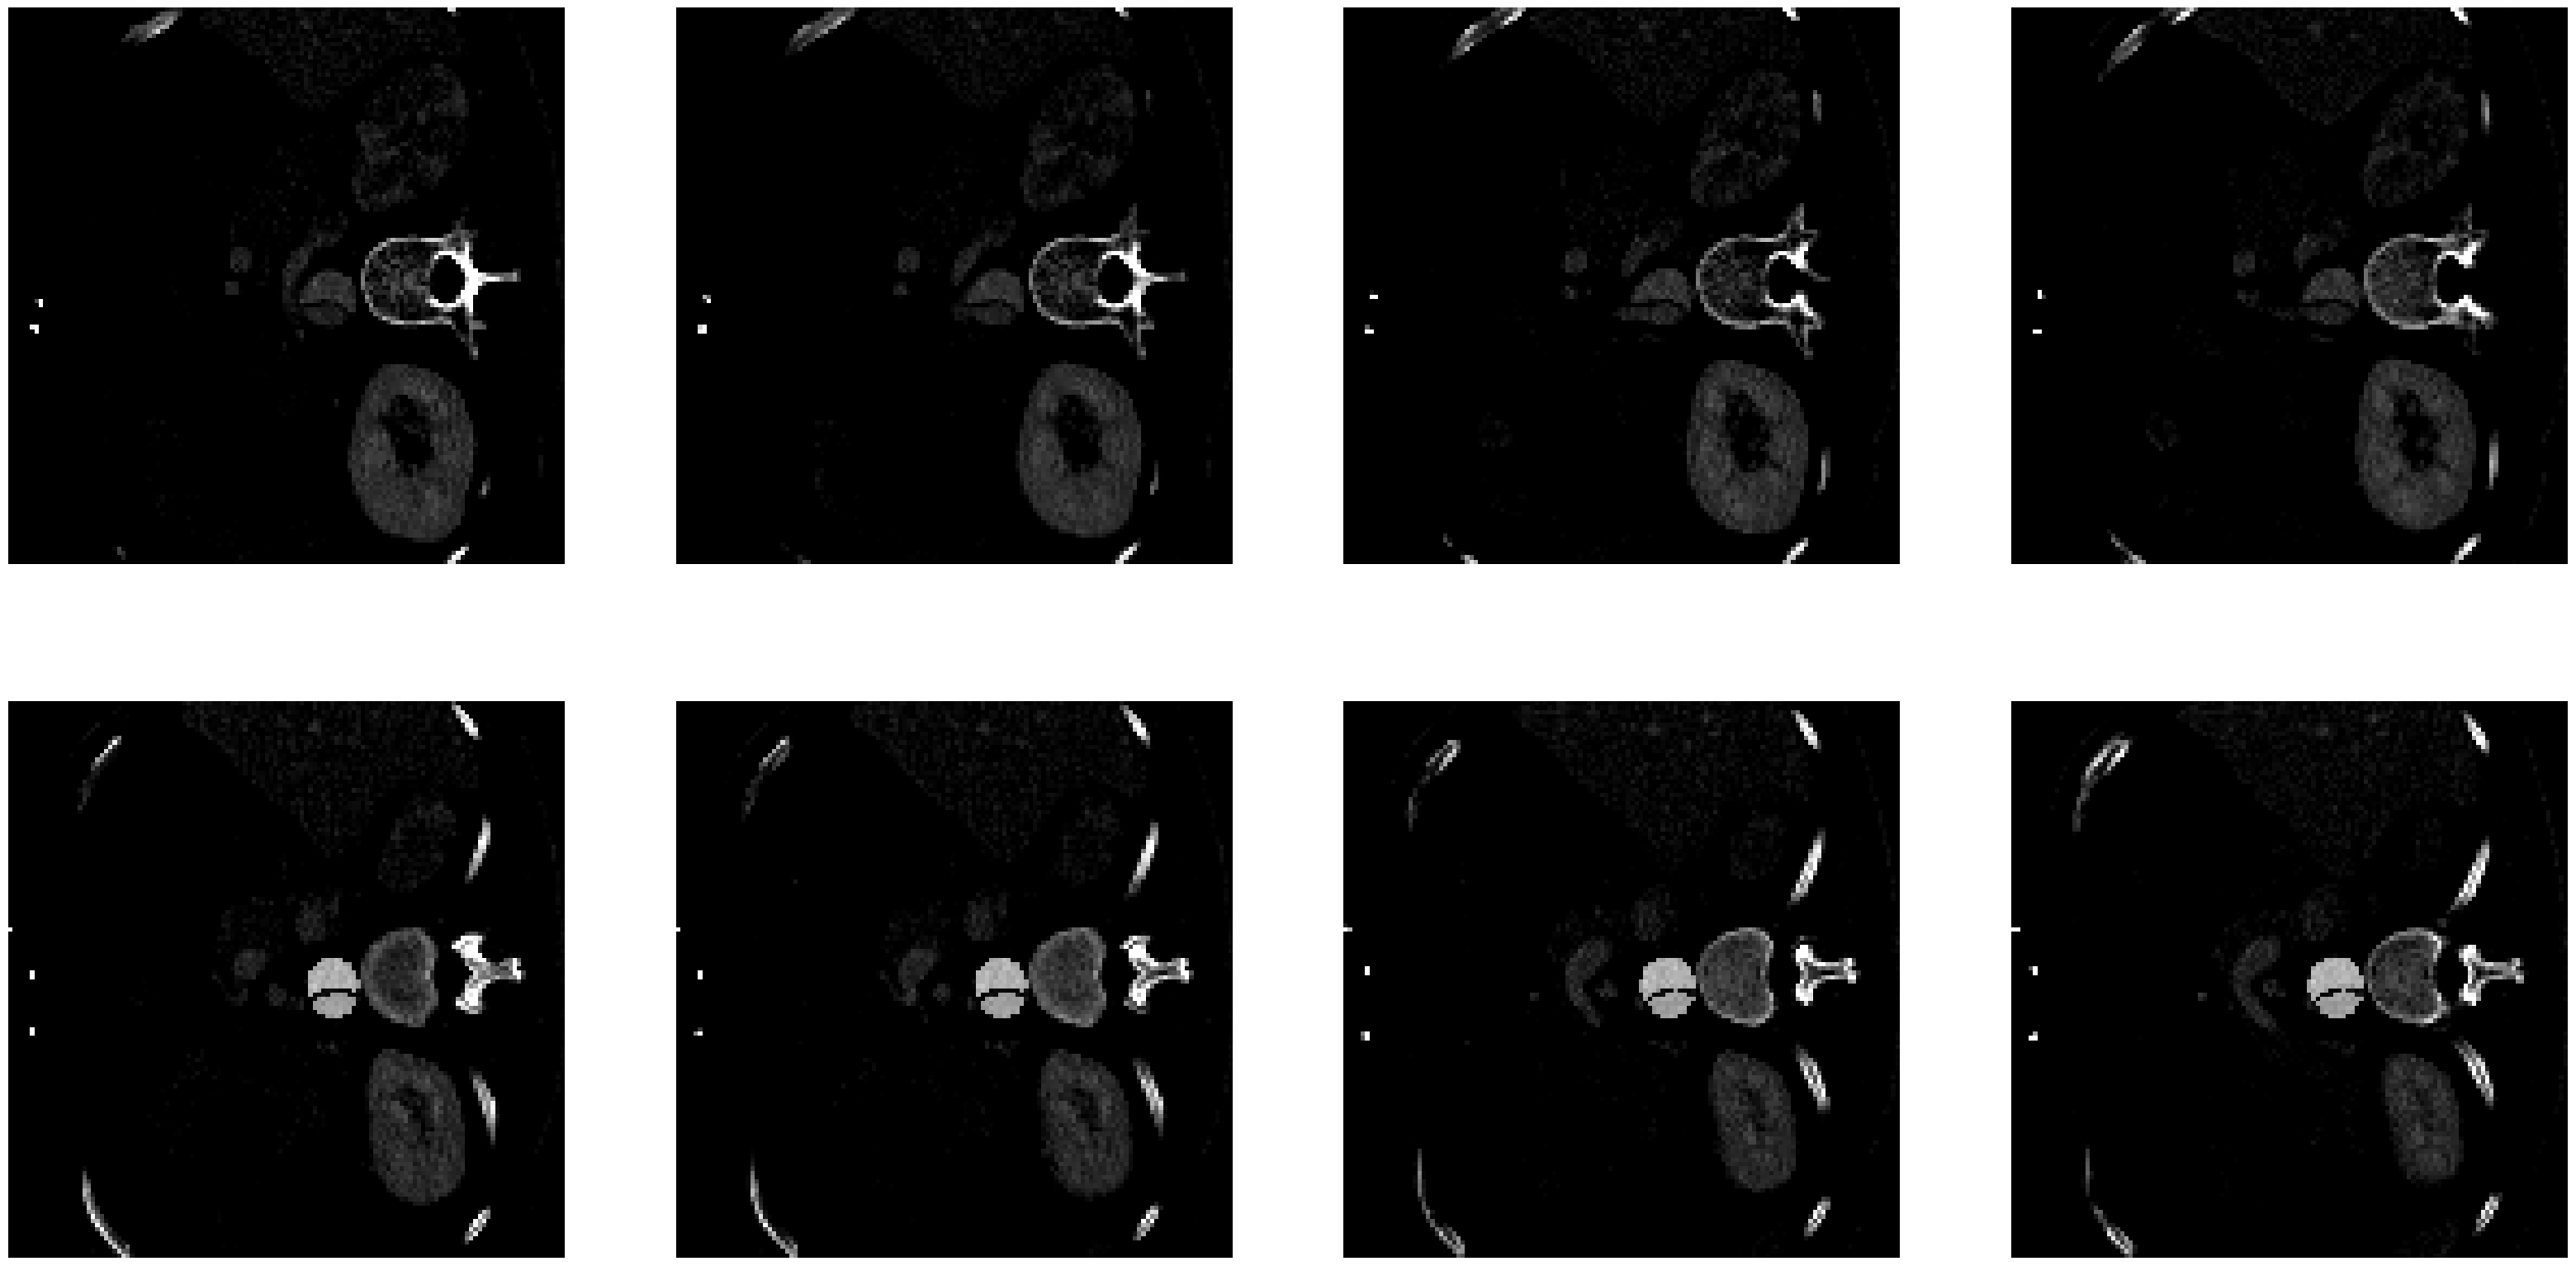

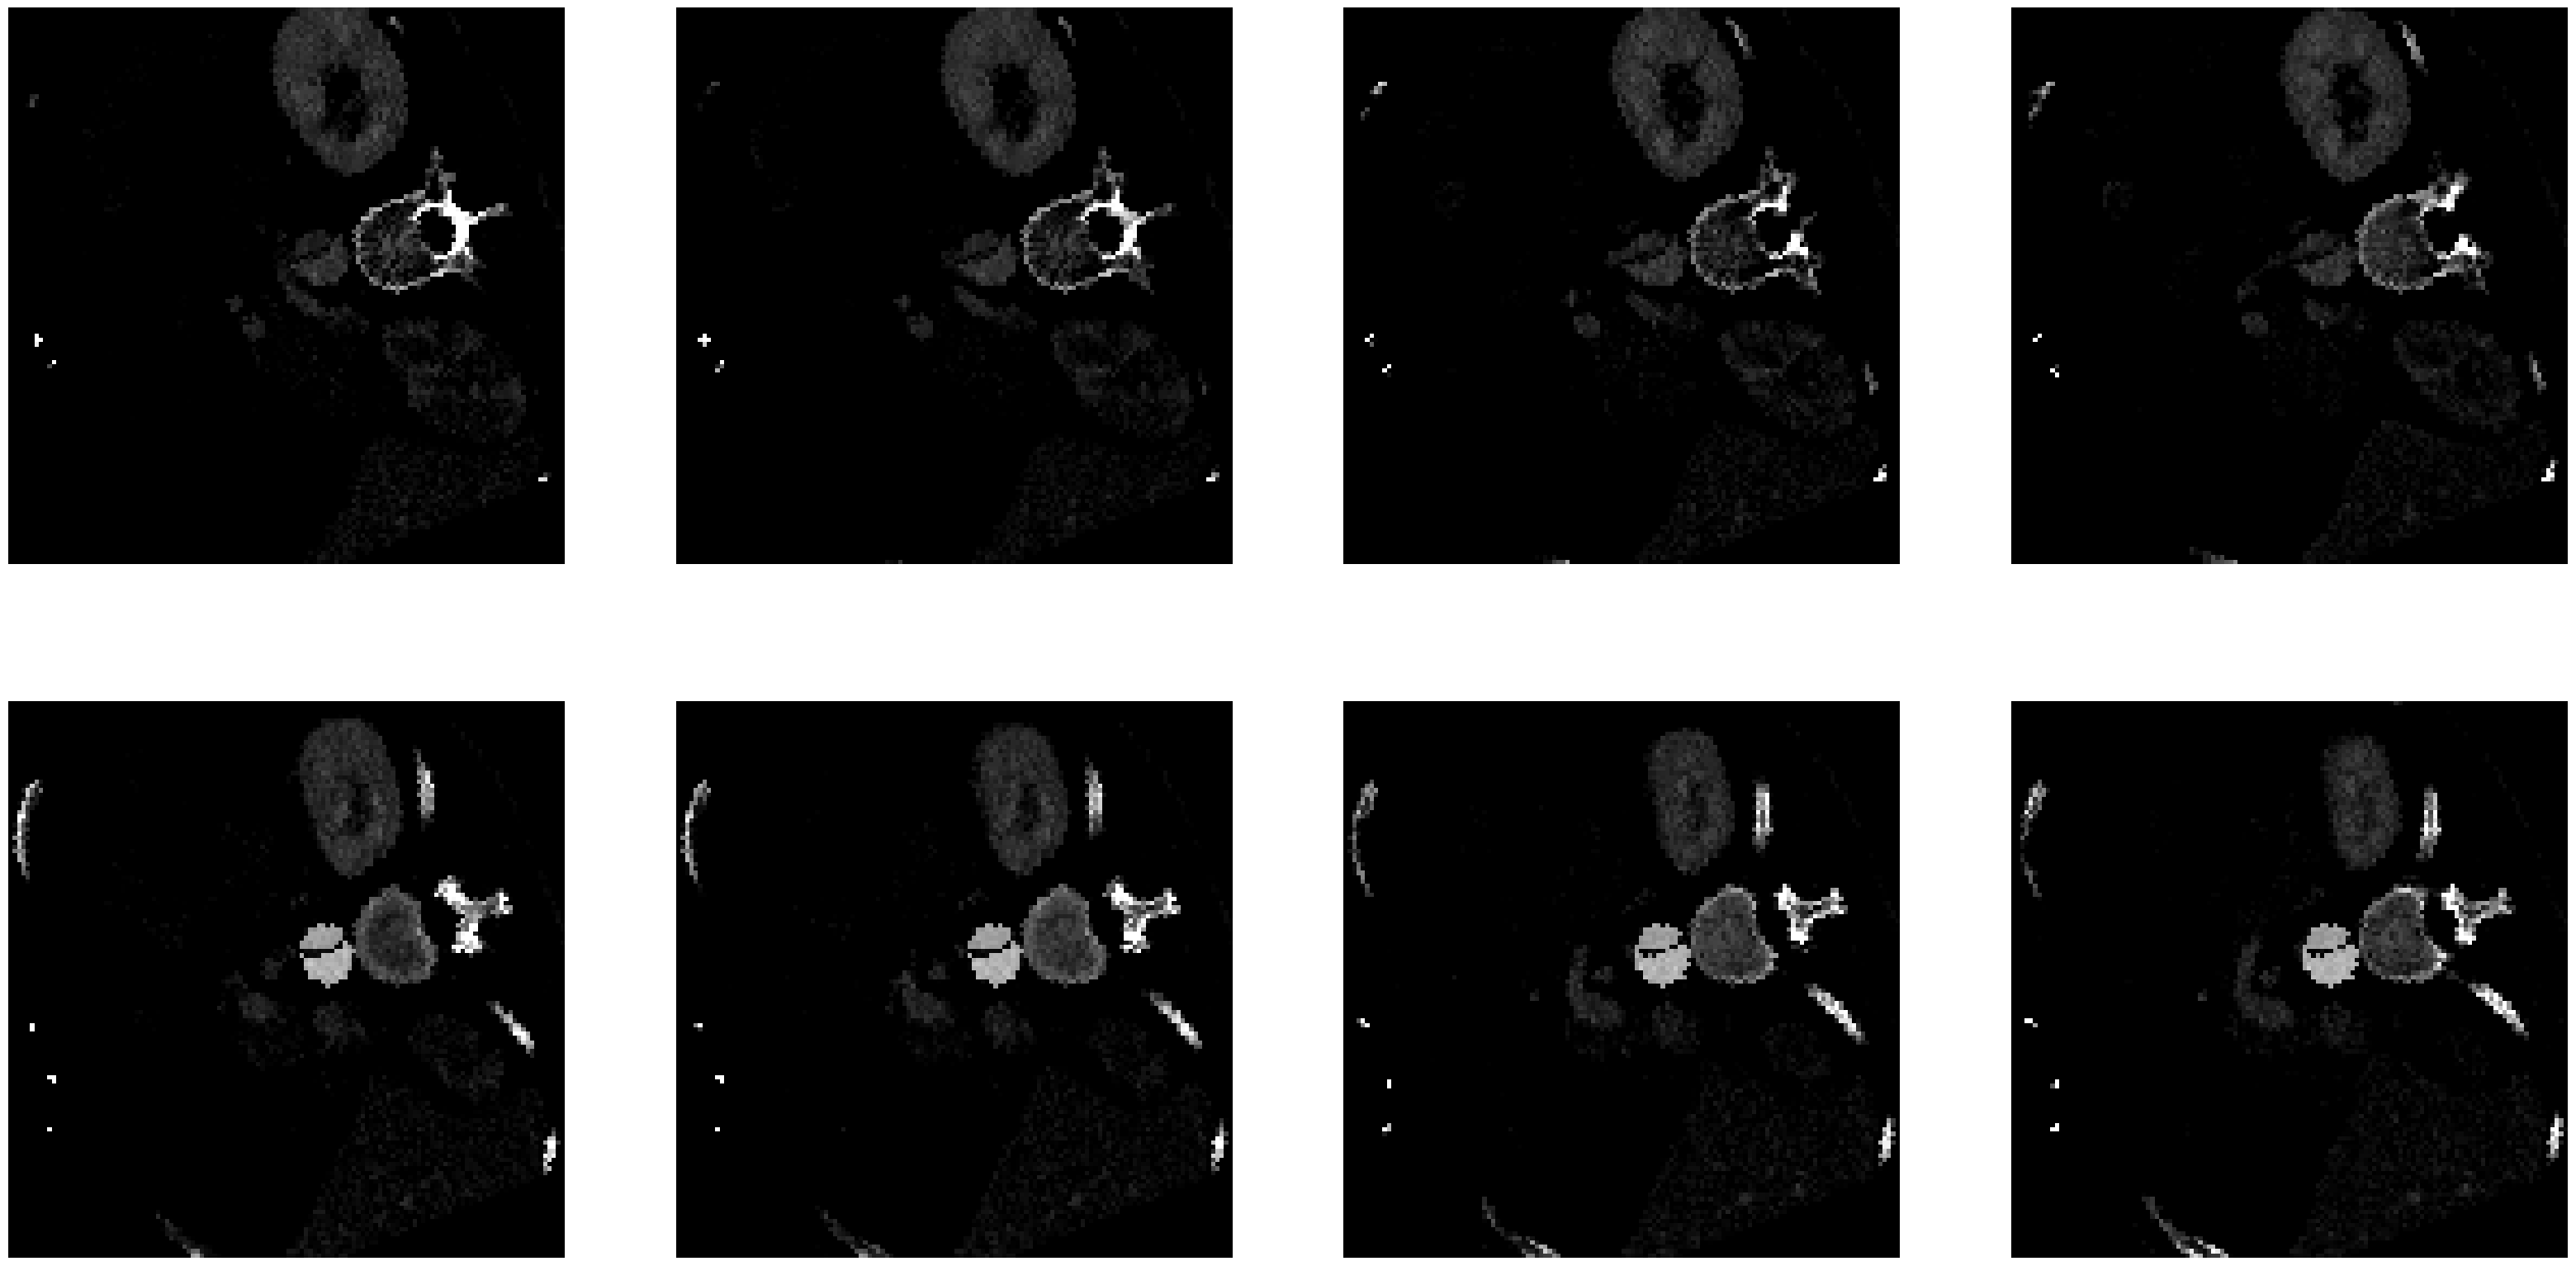

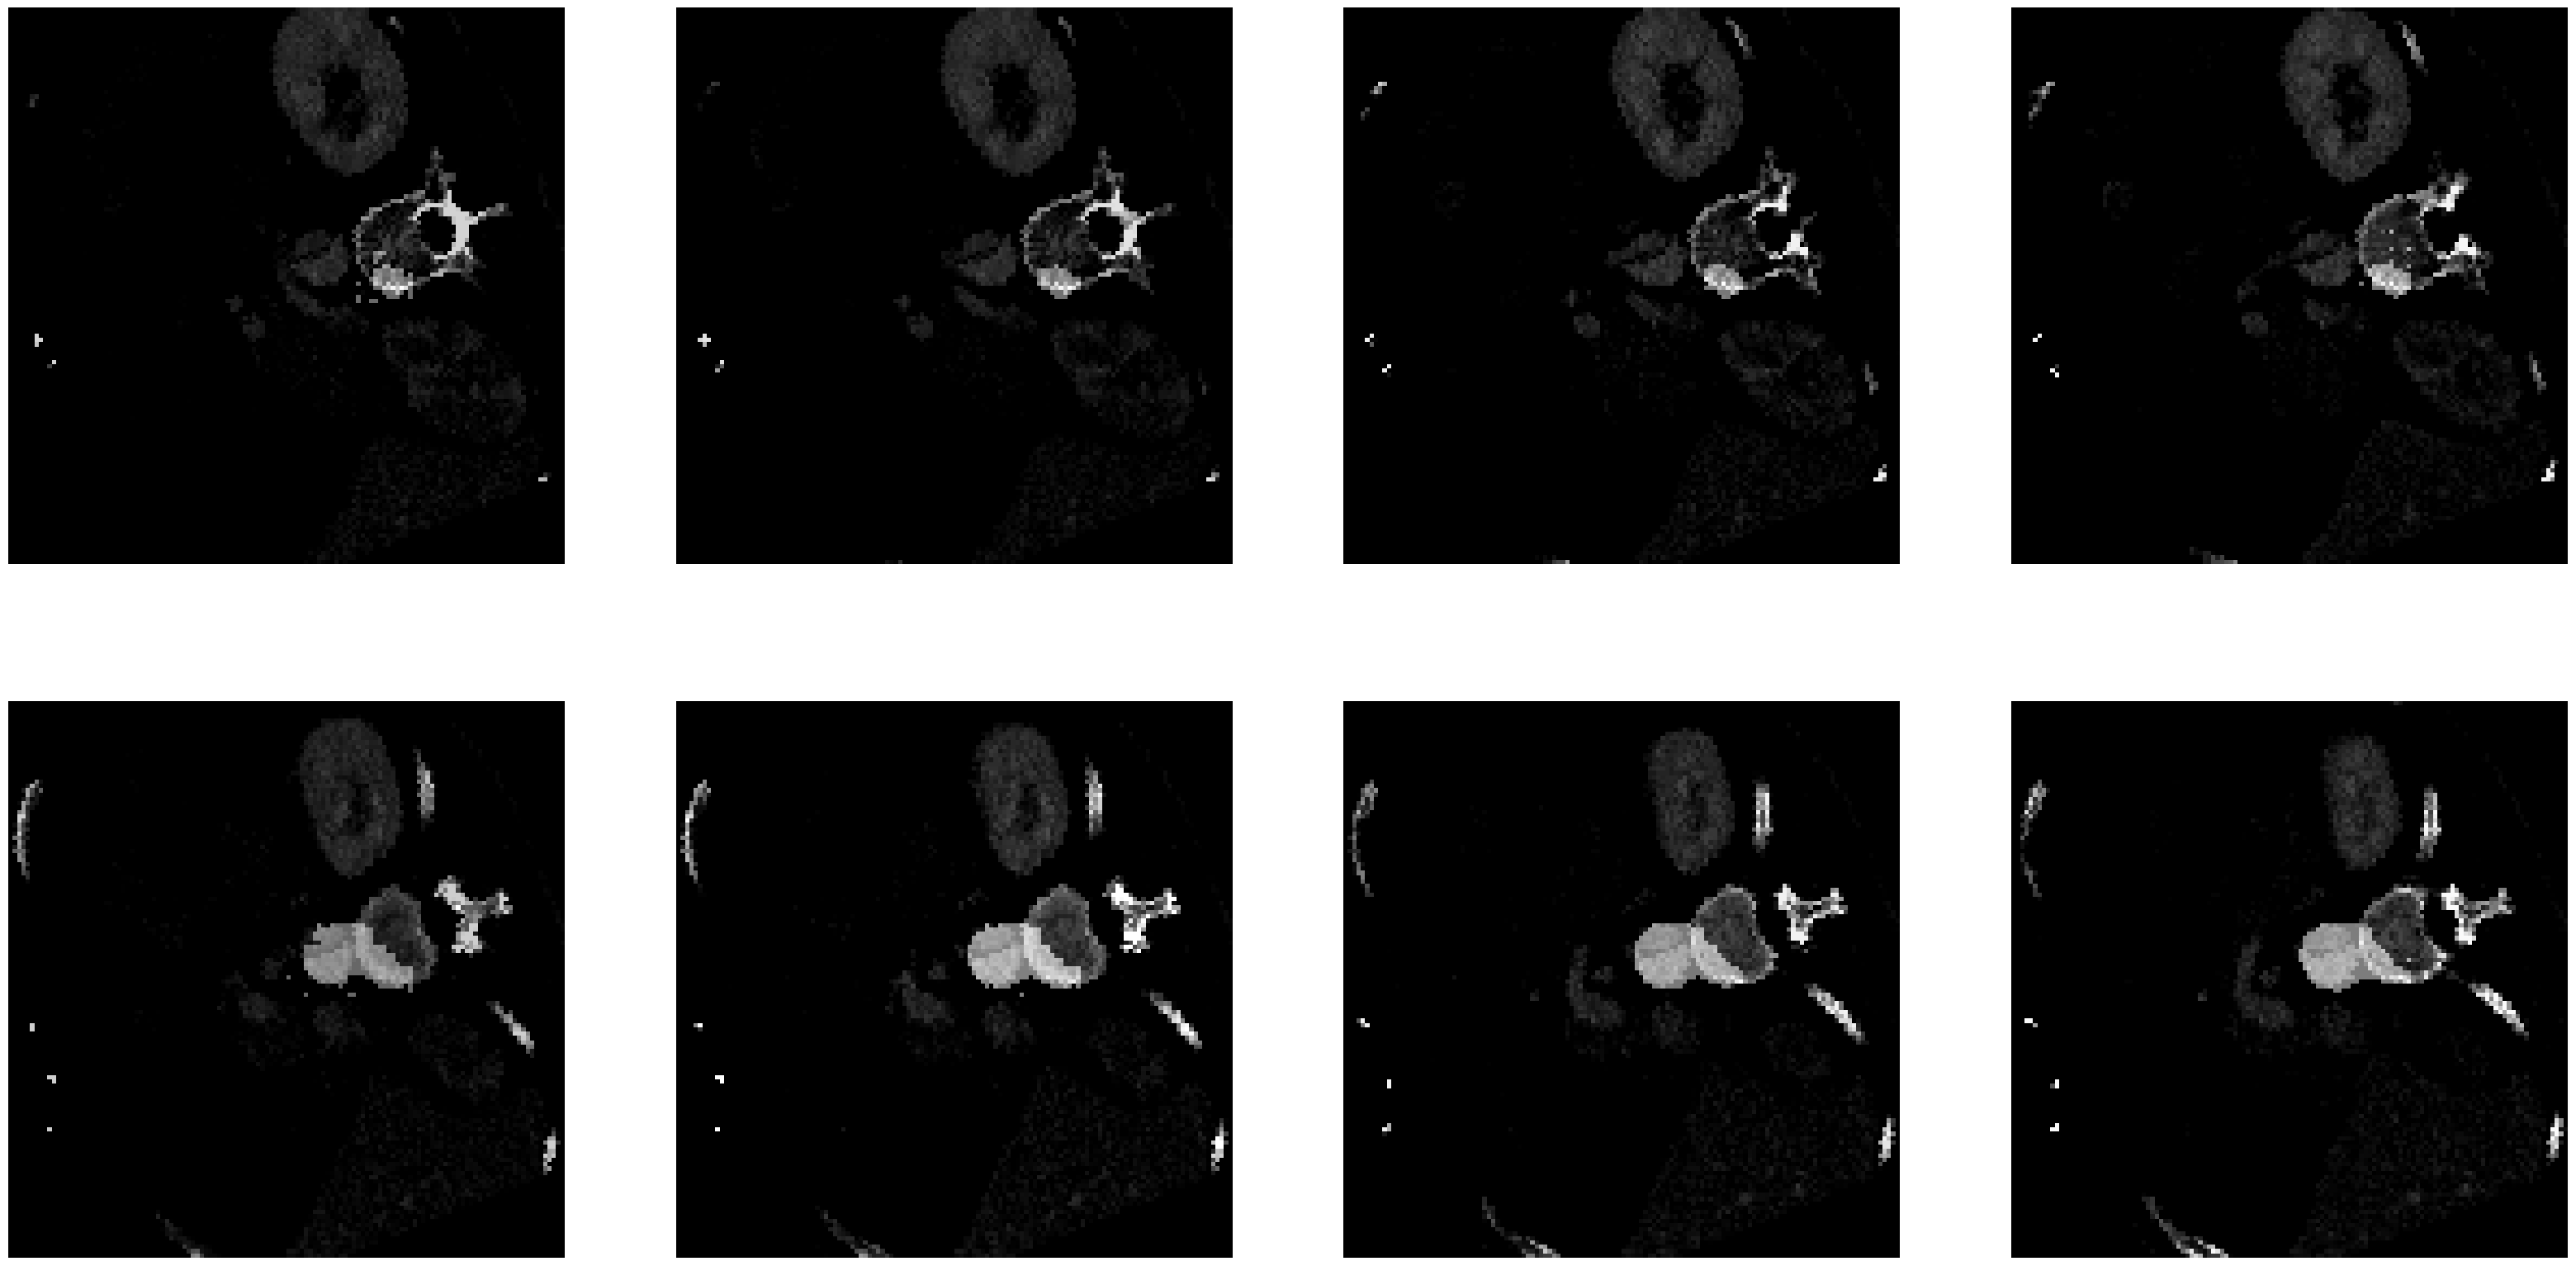

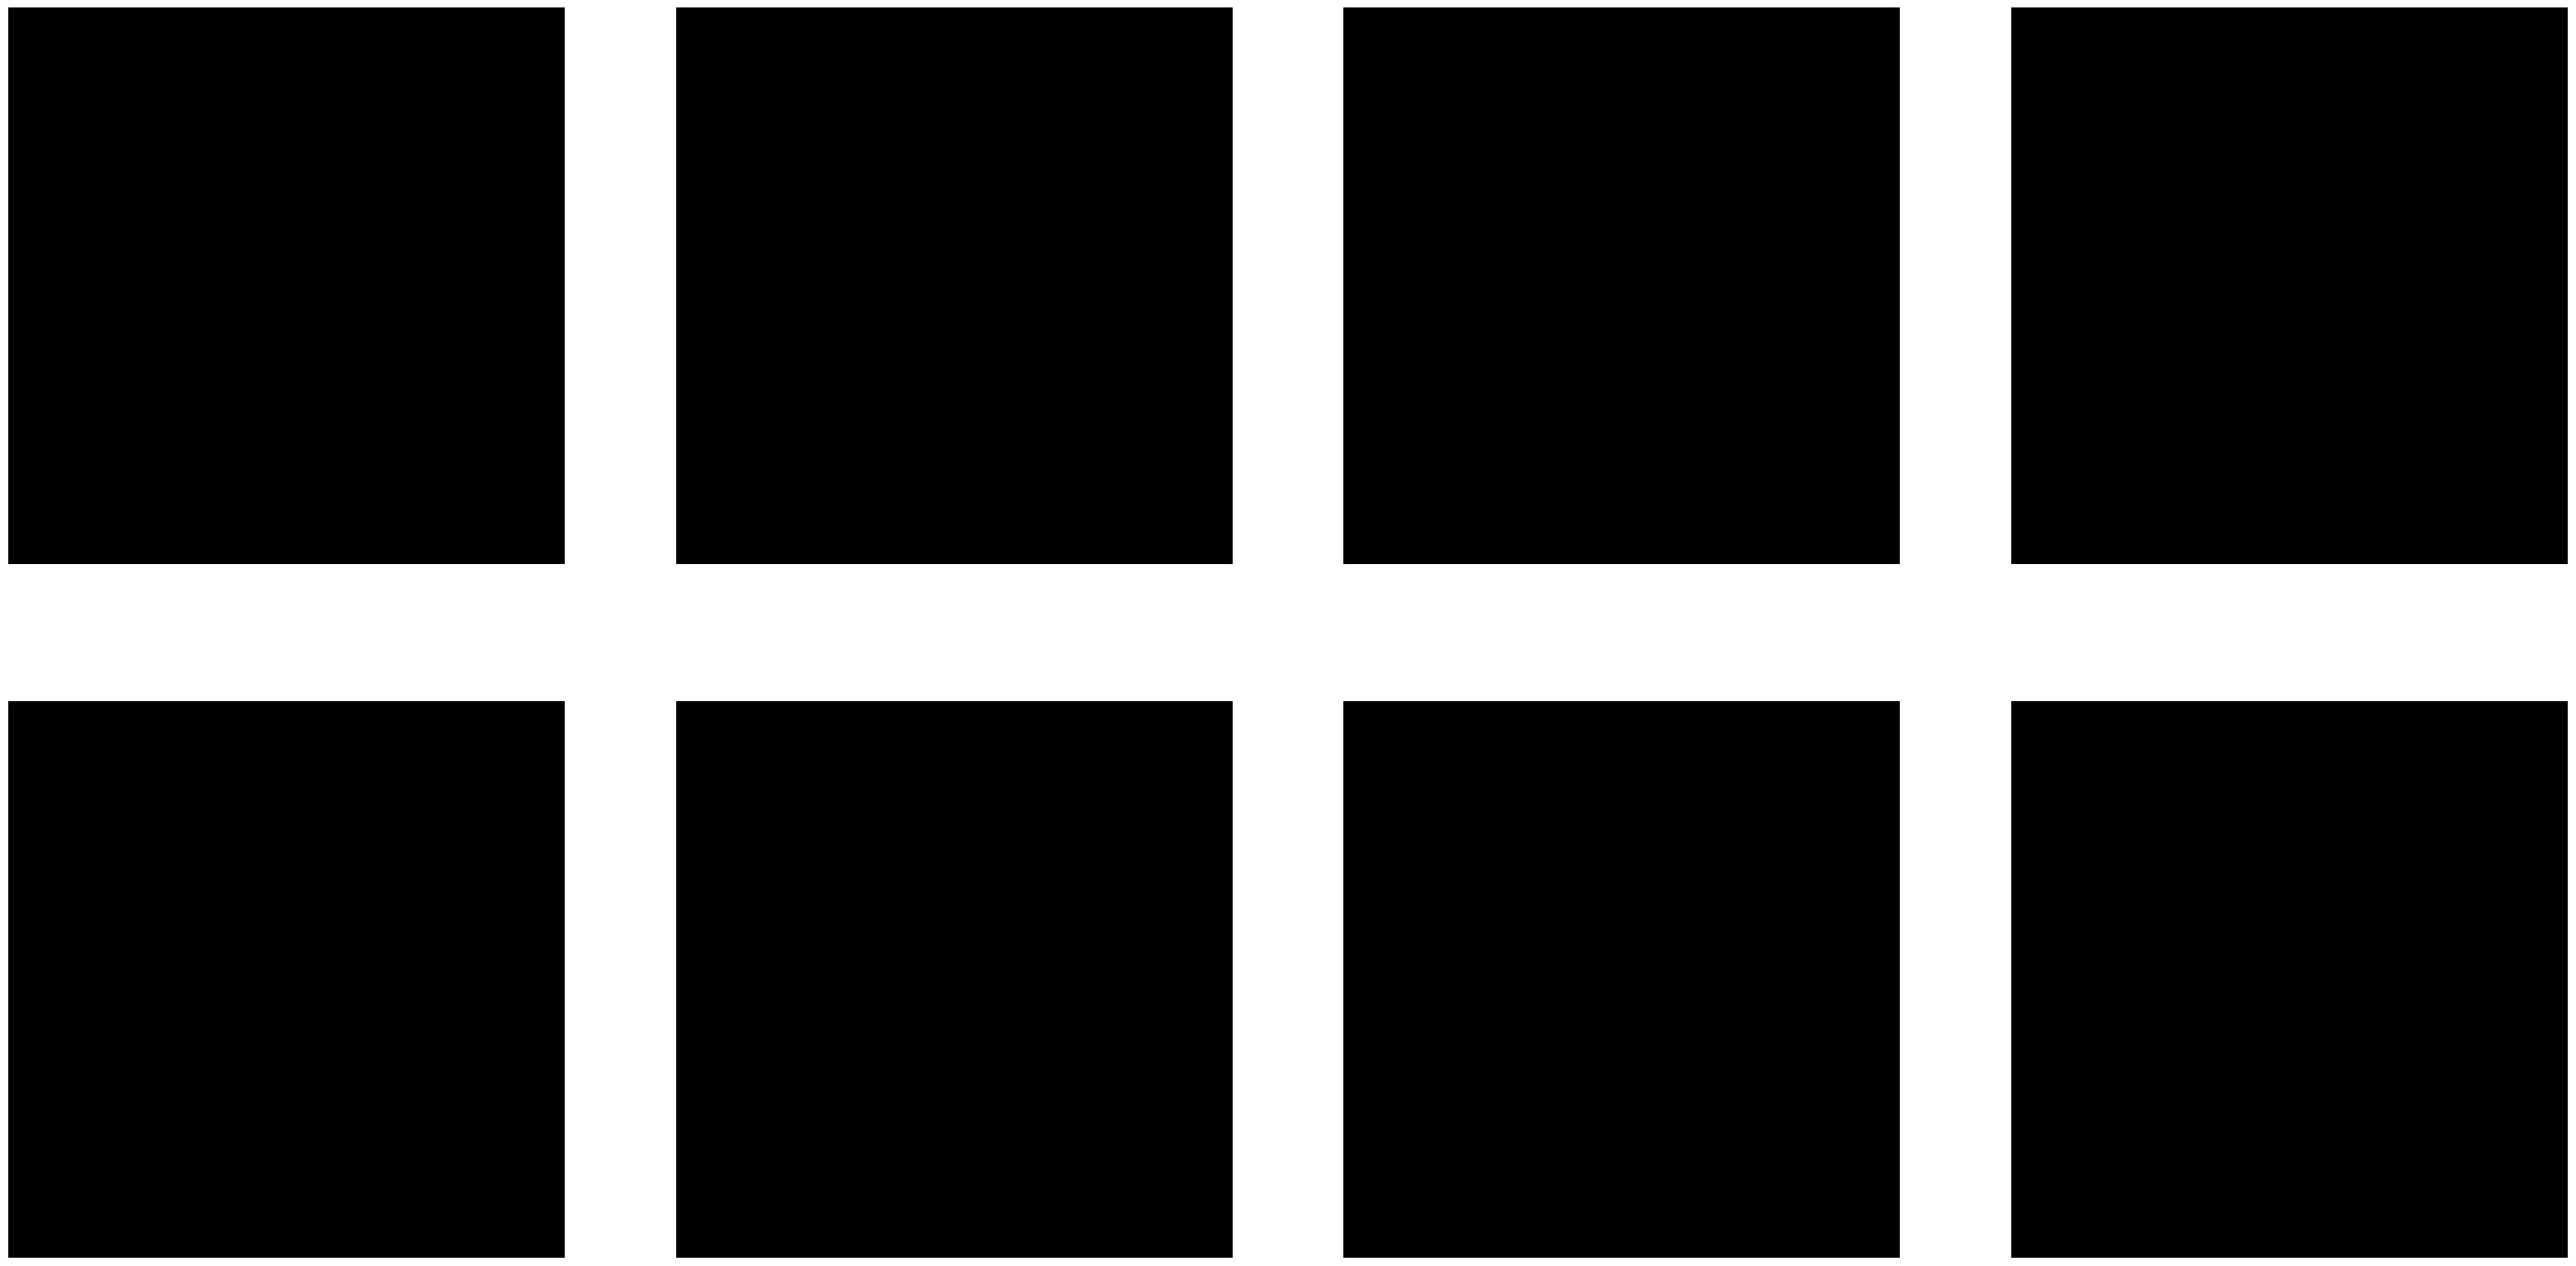

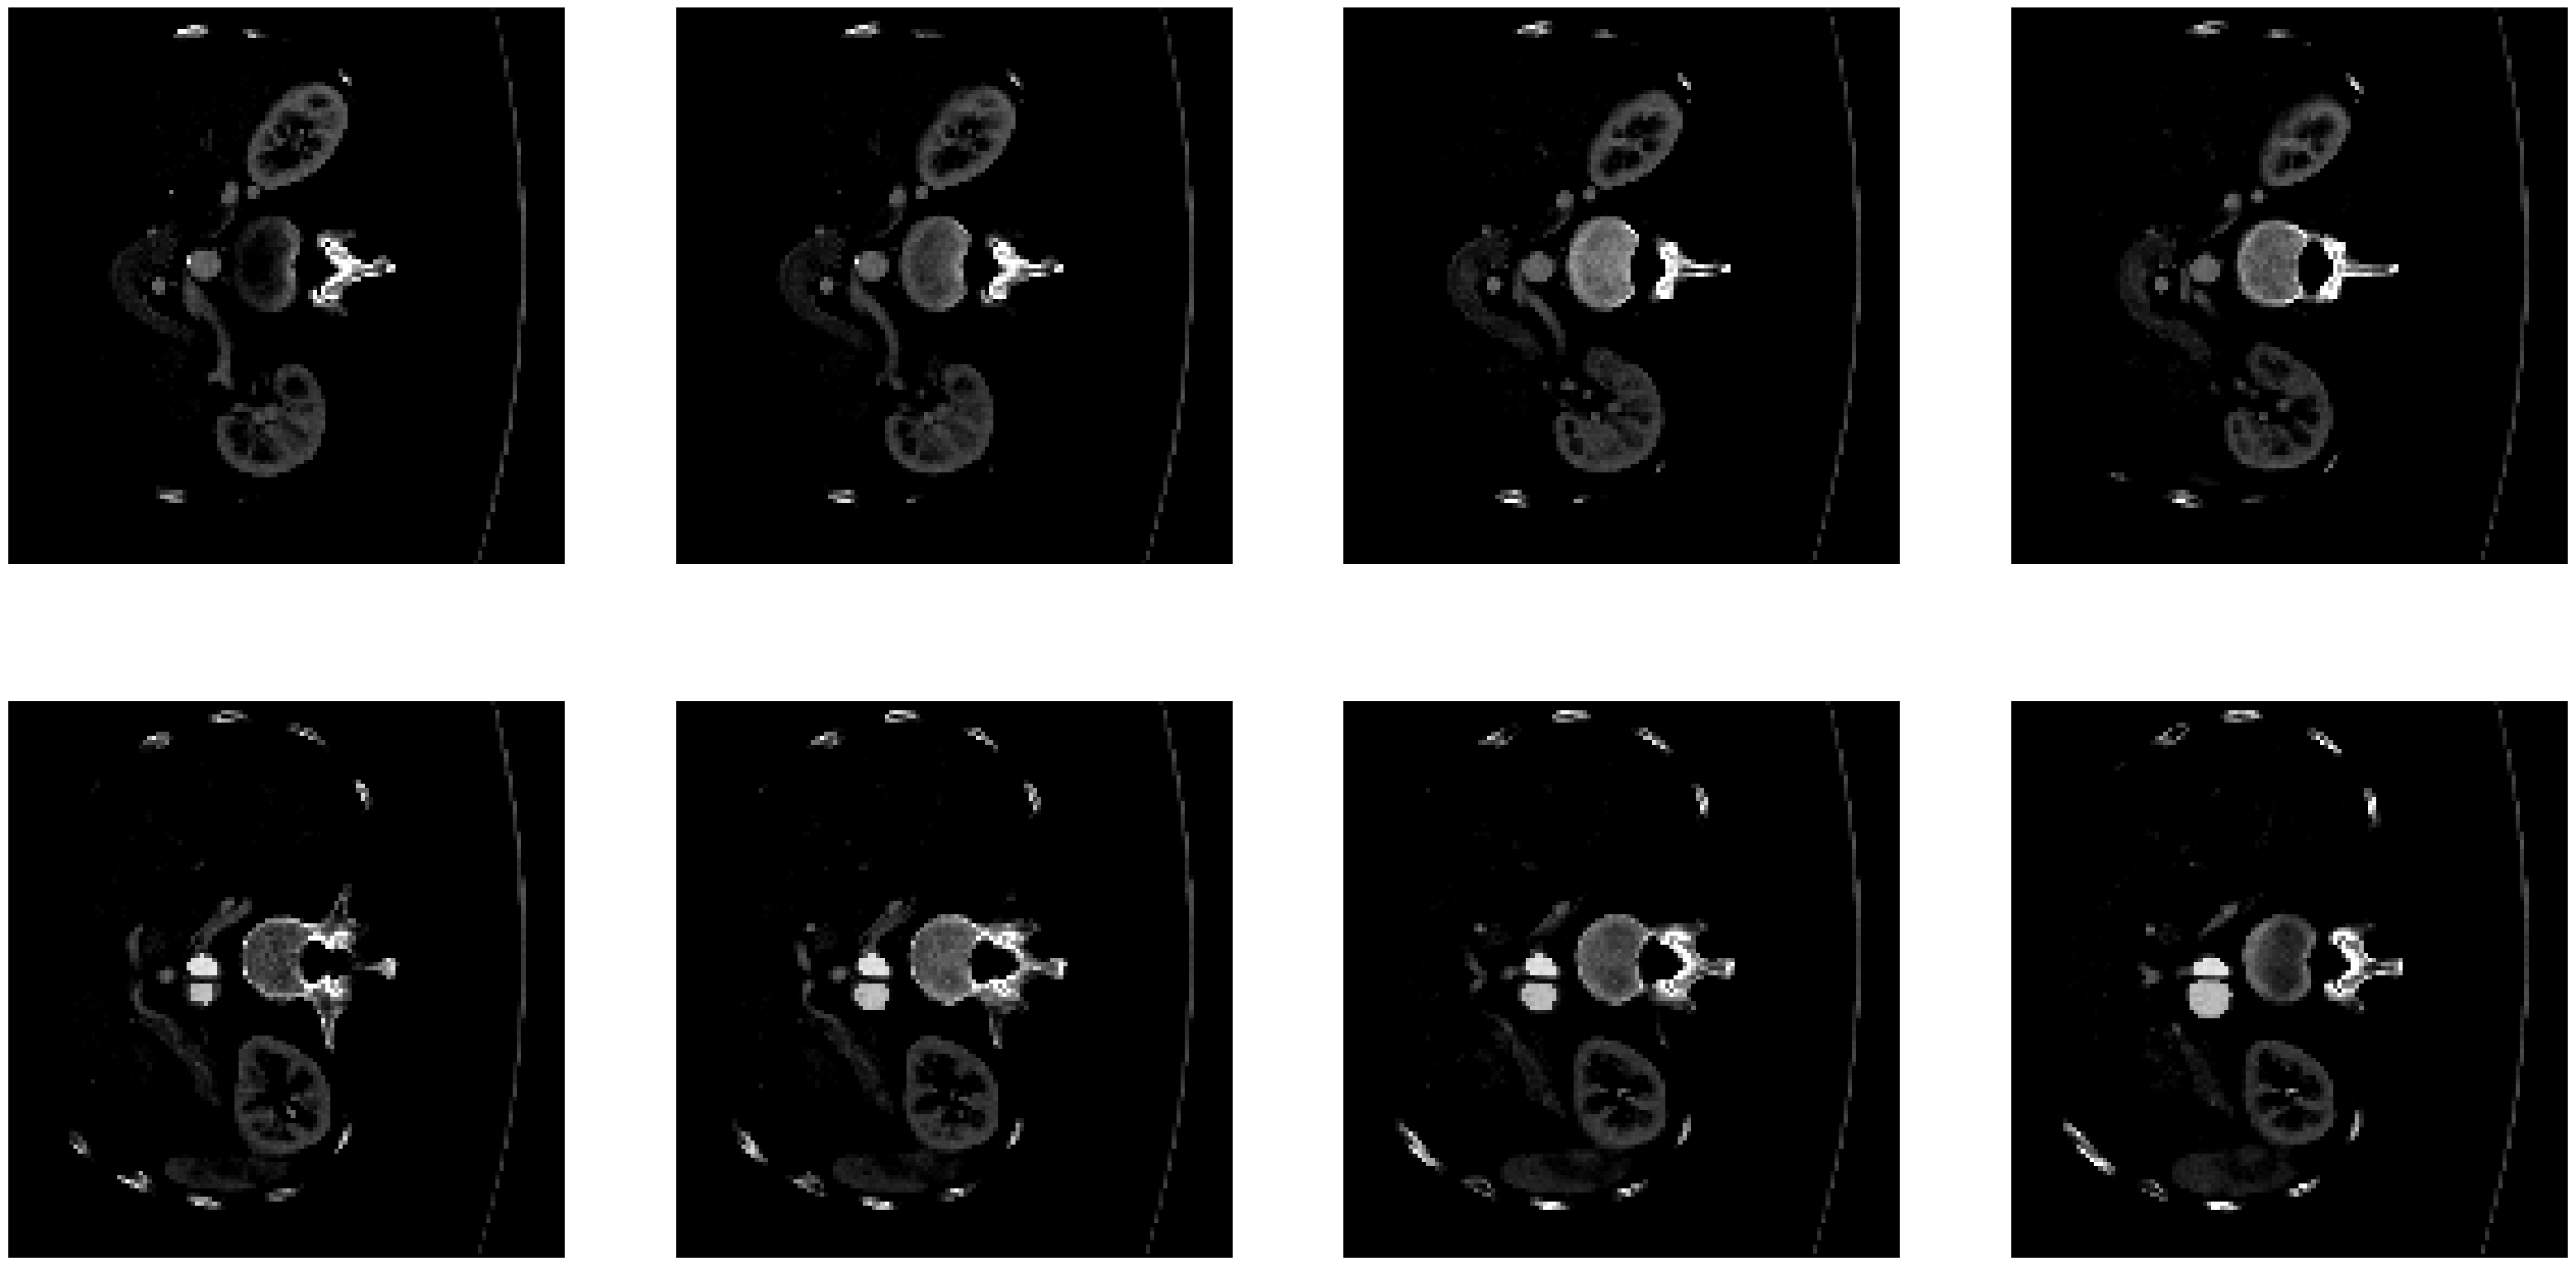

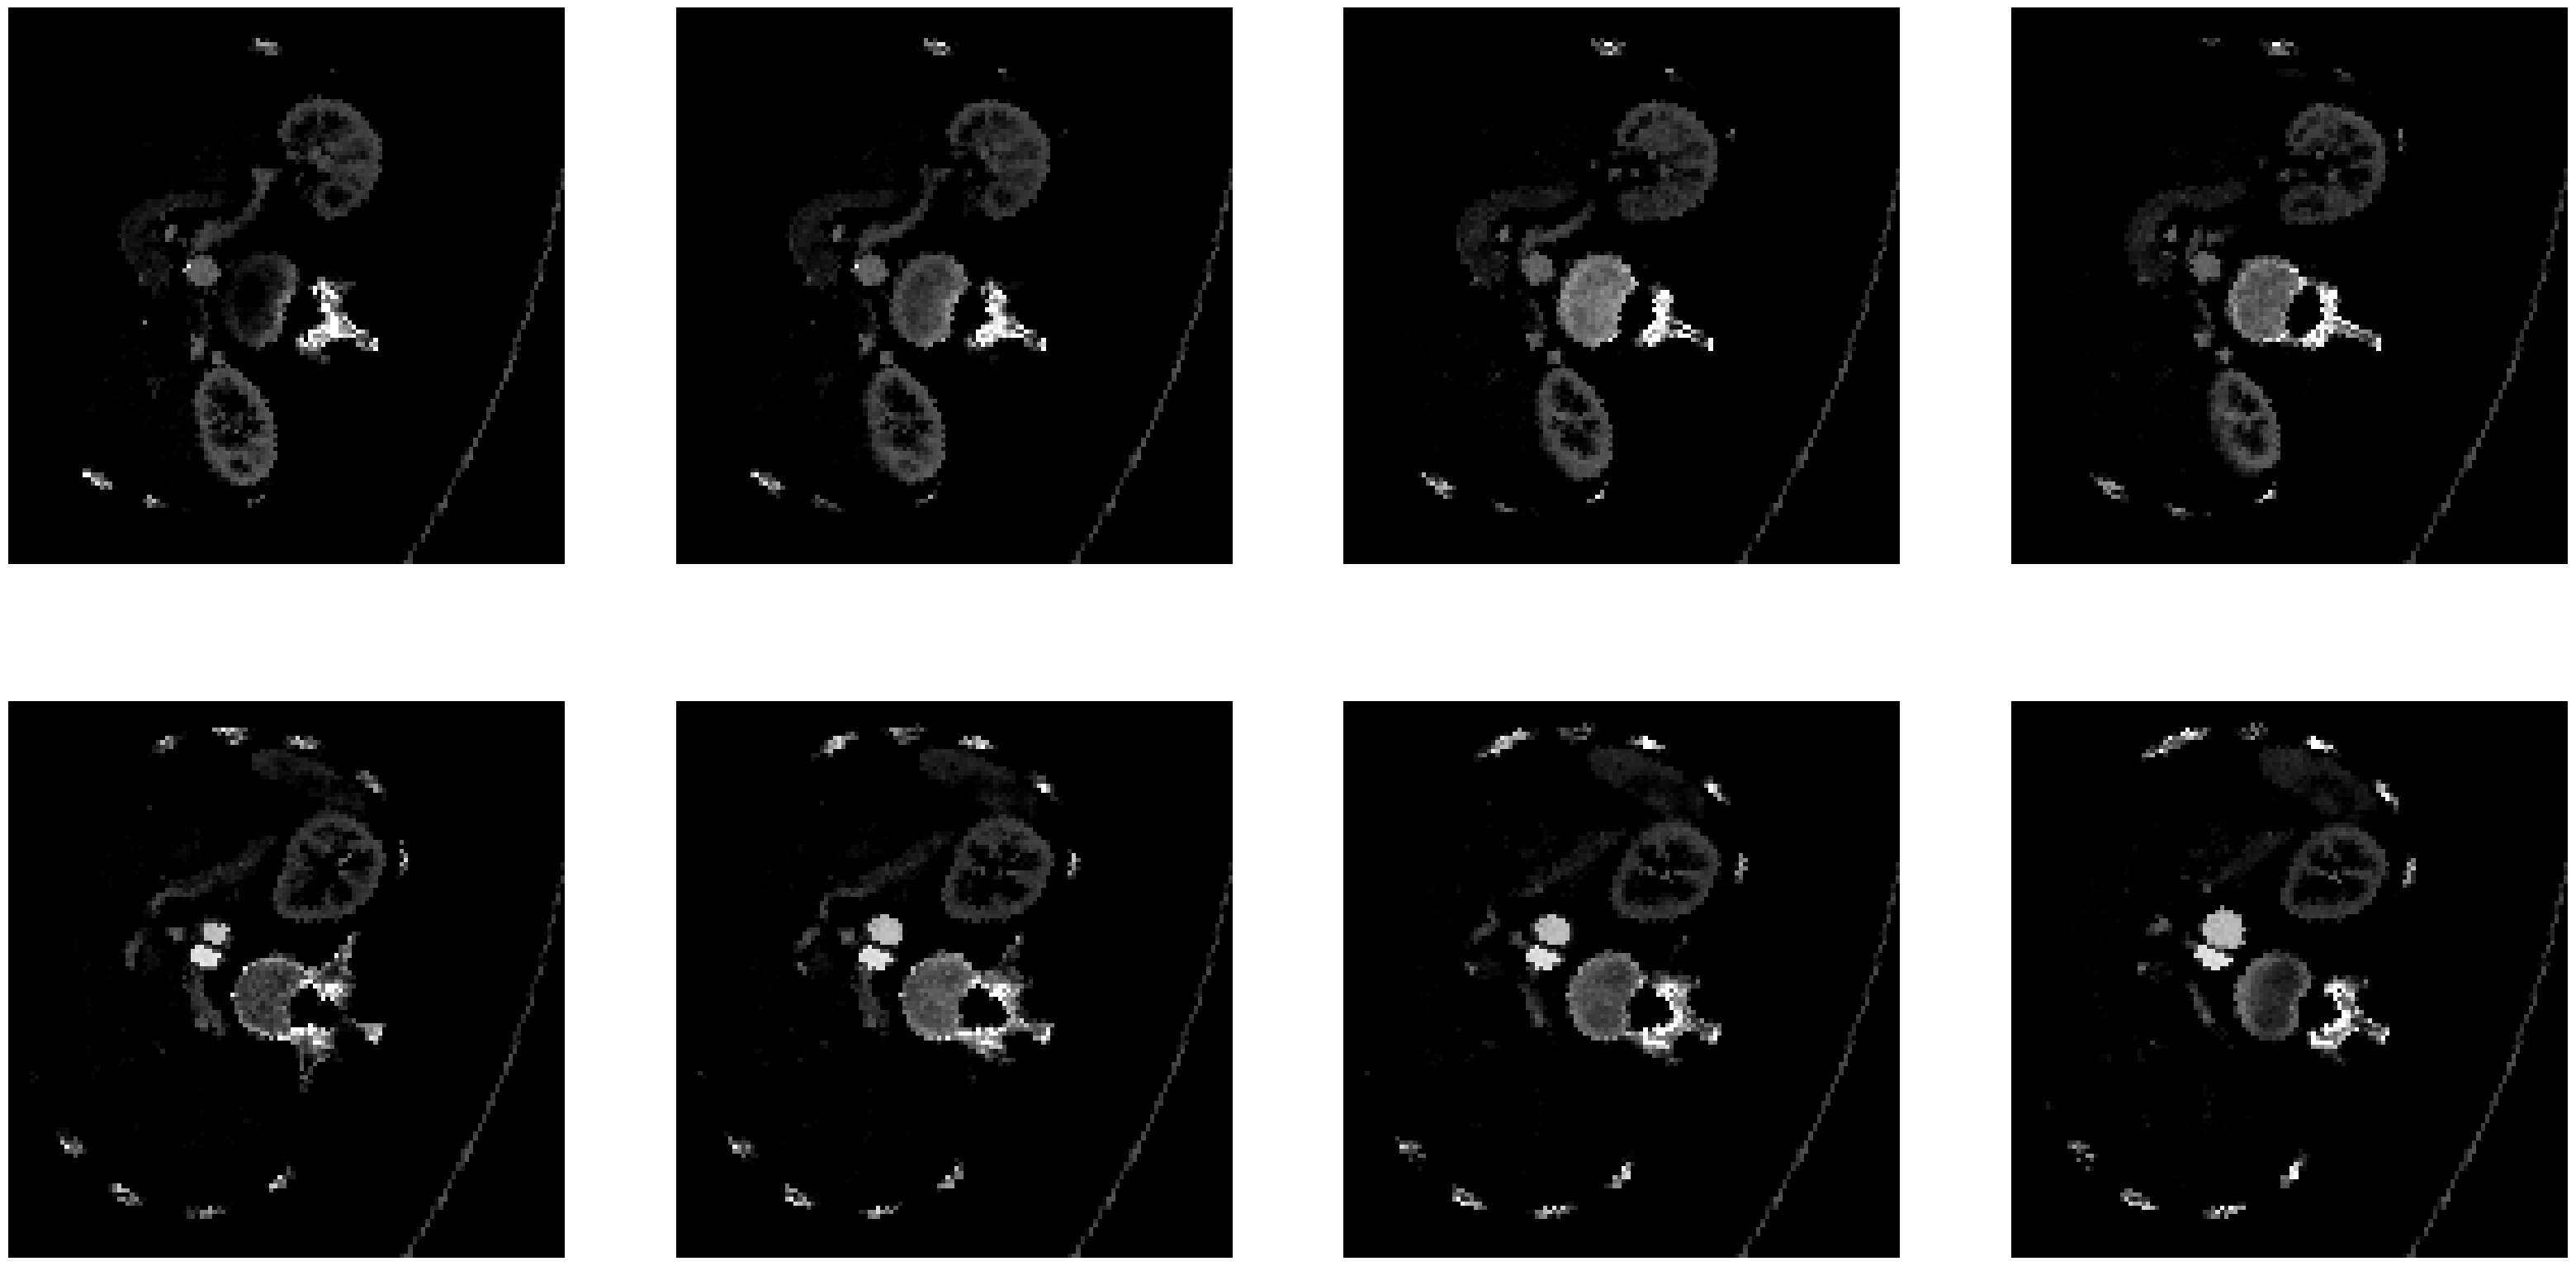

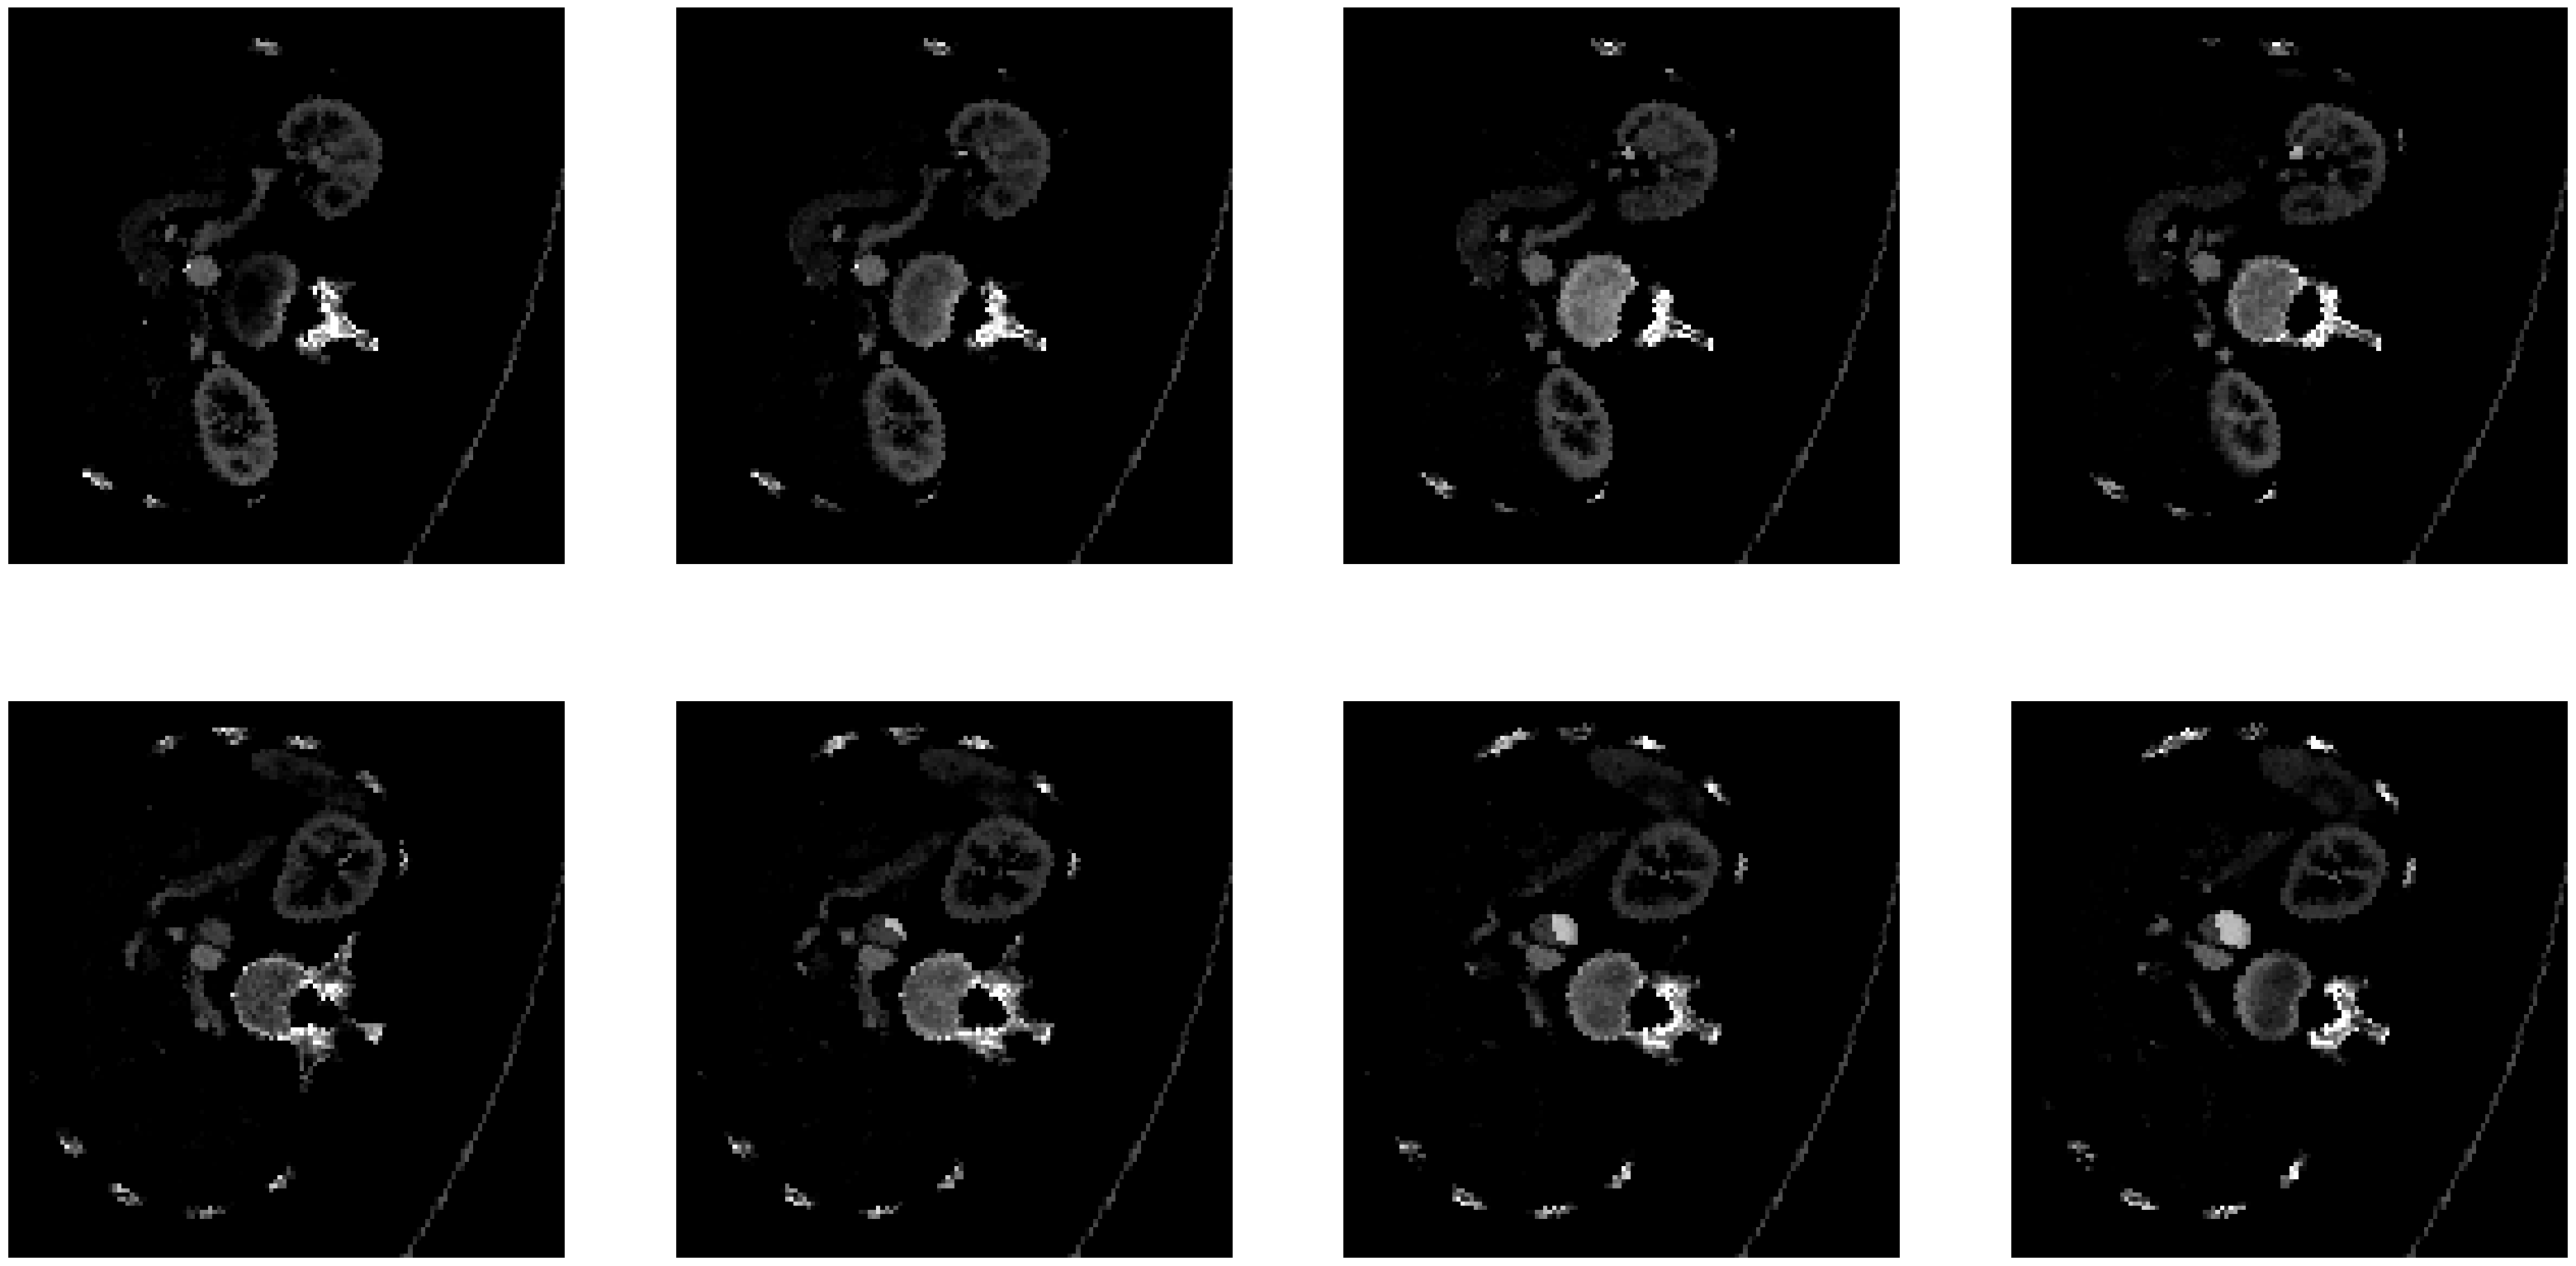

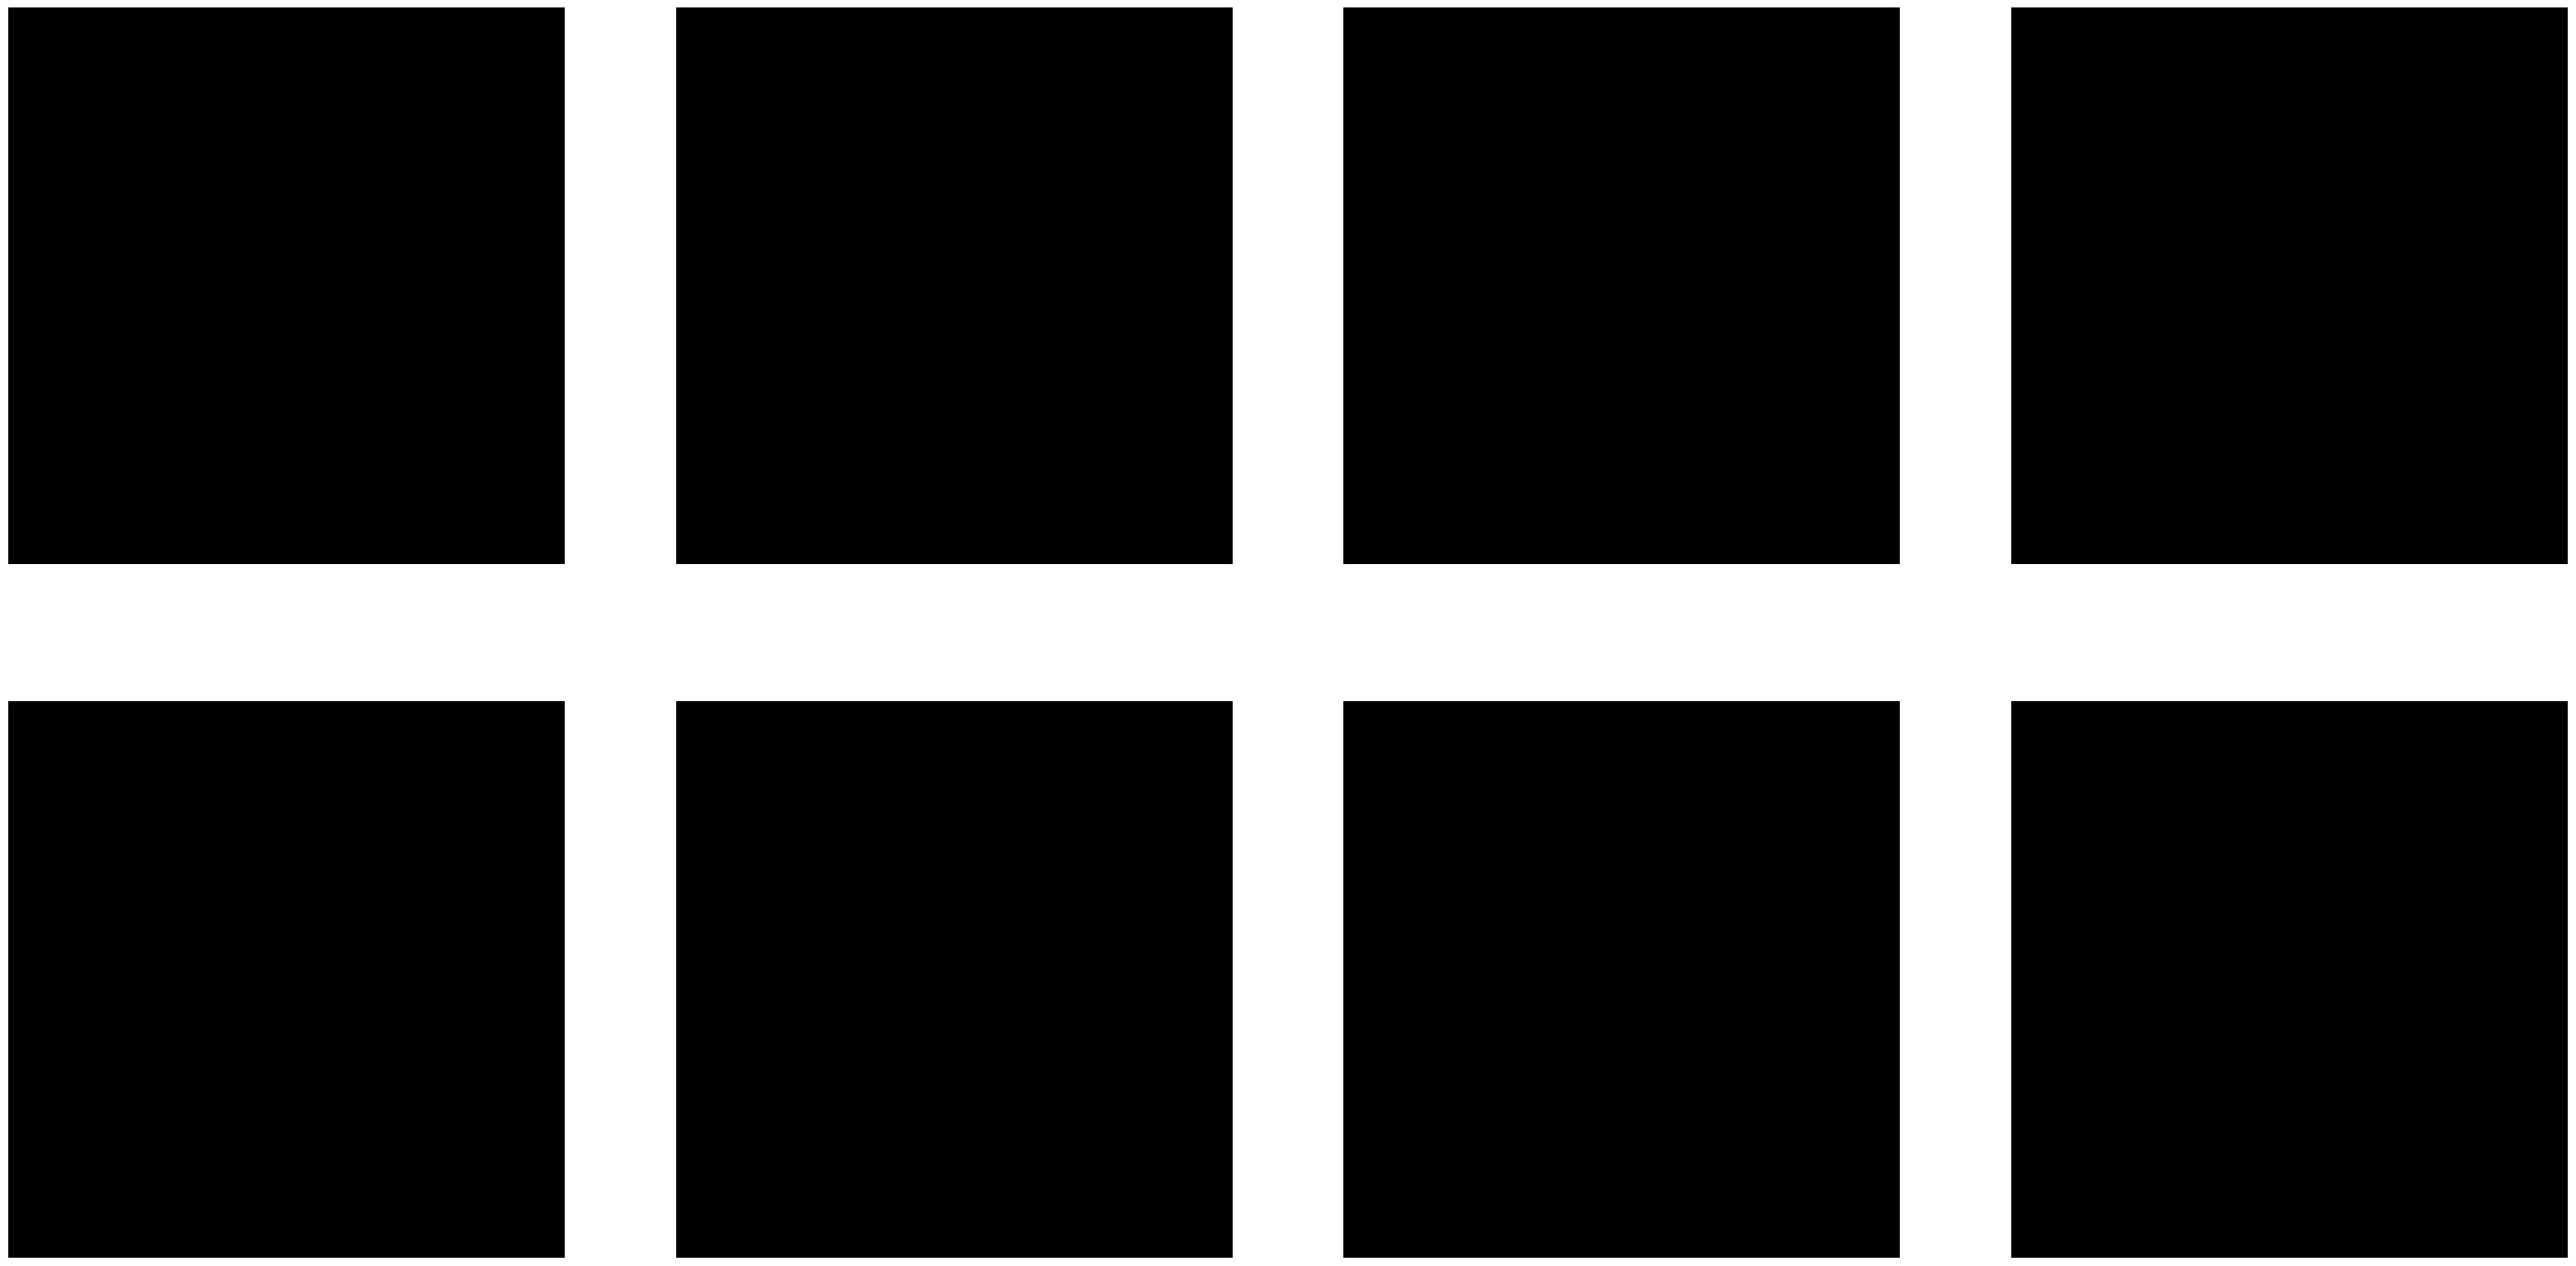

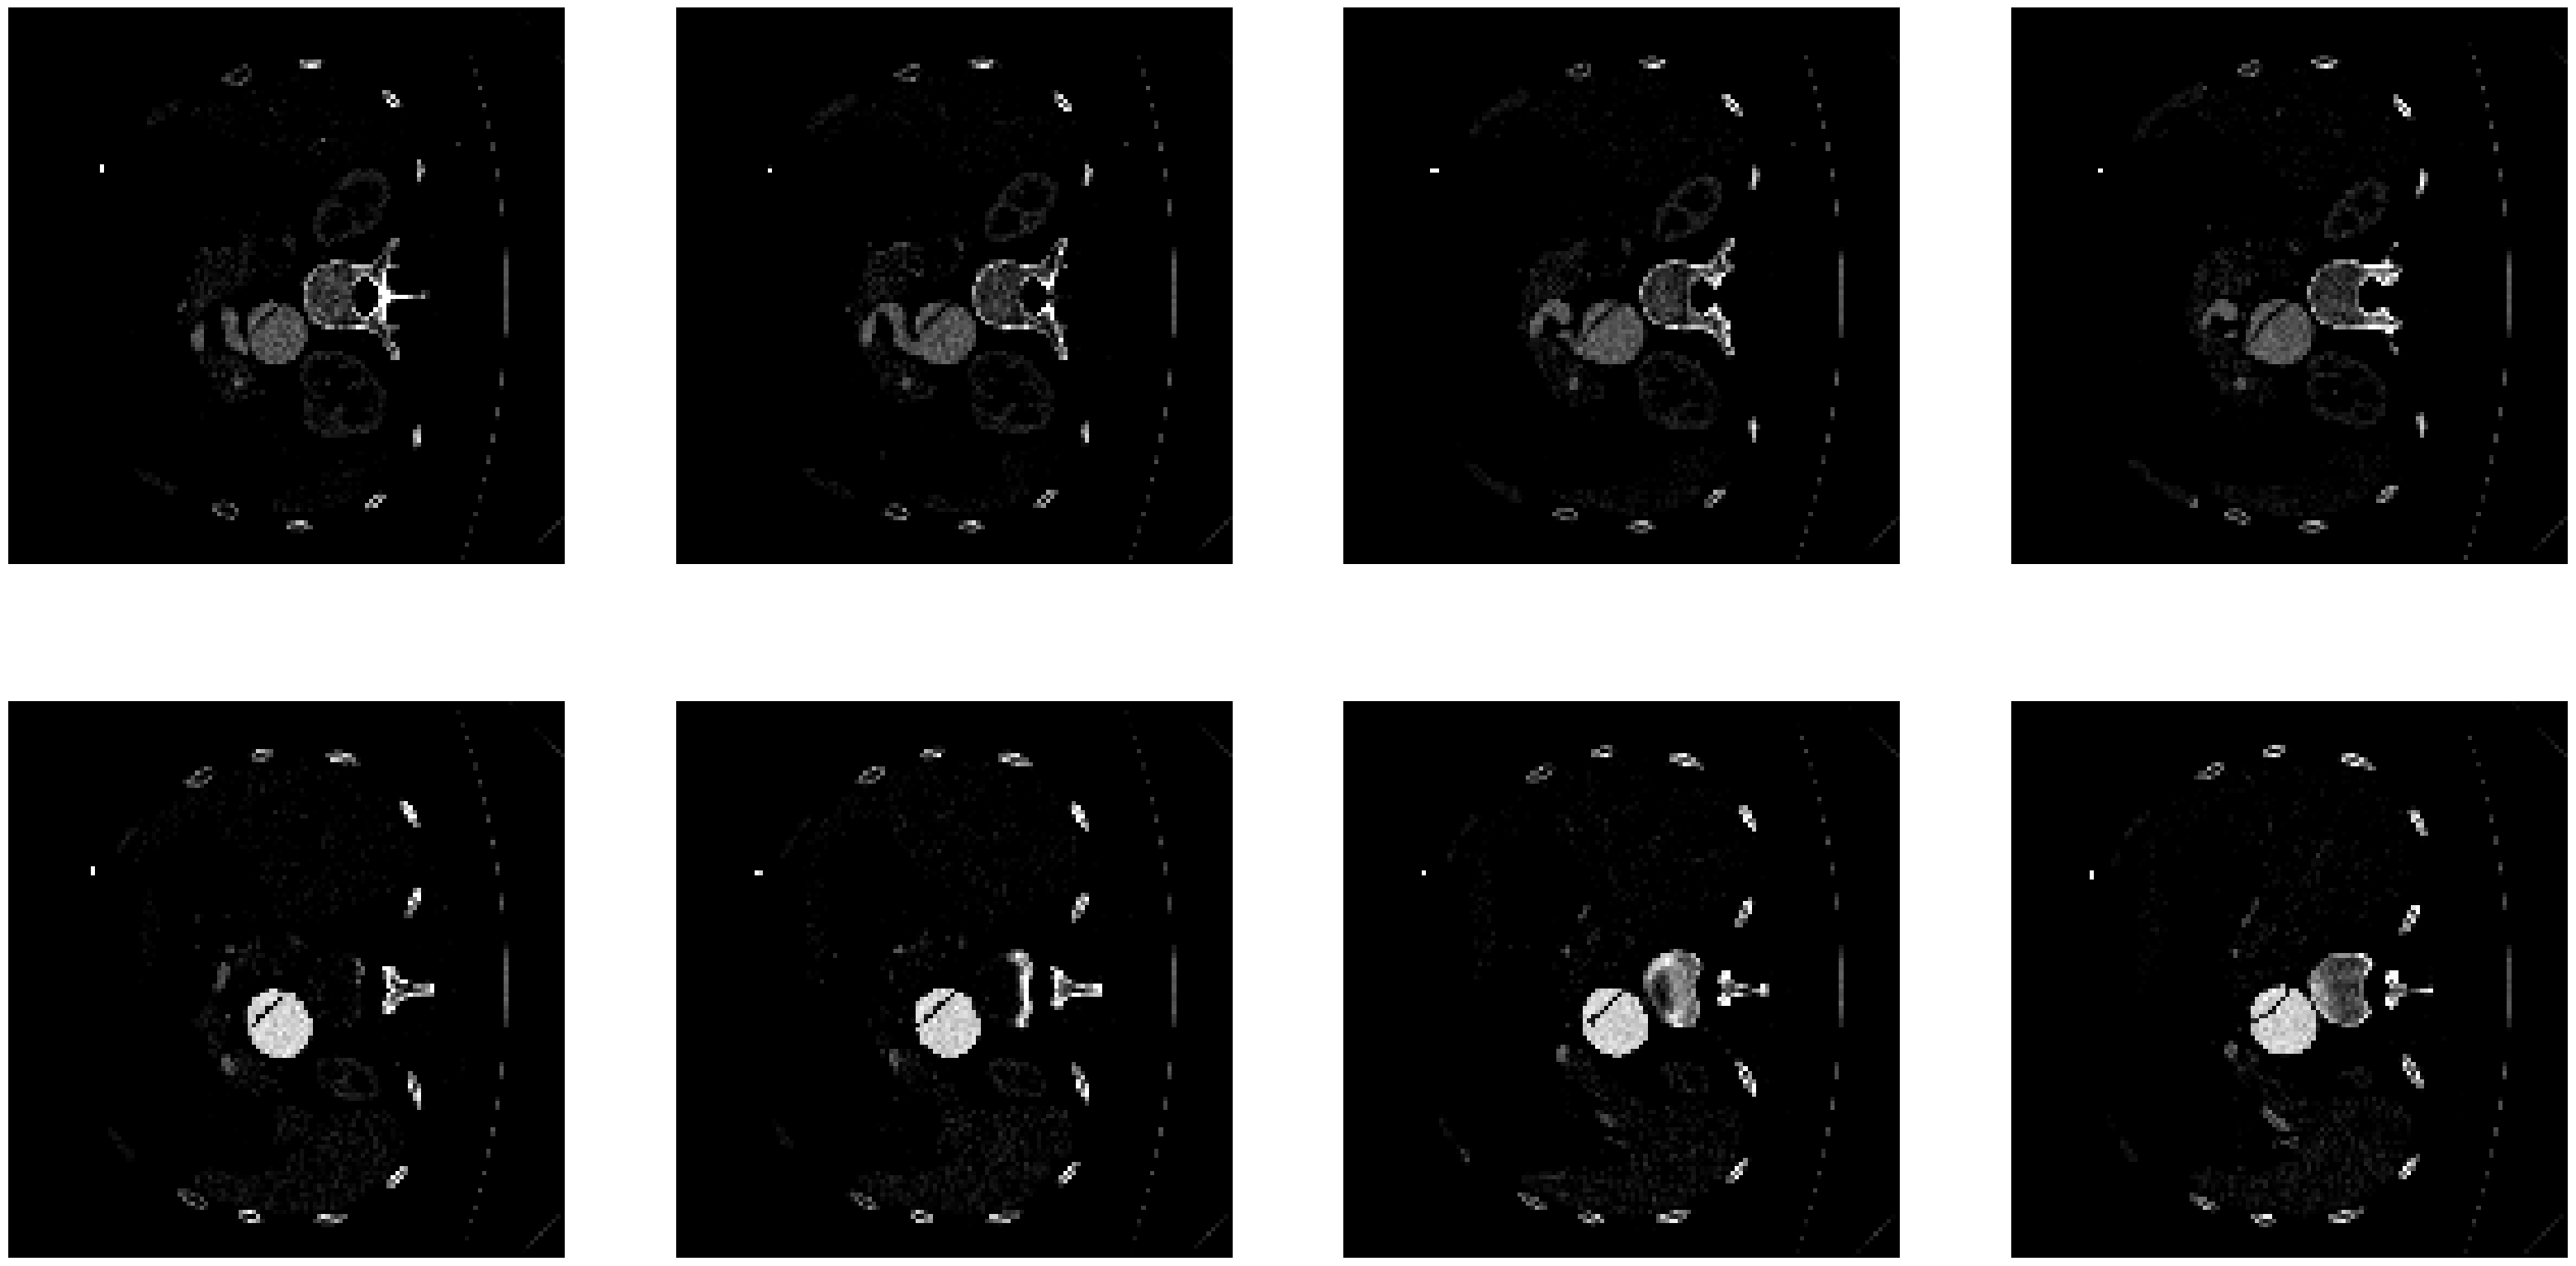

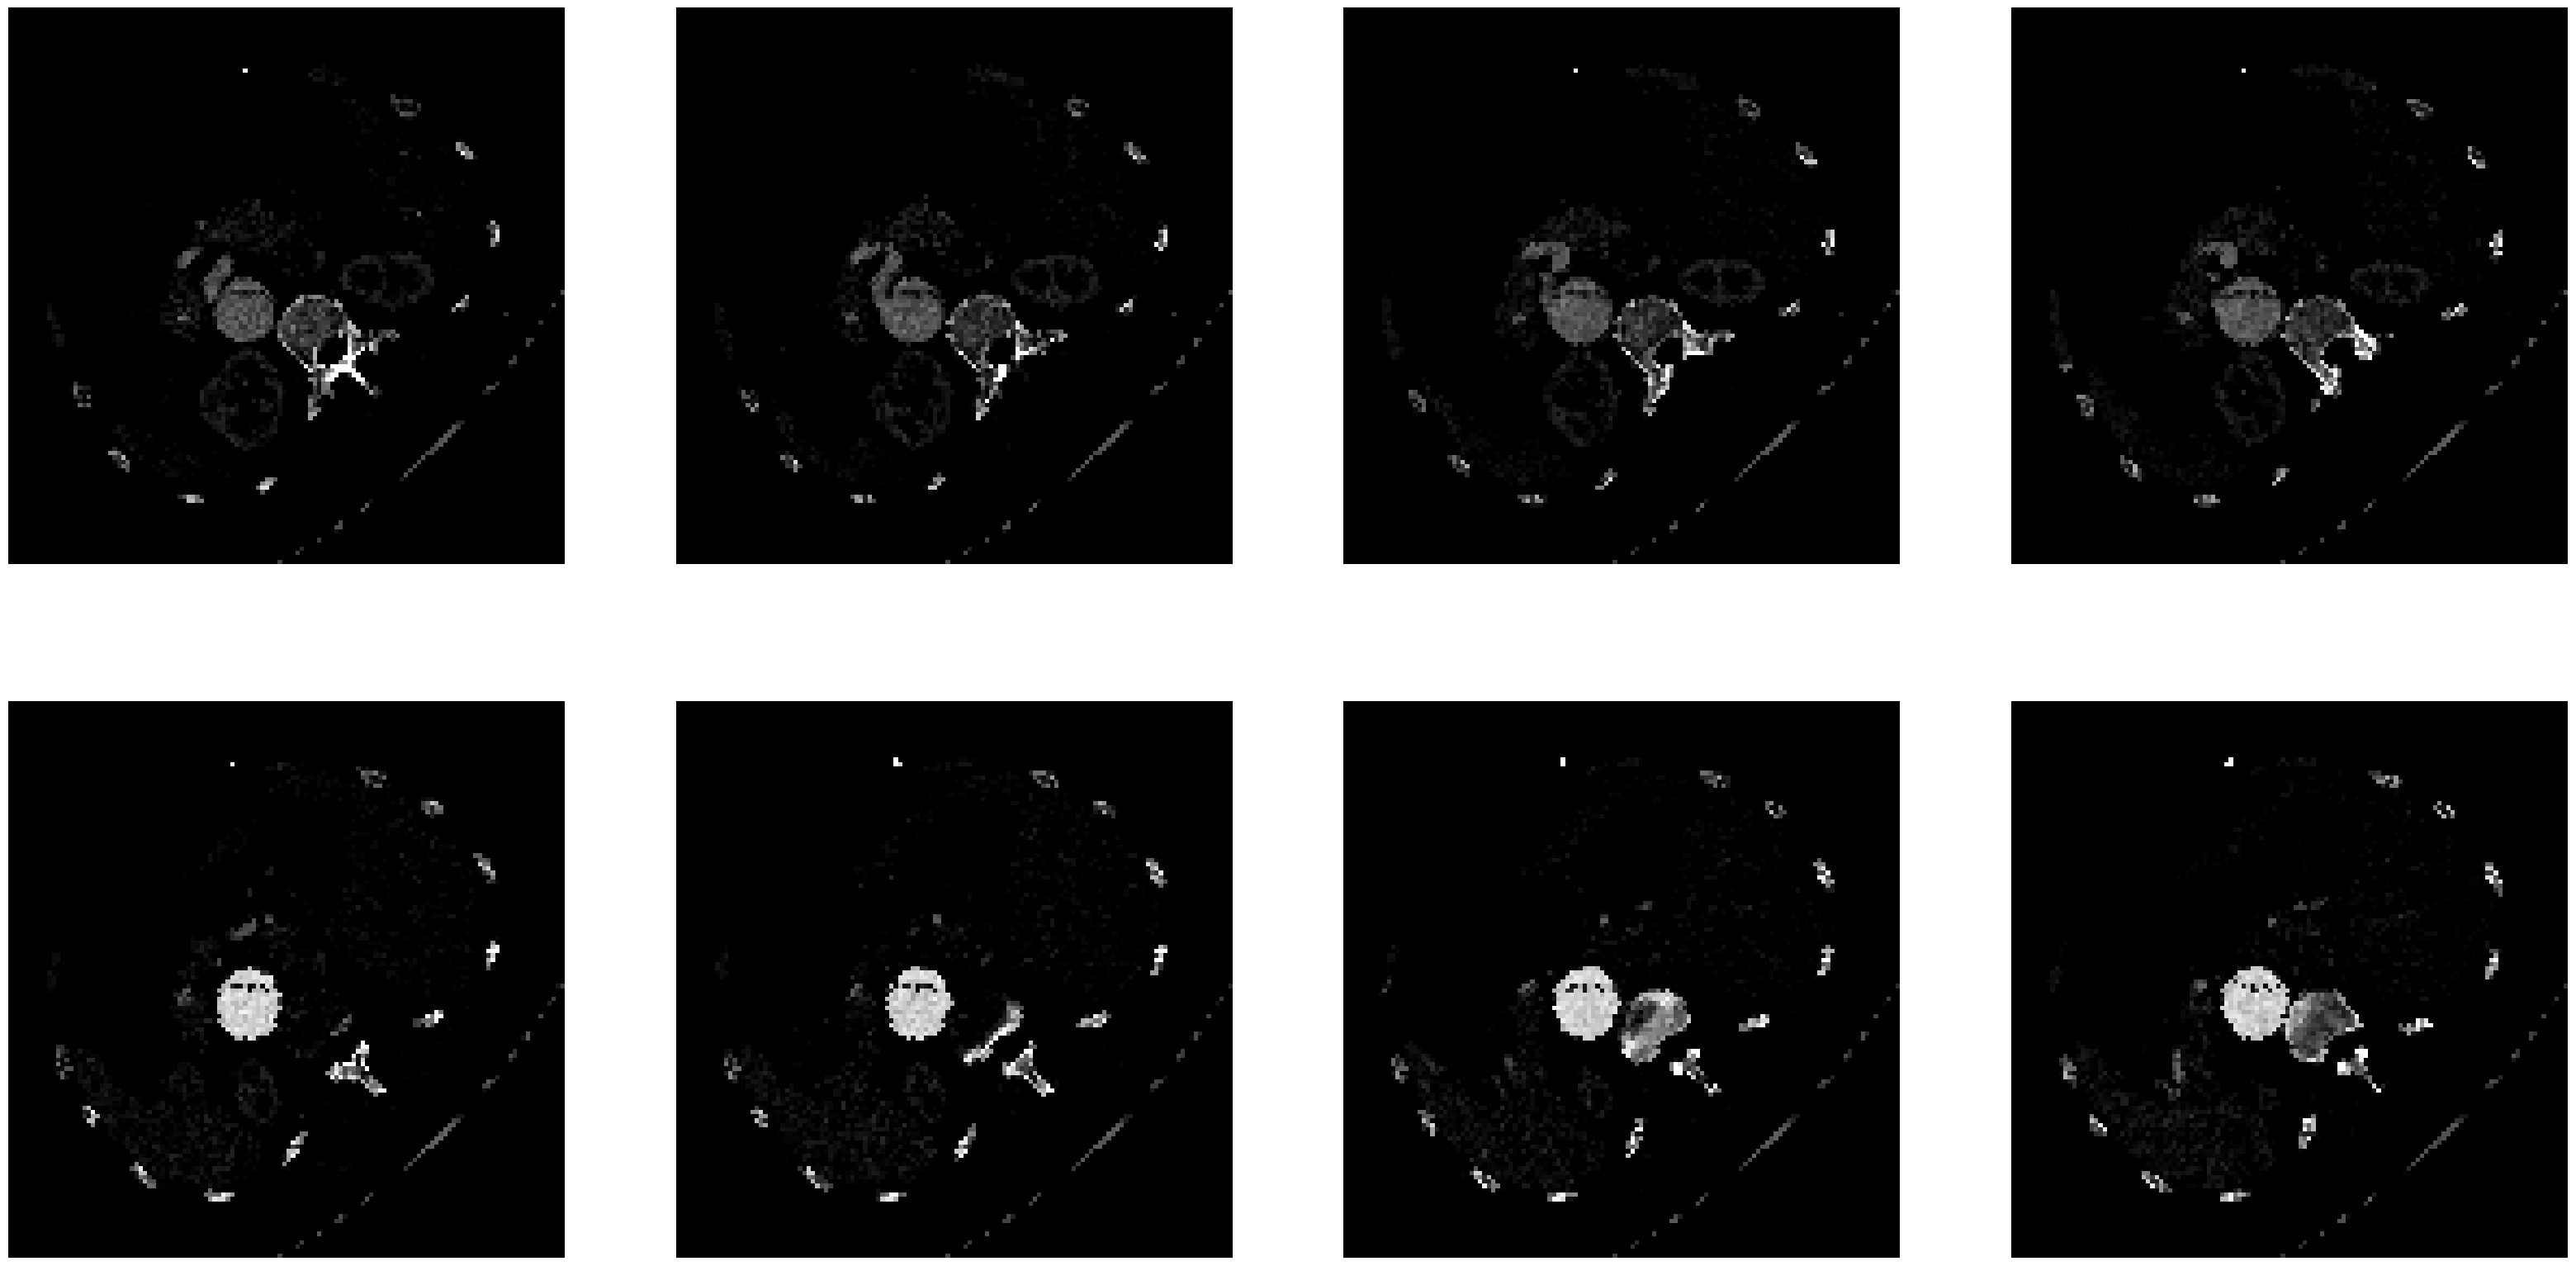

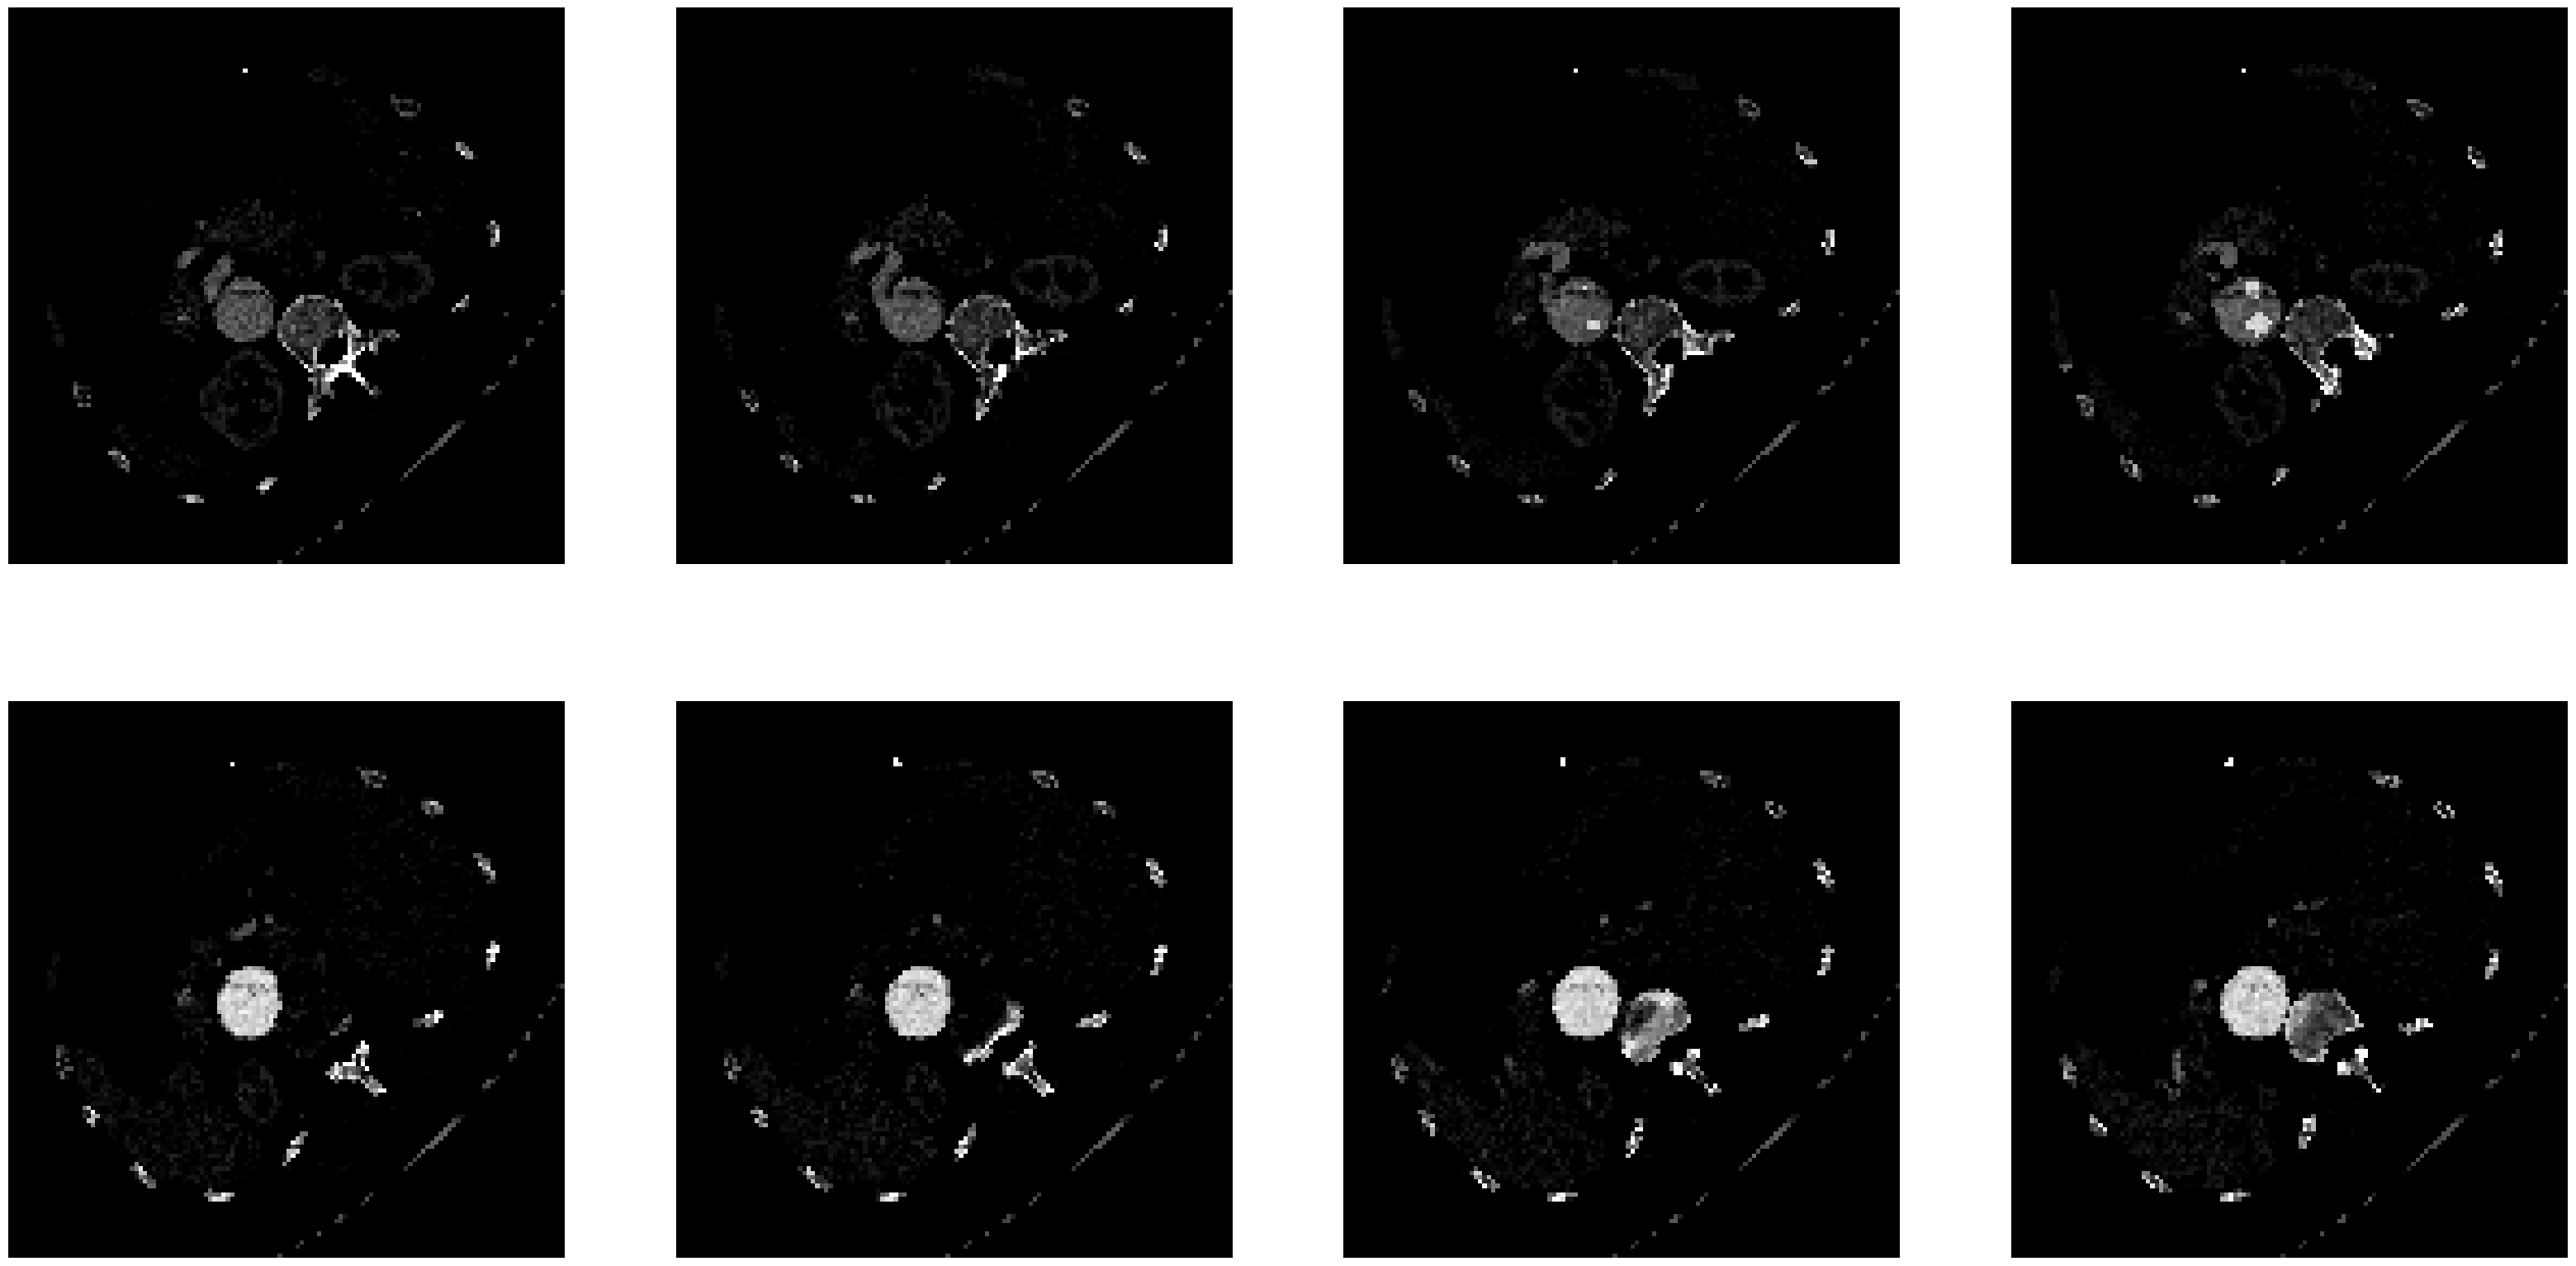

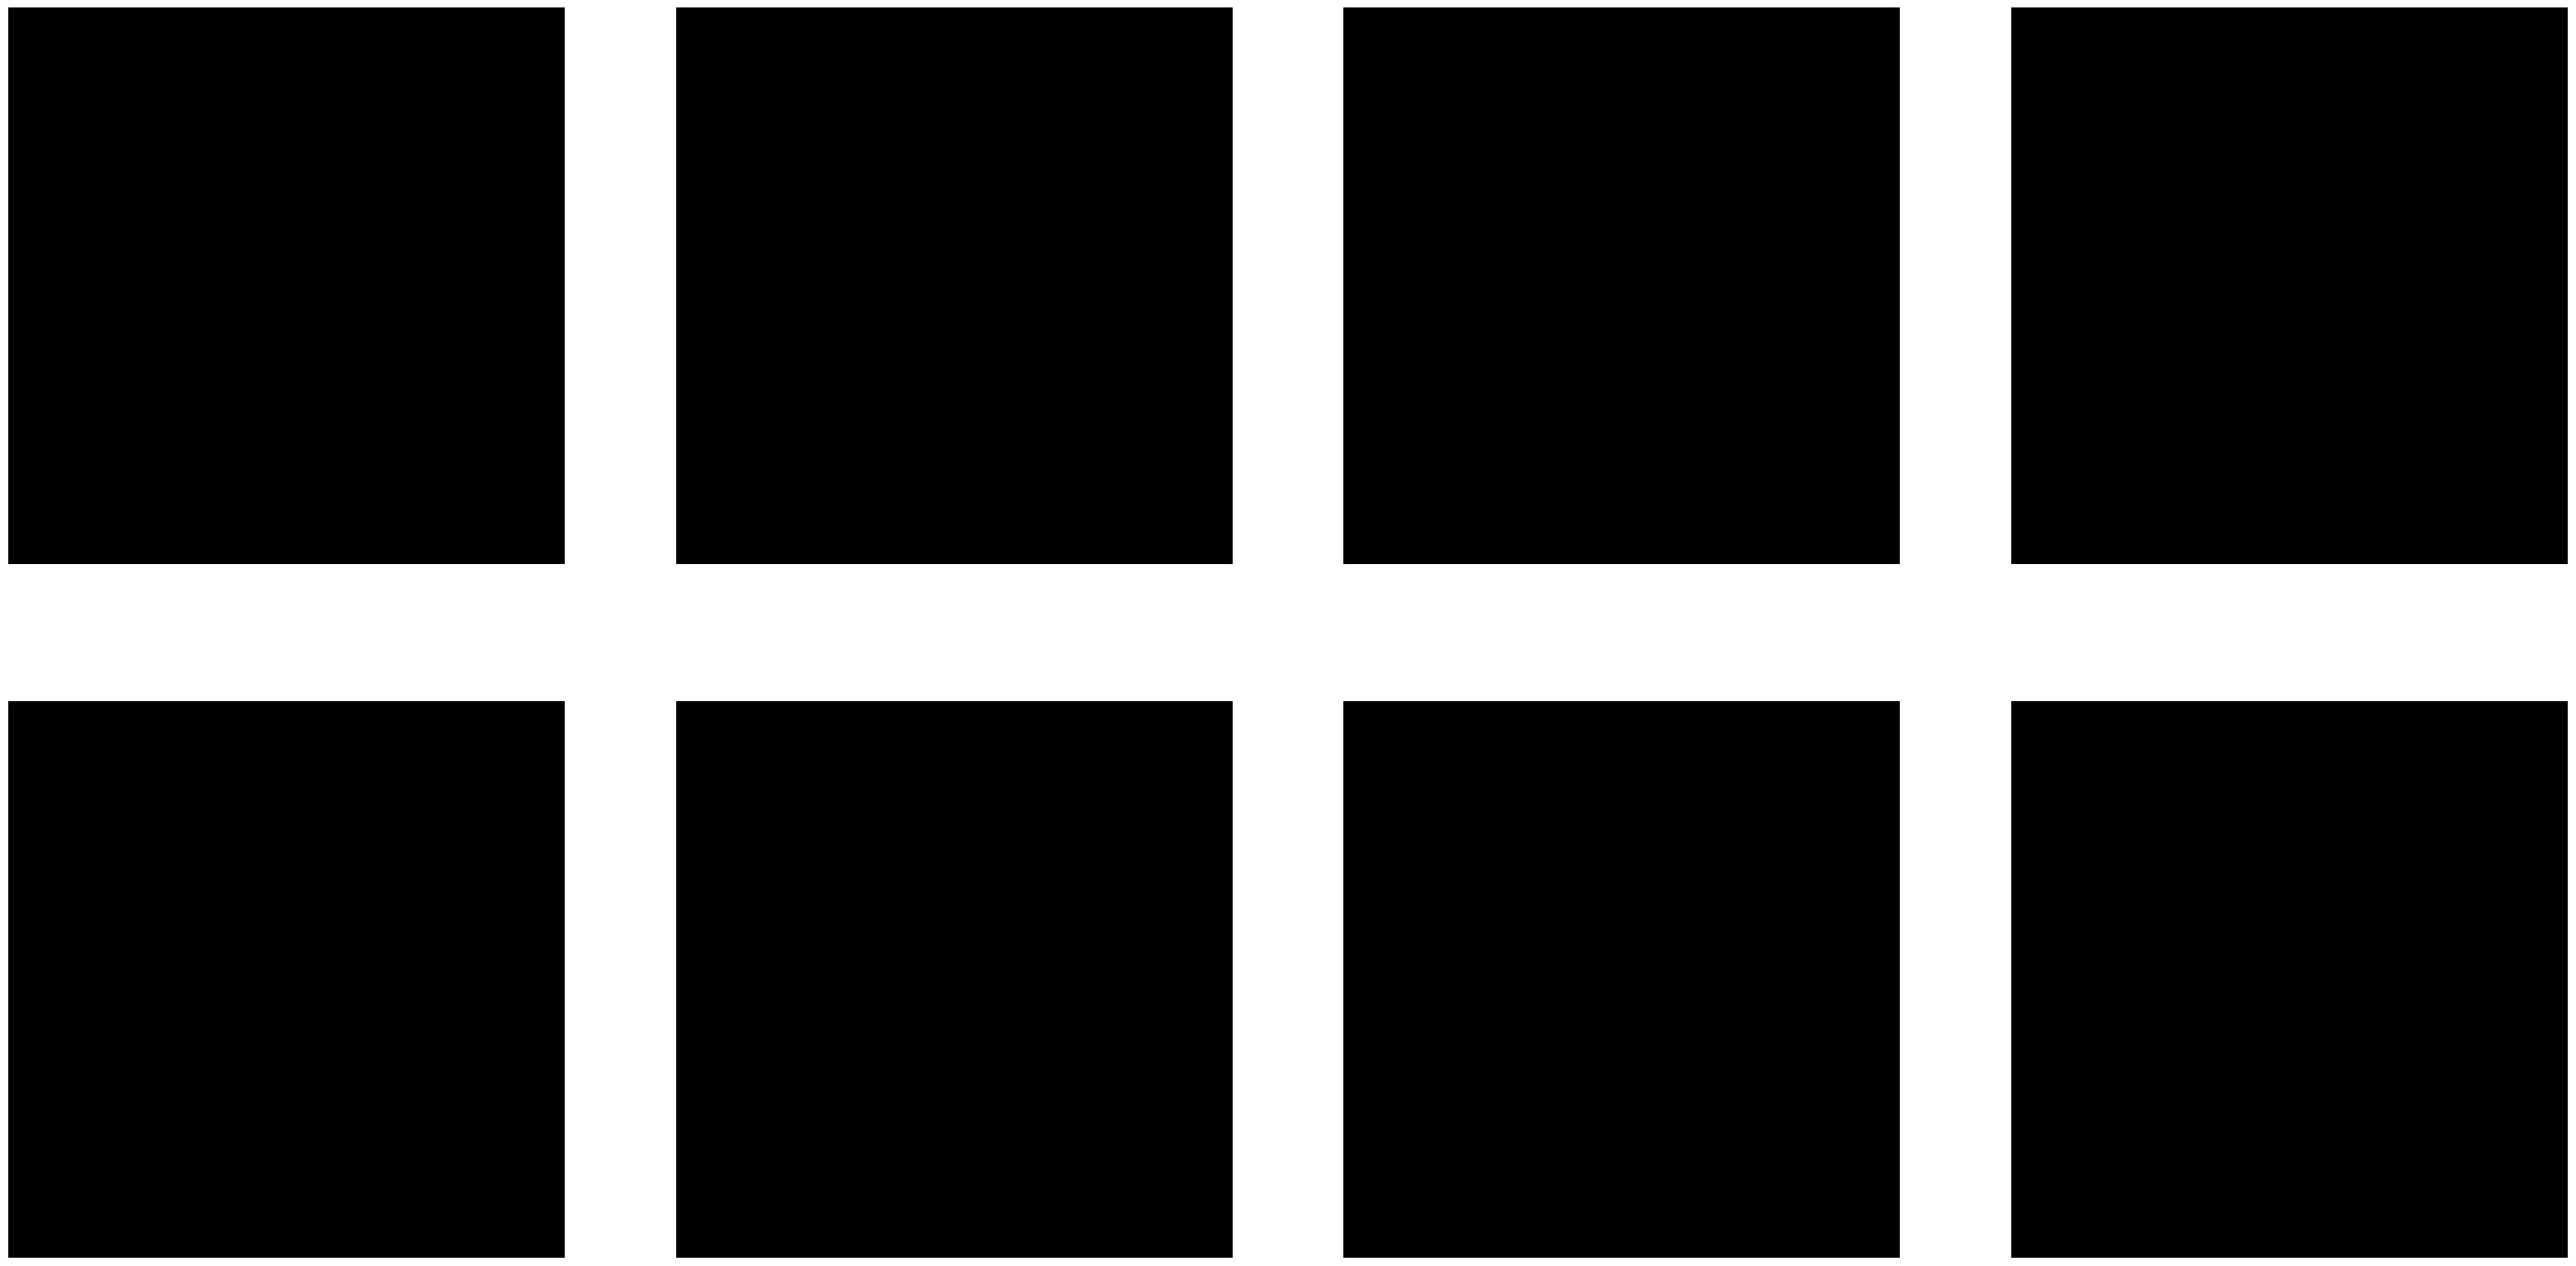

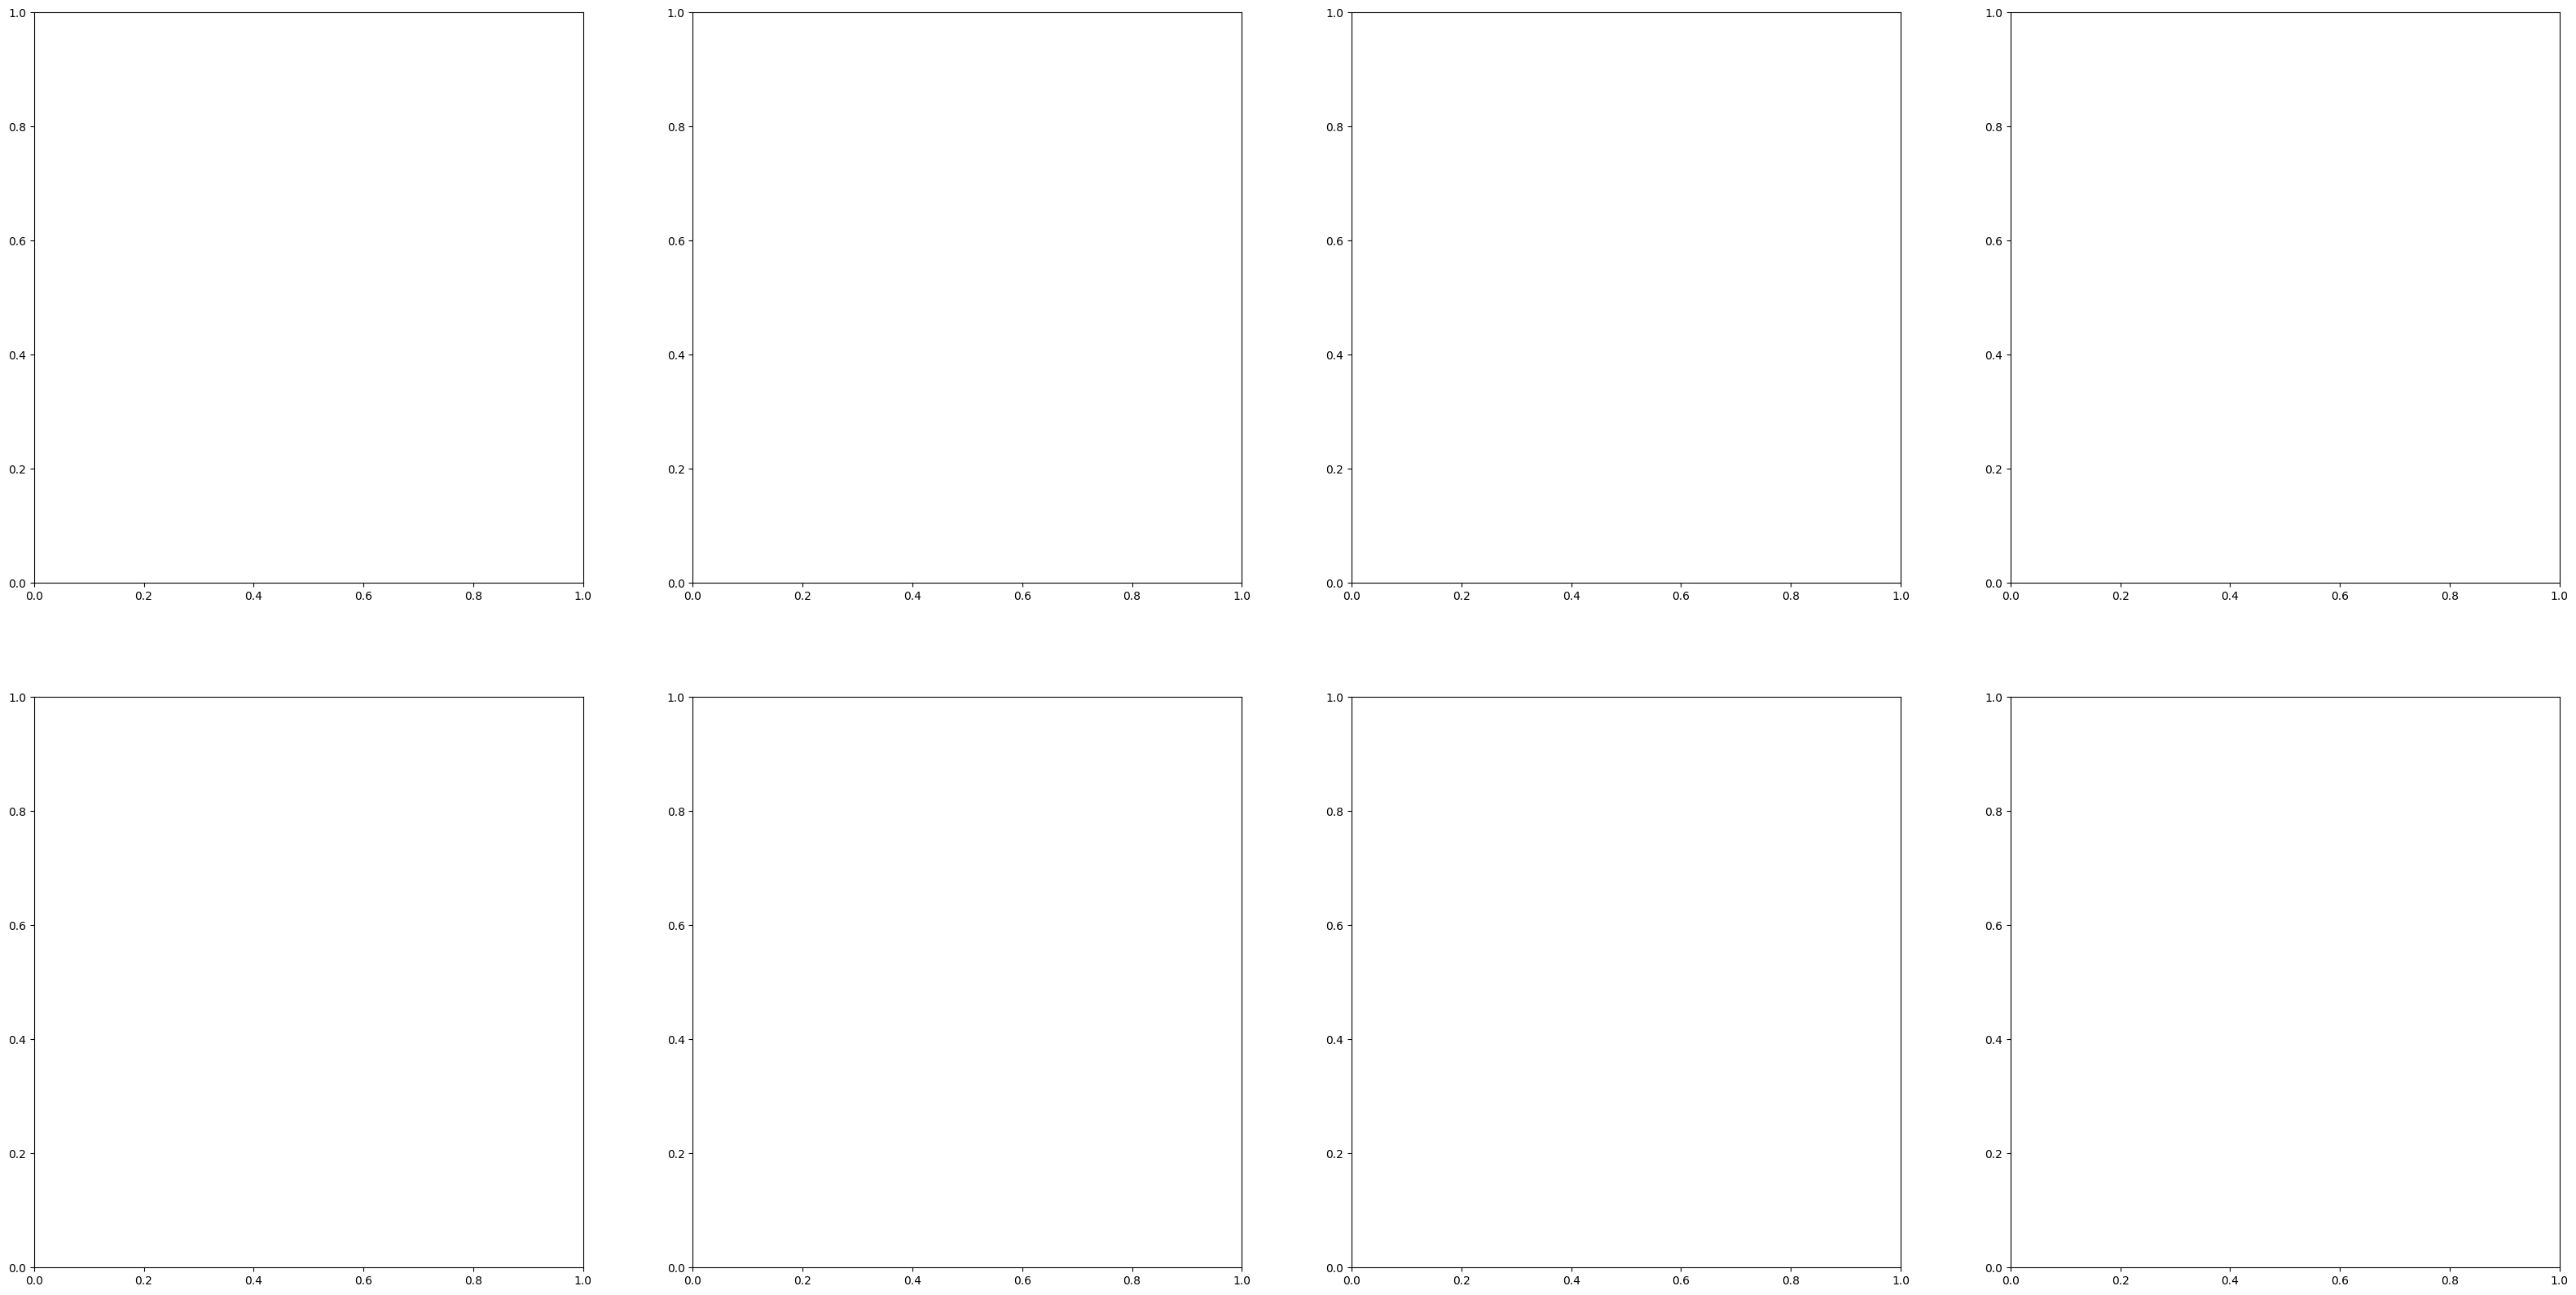

In [28]:
trainer.train_labeled_one_epoch(
    use_transform=True
)